In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install wfdb numpy pandas joblib tqdm tsai PyWavelets optuna

In [ ]:
!wget -r -N -c -np -P /content/drive/MyDrive/DATAS/Data/PTB-XL https://physionet.org/files/ptb-xl/1.0.1/


Streaming output truncated to the last 5000 lines.
Saving to: ‘/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/07000/07881_hr.dat’

physionet.org/files 100%[===================>] 117.19K  --.-KB/s    in 0.1s    

2024-08-18 08:49:31 (900 KB/s) - ‘/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/07000/07881_hr.dat’ saved [120000/120000]

--2024-08-18 08:49:31--  https://physionet.org/files/ptb-xl/1.0.1/records500/07000/07881_hr.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 603 [text/plain]
Saving to: ‘/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/07000/07881_hr.hea’

physionet.org/files 100%[===================>]     603  --.-KB/s    in 0s      

2024-08-18 08:49:31 (117 MB/s) - ‘/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/07000/07881_hr.hea’ saved [603/603]

--2024-08-18 08

#Data Procesing

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

# Function to load raw ECG signal data based on sampling rate (100 Hz or 500 Hz)
def load_raw_data(df, base_path, sample_rate='100'):
    data = []

    # Choose the appropriate filename column based on sample_rate
    if sample_rate == '100':
        filenames = df.filename_lr  # 100 Hz data
    elif sample_rate == '500':
        filenames = df.filename_hr  # 500 Hz data

    for f in filenames:
        # Since filenames already contain subdirectories, use base path only
        full_path = os.path.join(base_path, f)
        signal, meta = wfdb.rdsamp(full_path)
        data.append(signal)

    return np.array(data)

# Set the base path (without records100 or records500 since it's already included in the filenames)
BASE_PATH = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH, 'ptbxl_database.csv'), index_col='ecg_id')
print("Annotation data loaded.")

# Convert diagnostic codes from string to dictionary format
print("Converting diagnostic codes...")
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Diagnostic codes converted.")

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Prepare file names and paths for saving
print("Preparing file paths and disease classes...")
file_data = []

for idx, row in Y.iterrows():
    # Get the filename for 100 Hz and 500 Hz data
    filename_lr = row['filename_lr']  # 100 Hz data
    filename_hr = row['filename_hr']  # 500 Hz data

    # Construct the full paths
    full_path_lr = os.path.join(BASE_PATH, filename_lr)
    full_path_hr = os.path.join(BASE_PATH, filename_hr)

    # Extract the base name to construct .dat and .hea file names for both 100 Hz and 500 Hz
    base_filename_lr = os.path.splitext(filename_lr)[0]
    base_filename_hr = os.path.splitext(filename_hr)[0]

    # Add to list for creating DataFrame
    file_data.append({
        'disease_class': row['diagnostic_superclass'],
        'dat_file_100Hz': f"{base_filename_lr}.dat",
        'hea_file_100Hz': f"{base_filename_lr}.hea",
        'file_path_100Hz': full_path_lr,
        'dat_file_500Hz': f"{base_filename_hr}.dat",
        'hea_file_500Hz': f"{base_filename_hr}.hea",
        'file_path_500Hz': full_path_hr
    })

# Convert the list to a DataFrame
csv_data = pd.DataFrame(file_data)

# Save to CSV
csv_file_path = os.path.join(BASE_PATH, 'ptbxl_disease_file_info.csv')
csv_data.to_csv(csv_file_path, index=False)
print(f"CSV file saved at: {csv_file_path}")



Loading annotation data...
Annotation data loaded.
Converting diagnostic codes...
Diagnostic codes converted.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Preparing file paths and disease classes...
CSV file saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_disease_file_info.csv


Filter CSV files n save

In [ ]:
import pandas as pd

# Function to load the CSV and delete rows with paired classes, saving to a new file
def remove_paired_classes(csv_path, output_csv_path):
    # Load the original CSV file
    csv_data = pd.read_csv(csv_path)

    # Filter out rows with paired classes (i.e., more than one class)
    filtered_data = csv_data[csv_data['disease_class'].apply(lambda x: len(eval(x)) == 1)]

    # Save the filtered data to a new CSV file
    filtered_data.to_csv(output_csv_path, index=False)

    print(f"Filtered data saved to {output_csv_path}")

if __name__ == "__main__":
    # Set the paths
    csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_disease_file_info.csv'  # Path to your original CSV file
    output_csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_filtered_disease_file_info.csv'  # Path to save the filtered CSV file

    # Remove rows with paired classes and save the result as a new CSV file
    remove_paired_classes(csv_path, output_csv_path)


Original Data Processing pipeline tweet

In [ ]:
import pandas as pd
import numpy as np
import wfdb
import ast
import os

# Function to load raw ECG signal data based on sampling rate
def load_raw_data(df, sampling_rate, base_path):
    print(f"Loading raw ECG signal data with {sampling_rate} Hz sampling rate...")
    data = []

    # Use appropriate filename column based on sampling rate
    if sampling_rate == 100:
        filenames = df.filename_lr  # 100 Hz data
    elif sampling_rate == 500:
        filenames = df.filename_hr  # 500 Hz data
    else:
        raise ValueError("Invalid sampling rate. Use 100 or 500.")

    for idx, f in enumerate(filenames):
        # Print progress for every 1000 files
        if idx % 1000 == 0:
            print(f"Loaded {idx} ECG records so far...")

        # Since filename_lr or filename_hr already contains subdirectories, use base path only
        full_path = os.path.join(base_path, f)
        signal, meta = wfdb.rdsamp(full_path)
        data.append(signal)

    print(f"Finished loading raw ECG signal data with {sampling_rate} Hz sampling rate.")
    return np.array(data)

# Set the base path (no need to specify records100 or records500, it's already included in the filenames)
BASE_PATH = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH, 'ptbxl_database.csv'), index_col='ecg_id')
print("Annotation data loaded.")
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Diagnostic codes converted from string to dictionary format.")

# Load raw ECG signal data for both 100 Hz and 500 Hz
X_100Hz = load_raw_data(Y, 100, BASE_PATH)
X_500Hz = load_raw_data(Y, 500, BASE_PATH)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Split data into training and test sets based on strat_fold
test_fold = 10

print("Splitting data into training and test sets...")
# Training data
train_indices = Y['strat_fold'] != test_fold

X_train_100Hz = X_100Hz[train_indices]
X_train_500Hz = X_500Hz[train_indices]
y_train = Y.loc[train_indices, 'diagnostic_superclass']

# Test data
test_indices = Y['strat_fold'] == test_fold

X_test_100Hz = X_100Hz[test_indices]
X_test_500Hz = X_500Hz[test_indices]
y_test = Y.loc[test_indices, 'diagnostic_superclass']

print("Data split into training and test sets.")

# Print the sizes of the training and test sets for both 100Hz and 500Hz
print(f"Training Set Size (100Hz): {len(X_train_100Hz)} samples")
print(f"Training Set Size (500Hz): {len(X_train_500Hz)} samples")
print(f"Test Set Size (100Hz): {len(X_test_100Hz)} samples")
print(f"Test Set Size (500Hz): {len(X_test_500Hz)} samples")

# Print the shapes of the training and test data for both 100Hz and 500Hz
print(f"X_train_100Hz shape: {X_train_100Hz.shape}")
print(f"X_train_500Hz shape: {X_train_500Hz.shape}")
print(f"y_train length: {len(y_train)}")
print(f"X_test_100Hz shape: {X_test_100Hz.shape}")
print(f"X_test_500Hz shape: {X_test_500Hz.shape}")
print(f"y_test length: {len(y_test)}")

print("Data for both 100Hz and 500Hz is now ready for model training and evaluation.")


Loading annotation data...
Annotation data loaded.
Diagnostic codes converted from string to dictionary format.
Loading raw ECG signal data with 100 Hz sampling rate...
Loaded 0 ECG records so far...
Loaded 1000 ECG records so far...
Loaded 2000 ECG records so far...
Loaded 3000 ECG records so far...
Loaded 4000 ECG records so far...
Loaded 5000 ECG records so far...
Loaded 6000 ECG records so far...
Loaded 7000 ECG records so far...
Loaded 8000 ECG records so far...
Loaded 9000 ECG records so far...
Loaded 10000 ECG records so far...
Loaded 11000 ECG records so far...
Loaded 12000 ECG records so far...
Loaded 13000 ECG records so far...
Loaded 14000 ECG records so far...
Loaded 15000 ECG records so far...
Loaded 16000 ECG records so far...
Loaded 17000 ECG records so far...
Loaded 18000 ECG records so far...
Loaded 19000 ECG records so far...
Loaded 20000 ECG records so far...
Loaded 21000 ECG records so far...
Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading ra

#CNN

Load and use 20% datas

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 4367/4367 [00:17<00:00, 245.05it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 4367 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (4367, 5)
Splitting data into training and test sets...
Training set size: 3493 samples
Test set size: 874 samples


Epoch 1/50: 100%|██████████| 55/55 [00:01<00:00, 44.01it/s]


Epoch 1/50, Train Loss: 0.5863, Test Loss: 0.5513, Train Acc: 0.7224, Test Acc: 0.7396


Epoch 2/50: 100%|██████████| 55/55 [00:00<00:00, 140.93it/s]


Epoch 2/50, Train Loss: 0.5391, Test Loss: 0.5179, Train Acc: 0.7438, Test Acc: 0.7666


Epoch 3/50: 100%|██████████| 55/55 [00:00<00:00, 141.25it/s]


Epoch 3/50, Train Loss: 0.4952, Test Loss: 0.4709, Train Acc: 0.7702, Test Acc: 0.7835


Epoch 4/50: 100%|██████████| 55/55 [00:00<00:00, 139.79it/s]


Epoch 4/50, Train Loss: 0.4572, Test Loss: 0.4698, Train Acc: 0.7858, Test Acc: 0.7890


Epoch 5/50: 100%|██████████| 55/55 [00:00<00:00, 140.66it/s]


Epoch 5/50, Train Loss: 0.4401, Test Loss: 0.4418, Train Acc: 0.7912, Test Acc: 0.7936


Epoch 6/50: 100%|██████████| 55/55 [00:00<00:00, 141.26it/s]


Epoch 6/50, Train Loss: 0.4215, Test Loss: 0.4220, Train Acc: 0.8029, Test Acc: 0.8078


Epoch 7/50: 100%|██████████| 55/55 [00:00<00:00, 140.00it/s]


Epoch 7/50, Train Loss: 0.4050, Test Loss: 0.4114, Train Acc: 0.8121, Test Acc: 0.8165


Epoch 8/50: 100%|██████████| 55/55 [00:00<00:00, 140.01it/s]


Epoch 8/50, Train Loss: 0.3940, Test Loss: 0.3994, Train Acc: 0.8169, Test Acc: 0.8208


Epoch 9/50: 100%|██████████| 55/55 [00:00<00:00, 139.21it/s]


Epoch 9/50, Train Loss: 0.3829, Test Loss: 0.3923, Train Acc: 0.8255, Test Acc: 0.8199


Epoch 10/50: 100%|██████████| 55/55 [00:00<00:00, 135.62it/s]


Epoch 10/50, Train Loss: 0.3695, Test Loss: 0.3981, Train Acc: 0.8321, Test Acc: 0.8270


Epoch 11/50: 100%|██████████| 55/55 [00:00<00:00, 138.74it/s]


Epoch 11/50, Train Loss: 0.3635, Test Loss: 0.3905, Train Acc: 0.8368, Test Acc: 0.8275


Epoch 12/50: 100%|██████████| 55/55 [00:00<00:00, 138.72it/s]


Epoch 12/50, Train Loss: 0.3544, Test Loss: 0.3928, Train Acc: 0.8400, Test Acc: 0.8288


Epoch 13/50: 100%|██████████| 55/55 [00:00<00:00, 138.20it/s]


Epoch 13/50, Train Loss: 0.3514, Test Loss: 0.3766, Train Acc: 0.8453, Test Acc: 0.8359


Epoch 14/50: 100%|██████████| 55/55 [00:00<00:00, 137.72it/s]


Epoch 14/50, Train Loss: 0.3495, Test Loss: 0.3745, Train Acc: 0.8455, Test Acc: 0.8350


Epoch 15/50: 100%|██████████| 55/55 [00:00<00:00, 138.92it/s]


Epoch 15/50, Train Loss: 0.3404, Test Loss: 0.3749, Train Acc: 0.8494, Test Acc: 0.8330


Epoch 16/50: 100%|██████████| 55/55 [00:00<00:00, 138.04it/s]


Epoch 16/50, Train Loss: 0.3351, Test Loss: 0.3692, Train Acc: 0.8511, Test Acc: 0.8368


Epoch 17/50: 100%|██████████| 55/55 [00:00<00:00, 138.71it/s]


Epoch 17/50, Train Loss: 0.3328, Test Loss: 0.3688, Train Acc: 0.8523, Test Acc: 0.8384


Epoch 18/50: 100%|██████████| 55/55 [00:00<00:00, 139.15it/s]


Epoch 18/50, Train Loss: 0.3305, Test Loss: 0.3697, Train Acc: 0.8548, Test Acc: 0.8375


Epoch 19/50: 100%|██████████| 55/55 [00:00<00:00, 137.43it/s]


Epoch 19/50, Train Loss: 0.3325, Test Loss: 0.3680, Train Acc: 0.8553, Test Acc: 0.8387


Epoch 20/50: 100%|██████████| 55/55 [00:00<00:00, 138.71it/s]


Epoch 20/50, Train Loss: 0.3200, Test Loss: 0.3688, Train Acc: 0.8612, Test Acc: 0.8400


Epoch 21/50: 100%|██████████| 55/55 [00:00<00:00, 139.11it/s]


Epoch 21/50, Train Loss: 0.3159, Test Loss: 0.3670, Train Acc: 0.8590, Test Acc: 0.8430


Epoch 22/50: 100%|██████████| 55/55 [00:00<00:00, 139.02it/s]


Epoch 22/50, Train Loss: 0.3075, Test Loss: 0.3719, Train Acc: 0.8657, Test Acc: 0.8382


Epoch 23/50: 100%|██████████| 55/55 [00:00<00:00, 137.01it/s]


Epoch 23/50, Train Loss: 0.3107, Test Loss: 0.3646, Train Acc: 0.8646, Test Acc: 0.8501


Epoch 24/50: 100%|██████████| 55/55 [00:00<00:00, 135.53it/s]


Epoch 24/50, Train Loss: 0.3039, Test Loss: 0.3755, Train Acc: 0.8658, Test Acc: 0.8462


Epoch 25/50: 100%|██████████| 55/55 [00:00<00:00, 136.45it/s]


Epoch 25/50, Train Loss: 0.3032, Test Loss: 0.3643, Train Acc: 0.8674, Test Acc: 0.8515


Epoch 26/50: 100%|██████████| 55/55 [00:00<00:00, 137.39it/s]


Epoch 26/50, Train Loss: 0.2969, Test Loss: 0.3699, Train Acc: 0.8731, Test Acc: 0.8526


Epoch 27/50: 100%|██████████| 55/55 [00:00<00:00, 138.65it/s]


Epoch 27/50, Train Loss: 0.2961, Test Loss: 0.3680, Train Acc: 0.8741, Test Acc: 0.8524


Epoch 28/50: 100%|██████████| 55/55 [00:00<00:00, 139.17it/s]


Epoch 28/50, Train Loss: 0.2933, Test Loss: 0.3742, Train Acc: 0.8754, Test Acc: 0.8508


Epoch 29/50: 100%|██████████| 55/55 [00:00<00:00, 139.21it/s]


Epoch 29/50, Train Loss: 0.2938, Test Loss: 0.3681, Train Acc: 0.8725, Test Acc: 0.8515


Epoch 30/50: 100%|██████████| 55/55 [00:00<00:00, 138.67it/s]


Epoch 30/50, Train Loss: 0.2842, Test Loss: 0.3630, Train Acc: 0.8779, Test Acc: 0.8542


Epoch 31/50: 100%|██████████| 55/55 [00:00<00:00, 139.11it/s]


Epoch 31/50, Train Loss: 0.2841, Test Loss: 0.3666, Train Acc: 0.8782, Test Acc: 0.8494


Epoch 32/50: 100%|██████████| 55/55 [00:00<00:00, 138.74it/s]


Epoch 32/50, Train Loss: 0.2791, Test Loss: 0.3729, Train Acc: 0.8825, Test Acc: 0.8549


Epoch 33/50: 100%|██████████| 55/55 [00:00<00:00, 138.48it/s]


Epoch 33/50, Train Loss: 0.2814, Test Loss: 0.3780, Train Acc: 0.8788, Test Acc: 0.8540


Epoch 34/50: 100%|██████████| 55/55 [00:00<00:00, 137.76it/s]


Epoch 34/50, Train Loss: 0.2799, Test Loss: 0.3792, Train Acc: 0.8780, Test Acc: 0.8540


Epoch 35/50: 100%|██████████| 55/55 [00:00<00:00, 138.01it/s]


Epoch 35/50, Train Loss: 0.2738, Test Loss: 0.3621, Train Acc: 0.8846, Test Acc: 0.8430


Epoch 36/50: 100%|██████████| 55/55 [00:00<00:00, 138.30it/s]


Epoch 36/50, Train Loss: 0.2710, Test Loss: 0.3676, Train Acc: 0.8853, Test Acc: 0.8451


Epoch 37/50: 100%|██████████| 55/55 [00:00<00:00, 138.06it/s]


Epoch 37/50, Train Loss: 0.2660, Test Loss: 0.3615, Train Acc: 0.8843, Test Acc: 0.8574


Epoch 38/50: 100%|██████████| 55/55 [00:00<00:00, 138.51it/s]


Epoch 38/50, Train Loss: 0.2646, Test Loss: 0.3744, Train Acc: 0.8862, Test Acc: 0.8384


Epoch 39/50: 100%|██████████| 55/55 [00:00<00:00, 138.20it/s]


Epoch 39/50, Train Loss: 0.2606, Test Loss: 0.3679, Train Acc: 0.8878, Test Acc: 0.8554


Epoch 40/50: 100%|██████████| 55/55 [00:00<00:00, 137.03it/s]


Epoch 40/50, Train Loss: 0.2550, Test Loss: 0.3702, Train Acc: 0.8922, Test Acc: 0.8508


Epoch 41/50: 100%|██████████| 55/55 [00:00<00:00, 138.58it/s]


Epoch 41/50, Train Loss: 0.2457, Test Loss: 0.3645, Train Acc: 0.8949, Test Acc: 0.8490


Epoch 42/50: 100%|██████████| 55/55 [00:00<00:00, 137.76it/s]


Epoch 42/50, Train Loss: 0.2469, Test Loss: 0.3690, Train Acc: 0.8962, Test Acc: 0.8531


Epoch 43/50: 100%|██████████| 55/55 [00:00<00:00, 136.98it/s]


Epoch 43/50, Train Loss: 0.2383, Test Loss: 0.3707, Train Acc: 0.8987, Test Acc: 0.8595


Epoch 44/50: 100%|██████████| 55/55 [00:00<00:00, 138.17it/s]


Epoch 44/50, Train Loss: 0.2398, Test Loss: 0.3732, Train Acc: 0.8996, Test Acc: 0.8545


Epoch 45/50: 100%|██████████| 55/55 [00:00<00:00, 137.13it/s]


Epoch 45/50, Train Loss: 0.2399, Test Loss: 0.3651, Train Acc: 0.8979, Test Acc: 0.8593


Epoch 46/50: 100%|██████████| 55/55 [00:00<00:00, 136.11it/s]


Epoch 46/50, Train Loss: 0.2320, Test Loss: 0.3686, Train Acc: 0.9003, Test Acc: 0.8563


Epoch 47/50: 100%|██████████| 55/55 [00:00<00:00, 137.05it/s]


Epoch 47/50, Train Loss: 0.2260, Test Loss: 0.3748, Train Acc: 0.9031, Test Acc: 0.8570


Epoch 48/50: 100%|██████████| 55/55 [00:00<00:00, 135.13it/s]


Epoch 48/50, Train Loss: 0.2197, Test Loss: 0.3836, Train Acc: 0.9103, Test Acc: 0.8586


Epoch 49/50: 100%|██████████| 55/55 [00:00<00:00, 133.67it/s]


Epoch 49/50, Train Loss: 0.2220, Test Loss: 0.3815, Train Acc: 0.9060, Test Acc: 0.8606


Epoch 50/50: 100%|██████████| 55/55 [00:00<00:00, 136.38it/s]


Epoch 50/50, Train Loss: 0.2145, Test Loss: 0.3787, Train Acc: 0.9102, Test Acc: 0.8613


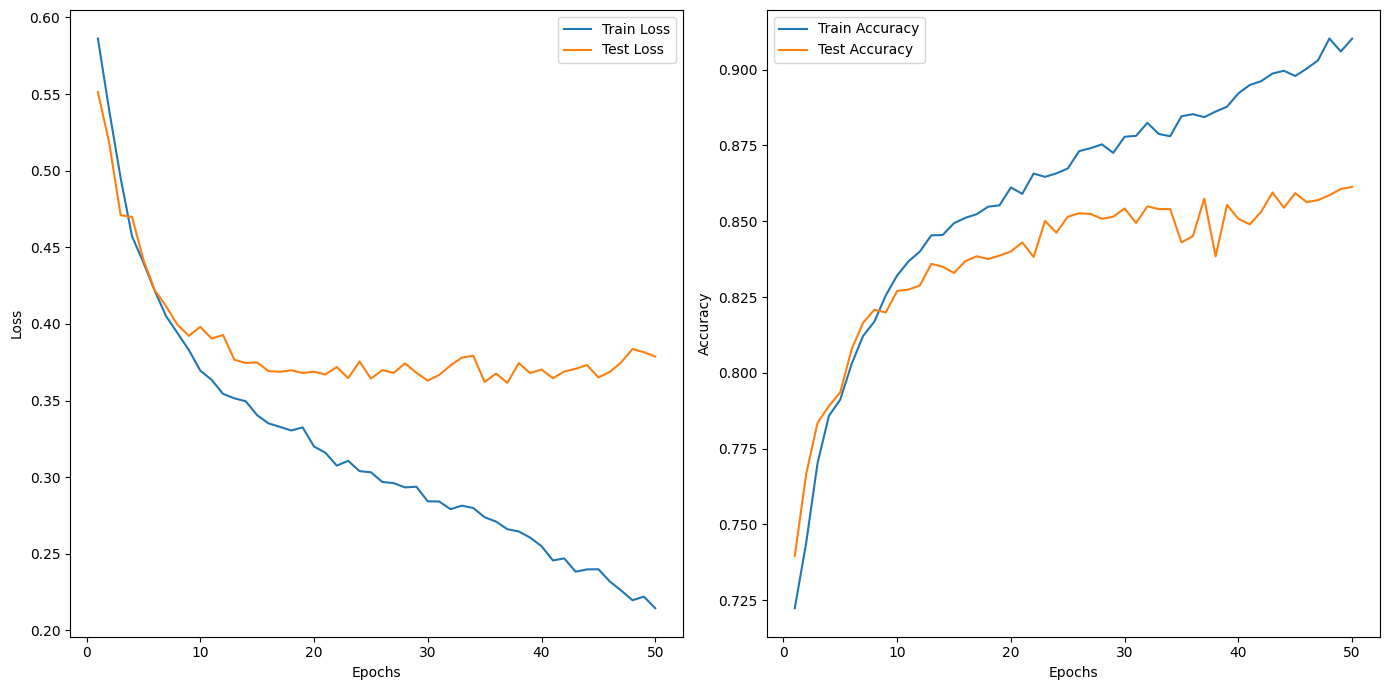

Final Test Accuracy: 0.5389
Classification Report:
              precision    recall  f1-score   support

          CD       0.75      0.56      0.64       212
         HYP       0.75      0.35      0.48       115
          MI       0.77      0.53      0.63       205
        NORM       0.81      0.88      0.84       392
        STTC       0.77      0.59      0.67       214

   micro avg       0.78      0.65      0.71      1138
   macro avg       0.77      0.58      0.65      1138
weighted avg       0.78      0.65      0.70      1138
 samples avg       0.70      0.67      0.67      1138



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


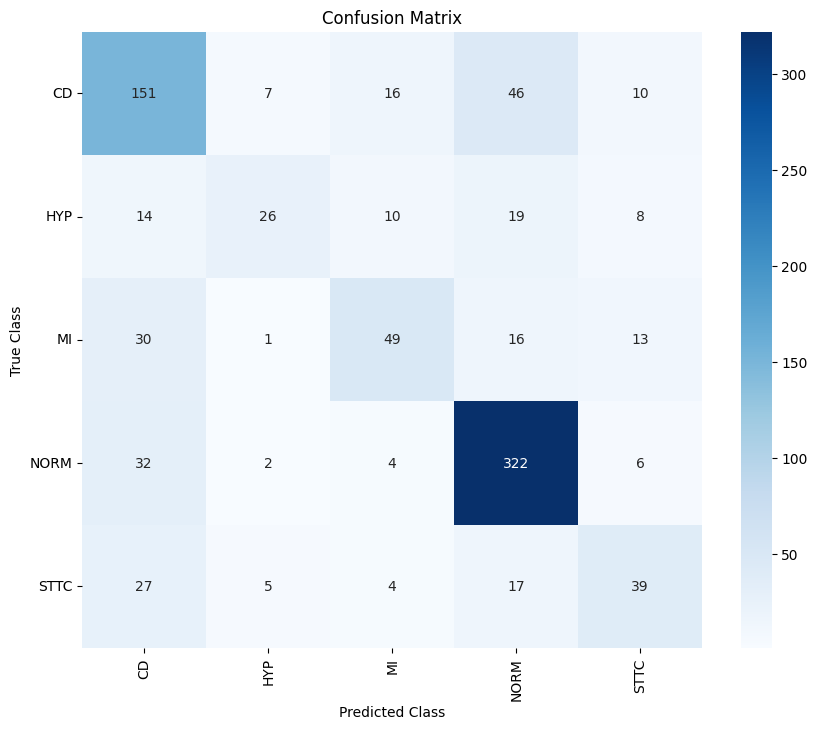

Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model using transfer learning
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Convolution and pooling layers
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Sample only 20% of the data
Y_sampled = Y.sample(frac=0.2, random_state=42)

# Load raw ECG signal data for 100 Hz using parallel loading (only 20% of data)
X_100Hz = load_raw_data_100hz_parallel(Y_sampled, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y_sampled['diagnostic_superclass'] = Y_sampled['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y_sampled['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGTransferCNN(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar for training
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("Data processing, training, and evaluation completed.")


Load and use 50% datas

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 10918/10918 [00:44<00:00, 244.95it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 10918 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (10918, 5)
Splitting data into training and test sets...
Training set size: 8734 samples
Test set size: 2184 samples


Epoch 1/50: 100%|██████████| 137/137 [00:01<00:00, 119.79it/s]


Epoch 1/50, Train Loss: 0.5553, Test Loss: 0.4933, Train Acc: 0.7376, Test Acc: 0.7659


Epoch 2/50: 100%|██████████| 137/137 [00:01<00:00, 135.92it/s]


Epoch 2/50, Train Loss: 0.4729, Test Loss: 0.4545, Train Acc: 0.7807, Test Acc: 0.7888


Epoch 3/50: 100%|██████████| 137/137 [00:01<00:00, 135.44it/s]


Epoch 3/50, Train Loss: 0.4336, Test Loss: 0.4020, Train Acc: 0.7981, Test Acc: 0.8149


Epoch 4/50: 100%|██████████| 137/137 [00:00<00:00, 137.31it/s]


Epoch 4/50, Train Loss: 0.4064, Test Loss: 0.3783, Train Acc: 0.8137, Test Acc: 0.8318


Epoch 5/50: 100%|██████████| 137/137 [00:01<00:00, 136.46it/s]


Epoch 5/50, Train Loss: 0.3845, Test Loss: 0.3639, Train Acc: 0.8263, Test Acc: 0.8355


Epoch 6/50: 100%|██████████| 137/137 [00:00<00:00, 137.65it/s]


Epoch 6/50, Train Loss: 0.3711, Test Loss: 0.3559, Train Acc: 0.8362, Test Acc: 0.8448


Epoch 7/50: 100%|██████████| 137/137 [00:01<00:00, 136.44it/s]


Epoch 7/50, Train Loss: 0.3635, Test Loss: 0.3500, Train Acc: 0.8405, Test Acc: 0.8434


Epoch 8/50: 100%|██████████| 137/137 [00:01<00:00, 135.42it/s]


Epoch 8/50, Train Loss: 0.3546, Test Loss: 0.3386, Train Acc: 0.8445, Test Acc: 0.8526


Epoch 9/50: 100%|██████████| 137/137 [00:01<00:00, 136.25it/s]


Epoch 9/50, Train Loss: 0.3481, Test Loss: 0.3455, Train Acc: 0.8474, Test Acc: 0.8493


Epoch 10/50: 100%|██████████| 137/137 [00:01<00:00, 136.07it/s]


Epoch 10/50, Train Loss: 0.3424, Test Loss: 0.3340, Train Acc: 0.8514, Test Acc: 0.8564


Epoch 11/50: 100%|██████████| 137/137 [00:01<00:00, 135.13it/s]


Epoch 11/50, Train Loss: 0.3354, Test Loss: 0.3345, Train Acc: 0.8543, Test Acc: 0.8573


Epoch 12/50: 100%|██████████| 137/137 [00:01<00:00, 135.38it/s]


Epoch 12/50, Train Loss: 0.3347, Test Loss: 0.3292, Train Acc: 0.8526, Test Acc: 0.8589


Epoch 13/50: 100%|██████████| 137/137 [00:01<00:00, 134.31it/s]


Epoch 13/50, Train Loss: 0.3313, Test Loss: 0.3266, Train Acc: 0.8556, Test Acc: 0.8616


Epoch 14/50: 100%|██████████| 137/137 [00:01<00:00, 133.91it/s]


Epoch 14/50, Train Loss: 0.3219, Test Loss: 0.3245, Train Acc: 0.8617, Test Acc: 0.8614


Epoch 15/50: 100%|██████████| 137/137 [00:01<00:00, 134.99it/s]


Epoch 15/50, Train Loss: 0.3201, Test Loss: 0.3280, Train Acc: 0.8612, Test Acc: 0.8589


Epoch 16/50: 100%|██████████| 137/137 [00:01<00:00, 135.31it/s]


Epoch 16/50, Train Loss: 0.3174, Test Loss: 0.3214, Train Acc: 0.8634, Test Acc: 0.8637


Epoch 17/50: 100%|██████████| 137/137 [00:01<00:00, 135.23it/s]


Epoch 17/50, Train Loss: 0.3108, Test Loss: 0.3147, Train Acc: 0.8668, Test Acc: 0.8657


Epoch 18/50: 100%|██████████| 137/137 [00:01<00:00, 134.80it/s]


Epoch 18/50, Train Loss: 0.3071, Test Loss: 0.3139, Train Acc: 0.8692, Test Acc: 0.8689


Epoch 19/50: 100%|██████████| 137/137 [00:01<00:00, 134.67it/s]


Epoch 19/50, Train Loss: 0.3061, Test Loss: 0.3128, Train Acc: 0.8688, Test Acc: 0.8684


Epoch 20/50: 100%|██████████| 137/137 [00:01<00:00, 134.49it/s]


Epoch 20/50, Train Loss: 0.3015, Test Loss: 0.3115, Train Acc: 0.8717, Test Acc: 0.8687


Epoch 21/50: 100%|██████████| 137/137 [00:01<00:00, 134.30it/s]


Epoch 21/50, Train Loss: 0.2952, Test Loss: 0.3189, Train Acc: 0.8752, Test Acc: 0.8678


Epoch 22/50: 100%|██████████| 137/137 [00:01<00:00, 134.88it/s]


Epoch 22/50, Train Loss: 0.2906, Test Loss: 0.3109, Train Acc: 0.8749, Test Acc: 0.8712


Epoch 23/50: 100%|██████████| 137/137 [00:01<00:00, 134.24it/s]


Epoch 23/50, Train Loss: 0.2851, Test Loss: 0.3080, Train Acc: 0.8800, Test Acc: 0.8702


Epoch 24/50: 100%|██████████| 137/137 [00:01<00:00, 134.15it/s]


Epoch 24/50, Train Loss: 0.2832, Test Loss: 0.3071, Train Acc: 0.8798, Test Acc: 0.8708


Epoch 25/50: 100%|██████████| 137/137 [00:01<00:00, 132.33it/s]


Epoch 25/50, Train Loss: 0.2779, Test Loss: 0.3050, Train Acc: 0.8826, Test Acc: 0.8731


Epoch 26/50: 100%|██████████| 137/137 [00:01<00:00, 134.54it/s]


Epoch 26/50, Train Loss: 0.2747, Test Loss: 0.3036, Train Acc: 0.8833, Test Acc: 0.8718


Epoch 27/50: 100%|██████████| 137/137 [00:01<00:00, 132.86it/s]


Epoch 27/50, Train Loss: 0.2719, Test Loss: 0.3154, Train Acc: 0.8864, Test Acc: 0.8654


Epoch 28/50: 100%|██████████| 137/137 [00:01<00:00, 135.27it/s]


Epoch 28/50, Train Loss: 0.2668, Test Loss: 0.3245, Train Acc: 0.8892, Test Acc: 0.8670


Epoch 29/50: 100%|██████████| 137/137 [00:01<00:00, 135.65it/s]


Epoch 29/50, Train Loss: 0.2667, Test Loss: 0.3082, Train Acc: 0.8891, Test Acc: 0.8711


Epoch 30/50: 100%|██████████| 137/137 [00:01<00:00, 133.31it/s]


Epoch 30/50, Train Loss: 0.2590, Test Loss: 0.3044, Train Acc: 0.8897, Test Acc: 0.8731


Epoch 31/50: 100%|██████████| 137/137 [00:01<00:00, 131.73it/s]


Epoch 31/50, Train Loss: 0.2562, Test Loss: 0.3086, Train Acc: 0.8929, Test Acc: 0.8736


Epoch 32/50: 100%|██████████| 137/137 [00:01<00:00, 133.88it/s]


Epoch 32/50, Train Loss: 0.2502, Test Loss: 0.3089, Train Acc: 0.8951, Test Acc: 0.8703


Epoch 33/50: 100%|██████████| 137/137 [00:01<00:00, 131.65it/s]


Epoch 33/50, Train Loss: 0.2484, Test Loss: 0.3030, Train Acc: 0.8966, Test Acc: 0.8747


Epoch 34/50: 100%|██████████| 137/137 [00:01<00:00, 130.42it/s]


Epoch 34/50, Train Loss: 0.2456, Test Loss: 0.3045, Train Acc: 0.8963, Test Acc: 0.8727


Epoch 35/50: 100%|██████████| 137/137 [00:01<00:00, 129.20it/s]


Epoch 35/50, Train Loss: 0.2398, Test Loss: 0.3079, Train Acc: 0.9010, Test Acc: 0.8755


Epoch 36/50: 100%|██████████| 137/137 [00:01<00:00, 132.75it/s]


Epoch 36/50, Train Loss: 0.2333, Test Loss: 0.3047, Train Acc: 0.9043, Test Acc: 0.8757


Epoch 37/50: 100%|██████████| 137/137 [00:01<00:00, 133.63it/s]


Epoch 37/50, Train Loss: 0.2298, Test Loss: 0.3216, Train Acc: 0.9056, Test Acc: 0.8714


Epoch 38/50: 100%|██████████| 137/137 [00:01<00:00, 135.54it/s]


Epoch 38/50, Train Loss: 0.2308, Test Loss: 0.3150, Train Acc: 0.9047, Test Acc: 0.8741


Epoch 39/50: 100%|██████████| 137/137 [00:01<00:00, 136.71it/s]


Epoch 39/50, Train Loss: 0.2249, Test Loss: 0.3119, Train Acc: 0.9061, Test Acc: 0.8735


Epoch 40/50: 100%|██████████| 137/137 [00:01<00:00, 135.71it/s]


Epoch 40/50, Train Loss: 0.2189, Test Loss: 0.3096, Train Acc: 0.9105, Test Acc: 0.8734


Epoch 41/50: 100%|██████████| 137/137 [00:01<00:00, 134.23it/s]


Epoch 41/50, Train Loss: 0.2207, Test Loss: 0.3136, Train Acc: 0.9087, Test Acc: 0.8729


Epoch 42/50: 100%|██████████| 137/137 [00:01<00:00, 136.70it/s]


Epoch 42/50, Train Loss: 0.2137, Test Loss: 0.3105, Train Acc: 0.9126, Test Acc: 0.8737


Epoch 43/50: 100%|██████████| 137/137 [00:01<00:00, 135.88it/s]


Epoch 43/50, Train Loss: 0.2119, Test Loss: 0.3152, Train Acc: 0.9130, Test Acc: 0.8749


Epoch 44/50: 100%|██████████| 137/137 [00:01<00:00, 136.95it/s]


Epoch 44/50, Train Loss: 0.2090, Test Loss: 0.3130, Train Acc: 0.9139, Test Acc: 0.8749


Epoch 45/50: 100%|██████████| 137/137 [00:01<00:00, 134.00it/s]


Epoch 45/50, Train Loss: 0.2088, Test Loss: 0.3214, Train Acc: 0.9144, Test Acc: 0.8731


Epoch 46/50: 100%|██████████| 137/137 [00:01<00:00, 134.01it/s]


Epoch 46/50, Train Loss: 0.2006, Test Loss: 0.3194, Train Acc: 0.9171, Test Acc: 0.8729


Epoch 47/50: 100%|██████████| 137/137 [00:00<00:00, 137.31it/s]


Epoch 47/50, Train Loss: 0.1984, Test Loss: 0.3314, Train Acc: 0.9195, Test Acc: 0.8711


Epoch 48/50: 100%|██████████| 137/137 [00:01<00:00, 135.21it/s]


Epoch 48/50, Train Loss: 0.1956, Test Loss: 0.3232, Train Acc: 0.9204, Test Acc: 0.8737


Epoch 49/50: 100%|██████████| 137/137 [00:01<00:00, 135.78it/s]


Epoch 49/50, Train Loss: 0.1916, Test Loss: 0.3277, Train Acc: 0.9209, Test Acc: 0.8691


Epoch 50/50: 100%|██████████| 137/137 [00:00<00:00, 137.97it/s]


Epoch 50/50, Train Loss: 0.1870, Test Loss: 0.3305, Train Acc: 0.9237, Test Acc: 0.8748


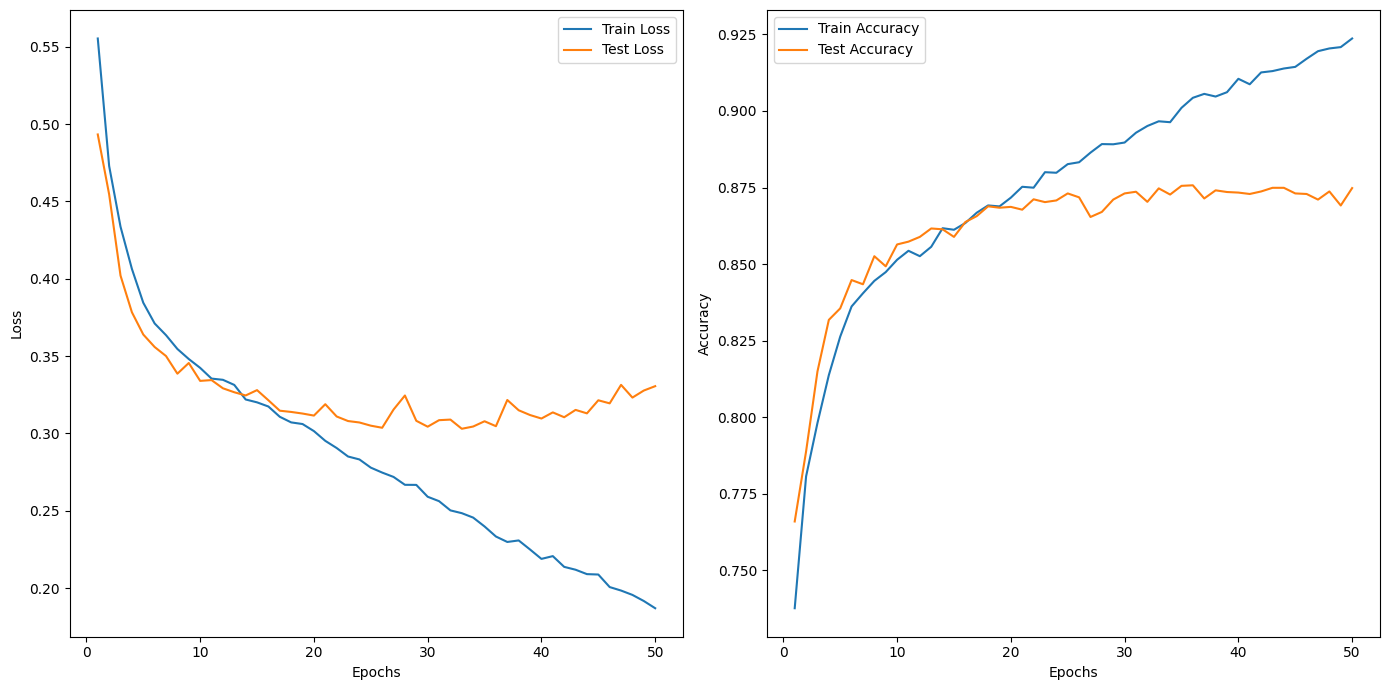

Final Test Accuracy: 0.5733
Classification Report:
              precision    recall  f1-score   support

          CD       0.84      0.63      0.72       494
         HYP       0.75      0.28      0.41       236
          MI       0.70      0.68      0.69       562
        NORM       0.85      0.85      0.85       976
        STTC       0.77      0.60      0.68       510

   micro avg       0.80      0.68      0.74      2778
   macro avg       0.78      0.61      0.67      2778
weighted avg       0.79      0.68      0.73      2778
 samples avg       0.73      0.70      0.70      2778



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


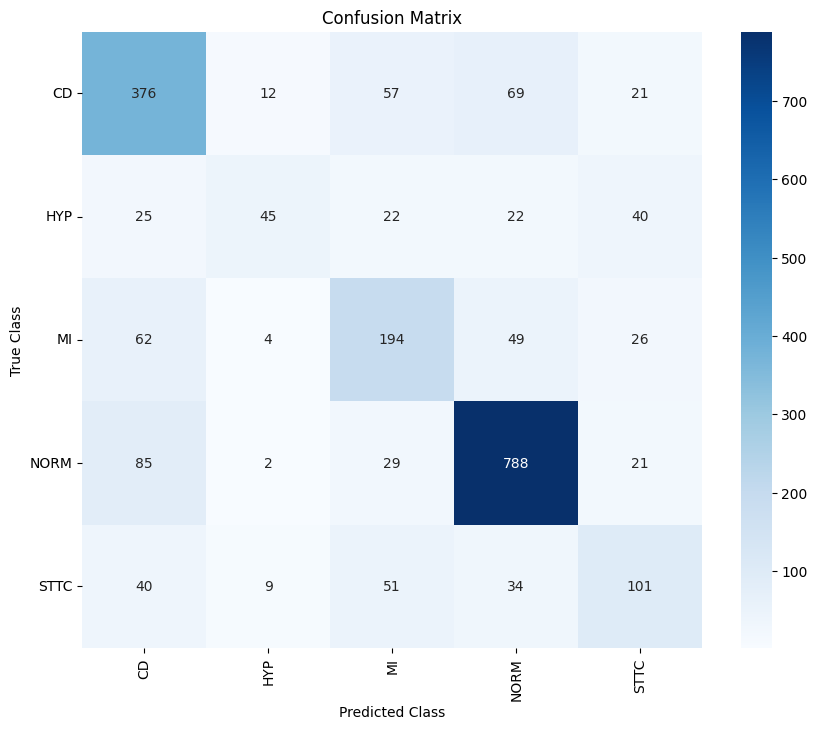

Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model using transfer learning
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Convolution and pooling layers
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Sample only 50% of the data (changed from 20% to 50%)
Y_sampled = Y.sample(frac=0.5, random_state=42)

# Load raw ECG signal data for 100 Hz using parallel loading (only 50% of data)
X_100Hz = load_raw_data_100hz_parallel(Y_sampled, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y_sampled['diagnostic_superclass'] = Y_sampled['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y_sampled['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGTransferCNN(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 50
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Add tqdm progress bar for training
    with tqdm(total=len(train_loader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    # Validation loop
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Train Acc: {train_accuracy:.4f}, Test Acc: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("Data processing, training, and evaluation completed.")


CNN Load and use 100% datas

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [45:30<00:00,  8.00it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Training set standard deviation: 0.23364261164281808
Test set standard deviation: 0.2317493984831071
Input shape size for the model: (17469, 500, 12)
Model Summary:
ECGTransferCNN(
  (conv1): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,))
  (conv2): Conv1d(64, 128, kernel_size=(5,), stride=(1,), padding=(2,))
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=(1,))
  (maxpool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (dropou

Training Epoch 1/100: 100%|██████████| 273/273 [00:02<00:00, 111.25it/s]


End of Epoch 1: Train Loss: 0.5108, Train Accuracy: 0.7608
End of Epoch 1: Test Loss: 0.4409, Test Accuracy: 0.7949
Model saved with Test Accuracy: 0.7949

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:02<00:00, 135.58it/s]


End of Epoch 2: Train Loss: 0.4150, Train Accuracy: 0.8110
End of Epoch 2: Test Loss: 0.3721, Test Accuracy: 0.8385
Model saved with Test Accuracy: 0.8385

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:02<00:00, 135.80it/s]


End of Epoch 3: Train Loss: 0.3774, Train Accuracy: 0.8328
End of Epoch 3: Test Loss: 0.3519, Test Accuracy: 0.8468
Model saved with Test Accuracy: 0.8468

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:02<00:00, 135.00it/s]


End of Epoch 4: Train Loss: 0.3601, Train Accuracy: 0.8418
End of Epoch 4: Test Loss: 0.3427, Test Accuracy: 0.8523
Model saved with Test Accuracy: 0.8523

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:02<00:00, 135.44it/s]


End of Epoch 5: Train Loss: 0.3512, Train Accuracy: 0.8479
End of Epoch 5: Test Loss: 0.3352, Test Accuracy: 0.8568
Model saved with Test Accuracy: 0.8568

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:02<00:00, 133.30it/s]


End of Epoch 6: Train Loss: 0.3429, Train Accuracy: 0.8517
End of Epoch 6: Test Loss: 0.3306, Test Accuracy: 0.8604
Model saved with Test Accuracy: 0.8604

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:02<00:00, 133.88it/s]


End of Epoch 7: Train Loss: 0.3338, Train Accuracy: 0.8583
End of Epoch 7: Test Loss: 0.3201, Test Accuracy: 0.8651
Model saved with Test Accuracy: 0.8651

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:02<00:00, 134.88it/s]


End of Epoch 8: Train Loss: 0.3271, Train Accuracy: 0.8598
End of Epoch 8: Test Loss: 0.3187, Test Accuracy: 0.8640

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:02<00:00, 135.23it/s]


End of Epoch 9: Train Loss: 0.3226, Train Accuracy: 0.8638
End of Epoch 9: Test Loss: 0.3122, Test Accuracy: 0.8671
Model saved with Test Accuracy: 0.8671

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:02<00:00, 134.47it/s]


End of Epoch 10: Train Loss: 0.3159, Train Accuracy: 0.8657
End of Epoch 10: Test Loss: 0.3123, Test Accuracy: 0.8668

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:02<00:00, 133.27it/s]


End of Epoch 11: Train Loss: 0.3078, Train Accuracy: 0.8704
End of Epoch 11: Test Loss: 0.3068, Test Accuracy: 0.8695
Model saved with Test Accuracy: 0.8695

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:02<00:00, 134.59it/s]


End of Epoch 12: Train Loss: 0.3036, Train Accuracy: 0.8721
End of Epoch 12: Test Loss: 0.3169, Test Accuracy: 0.8678

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:02<00:00, 133.87it/s]


End of Epoch 13: Train Loss: 0.2990, Train Accuracy: 0.8756
End of Epoch 13: Test Loss: 0.2976, Test Accuracy: 0.8748
Model saved with Test Accuracy: 0.8748

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:02<00:00, 134.62it/s]


End of Epoch 14: Train Loss: 0.2948, Train Accuracy: 0.8775
End of Epoch 14: Test Loss: 0.2948, Test Accuracy: 0.8747

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:02<00:00, 134.17it/s]


End of Epoch 15: Train Loss: 0.2916, Train Accuracy: 0.8791
End of Epoch 15: Test Loss: 0.2956, Test Accuracy: 0.8753
Model saved with Test Accuracy: 0.8753

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:02<00:00, 132.38it/s]


End of Epoch 16: Train Loss: 0.2865, Train Accuracy: 0.8817
End of Epoch 16: Test Loss: 0.2925, Test Accuracy: 0.8769
Model saved with Test Accuracy: 0.8769

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:02<00:00, 133.26it/s]


End of Epoch 17: Train Loss: 0.2824, Train Accuracy: 0.8833
End of Epoch 17: Test Loss: 0.2962, Test Accuracy: 0.8748

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:02<00:00, 132.63it/s]


End of Epoch 18: Train Loss: 0.2792, Train Accuracy: 0.8844
End of Epoch 18: Test Loss: 0.2881, Test Accuracy: 0.8784
Model saved with Test Accuracy: 0.8784

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:02<00:00, 132.42it/s]


End of Epoch 19: Train Loss: 0.2740, Train Accuracy: 0.8881
End of Epoch 19: Test Loss: 0.2898, Test Accuracy: 0.8775

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:02<00:00, 132.64it/s]


End of Epoch 20: Train Loss: 0.2696, Train Accuracy: 0.8890
End of Epoch 20: Test Loss: 0.2914, Test Accuracy: 0.8775

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:02<00:00, 130.38it/s]


End of Epoch 21: Train Loss: 0.2660, Train Accuracy: 0.8904
End of Epoch 21: Test Loss: 0.2956, Test Accuracy: 0.8769

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:02<00:00, 130.97it/s]


End of Epoch 22: Train Loss: 0.2625, Train Accuracy: 0.8930
End of Epoch 22: Test Loss: 0.2843, Test Accuracy: 0.8813
Model saved with Test Accuracy: 0.8813

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:02<00:00, 132.77it/s]


End of Epoch 23: Train Loss: 0.2585, Train Accuracy: 0.8939
End of Epoch 23: Test Loss: 0.2833, Test Accuracy: 0.8814
Model saved with Test Accuracy: 0.8814

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:02<00:00, 131.58it/s]


End of Epoch 24: Train Loss: 0.2560, Train Accuracy: 0.8960
End of Epoch 24: Test Loss: 0.2908, Test Accuracy: 0.8793

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:02<00:00, 131.56it/s]


End of Epoch 25: Train Loss: 0.2517, Train Accuracy: 0.8965
End of Epoch 25: Test Loss: 0.2863, Test Accuracy: 0.8810

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:02<00:00, 129.44it/s]


End of Epoch 26: Train Loss: 0.2503, Train Accuracy: 0.8967
End of Epoch 26: Test Loss: 0.2855, Test Accuracy: 0.8809

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:02<00:00, 129.23it/s]


End of Epoch 27: Train Loss: 0.2437, Train Accuracy: 0.8995
End of Epoch 27: Test Loss: 0.2921, Test Accuracy: 0.8796

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:02<00:00, 130.25it/s]


End of Epoch 28: Train Loss: 0.2402, Train Accuracy: 0.9019
End of Epoch 28: Test Loss: 0.2883, Test Accuracy: 0.8817
Model saved with Test Accuracy: 0.8817

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:02<00:00, 130.17it/s]


End of Epoch 29: Train Loss: 0.2367, Train Accuracy: 0.9032
End of Epoch 29: Test Loss: 0.2867, Test Accuracy: 0.8822
Model saved with Test Accuracy: 0.8822

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:02<00:00, 130.81it/s]


End of Epoch 30: Train Loss: 0.2324, Train Accuracy: 0.9054
End of Epoch 30: Test Loss: 0.2921, Test Accuracy: 0.8800

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:02<00:00, 129.34it/s]


End of Epoch 31: Train Loss: 0.2280, Train Accuracy: 0.9078
End of Epoch 31: Test Loss: 0.2880, Test Accuracy: 0.8821

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:02<00:00, 128.65it/s]


End of Epoch 32: Train Loss: 0.2250, Train Accuracy: 0.9082
End of Epoch 32: Test Loss: 0.2890, Test Accuracy: 0.8808

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:02<00:00, 130.89it/s]


End of Epoch 33: Train Loss: 0.2214, Train Accuracy: 0.9092
End of Epoch 33: Test Loss: 0.2883, Test Accuracy: 0.8823
Model saved with Test Accuracy: 0.8823

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:02<00:00, 129.71it/s]


End of Epoch 34: Train Loss: 0.2180, Train Accuracy: 0.9122
End of Epoch 34: Test Loss: 0.2899, Test Accuracy: 0.8799

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:02<00:00, 130.84it/s]


End of Epoch 35: Train Loss: 0.2142, Train Accuracy: 0.9136
End of Epoch 35: Test Loss: 0.3005, Test Accuracy: 0.8788

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:02<00:00, 130.10it/s]


End of Epoch 36: Train Loss: 0.2114, Train Accuracy: 0.9141
End of Epoch 36: Test Loss: 0.2938, Test Accuracy: 0.8783

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:02<00:00, 127.90it/s]


End of Epoch 37: Train Loss: 0.2080, Train Accuracy: 0.9148
End of Epoch 37: Test Loss: 0.2935, Test Accuracy: 0.8800

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:02<00:00, 128.95it/s]


End of Epoch 38: Train Loss: 0.2020, Train Accuracy: 0.9186
End of Epoch 38: Test Loss: 0.2940, Test Accuracy: 0.8804

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:02<00:00, 128.94it/s]


End of Epoch 39: Train Loss: 0.2037, Train Accuracy: 0.9168
End of Epoch 39: Test Loss: 0.2953, Test Accuracy: 0.8810

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:02<00:00, 128.39it/s]


End of Epoch 40: Train Loss: 0.1995, Train Accuracy: 0.9196
End of Epoch 40: Test Loss: 0.2997, Test Accuracy: 0.8805

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:02<00:00, 128.34it/s]


End of Epoch 41: Train Loss: 0.1946, Train Accuracy: 0.9208
End of Epoch 41: Test Loss: 0.3036, Test Accuracy: 0.8796

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:02<00:00, 127.52it/s]


End of Epoch 42: Train Loss: 0.1913, Train Accuracy: 0.9223
End of Epoch 42: Test Loss: 0.3061, Test Accuracy: 0.8762

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:02<00:00, 128.06it/s]


End of Epoch 43: Train Loss: 0.1888, Train Accuracy: 0.9236
End of Epoch 43: Test Loss: 0.3116, Test Accuracy: 0.8762

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:02<00:00, 129.17it/s]


End of Epoch 44: Train Loss: 0.1862, Train Accuracy: 0.9250
End of Epoch 44: Test Loss: 0.3098, Test Accuracy: 0.8789

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:02<00:00, 129.78it/s]


End of Epoch 45: Train Loss: 0.1841, Train Accuracy: 0.9258
End of Epoch 45: Test Loss: 0.3117, Test Accuracy: 0.8800

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:02<00:00, 129.02it/s]


End of Epoch 46: Train Loss: 0.1833, Train Accuracy: 0.9256
End of Epoch 46: Test Loss: 0.3137, Test Accuracy: 0.8784

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:02<00:00, 129.25it/s]


End of Epoch 47: Train Loss: 0.1788, Train Accuracy: 0.9285
End of Epoch 47: Test Loss: 0.3196, Test Accuracy: 0.8773

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:02<00:00, 129.24it/s]


End of Epoch 48: Train Loss: 0.1761, Train Accuracy: 0.9292
End of Epoch 48: Test Loss: 0.3147, Test Accuracy: 0.8794

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:02<00:00, 130.07it/s]


End of Epoch 49: Train Loss: 0.1736, Train Accuracy: 0.9308
End of Epoch 49: Test Loss: 0.3179, Test Accuracy: 0.8790

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:02<00:00, 130.45it/s]


End of Epoch 50: Train Loss: 0.1679, Train Accuracy: 0.9331
End of Epoch 50: Test Loss: 0.3204, Test Accuracy: 0.8800

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:02<00:00, 129.36it/s]


End of Epoch 51: Train Loss: 0.1662, Train Accuracy: 0.9334
End of Epoch 51: Test Loss: 0.3222, Test Accuracy: 0.8796

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:02<00:00, 128.87it/s]


End of Epoch 52: Train Loss: 0.1653, Train Accuracy: 0.9335
End of Epoch 52: Test Loss: 0.3216, Test Accuracy: 0.8785

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:02<00:00, 130.63it/s]


End of Epoch 53: Train Loss: 0.1604, Train Accuracy: 0.9353
End of Epoch 53: Test Loss: 0.3440, Test Accuracy: 0.8786

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:02<00:00, 129.90it/s]


End of Epoch 54: Train Loss: 0.1590, Train Accuracy: 0.9356
End of Epoch 54: Test Loss: 0.3278, Test Accuracy: 0.8790

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:02<00:00, 130.39it/s]


End of Epoch 55: Train Loss: 0.1576, Train Accuracy: 0.9364
End of Epoch 55: Test Loss: 0.3323, Test Accuracy: 0.8796

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:02<00:00, 129.46it/s]


End of Epoch 56: Train Loss: 0.1542, Train Accuracy: 0.9377
End of Epoch 56: Test Loss: 0.3316, Test Accuracy: 0.8756

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:02<00:00, 128.37it/s]


End of Epoch 57: Train Loss: 0.1533, Train Accuracy: 0.9391
End of Epoch 57: Test Loss: 0.3303, Test Accuracy: 0.8788

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:02<00:00, 130.65it/s]


End of Epoch 58: Train Loss: 0.1525, Train Accuracy: 0.9406
End of Epoch 58: Test Loss: 0.3309, Test Accuracy: 0.8785

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:02<00:00, 129.91it/s]


End of Epoch 59: Train Loss: 0.1493, Train Accuracy: 0.9395
End of Epoch 59: Test Loss: 0.3394, Test Accuracy: 0.8765

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:02<00:00, 130.33it/s]


End of Epoch 60: Train Loss: 0.1486, Train Accuracy: 0.9398
End of Epoch 60: Test Loss: 0.3460, Test Accuracy: 0.8774

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:02<00:00, 129.89it/s]


End of Epoch 61: Train Loss: 0.1456, Train Accuracy: 0.9414
End of Epoch 61: Test Loss: 0.3386, Test Accuracy: 0.8757

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:02<00:00, 130.18it/s]


End of Epoch 62: Train Loss: 0.1427, Train Accuracy: 0.9426
End of Epoch 62: Test Loss: 0.3480, Test Accuracy: 0.8777

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:02<00:00, 130.47it/s]


End of Epoch 63: Train Loss: 0.1430, Train Accuracy: 0.9431
End of Epoch 63: Test Loss: 0.3548, Test Accuracy: 0.8785

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:02<00:00, 131.09it/s]


End of Epoch 64: Train Loss: 0.1416, Train Accuracy: 0.9425
End of Epoch 64: Test Loss: 0.3637, Test Accuracy: 0.8731

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:02<00:00, 131.16it/s]


End of Epoch 65: Train Loss: 0.1393, Train Accuracy: 0.9433
End of Epoch 65: Test Loss: 0.3494, Test Accuracy: 0.8777

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:02<00:00, 131.22it/s]


End of Epoch 66: Train Loss: 0.1364, Train Accuracy: 0.9456
End of Epoch 66: Test Loss: 0.3539, Test Accuracy: 0.8787

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:02<00:00, 130.12it/s]


End of Epoch 67: Train Loss: 0.1356, Train Accuracy: 0.9455
End of Epoch 67: Test Loss: 0.3629, Test Accuracy: 0.8792

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:02<00:00, 130.85it/s]


End of Epoch 68: Train Loss: 0.1336, Train Accuracy: 0.9468
End of Epoch 68: Test Loss: 0.3571, Test Accuracy: 0.8769

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:02<00:00, 130.39it/s]


End of Epoch 69: Train Loss: 0.1338, Train Accuracy: 0.9461
End of Epoch 69: Test Loss: 0.3704, Test Accuracy: 0.8782

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:02<00:00, 131.08it/s]


End of Epoch 70: Train Loss: 0.1300, Train Accuracy: 0.9480
End of Epoch 70: Test Loss: 0.3725, Test Accuracy: 0.8795

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:02<00:00, 131.45it/s]


End of Epoch 71: Train Loss: 0.1282, Train Accuracy: 0.9491
End of Epoch 71: Test Loss: 0.3678, Test Accuracy: 0.8791

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:02<00:00, 129.96it/s]


End of Epoch 72: Train Loss: 0.1273, Train Accuracy: 0.9489
End of Epoch 72: Test Loss: 0.3660, Test Accuracy: 0.8792

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:02<00:00, 130.16it/s]


End of Epoch 73: Train Loss: 0.1268, Train Accuracy: 0.9488
End of Epoch 73: Test Loss: 0.3700, Test Accuracy: 0.8793

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:02<00:00, 131.02it/s]


End of Epoch 74: Train Loss: 0.1263, Train Accuracy: 0.9503
End of Epoch 74: Test Loss: 0.3742, Test Accuracy: 0.8790

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:02<00:00, 130.88it/s]


End of Epoch 75: Train Loss: 0.1259, Train Accuracy: 0.9495
End of Epoch 75: Test Loss: 0.3834, Test Accuracy: 0.8766

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:02<00:00, 129.42it/s]


End of Epoch 76: Train Loss: 0.1229, Train Accuracy: 0.9504
End of Epoch 76: Test Loss: 0.3850, Test Accuracy: 0.8785

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:02<00:00, 129.45it/s]


End of Epoch 77: Train Loss: 0.1201, Train Accuracy: 0.9513
End of Epoch 77: Test Loss: 0.3820, Test Accuracy: 0.8781

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:02<00:00, 129.37it/s]


End of Epoch 78: Train Loss: 0.1207, Train Accuracy: 0.9508
End of Epoch 78: Test Loss: 0.3966, Test Accuracy: 0.8780

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:02<00:00, 130.30it/s]


End of Epoch 79: Train Loss: 0.1191, Train Accuracy: 0.9526
End of Epoch 79: Test Loss: 0.3888, Test Accuracy: 0.8758

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:02<00:00, 129.46it/s]


End of Epoch 80: Train Loss: 0.1165, Train Accuracy: 0.9536
End of Epoch 80: Test Loss: 0.3992, Test Accuracy: 0.8793

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:02<00:00, 129.13it/s]


End of Epoch 81: Train Loss: 0.1174, Train Accuracy: 0.9529
End of Epoch 81: Test Loss: 0.4029, Test Accuracy: 0.8758

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:02<00:00, 129.06it/s]


End of Epoch 82: Train Loss: 0.1132, Train Accuracy: 0.9546
End of Epoch 82: Test Loss: 0.3915, Test Accuracy: 0.8783

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:02<00:00, 129.45it/s]


End of Epoch 83: Train Loss: 0.1153, Train Accuracy: 0.9540
End of Epoch 83: Test Loss: 0.3965, Test Accuracy: 0.8776

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:02<00:00, 130.30it/s]


End of Epoch 84: Train Loss: 0.1143, Train Accuracy: 0.9544
End of Epoch 84: Test Loss: 0.4010, Test Accuracy: 0.8782

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:02<00:00, 130.21it/s]


End of Epoch 85: Train Loss: 0.1123, Train Accuracy: 0.9553
End of Epoch 85: Test Loss: 0.4082, Test Accuracy: 0.8785

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:02<00:00, 130.39it/s]


End of Epoch 86: Train Loss: 0.1102, Train Accuracy: 0.9561
End of Epoch 86: Test Loss: 0.3992, Test Accuracy: 0.8761

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:02<00:00, 130.81it/s]


End of Epoch 87: Train Loss: 0.1127, Train Accuracy: 0.9547
End of Epoch 87: Test Loss: 0.4118, Test Accuracy: 0.8754

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:02<00:00, 128.43it/s]


End of Epoch 88: Train Loss: 0.1104, Train Accuracy: 0.9554
End of Epoch 88: Test Loss: 0.4151, Test Accuracy: 0.8745

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:02<00:00, 131.57it/s]


End of Epoch 89: Train Loss: 0.1123, Train Accuracy: 0.9554
End of Epoch 89: Test Loss: 0.4057, Test Accuracy: 0.8799

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:02<00:00, 130.49it/s]


End of Epoch 90: Train Loss: 0.1067, Train Accuracy: 0.9575
End of Epoch 90: Test Loss: 0.4295, Test Accuracy: 0.8784

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:02<00:00, 129.92it/s]


End of Epoch 91: Train Loss: 0.1076, Train Accuracy: 0.9567
End of Epoch 91: Test Loss: 0.4089, Test Accuracy: 0.8790

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:02<00:00, 130.33it/s]


End of Epoch 92: Train Loss: 0.1066, Train Accuracy: 0.9575
End of Epoch 92: Test Loss: 0.4074, Test Accuracy: 0.8752

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:02<00:00, 129.02it/s]


End of Epoch 93: Train Loss: 0.1057, Train Accuracy: 0.9579
End of Epoch 93: Test Loss: 0.4218, Test Accuracy: 0.8773

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:02<00:00, 128.91it/s]


End of Epoch 94: Train Loss: 0.1069, Train Accuracy: 0.9573
End of Epoch 94: Test Loss: 0.4148, Test Accuracy: 0.8786

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:02<00:00, 129.43it/s]


End of Epoch 95: Train Loss: 0.1039, Train Accuracy: 0.9581
End of Epoch 95: Test Loss: 0.4266, Test Accuracy: 0.8758

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:02<00:00, 129.05it/s]


End of Epoch 96: Train Loss: 0.1035, Train Accuracy: 0.9586
End of Epoch 96: Test Loss: 0.4289, Test Accuracy: 0.8760

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:02<00:00, 129.88it/s]


End of Epoch 97: Train Loss: 0.1045, Train Accuracy: 0.9579
End of Epoch 97: Test Loss: 0.4335, Test Accuracy: 0.8767

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:02<00:00, 129.06it/s]


End of Epoch 98: Train Loss: 0.1047, Train Accuracy: 0.9583
End of Epoch 98: Test Loss: 0.4323, Test Accuracy: 0.8768

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:02<00:00, 130.51it/s]


End of Epoch 99: Train Loss: 0.1021, Train Accuracy: 0.9589
End of Epoch 99: Test Loss: 0.4321, Test Accuracy: 0.8784

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:02<00:00, 130.11it/s]


End of Epoch 100: Train Loss: 0.1028, Train Accuracy: 0.9590
End of Epoch 100: Test Loss: 0.4375, Test Accuracy: 0.8767
Training complete. Saving final model...
Final model saved to /content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth
Training complete. Plotting loss and accuracy curves...


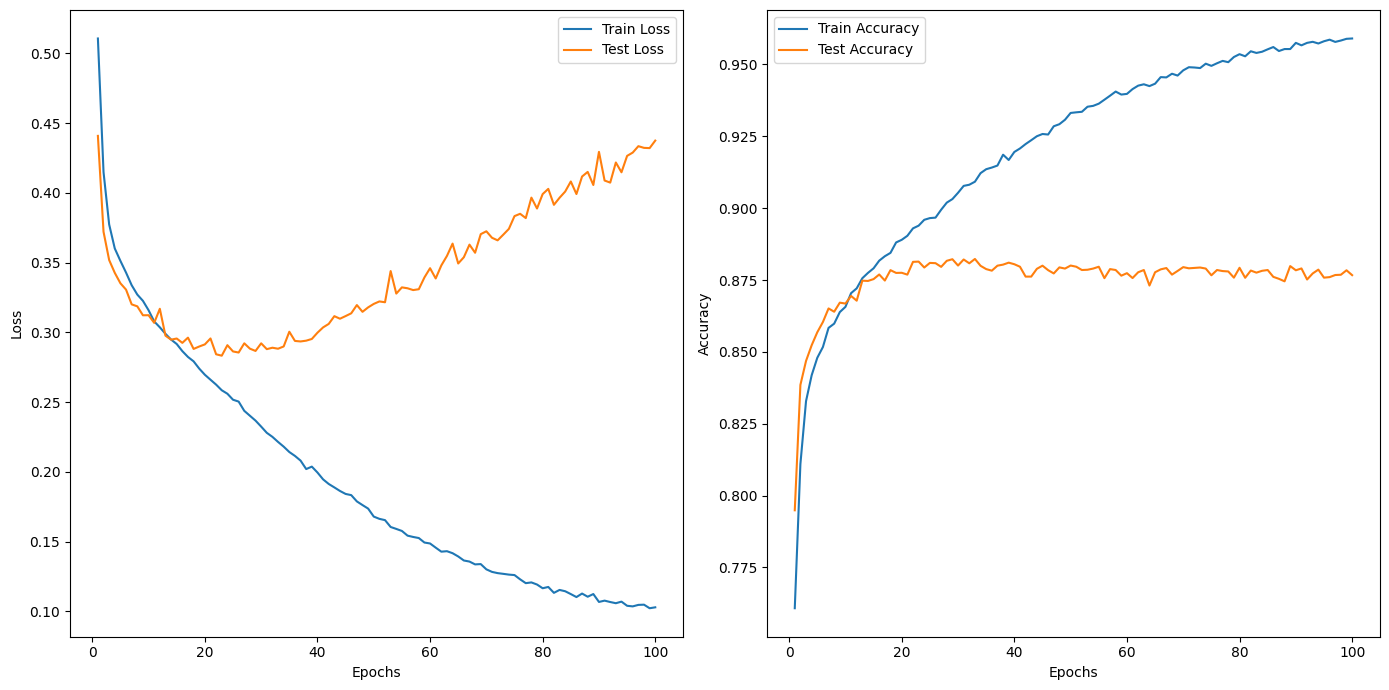

Starting final evaluation on test set...
Final Test Accuracy: 0.5900
Classification Report:
              precision    recall  f1-score   support

          CD       0.81      0.67      0.73      1019
         HYP       0.66      0.46      0.54       519
          MI       0.75      0.70      0.73      1102
        NORM       0.86      0.83      0.84      1906
        STTC       0.74      0.64      0.69      1055

   micro avg       0.79      0.70      0.75      5601
   macro avg       0.76      0.66      0.71      5601
weighted avg       0.79      0.70      0.74      5601
 samples avg       0.74      0.72      0.71      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


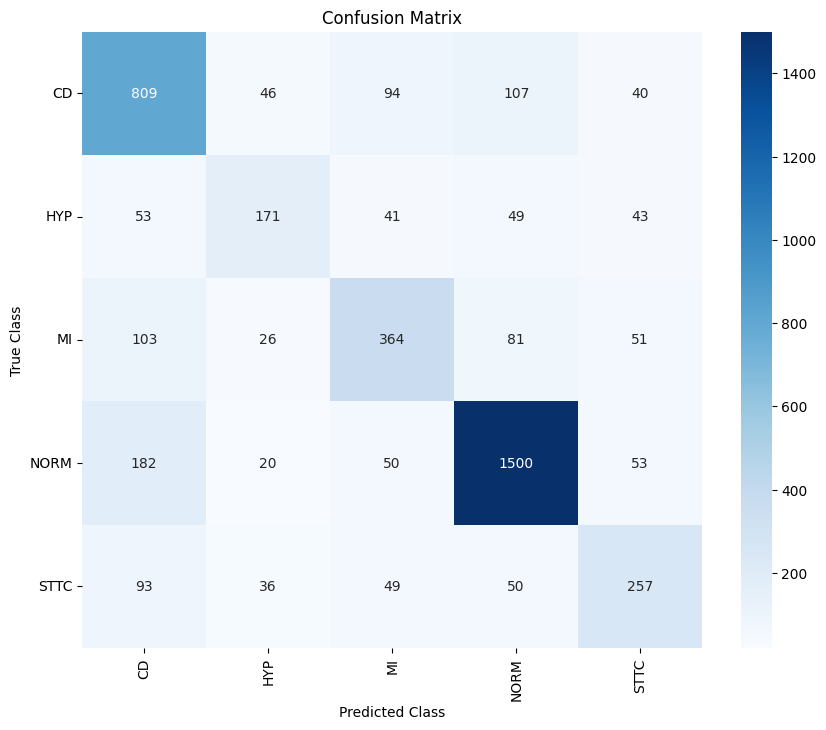

Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model using transfer learning
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

        # Initialize fully connected layers dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Convolution and pooling layers
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load all the data (no sampling)
# Load raw ECG signal data for 100 Hz using parallel loading (using all data)
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and standard deviation
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set standard deviation: {np.std(X_train)}")
print(f"Test set standard deviation: {np.std(X_test)}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ECGTransferCNN(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Model saving path
SAVE_PATH = '/content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth'

# Print input shape size
print(f"Input shape size for the model: {X_train.shape}")

# Print model layers and parameters
print("Model Summary:")
print(model)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
best_accuracy = 0  # Variable to track the best test accuracy
epochs = 100  # Number of epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save the model if test accuracy improves
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, SAVE_PATH)
        print(f"Model saved with Test Accuracy: {test_accuracy:.4f}")

# After training is complete, save the final model
print("Training complete. Saving final model...")
torch.save(model.state_dict(), SAVE_PATH)
print(f"Final model saved to {SAVE_PATH}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("Data processing, training, and evaluation completed.")


CNN-TS model hyperparameter tunning and refining

In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import optuna
from optuna.trial import TrialState

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    filenames = df.filename_lr
    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            return None
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)
    return np.array(data)

# Custom Dataset Class
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model definition with dynamic fully connected layers
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim, dropout_rate):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)
        self.fc1 = None
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))
        x = x.view(x.size(0), -1)
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Function to create and train the model
def train_model(trial, X_train, y_train, X_val, y_val, n_leads, output_dim):
    # Hyperparameters from Optuna
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.6)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)

    # Initialize the model
    model = ECGTransferCNN(input_channels=n_leads, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # DataLoader
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Early stopping parameters
    patience = 10
    best_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss, val_accuracy

# Cross-validation function with Optuna
def cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5):
    skf = StratifiedKFold(n_splits=n_splits)
    study = optuna.create_study(direction="minimize")

    def objective(trial):
        val_losses = []
        val_accuracies = []
        for train_idx, val_idx in skf.split(X, y.argmax(axis=1)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            val_loss, val_accuracy = train_model(trial, X_train, y_train, X_val, y_val, n_leads=n_leads, output_dim=output_dim)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        average_accuracy = np.mean(val_accuracies)
        print(f"Average validation accuracy for this trial: {average_accuracy:.4f}")
        return np.mean(val_losses)

    study.optimize(objective, n_trials=20, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print(f"Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(pruned_trials)}")
    print(f"  Number of complete trials: {len(complete_trials)}")

    best_trial = study.best_trial
    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return best_trial

# Sample dataset preparation function (use real data in practice)
def prepare_sample_data():
    # Placeholder function: Replace this with actual dataset preparation code
    n_samples = 1000
    n_leads = 12
    n_timesteps = 500
    X = np.random.randn(n_samples, n_timesteps, n_leads)
    y = np.random.randint(0, 2, size=(n_samples, 5))
    return X, y

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script execution
if __name__ == "__main__":
    # Prepare sample data (replace with actual ECG dataset loading and preprocessing)
    X, y = prepare_sample_data()

    # Perform cross-validation and hyperparameter optimization using Optuna
    best_trial = cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5)

    print("Finished cross-validation and optimization.")


[I 2024-08-28 10:36:38,388] A new study created in memory with name: no-name-ae03ded1-7732-44fe-bec8-14d5cdde50d8
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13
Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 14


[I 2024-08-28 10:36:47,787] Trial 0 finished with value: 0.7452177667617799 and parameters: {'dropout_rate': 0.3965025237265243, 'lr': 0.007944384930118288}. Best is trial 0 with value: 0.7452177667617799.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.5042


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
[I 2024-08-28 10:36:54,947] Trial 1 finished with value: 0.7158341331481934 and parameters: {'dropout_rate': 0.4093350786545723, 'lr': 0.004296397702514733}. Best is trial 1 with value: 0.7158341331481934.


Early stopping at epoch 17
Average validation accuracy for this trial: 0.5046


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 16
Early stopping at epoch 13


[I 2024-08-28 10:37:01,930] Trial 2 finished with value: 0.7152275338172913 and parameters: {'dropout_rate': 0.2807798714828947, 'lr': 0.0029627246995859147}. Best is trial 2 with value: 0.7152275338172913.


Early stopping at epoch 12
Average validation accuracy for this trial: 0.4918


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 17


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


Early stopping at epoch 16
Early stopping at epoch 16


[I 2024-08-28 10:37:09,791] Trial 3 finished with value: 0.7215818066596984 and parameters: {'dropout_rate': 0.5036697645580439, 'lr': 0.009808761207614881}. Best is trial 2 with value: 0.7152275338172913.


Early stopping at epoch 16
Average validation accuracy for this trial: 0.5034


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
[I 2024-08-28 10:37:16,901] Trial 4 finished with value: 0.785340838432312 and parameters: {'dropout_rate': 0.20952405209313923, 'lr': 0.008321969261858546}. Best is trial 2 with value: 0.7152275338172913.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:17,043] Trial 5 pruned. 


Early stopping at epoch 15
Average validation accuracy for this trial: 0.5044


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:17,284] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:17,528] Trial 7 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:17,667] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbo

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12
Early stopping at epoch 11
Early stopping at epoch 12


[I 2024-08-28 10:37:23,736] Trial 9 finished with value: 0.7105495066642761 and parameters: {'dropout_rate': 0.3357528110358869, 'lr': 0.007733681819143332}. Best is trial 9 with value: 0.7105495066642761.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4998


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 16
Early stopping at epoch 13


[I 2024-08-28 10:37:30,901] Trial 10 finished with value: 0.7136511712074279 and parameters: {'dropout_rate': 0.36246579386494, 'lr': 0.00651538376221047}. Best is trial 9 with value: 0.7105495066642761.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:31,043] Trial 11 pruned. 


Early stopping at epoch 12
Average validation accuracy for this trial: 0.5144


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:31,186] Trial 12 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:31,330] Trial 13 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12
Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 15


[I 2024-08-28 10:37:38,283] Trial 14 finished with value: 0.7449347023963928 and parameters: {'dropout_rate': 0.30868490422548817, 'lr': 0.006449778427534665}. Best is trial 9 with value: 0.7105495066642761.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4960


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 16
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(


Early stopping at epoch 23


[I 2024-08-28 10:37:46,039] Trial 15 finished with value: 0.7170918159484863 and parameters: {'dropout_rate': 0.43191872090778627, 'lr': 0.008620088634272258}. Best is trial 9 with value: 0.7105495066642761.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:46,186] Trial 16 pruned. 


Early stopping at epoch 12
Average validation accuracy for this trial: 0.4994


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:46,440] Trial 17 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:46,689] Trial 18 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 10:37:46,842] Trial 19 pruned. 


Study statistics: 
  Number of finished trials: 20
  Number of pruned trials: 11
  Number of complete trials: 9
Best trial:
  Value: 0.7105495066642761
  Params: 
    dropout_rate: 0.3357528110358869
    lr: 0.007733681819143332
Finished cross-validation and optimization.


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [1:07:02<00:00,  5.43it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Training set standard deviation: 0.23364261164281808
Test set standard deviation: 0.2317493984831071

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:02<00:00, 113.08it/s]


End of Epoch 1: Train Loss: 0.4283, Train Accuracy: 0.8071
End of Epoch 1: Test Loss: 0.3532, Test Accuracy: 0.8479
Model saved with Test Accuracy: 0.8479

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:02<00:00, 134.29it/s]


End of Epoch 2: Train Loss: 0.3537, Train Accuracy: 0.8478
End of Epoch 2: Test Loss: 0.3302, Test Accuracy: 0.8619
Model saved with Test Accuracy: 0.8619

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:01<00:00, 142.45it/s]


End of Epoch 3: Train Loss: 0.3338, Train Accuracy: 0.8586
End of Epoch 3: Test Loss: 0.3286, Test Accuracy: 0.8613

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:01<00:00, 141.09it/s]


End of Epoch 4: Train Loss: 0.3142, Train Accuracy: 0.8681
End of Epoch 4: Test Loss: 0.3113, Test Accuracy: 0.8698
Model saved with Test Accuracy: 0.8698

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:01<00:00, 139.95it/s]


End of Epoch 5: Train Loss: 0.3050, Train Accuracy: 0.8732
End of Epoch 5: Test Loss: 0.3051, Test Accuracy: 0.8728
Model saved with Test Accuracy: 0.8728

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:01<00:00, 142.32it/s]


End of Epoch 6: Train Loss: 0.2961, Train Accuracy: 0.8762
End of Epoch 6: Test Loss: 0.3181, Test Accuracy: 0.8652

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:01<00:00, 142.24it/s]


End of Epoch 7: Train Loss: 0.2908, Train Accuracy: 0.8772
End of Epoch 7: Test Loss: 0.2950, Test Accuracy: 0.8746
Model saved with Test Accuracy: 0.8746

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:01<00:00, 142.56it/s]


End of Epoch 8: Train Loss: 0.2819, Train Accuracy: 0.8817
End of Epoch 8: Test Loss: 0.3042, Test Accuracy: 0.8717

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:01<00:00, 142.01it/s]


End of Epoch 9: Train Loss: 0.2760, Train Accuracy: 0.8840
End of Epoch 9: Test Loss: 0.2993, Test Accuracy: 0.8770
Model saved with Test Accuracy: 0.8770

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:01<00:00, 139.06it/s]


End of Epoch 10: Train Loss: 0.2739, Train Accuracy: 0.8868
End of Epoch 10: Test Loss: 0.2983, Test Accuracy: 0.8762

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:01<00:00, 139.85it/s]


End of Epoch 11: Train Loss: 0.2660, Train Accuracy: 0.8893
End of Epoch 11: Test Loss: 0.3079, Test Accuracy: 0.8736

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:01<00:00, 141.45it/s]


End of Epoch 12: Train Loss: 0.2601, Train Accuracy: 0.8909
End of Epoch 12: Test Loss: 0.2985, Test Accuracy: 0.8780
Model saved with Test Accuracy: 0.8780

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:01<00:00, 140.66it/s]


End of Epoch 13: Train Loss: 0.2547, Train Accuracy: 0.8945
End of Epoch 13: Test Loss: 0.3071, Test Accuracy: 0.8725

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:01<00:00, 141.14it/s]


End of Epoch 14: Train Loss: 0.2508, Train Accuracy: 0.8959
End of Epoch 14: Test Loss: 0.3173, Test Accuracy: 0.8757

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:01<00:00, 140.24it/s]


End of Epoch 15: Train Loss: 0.2445, Train Accuracy: 0.8990
End of Epoch 15: Test Loss: 0.3082, Test Accuracy: 0.8798
Model saved with Test Accuracy: 0.8798

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:01<00:00, 139.49it/s]


End of Epoch 16: Train Loss: 0.2422, Train Accuracy: 0.8983
End of Epoch 16: Test Loss: 0.3092, Test Accuracy: 0.8743

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:01<00:00, 142.19it/s]


End of Epoch 17: Train Loss: 0.2384, Train Accuracy: 0.9001
End of Epoch 17: Test Loss: 0.3232, Test Accuracy: 0.8726

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:01<00:00, 140.39it/s]


End of Epoch 18: Train Loss: 0.2291, Train Accuracy: 0.9044
End of Epoch 18: Test Loss: 0.3109, Test Accuracy: 0.8730

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:01<00:00, 140.31it/s]


End of Epoch 19: Train Loss: 0.2278, Train Accuracy: 0.9048
End of Epoch 19: Test Loss: 0.3256, Test Accuracy: 0.8701

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:01<00:00, 139.91it/s]


End of Epoch 20: Train Loss: 0.2227, Train Accuracy: 0.9077
End of Epoch 20: Test Loss: 0.3430, Test Accuracy: 0.8745

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:01<00:00, 138.93it/s]


End of Epoch 21: Train Loss: 0.2203, Train Accuracy: 0.9078
End of Epoch 21: Test Loss: 0.3356, Test Accuracy: 0.8730

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:01<00:00, 139.10it/s]


End of Epoch 22: Train Loss: 0.2169, Train Accuracy: 0.9101
End of Epoch 22: Test Loss: 0.3340, Test Accuracy: 0.8739

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:01<00:00, 141.00it/s]


End of Epoch 23: Train Loss: 0.2078, Train Accuracy: 0.9140
End of Epoch 23: Test Loss: 0.3381, Test Accuracy: 0.8687

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:01<00:00, 140.63it/s]


End of Epoch 24: Train Loss: 0.2051, Train Accuracy: 0.9156
End of Epoch 24: Test Loss: 0.3430, Test Accuracy: 0.8729

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:01<00:00, 138.86it/s]


End of Epoch 25: Train Loss: 0.2013, Train Accuracy: 0.9168
End of Epoch 25: Test Loss: 0.3490, Test Accuracy: 0.8740

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:01<00:00, 138.62it/s]


End of Epoch 26: Train Loss: 0.1986, Train Accuracy: 0.9174
End of Epoch 26: Test Loss: 0.3455, Test Accuracy: 0.8703

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:01<00:00, 137.86it/s]


End of Epoch 27: Train Loss: 0.1990, Train Accuracy: 0.9178
End of Epoch 27: Test Loss: 0.3526, Test Accuracy: 0.8702

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:01<00:00, 138.98it/s]


End of Epoch 28: Train Loss: 0.1908, Train Accuracy: 0.9215
End of Epoch 28: Test Loss: 0.3597, Test Accuracy: 0.8730

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:01<00:00, 139.26it/s]


End of Epoch 29: Train Loss: 0.1872, Train Accuracy: 0.9226
End of Epoch 29: Test Loss: 0.3589, Test Accuracy: 0.8698

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:01<00:00, 138.96it/s]


End of Epoch 30: Train Loss: 0.1875, Train Accuracy: 0.9224
End of Epoch 30: Test Loss: 0.3651, Test Accuracy: 0.8709

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:01<00:00, 138.61it/s]


End of Epoch 31: Train Loss: 0.1859, Train Accuracy: 0.9230
End of Epoch 31: Test Loss: 0.3609, Test Accuracy: 0.8694

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:01<00:00, 136.58it/s]


End of Epoch 32: Train Loss: 0.1791, Train Accuracy: 0.9267
End of Epoch 32: Test Loss: 0.3641, Test Accuracy: 0.8709

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:01<00:00, 137.86it/s]


End of Epoch 33: Train Loss: 0.1784, Train Accuracy: 0.9262
End of Epoch 33: Test Loss: 0.3834, Test Accuracy: 0.8681

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:01<00:00, 138.16it/s]


End of Epoch 34: Train Loss: 0.1719, Train Accuracy: 0.9296
End of Epoch 34: Test Loss: 0.3831, Test Accuracy: 0.8675

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:01<00:00, 138.35it/s]


End of Epoch 35: Train Loss: 0.1728, Train Accuracy: 0.9285
End of Epoch 35: Test Loss: 0.3827, Test Accuracy: 0.8682

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:01<00:00, 136.71it/s]


End of Epoch 36: Train Loss: 0.1707, Train Accuracy: 0.9303
End of Epoch 36: Test Loss: 0.3865, Test Accuracy: 0.8687

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:01<00:00, 136.71it/s]


End of Epoch 37: Train Loss: 0.1672, Train Accuracy: 0.9312
End of Epoch 37: Test Loss: 0.3911, Test Accuracy: 0.8742

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:01<00:00, 136.95it/s]


End of Epoch 38: Train Loss: 0.1640, Train Accuracy: 0.9324
End of Epoch 38: Test Loss: 0.4224, Test Accuracy: 0.8704

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:01<00:00, 137.67it/s]


End of Epoch 39: Train Loss: 0.1625, Train Accuracy: 0.9334
End of Epoch 39: Test Loss: 0.4035, Test Accuracy: 0.8701

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:01<00:00, 137.00it/s]


End of Epoch 40: Train Loss: 0.1606, Train Accuracy: 0.9348
End of Epoch 40: Test Loss: 0.4004, Test Accuracy: 0.8705

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:01<00:00, 137.40it/s]


End of Epoch 41: Train Loss: 0.1585, Train Accuracy: 0.9349
End of Epoch 41: Test Loss: 0.4150, Test Accuracy: 0.8696

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:02<00:00, 135.90it/s]


End of Epoch 42: Train Loss: 0.1565, Train Accuracy: 0.9359
End of Epoch 42: Test Loss: 0.4175, Test Accuracy: 0.8711

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:02<00:00, 134.86it/s]


End of Epoch 43: Train Loss: 0.1542, Train Accuracy: 0.9374
End of Epoch 43: Test Loss: 0.4205, Test Accuracy: 0.8694

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:02<00:00, 136.37it/s]


End of Epoch 44: Train Loss: 0.1508, Train Accuracy: 0.9383
End of Epoch 44: Test Loss: 0.4294, Test Accuracy: 0.8625

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:02<00:00, 136.41it/s]


End of Epoch 45: Train Loss: 0.1512, Train Accuracy: 0.9390
End of Epoch 45: Test Loss: 0.4271, Test Accuracy: 0.8673

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:02<00:00, 135.61it/s]


End of Epoch 46: Train Loss: 0.1508, Train Accuracy: 0.9381
End of Epoch 46: Test Loss: 0.4374, Test Accuracy: 0.8692

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:02<00:00, 136.42it/s]


End of Epoch 47: Train Loss: 0.1493, Train Accuracy: 0.9395
End of Epoch 47: Test Loss: 0.4211, Test Accuracy: 0.8664

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:02<00:00, 135.16it/s]


End of Epoch 48: Train Loss: 0.1472, Train Accuracy: 0.9400
End of Epoch 48: Test Loss: 0.4423, Test Accuracy: 0.8722

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:02<00:00, 136.04it/s]


End of Epoch 49: Train Loss: 0.1439, Train Accuracy: 0.9413
End of Epoch 49: Test Loss: 0.4540, Test Accuracy: 0.8683

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:01<00:00, 136.97it/s]


End of Epoch 50: Train Loss: 0.1414, Train Accuracy: 0.9428
End of Epoch 50: Test Loss: 0.4534, Test Accuracy: 0.8690

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:01<00:00, 136.56it/s]


End of Epoch 51: Train Loss: 0.1412, Train Accuracy: 0.9425
End of Epoch 51: Test Loss: 0.4556, Test Accuracy: 0.8693

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:01<00:00, 136.71it/s]


End of Epoch 52: Train Loss: 0.1409, Train Accuracy: 0.9426
End of Epoch 52: Test Loss: 0.4735, Test Accuracy: 0.8672

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:02<00:00, 134.32it/s]


End of Epoch 53: Train Loss: 0.1366, Train Accuracy: 0.9443
End of Epoch 53: Test Loss: 0.4669, Test Accuracy: 0.8714

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:02<00:00, 134.11it/s]


End of Epoch 54: Train Loss: 0.1403, Train Accuracy: 0.9441
End of Epoch 54: Test Loss: 0.4705, Test Accuracy: 0.8674

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:02<00:00, 136.39it/s]


End of Epoch 55: Train Loss: 0.1380, Train Accuracy: 0.9444
End of Epoch 55: Test Loss: 0.4699, Test Accuracy: 0.8691

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:02<00:00, 136.04it/s]


End of Epoch 56: Train Loss: 0.1337, Train Accuracy: 0.9462
End of Epoch 56: Test Loss: 0.4780, Test Accuracy: 0.8688

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:01<00:00, 136.61it/s]


End of Epoch 57: Train Loss: 0.1370, Train Accuracy: 0.9449
End of Epoch 57: Test Loss: 0.4912, Test Accuracy: 0.8648

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:01<00:00, 136.80it/s]


End of Epoch 58: Train Loss: 0.1353, Train Accuracy: 0.9463
End of Epoch 58: Test Loss: 0.4777, Test Accuracy: 0.8682

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:02<00:00, 135.04it/s]


End of Epoch 59: Train Loss: 0.1327, Train Accuracy: 0.9463
End of Epoch 59: Test Loss: 0.4724, Test Accuracy: 0.8679

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:01<00:00, 137.61it/s]


End of Epoch 60: Train Loss: 0.1333, Train Accuracy: 0.9469
End of Epoch 60: Test Loss: 0.4680, Test Accuracy: 0.8640

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:01<00:00, 136.91it/s]


End of Epoch 61: Train Loss: 0.1304, Train Accuracy: 0.9477
End of Epoch 61: Test Loss: 0.5042, Test Accuracy: 0.8657

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:01<00:00, 137.00it/s]


End of Epoch 62: Train Loss: 0.1235, Train Accuracy: 0.9507
End of Epoch 62: Test Loss: 0.4801, Test Accuracy: 0.8665

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:01<00:00, 137.42it/s]


End of Epoch 63: Train Loss: 0.1278, Train Accuracy: 0.9485
End of Epoch 63: Test Loss: 0.5051, Test Accuracy: 0.8632

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:02<00:00, 136.41it/s]


End of Epoch 64: Train Loss: 0.1284, Train Accuracy: 0.9490
End of Epoch 64: Test Loss: 0.4889, Test Accuracy: 0.8709

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:02<00:00, 136.05it/s]


End of Epoch 65: Train Loss: 0.1271, Train Accuracy: 0.9498
End of Epoch 65: Test Loss: 0.4726, Test Accuracy: 0.8668

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:02<00:00, 136.46it/s]


End of Epoch 66: Train Loss: 0.1277, Train Accuracy: 0.9495
End of Epoch 66: Test Loss: 0.4944, Test Accuracy: 0.8678

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:01<00:00, 136.89it/s]


End of Epoch 67: Train Loss: 0.1238, Train Accuracy: 0.9507
End of Epoch 67: Test Loss: 0.4996, Test Accuracy: 0.8670

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:01<00:00, 136.75it/s]


End of Epoch 68: Train Loss: 0.1202, Train Accuracy: 0.9524
End of Epoch 68: Test Loss: 0.5275, Test Accuracy: 0.8699

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:01<00:00, 136.62it/s]


End of Epoch 69: Train Loss: 0.1255, Train Accuracy: 0.9506
End of Epoch 69: Test Loss: 0.5047, Test Accuracy: 0.8606

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:02<00:00, 136.24it/s]


End of Epoch 70: Train Loss: 0.1238, Train Accuracy: 0.9510
End of Epoch 70: Test Loss: 0.5073, Test Accuracy: 0.8668

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:01<00:00, 138.18it/s]


End of Epoch 71: Train Loss: 0.1221, Train Accuracy: 0.9516
End of Epoch 71: Test Loss: 0.5209, Test Accuracy: 0.8673

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:01<00:00, 138.29it/s]


End of Epoch 72: Train Loss: 0.1174, Train Accuracy: 0.9530
End of Epoch 72: Test Loss: 0.5445, Test Accuracy: 0.8675

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:01<00:00, 138.39it/s]


End of Epoch 73: Train Loss: 0.1177, Train Accuracy: 0.9537
End of Epoch 73: Test Loss: 0.5168, Test Accuracy: 0.8668

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:01<00:00, 137.12it/s]


End of Epoch 74: Train Loss: 0.1195, Train Accuracy: 0.9528
End of Epoch 74: Test Loss: 0.5402, Test Accuracy: 0.8688

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:02<00:00, 136.44it/s]


End of Epoch 75: Train Loss: 0.1203, Train Accuracy: 0.9523
End of Epoch 75: Test Loss: 0.5013, Test Accuracy: 0.8678

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:01<00:00, 137.56it/s]


End of Epoch 76: Train Loss: 0.1198, Train Accuracy: 0.9527
End of Epoch 76: Test Loss: 0.5324, Test Accuracy: 0.8648

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:01<00:00, 137.51it/s]


End of Epoch 77: Train Loss: 0.1120, Train Accuracy: 0.9560
End of Epoch 77: Test Loss: 0.5402, Test Accuracy: 0.8684

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:01<00:00, 136.92it/s]


End of Epoch 78: Train Loss: 0.1157, Train Accuracy: 0.9542
End of Epoch 78: Test Loss: 0.5248, Test Accuracy: 0.8690

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:01<00:00, 137.41it/s]


End of Epoch 79: Train Loss: 0.1117, Train Accuracy: 0.9558
End of Epoch 79: Test Loss: 0.5261, Test Accuracy: 0.8648

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:01<00:00, 136.53it/s]


End of Epoch 80: Train Loss: 0.1134, Train Accuracy: 0.9558
End of Epoch 80: Test Loss: 0.5336, Test Accuracy: 0.8661

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:02<00:00, 136.41it/s]


End of Epoch 81: Train Loss: 0.1193, Train Accuracy: 0.9533
End of Epoch 81: Test Loss: 0.5323, Test Accuracy: 0.8644

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:01<00:00, 136.56it/s]


End of Epoch 82: Train Loss: 0.1133, Train Accuracy: 0.9549
End of Epoch 82: Test Loss: 0.5564, Test Accuracy: 0.8693

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:01<00:00, 136.82it/s]


End of Epoch 83: Train Loss: 0.1146, Train Accuracy: 0.9561
End of Epoch 83: Test Loss: 0.5649, Test Accuracy: 0.8668

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:01<00:00, 136.96it/s]


End of Epoch 84: Train Loss: 0.1106, Train Accuracy: 0.9559
End of Epoch 84: Test Loss: 0.5560, Test Accuracy: 0.8668

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:02<00:00, 136.00it/s]


End of Epoch 85: Train Loss: 0.1098, Train Accuracy: 0.9575
End of Epoch 85: Test Loss: 0.5844, Test Accuracy: 0.8668

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:02<00:00, 135.76it/s]


End of Epoch 86: Train Loss: 0.1109, Train Accuracy: 0.9559
End of Epoch 86: Test Loss: 0.5585, Test Accuracy: 0.8674

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:01<00:00, 136.69it/s]


End of Epoch 87: Train Loss: 0.1083, Train Accuracy: 0.9580
End of Epoch 87: Test Loss: 0.5879, Test Accuracy: 0.8656

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:01<00:00, 137.11it/s]


End of Epoch 88: Train Loss: 0.1100, Train Accuracy: 0.9564
End of Epoch 88: Test Loss: 0.6017, Test Accuracy: 0.8669

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:01<00:00, 137.33it/s]


End of Epoch 89: Train Loss: 0.1124, Train Accuracy: 0.9565
End of Epoch 89: Test Loss: 0.5690, Test Accuracy: 0.8620

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:02<00:00, 136.16it/s]


End of Epoch 90: Train Loss: 0.1164, Train Accuracy: 0.9556
End of Epoch 90: Test Loss: 0.5475, Test Accuracy: 0.8679

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:02<00:00, 134.38it/s]


End of Epoch 91: Train Loss: 0.1055, Train Accuracy: 0.9587
End of Epoch 91: Test Loss: 0.5839, Test Accuracy: 0.8679

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:01<00:00, 137.23it/s]


End of Epoch 92: Train Loss: 0.1112, Train Accuracy: 0.9579
End of Epoch 92: Test Loss: 0.5653, Test Accuracy: 0.8676

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:01<00:00, 137.51it/s]


End of Epoch 93: Train Loss: 0.1118, Train Accuracy: 0.9567
End of Epoch 93: Test Loss: 0.5635, Test Accuracy: 0.8670

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:01<00:00, 136.57it/s]


End of Epoch 94: Train Loss: 0.1107, Train Accuracy: 0.9573
End of Epoch 94: Test Loss: 0.5469, Test Accuracy: 0.8662

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:01<00:00, 137.33it/s]


End of Epoch 95: Train Loss: 0.1054, Train Accuracy: 0.9593
End of Epoch 95: Test Loss: 0.5541, Test Accuracy: 0.8645

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:01<00:00, 136.70it/s]


End of Epoch 96: Train Loss: 0.1067, Train Accuracy: 0.9582
End of Epoch 96: Test Loss: 0.5743, Test Accuracy: 0.8614

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:02<00:00, 136.19it/s]


End of Epoch 97: Train Loss: 0.1092, Train Accuracy: 0.9569
End of Epoch 97: Test Loss: 0.5759, Test Accuracy: 0.8684

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:01<00:00, 136.75it/s]


End of Epoch 98: Train Loss: 0.1081, Train Accuracy: 0.9582
End of Epoch 98: Test Loss: 0.5872, Test Accuracy: 0.8665

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:01<00:00, 136.94it/s]


End of Epoch 99: Train Loss: 0.1039, Train Accuracy: 0.9595
End of Epoch 99: Test Loss: 0.6482, Test Accuracy: 0.8657

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:01<00:00, 136.51it/s]


End of Epoch 100: Train Loss: 0.1069, Train Accuracy: 0.9589
End of Epoch 100: Test Loss: 0.6073, Test Accuracy: 0.8647
Training complete. Saving final model...
Final model saved to /content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth
Training complete. Plotting loss and accuracy curves...


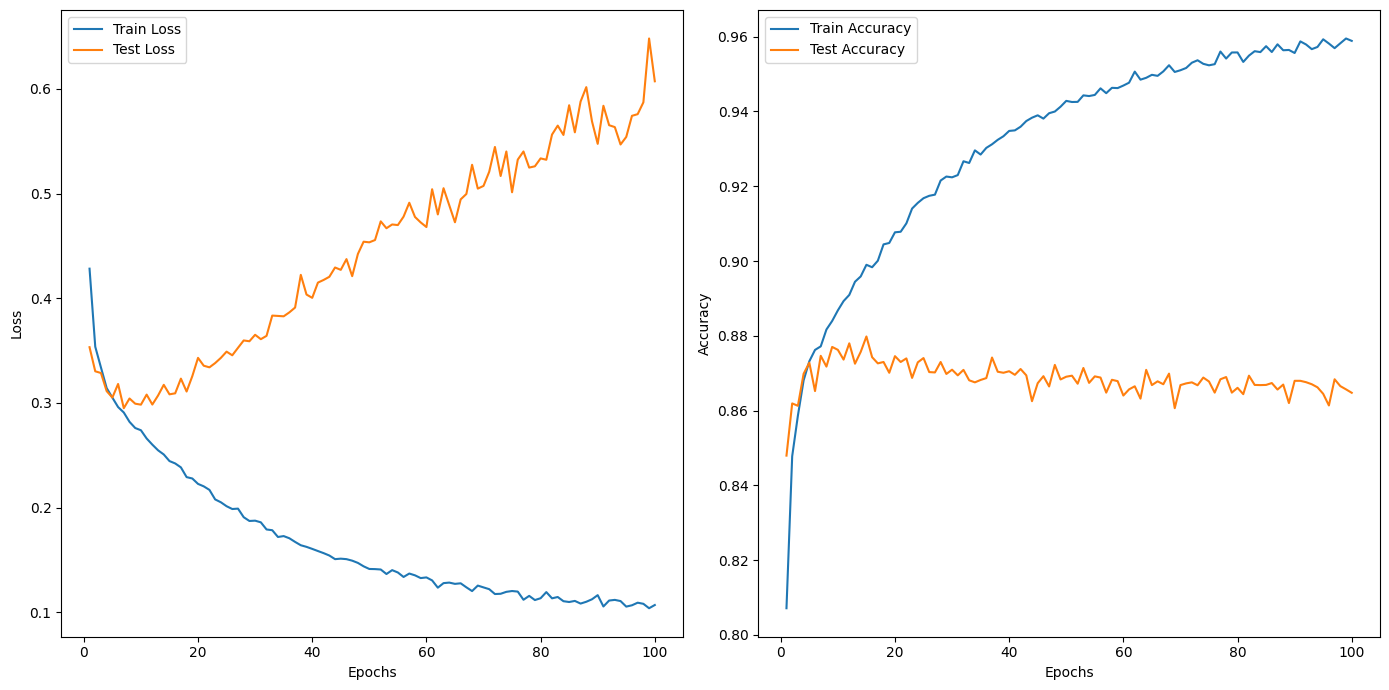

Starting final evaluation on test set...
Final Test Accuracy: 0.5488
Classification Report:
              precision    recall  f1-score   support

          CD       0.75      0.70      0.72      1019
         HYP       0.67      0.44      0.53       519
          MI       0.70      0.67      0.69      1102
        NORM       0.84      0.81      0.82      1906
        STTC       0.72      0.59      0.65      1055

   micro avg       0.76      0.69      0.72      5601
   macro avg       0.74      0.64      0.68      5601
weighted avg       0.76      0.69      0.72      5601
 samples avg       0.71      0.70      0.69      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


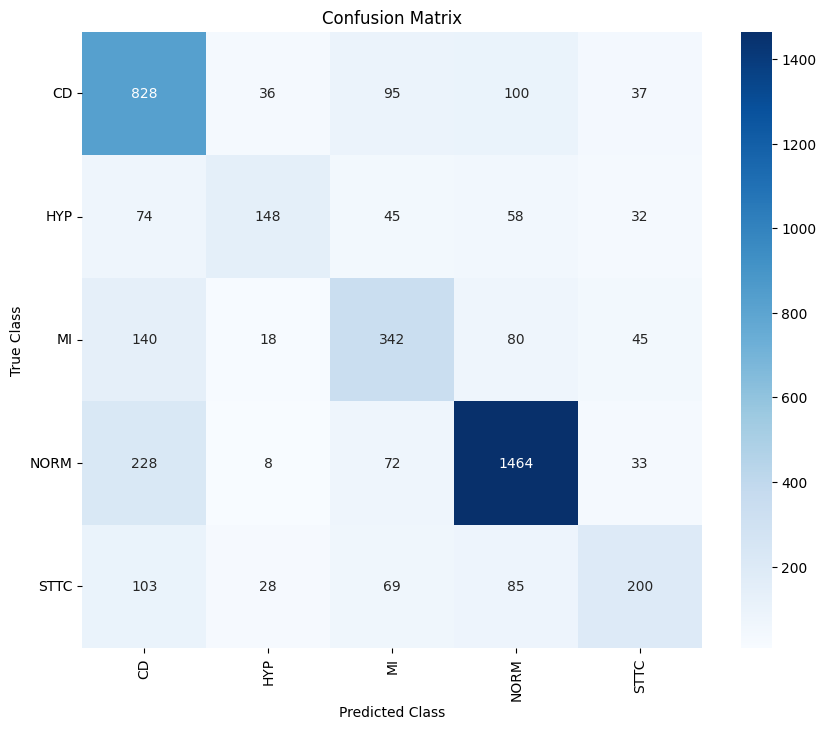

Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model using the best parameters from Optuna's study
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim, dropout_rate):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize fully connected layers dynamically
        self.fc1 = None
        self.fc2 = nn.Linear(128, output_dim)

    def forward(self, x):
        # Convolution and pooling layers
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 128).to(x.device)

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load all the data (no sampling)
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and standard deviation
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set standard deviation: {np.std(X_train)}")
print(f"Test set standard deviation: {np.std(X_test)}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the best parameters from Optuna's study
dropout_rate = 0.3357528110358869
learning_rate = 0.007733681819143332

model = ECGTransferCNN(input_channels=n_leads, output_dim=y_train.shape[1], dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model saving path
SAVE_PATH = '/content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth'

# Training loop with tqdm progress bar, and tracking accuracy/loss history
best_accuracy = 0  # Variable to track the best test accuracy
epochs = 100  # Number of epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save the model if test accuracy improves
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, SAVE_PATH)
        print(f"Model saved with Test Accuracy: {test_accuracy:.4f}")

# After training is complete, save the final model
print("Training complete. Saving final model...")
torch.save(model.state_dict(), SAVE_PATH)
print(f"Final model saved to {SAVE_PATH}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

print("Data processing, training, and evaluation completed.")


CNN-TS Layer increse

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:28<00:00, 247.77it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Training set standard deviation: 0.23364261164281808
Test set standard deviation: 0.2317493984831071

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:03<00:00, 83.55it/s]


End of Epoch 1: Train Loss: 0.4649, Train Accuracy: 0.7833
End of Epoch 1: Test Loss: 0.3830, Test Accuracy: 0.8253
Model saved with Test Accuracy: 0.8253

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:03<00:00, 88.20it/s]


End of Epoch 2: Train Loss: 0.3733, Train Accuracy: 0.8369
End of Epoch 2: Test Loss: 0.3374, Test Accuracy: 0.8574
Model saved with Test Accuracy: 0.8574

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:03<00:00, 90.17it/s]


End of Epoch 3: Train Loss: 0.3536, Train Accuracy: 0.8491
End of Epoch 3: Test Loss: 0.3338, Test Accuracy: 0.8555

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:03<00:00, 90.02it/s]


End of Epoch 4: Train Loss: 0.3429, Train Accuracy: 0.8533
End of Epoch 4: Test Loss: 0.3382, Test Accuracy: 0.8566

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:03<00:00, 89.77it/s]


End of Epoch 5: Train Loss: 0.3358, Train Accuracy: 0.8582
End of Epoch 5: Test Loss: 0.3245, Test Accuracy: 0.8639
Model saved with Test Accuracy: 0.8639

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:03<00:00, 89.90it/s]


End of Epoch 6: Train Loss: 0.3249, Train Accuracy: 0.8636
End of Epoch 6: Test Loss: 0.3345, Test Accuracy: 0.8585

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:03<00:00, 89.84it/s]


End of Epoch 7: Train Loss: 0.3214, Train Accuracy: 0.8654
End of Epoch 7: Test Loss: 0.3138, Test Accuracy: 0.8676
Model saved with Test Accuracy: 0.8676

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:03<00:00, 90.48it/s]


End of Epoch 8: Train Loss: 0.3141, Train Accuracy: 0.8692
End of Epoch 8: Test Loss: 0.3189, Test Accuracy: 0.8663

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:03<00:00, 89.75it/s]


End of Epoch 9: Train Loss: 0.3113, Train Accuracy: 0.8700
End of Epoch 9: Test Loss: 0.3084, Test Accuracy: 0.8692
Model saved with Test Accuracy: 0.8692

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:02<00:00, 91.04it/s]


End of Epoch 10: Train Loss: 0.3057, Train Accuracy: 0.8726
End of Epoch 10: Test Loss: 0.3083, Test Accuracy: 0.8737
Model saved with Test Accuracy: 0.8737

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:02<00:00, 91.08it/s]


End of Epoch 11: Train Loss: 0.3032, Train Accuracy: 0.8736
End of Epoch 11: Test Loss: 0.3061, Test Accuracy: 0.8727

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:02<00:00, 91.07it/s]


End of Epoch 12: Train Loss: 0.3001, Train Accuracy: 0.8749
End of Epoch 12: Test Loss: 0.3023, Test Accuracy: 0.8724

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:03<00:00, 90.79it/s]


End of Epoch 13: Train Loss: 0.2961, Train Accuracy: 0.8773
End of Epoch 13: Test Loss: 0.2981, Test Accuracy: 0.8757
Model saved with Test Accuracy: 0.8757

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:02<00:00, 91.30it/s]


End of Epoch 14: Train Loss: 0.2952, Train Accuracy: 0.8780
End of Epoch 14: Test Loss: 0.2999, Test Accuracy: 0.8738

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:02<00:00, 91.18it/s]


End of Epoch 15: Train Loss: 0.2902, Train Accuracy: 0.8785
End of Epoch 15: Test Loss: 0.3063, Test Accuracy: 0.8740

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:02<00:00, 91.36it/s]


End of Epoch 16: Train Loss: 0.2882, Train Accuracy: 0.8809
End of Epoch 16: Test Loss: 0.2987, Test Accuracy: 0.8772
Model saved with Test Accuracy: 0.8772

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:02<00:00, 91.56it/s]


End of Epoch 17: Train Loss: 0.2863, Train Accuracy: 0.8811
End of Epoch 17: Test Loss: 0.2971, Test Accuracy: 0.8768

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:02<00:00, 91.60it/s]


End of Epoch 18: Train Loss: 0.2837, Train Accuracy: 0.8824
End of Epoch 18: Test Loss: 0.3010, Test Accuracy: 0.8777
Model saved with Test Accuracy: 0.8777

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:02<00:00, 91.73it/s]


End of Epoch 19: Train Loss: 0.2801, Train Accuracy: 0.8843
End of Epoch 19: Test Loss: 0.3151, Test Accuracy: 0.8699

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:02<00:00, 91.10it/s]


End of Epoch 20: Train Loss: 0.2817, Train Accuracy: 0.8825
End of Epoch 20: Test Loss: 0.2991, Test Accuracy: 0.8772

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:02<00:00, 91.91it/s]


End of Epoch 21: Train Loss: 0.2789, Train Accuracy: 0.8831
End of Epoch 21: Test Loss: 0.2949, Test Accuracy: 0.8773

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:02<00:00, 91.70it/s]


End of Epoch 22: Train Loss: 0.2756, Train Accuracy: 0.8843
End of Epoch 22: Test Loss: 0.3060, Test Accuracy: 0.8718

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:02<00:00, 91.32it/s]


End of Epoch 23: Train Loss: 0.2751, Train Accuracy: 0.8872
End of Epoch 23: Test Loss: 0.3021, Test Accuracy: 0.8719

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:03<00:00, 90.88it/s]


End of Epoch 24: Train Loss: 0.2742, Train Accuracy: 0.8858
End of Epoch 24: Test Loss: 0.3044, Test Accuracy: 0.8726

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:02<00:00, 91.52it/s]


End of Epoch 25: Train Loss: 0.2722, Train Accuracy: 0.8871
End of Epoch 25: Test Loss: 0.2996, Test Accuracy: 0.8743

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:02<00:00, 91.28it/s]


End of Epoch 26: Train Loss: 0.2700, Train Accuracy: 0.8891
End of Epoch 26: Test Loss: 0.3039, Test Accuracy: 0.8747

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:03<00:00, 90.77it/s]


End of Epoch 27: Train Loss: 0.2674, Train Accuracy: 0.8887
End of Epoch 27: Test Loss: 0.2959, Test Accuracy: 0.8776

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:02<00:00, 91.29it/s]


End of Epoch 28: Train Loss: 0.2633, Train Accuracy: 0.8901
End of Epoch 28: Test Loss: 0.2989, Test Accuracy: 0.8779
Model saved with Test Accuracy: 0.8779

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:03<00:00, 90.42it/s]


End of Epoch 29: Train Loss: 0.2613, Train Accuracy: 0.8927
End of Epoch 29: Test Loss: 0.2997, Test Accuracy: 0.8748

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:03<00:00, 90.87it/s]


End of Epoch 30: Train Loss: 0.2616, Train Accuracy: 0.8918
End of Epoch 30: Test Loss: 0.3046, Test Accuracy: 0.8763

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:03<00:00, 90.24it/s]


End of Epoch 31: Train Loss: 0.2587, Train Accuracy: 0.8930
End of Epoch 31: Test Loss: 0.2979, Test Accuracy: 0.8771

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:02<00:00, 91.26it/s]


End of Epoch 32: Train Loss: 0.2552, Train Accuracy: 0.8939
End of Epoch 32: Test Loss: 0.3000, Test Accuracy: 0.8768

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:02<00:00, 91.02it/s]


End of Epoch 33: Train Loss: 0.2558, Train Accuracy: 0.8946
End of Epoch 33: Test Loss: 0.2978, Test Accuracy: 0.8782
Model saved with Test Accuracy: 0.8782

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:03<00:00, 90.98it/s]


End of Epoch 34: Train Loss: 0.2536, Train Accuracy: 0.8935
End of Epoch 34: Test Loss: 0.2960, Test Accuracy: 0.8768

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:03<00:00, 90.84it/s]


End of Epoch 35: Train Loss: 0.2494, Train Accuracy: 0.8967
End of Epoch 35: Test Loss: 0.3023, Test Accuracy: 0.8800
Model saved with Test Accuracy: 0.8800

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:02<00:00, 91.20it/s]


End of Epoch 36: Train Loss: 0.2487, Train Accuracy: 0.8967
End of Epoch 36: Test Loss: 0.3020, Test Accuracy: 0.8775

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:03<00:00, 90.92it/s]


End of Epoch 37: Train Loss: 0.2493, Train Accuracy: 0.8957
End of Epoch 37: Test Loss: 0.3017, Test Accuracy: 0.8766

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:03<00:00, 90.80it/s]


End of Epoch 38: Train Loss: 0.2493, Train Accuracy: 0.8969
End of Epoch 38: Test Loss: 0.3266, Test Accuracy: 0.8742

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:02<00:00, 91.07it/s]


End of Epoch 39: Train Loss: 0.2466, Train Accuracy: 0.8979
End of Epoch 39: Test Loss: 0.3045, Test Accuracy: 0.8772

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:02<00:00, 91.04it/s]


End of Epoch 40: Train Loss: 0.2442, Train Accuracy: 0.8986
End of Epoch 40: Test Loss: 0.3087, Test Accuracy: 0.8771

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:02<00:00, 91.54it/s]


End of Epoch 41: Train Loss: 0.2371, Train Accuracy: 0.9018
End of Epoch 41: Test Loss: 0.3027, Test Accuracy: 0.8774

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:03<00:00, 90.57it/s]


End of Epoch 42: Train Loss: 0.2363, Train Accuracy: 0.9014
End of Epoch 42: Test Loss: 0.3079, Test Accuracy: 0.8761

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:02<00:00, 91.46it/s]


End of Epoch 43: Train Loss: 0.2364, Train Accuracy: 0.9014
End of Epoch 43: Test Loss: 0.3152, Test Accuracy: 0.8752

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:02<00:00, 91.01it/s]


End of Epoch 44: Train Loss: 0.2322, Train Accuracy: 0.9037
End of Epoch 44: Test Loss: 0.3116, Test Accuracy: 0.8735

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:02<00:00, 91.34it/s]


End of Epoch 45: Train Loss: 0.2317, Train Accuracy: 0.9051
End of Epoch 45: Test Loss: 0.3113, Test Accuracy: 0.8705

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:02<00:00, 91.07it/s]


End of Epoch 46: Train Loss: 0.2315, Train Accuracy: 0.9044
End of Epoch 46: Test Loss: 0.3092, Test Accuracy: 0.8757

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:02<00:00, 91.48it/s]


End of Epoch 47: Train Loss: 0.2297, Train Accuracy: 0.9053
End of Epoch 47: Test Loss: 0.3181, Test Accuracy: 0.8727

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:02<00:00, 91.49it/s]


End of Epoch 48: Train Loss: 0.2257, Train Accuracy: 0.9064
End of Epoch 48: Test Loss: 0.3143, Test Accuracy: 0.8758

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:03<00:00, 90.43it/s]


End of Epoch 49: Train Loss: 0.2250, Train Accuracy: 0.9073
End of Epoch 49: Test Loss: 0.3156, Test Accuracy: 0.8770

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:02<00:00, 91.12it/s]


End of Epoch 50: Train Loss: 0.2245, Train Accuracy: 0.9062
End of Epoch 50: Test Loss: 0.3235, Test Accuracy: 0.8751

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:02<00:00, 91.20it/s]


End of Epoch 51: Train Loss: 0.2186, Train Accuracy: 0.9100
End of Epoch 51: Test Loss: 0.3220, Test Accuracy: 0.8711

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:02<00:00, 91.20it/s]


End of Epoch 52: Train Loss: 0.2190, Train Accuracy: 0.9095
End of Epoch 52: Test Loss: 0.3257, Test Accuracy: 0.8749

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:03<00:00, 89.64it/s]


End of Epoch 53: Train Loss: 0.2138, Train Accuracy: 0.9118
End of Epoch 53: Test Loss: 0.3277, Test Accuracy: 0.8725

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:02<00:00, 91.39it/s]


End of Epoch 54: Train Loss: 0.2160, Train Accuracy: 0.9119
End of Epoch 54: Test Loss: 0.3276, Test Accuracy: 0.8736

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:02<00:00, 91.14it/s]


End of Epoch 55: Train Loss: 0.2151, Train Accuracy: 0.9117
End of Epoch 55: Test Loss: 0.3283, Test Accuracy: 0.8742

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:03<00:00, 90.31it/s]


End of Epoch 56: Train Loss: 0.2105, Train Accuracy: 0.9131
End of Epoch 56: Test Loss: 0.3305, Test Accuracy: 0.8755

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:03<00:00, 90.55it/s]


End of Epoch 57: Train Loss: 0.2120, Train Accuracy: 0.9118
End of Epoch 57: Test Loss: 0.3433, Test Accuracy: 0.8763

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:02<00:00, 91.12it/s]


End of Epoch 58: Train Loss: 0.2078, Train Accuracy: 0.9139
End of Epoch 58: Test Loss: 0.3418, Test Accuracy: 0.8743

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:03<00:00, 90.89it/s]


End of Epoch 59: Train Loss: 0.2087, Train Accuracy: 0.9130
End of Epoch 59: Test Loss: 0.3320, Test Accuracy: 0.8761

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:03<00:00, 90.15it/s]


End of Epoch 60: Train Loss: 0.2062, Train Accuracy: 0.9156
End of Epoch 60: Test Loss: 0.3315, Test Accuracy: 0.8761

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:03<00:00, 90.84it/s]


End of Epoch 61: Train Loss: 0.2038, Train Accuracy: 0.9157
End of Epoch 61: Test Loss: 0.3426, Test Accuracy: 0.8754

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:03<00:00, 90.79it/s]


End of Epoch 62: Train Loss: 0.2043, Train Accuracy: 0.9147
End of Epoch 62: Test Loss: 0.3395, Test Accuracy: 0.8734

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:02<00:00, 91.23it/s]


End of Epoch 63: Train Loss: 0.1991, Train Accuracy: 0.9173
End of Epoch 63: Test Loss: 0.3390, Test Accuracy: 0.8746

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:03<00:00, 90.75it/s]


End of Epoch 64: Train Loss: 0.1953, Train Accuracy: 0.9194
End of Epoch 64: Test Loss: 0.3399, Test Accuracy: 0.8749

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:02<00:00, 91.11it/s]


End of Epoch 65: Train Loss: 0.1970, Train Accuracy: 0.9186
End of Epoch 65: Test Loss: 0.3476, Test Accuracy: 0.8740

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:03<00:00, 90.90it/s]


End of Epoch 66: Train Loss: 0.1977, Train Accuracy: 0.9182
End of Epoch 66: Test Loss: 0.3651, Test Accuracy: 0.8745

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:03<00:00, 90.63it/s]


End of Epoch 67: Train Loss: 0.1943, Train Accuracy: 0.9198
End of Epoch 67: Test Loss: 0.3523, Test Accuracy: 0.8755

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:03<00:00, 90.91it/s]


End of Epoch 68: Train Loss: 0.1932, Train Accuracy: 0.9197
End of Epoch 68: Test Loss: 0.3540, Test Accuracy: 0.8718

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:03<00:00, 90.90it/s]


End of Epoch 69: Train Loss: 0.1962, Train Accuracy: 0.9188
End of Epoch 69: Test Loss: 0.3665, Test Accuracy: 0.8725

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:03<00:00, 90.99it/s]


End of Epoch 70: Train Loss: 0.1903, Train Accuracy: 0.9221
End of Epoch 70: Test Loss: 0.3575, Test Accuracy: 0.8740

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:03<00:00, 90.62it/s]


End of Epoch 71: Train Loss: 0.1930, Train Accuracy: 0.9210
End of Epoch 71: Test Loss: 0.3459, Test Accuracy: 0.8747

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:03<00:00, 90.99it/s]


End of Epoch 72: Train Loss: 0.1902, Train Accuracy: 0.9209
End of Epoch 72: Test Loss: 0.3484, Test Accuracy: 0.8730

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:02<00:00, 91.31it/s]


End of Epoch 73: Train Loss: 0.1858, Train Accuracy: 0.9234
End of Epoch 73: Test Loss: 0.3634, Test Accuracy: 0.8714

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:02<00:00, 91.12it/s]


End of Epoch 74: Train Loss: 0.1830, Train Accuracy: 0.9248
End of Epoch 74: Test Loss: 0.3701, Test Accuracy: 0.8762

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:03<00:00, 90.89it/s]


End of Epoch 75: Train Loss: 0.1810, Train Accuracy: 0.9256
End of Epoch 75: Test Loss: 0.3435, Test Accuracy: 0.8746

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:03<00:00, 90.94it/s]


End of Epoch 76: Train Loss: 0.1784, Train Accuracy: 0.9264
End of Epoch 76: Test Loss: 0.3802, Test Accuracy: 0.8753

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:02<00:00, 91.16it/s]


End of Epoch 77: Train Loss: 0.1791, Train Accuracy: 0.9272
End of Epoch 77: Test Loss: 0.3739, Test Accuracy: 0.8754

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:03<00:00, 90.98it/s]


End of Epoch 78: Train Loss: 0.1786, Train Accuracy: 0.9263
End of Epoch 78: Test Loss: 0.3779, Test Accuracy: 0.8689

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:02<00:00, 91.17it/s]


End of Epoch 79: Train Loss: 0.1782, Train Accuracy: 0.9265
End of Epoch 79: Test Loss: 0.3846, Test Accuracy: 0.8733

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:02<00:00, 91.66it/s]


End of Epoch 80: Train Loss: 0.1776, Train Accuracy: 0.9265
End of Epoch 80: Test Loss: 0.3728, Test Accuracy: 0.8743

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:03<00:00, 90.85it/s]


End of Epoch 81: Train Loss: 0.1753, Train Accuracy: 0.9277
End of Epoch 81: Test Loss: 0.3657, Test Accuracy: 0.8740

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:03<00:00, 90.69it/s]


End of Epoch 82: Train Loss: 0.1728, Train Accuracy: 0.9279
End of Epoch 82: Test Loss: 0.3652, Test Accuracy: 0.8714

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:02<00:00, 91.53it/s]


End of Epoch 83: Train Loss: 0.1702, Train Accuracy: 0.9296
End of Epoch 83: Test Loss: 0.3754, Test Accuracy: 0.8711

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:02<00:00, 91.59it/s]


End of Epoch 84: Train Loss: 0.1735, Train Accuracy: 0.9295
End of Epoch 84: Test Loss: 0.3845, Test Accuracy: 0.8730

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:03<00:00, 90.85it/s]


End of Epoch 85: Train Loss: 0.1735, Train Accuracy: 0.9297
End of Epoch 85: Test Loss: 0.3925, Test Accuracy: 0.8711

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:03<00:00, 90.74it/s]


End of Epoch 86: Train Loss: 0.1690, Train Accuracy: 0.9309
End of Epoch 86: Test Loss: 0.3724, Test Accuracy: 0.8692

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:02<00:00, 91.19it/s]


End of Epoch 87: Train Loss: 0.1662, Train Accuracy: 0.9316
End of Epoch 87: Test Loss: 0.3935, Test Accuracy: 0.8712

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:02<00:00, 91.16it/s]


End of Epoch 88: Train Loss: 0.1657, Train Accuracy: 0.9323
End of Epoch 88: Test Loss: 0.3879, Test Accuracy: 0.8714

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:02<00:00, 91.11it/s]


End of Epoch 89: Train Loss: 0.1670, Train Accuracy: 0.9308
End of Epoch 89: Test Loss: 0.3836, Test Accuracy: 0.8739

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:03<00:00, 90.88it/s]


End of Epoch 90: Train Loss: 0.1610, Train Accuracy: 0.9337
End of Epoch 90: Test Loss: 0.3837, Test Accuracy: 0.8715

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:02<00:00, 91.13it/s]


End of Epoch 91: Train Loss: 0.1613, Train Accuracy: 0.9343
End of Epoch 91: Test Loss: 0.3879, Test Accuracy: 0.8708

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:02<00:00, 91.02it/s]


End of Epoch 92: Train Loss: 0.1596, Train Accuracy: 0.9359
End of Epoch 92: Test Loss: 0.3887, Test Accuracy: 0.8730

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:03<00:00, 90.57it/s]


End of Epoch 93: Train Loss: 0.1617, Train Accuracy: 0.9346
End of Epoch 93: Test Loss: 0.4027, Test Accuracy: 0.8699

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:02<00:00, 91.00it/s]


End of Epoch 94: Train Loss: 0.1605, Train Accuracy: 0.9348
End of Epoch 94: Test Loss: 0.4203, Test Accuracy: 0.8745

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:02<00:00, 91.15it/s]


End of Epoch 95: Train Loss: 0.1634, Train Accuracy: 0.9340
End of Epoch 95: Test Loss: 0.3783, Test Accuracy: 0.8737

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:02<00:00, 91.27it/s]


End of Epoch 96: Train Loss: 0.1571, Train Accuracy: 0.9356
End of Epoch 96: Test Loss: 0.3993, Test Accuracy: 0.8697

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:03<00:00, 90.91it/s]


End of Epoch 97: Train Loss: 0.1581, Train Accuracy: 0.9362
End of Epoch 97: Test Loss: 0.4207, Test Accuracy: 0.8755

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:02<00:00, 91.19it/s]


End of Epoch 98: Train Loss: 0.1608, Train Accuracy: 0.9348
End of Epoch 98: Test Loss: 0.4177, Test Accuracy: 0.8751

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:02<00:00, 91.33it/s]


End of Epoch 99: Train Loss: 0.1561, Train Accuracy: 0.9369
End of Epoch 99: Test Loss: 0.4258, Test Accuracy: 0.8712

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:03<00:00, 90.83it/s]


End of Epoch 100: Train Loss: 0.1539, Train Accuracy: 0.9369
End of Epoch 100: Test Loss: 0.4142, Test Accuracy: 0.8717
Training complete. Saving final model...
Final model saved to /content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth
Training complete. Plotting loss and accuracy curves...


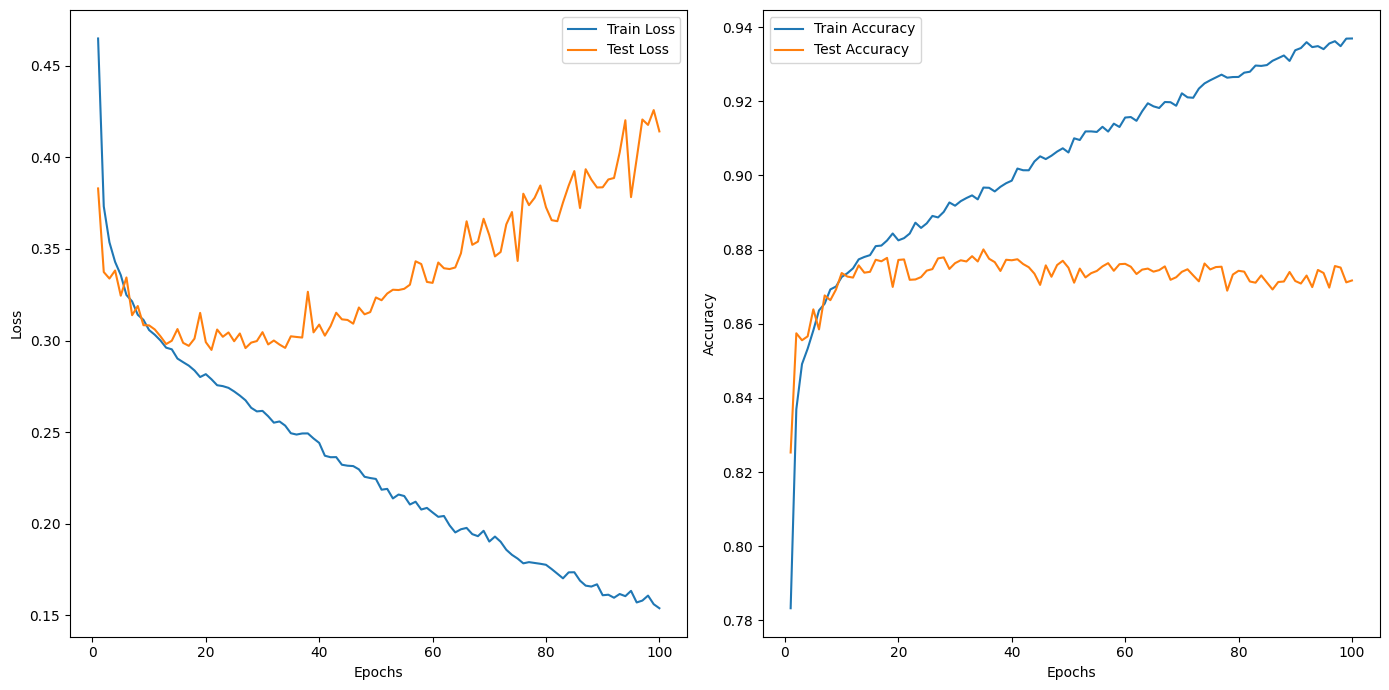

Starting final evaluation on test set...
Final Test Accuracy: 0.5863
Classification Report:
              precision    recall  f1-score   support

          CD       0.82      0.68      0.74      1019
         HYP       0.67      0.52      0.59       519
          MI       0.71      0.65      0.68      1102
        NORM       0.83      0.86      0.85      1906
        STTC       0.65      0.77      0.71      1055

   micro avg       0.76      0.74      0.75      5601
   macro avg       0.74      0.69      0.71      5601
weighted avg       0.76      0.74      0.74      5601
 samples avg       0.75      0.75      0.73      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


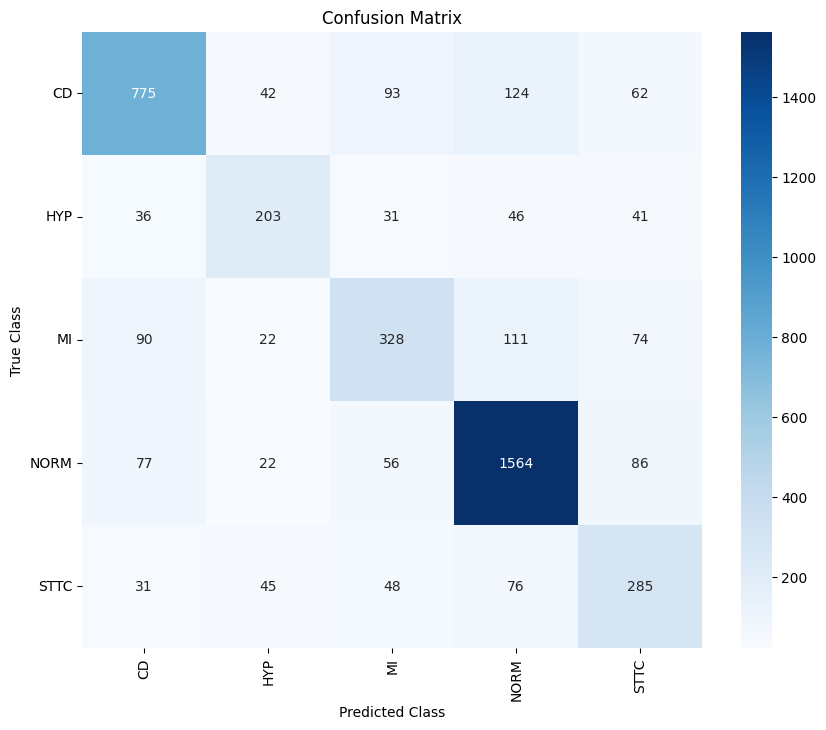

Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# CNN model with an additional convolutional layer and fully connected layer
class ECGTransferCNN(nn.Module):
    def __init__(self, input_channels, output_dim, dropout_rate):
        super(ECGTransferCNN, self).__init__()
        self.conv1 = nn.Conv1d(input_channels, 64, kernel_size=7, stride=1, padding=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1, padding=2)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv1d(256, 512, kernel_size=3, stride=1, padding=1)  # Additional convolutional layer
        self.maxpool = nn.MaxPool1d(kernel_size=2, stride=2)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

        # Initialize fully connected layers dynamically
        self.fc1 = None
        self.fc2 = None  # Additional fully connected layer
        self.fc3 = nn.Linear(128, output_dim)  # Updated to third fully connected layer

    def forward(self, x):
        # Convolution and pooling layers
        x = self.relu(self.maxpool(self.conv1(x)))
        x = self.relu(self.maxpool(self.conv2(x)))
        x = self.relu(self.maxpool(self.conv3(x)))
        x = self.relu(self.maxpool(self.conv4(x)))  # Pass through the new conv4 layer

        # Flatten for fully connected layers
        x = x.view(x.size(0), -1)

        # Initialize fc1 dynamically based on the flattened size
        if self.fc1 is None:
            self.fc1 = nn.Linear(x.size(1), 256).to(x.device)  # Increase size for additional fully connected layers

        if self.fc2 is None:
            self.fc2 = nn.Linear(256, 128).to(x.device)  # Initialize second fully connected layer dynamically

        # Fully connected layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))  # Pass through the new fully connected layer
        x = self.fc3(x)
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load all the data (no sampling)
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and standard deviation
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Training set standard deviation: {np.std(X_train)}")
print(f"Test set standard deviation: {np.std(X_test)}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the best parameters from Optuna's study
dropout_rate = 0.3357528110358869
learning_rate = 0.007733681819143332

model = ECGTransferCNN(input_channels=n_leads, output_dim=y_train.shape[1], dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Model saving path
SAVE_PATH = '/content/drive/MyDrive/DATAS/results/ecg_transfer_cnn_model.pth'

# Training loop with tqdm progress bar, and tracking accuracy/loss history
best_accuracy = 0  # Variable to track the best test accuracy
epochs = 100  # Number of epochs
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

    # Save the model if test accuracy improves
    if test_accuracy > best_accuracy:
        best_accuracy = test_accuracy
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'test_loss': test_loss,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }, SAVE_PATH)
        print(f"Model saved with Test Accuracy: {test_accuracy:.4f}")

# After training is complete, save the final model
print("Training complete. Saving final model...")
torch.save(model.state_dict(), SAVE_PATH)
print(f"Final model saved to {SAVE_PATH}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()
print("Data processing, training, and evaluation completed.")


ResNet1D Transfer learnig with 20% data

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:27<00:00, 249.00it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples

Starting Epoch 1/10


Training Epoch 1/10: 100%|██████████| 273/273 [00:10<00:00, 25.81it/s]


End of Epoch 1: Train Loss: 0.3454, Train Accuracy: 0.8504
End of Epoch 1: Test Loss: 0.3526, Test Accuracy: 0.8462

Starting Epoch 2/10


Training Epoch 2/10: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 2: Train Loss: 0.2923, Train Accuracy: 0.8782
End of Epoch 2: Test Loss: 0.2829, Test Accuracy: 0.8810

Starting Epoch 3/10


Training Epoch 3/10: 100%|██████████| 273/273 [00:10<00:00, 25.11it/s]


End of Epoch 3: Train Loss: 0.2744, Train Accuracy: 0.8849
End of Epoch 3: Test Loss: 0.2936, Test Accuracy: 0.8761

Starting Epoch 4/10


Training Epoch 4/10: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 4: Train Loss: 0.2651, Train Accuracy: 0.8896
End of Epoch 4: Test Loss: 0.2766, Test Accuracy: 0.8829

Starting Epoch 5/10


Training Epoch 5/10: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 5: Train Loss: 0.2586, Train Accuracy: 0.8927
End of Epoch 5: Test Loss: 0.2683, Test Accuracy: 0.8885

Starting Epoch 6/10


Training Epoch 6/10: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 6: Train Loss: 0.2541, Train Accuracy: 0.8936
End of Epoch 6: Test Loss: 0.2703, Test Accuracy: 0.8884

Starting Epoch 7/10


Training Epoch 7/10: 100%|██████████| 273/273 [00:10<00:00, 24.83it/s]


End of Epoch 7: Train Loss: 0.2474, Train Accuracy: 0.8983
End of Epoch 7: Test Loss: 0.2598, Test Accuracy: 0.8913

Starting Epoch 8/10


Training Epoch 8/10: 100%|██████████| 273/273 [00:10<00:00, 25.10it/s]


End of Epoch 8: Train Loss: 0.2426, Train Accuracy: 0.8987
End of Epoch 8: Test Loss: 0.2742, Test Accuracy: 0.8822

Starting Epoch 9/10


Training Epoch 9/10: 100%|██████████| 273/273 [00:10<00:00, 25.09it/s]


End of Epoch 9: Train Loss: 0.2381, Train Accuracy: 0.9020
End of Epoch 9: Test Loss: 0.2661, Test Accuracy: 0.8877

Starting Epoch 10/10


Training Epoch 10/10: 100%|██████████| 273/273 [00:10<00:00, 24.94it/s]


End of Epoch 10: Train Loss: 0.2319, Train Accuracy: 0.9038
End of Epoch 10: Test Loss: 0.2613, Test Accuracy: 0.8922
Training complete. Plotting loss and accuracy curves...


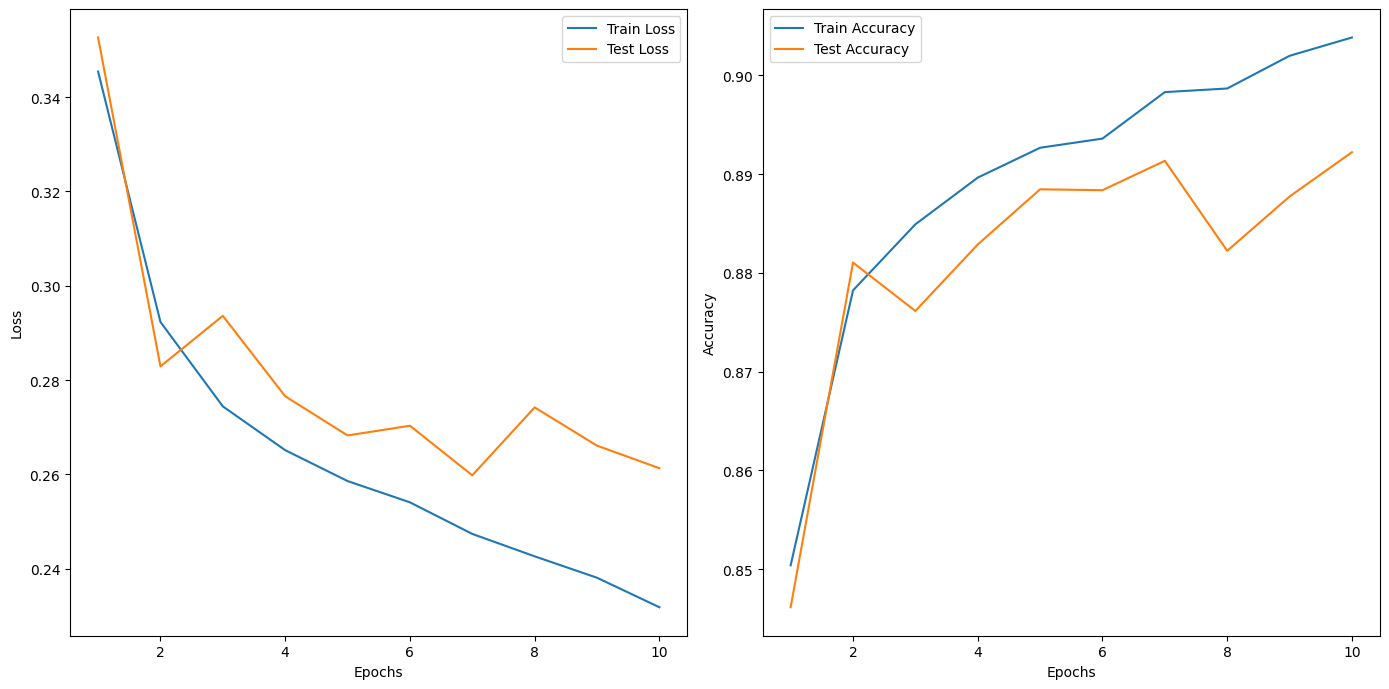

Starting final evaluation on test set...
Final Test Accuracy: 0.6328
Classification Report:
              precision    recall  f1-score   support

          CD       0.90      0.61      0.73      1019
         HYP       0.66      0.60      0.63       519
          MI       0.78      0.73      0.76      1102
        NORM       0.87      0.88      0.87      1906
        STTC       0.80      0.68      0.73      1055

   micro avg       0.82      0.74      0.78      5601
   macro avg       0.80      0.70      0.74      5601
weighted avg       0.82      0.74      0.78      5601
 samples avg       0.78      0.75      0.75      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


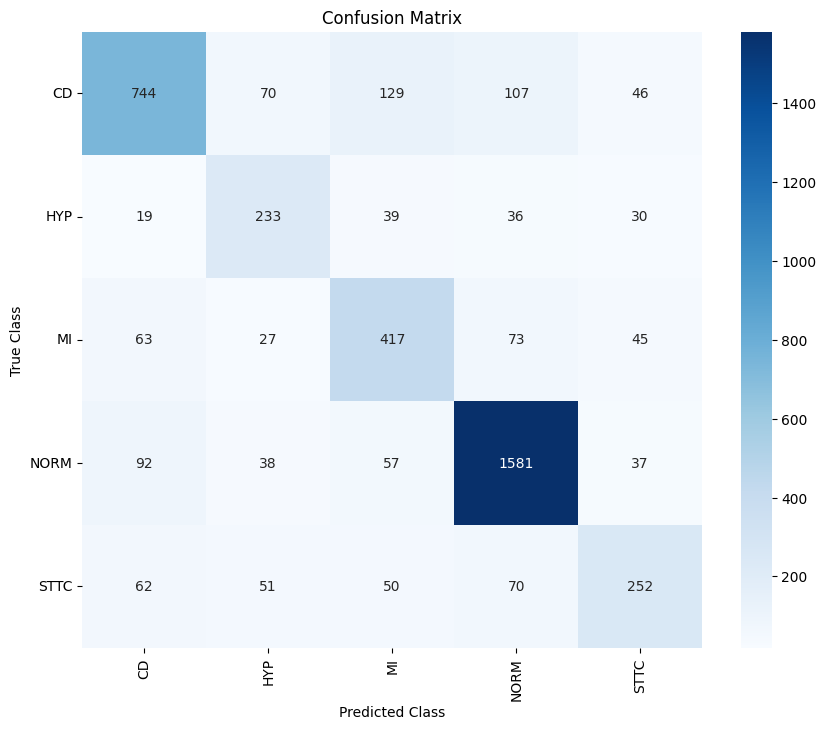

Saving the model...
Model saved to resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=output_dim)  # Corrected initialization

    def forward(self, x):
        return self.resnet(x)

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Calculate and display input shape size and standard deviation
print(f"Train input shape: {X_train.shape}")
print(f"Test input shape: {X_test.shape}")
train_std = np.std(X_train)
test_std = np.std(X_test)
print(f"Train data standard deviation: {train_std:.4f}")
print(f"Test data standard deviation: {test_std:.4f}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = 'resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


ResNet1D Transferlearning 100% datas

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:37<00:00, 224.72it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Train input shape: (17469, 500, 12)
Test input shape: (4368, 500, 12)
Train data standard deviation: 0.2336
Test data standard deviation: 0.2317
Model Summary:
ResNetTransfer(
  (resnet): ResNet(
    (resblock1): ResBlock(
      (convblock1): ConvBlock(
        (0): Conv1d(12, 64, kernel_size=(7,), stride=(1,), padding=(3,), bias=False)
        (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (convblock2): ConvBlock(
        (0): Conv1d(

Training Epoch 1/100: 100%|██████████| 273/273 [00:10<00:00, 25.44it/s]


End of Epoch 1: Train Loss: 0.3422, Train Accuracy: 0.8530
End of Epoch 1: Test Loss: 0.3083, Test Accuracy: 0.8716

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:10<00:00, 25.06it/s]


End of Epoch 2: Train Loss: 0.2895, Train Accuracy: 0.8780
End of Epoch 2: Test Loss: 0.2881, Test Accuracy: 0.8787

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:10<00:00, 24.84it/s]


End of Epoch 3: Train Loss: 0.2762, Train Accuracy: 0.8852
End of Epoch 3: Test Loss: 0.2733, Test Accuracy: 0.8853

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:10<00:00, 25.22it/s]


End of Epoch 4: Train Loss: 0.2649, Train Accuracy: 0.8900
End of Epoch 4: Test Loss: 0.2928, Test Accuracy: 0.8772

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 5: Train Loss: 0.2585, Train Accuracy: 0.8930
End of Epoch 5: Test Loss: 0.2871, Test Accuracy: 0.8807

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:10<00:00, 25.59it/s]


End of Epoch 6: Train Loss: 0.2492, Train Accuracy: 0.8956
End of Epoch 6: Test Loss: 0.2650, Test Accuracy: 0.8887

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s]


End of Epoch 7: Train Loss: 0.2456, Train Accuracy: 0.8980
End of Epoch 7: Test Loss: 0.2598, Test Accuracy: 0.8916

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:10<00:00, 25.61it/s]


End of Epoch 8: Train Loss: 0.2402, Train Accuracy: 0.8998
End of Epoch 8: Test Loss: 0.2678, Test Accuracy: 0.8876

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 9: Train Loss: 0.2357, Train Accuracy: 0.9013
End of Epoch 9: Test Loss: 0.2675, Test Accuracy: 0.8900

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:10<00:00, 25.34it/s]


End of Epoch 10: Train Loss: 0.2318, Train Accuracy: 0.9036
End of Epoch 10: Test Loss: 0.2684, Test Accuracy: 0.8890

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:10<00:00, 25.34it/s]


End of Epoch 11: Train Loss: 0.2251, Train Accuracy: 0.9070
End of Epoch 11: Test Loss: 0.2574, Test Accuracy: 0.8917

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:10<00:00, 25.37it/s]


End of Epoch 12: Train Loss: 0.2202, Train Accuracy: 0.9088
End of Epoch 12: Test Loss: 0.2625, Test Accuracy: 0.8898

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:10<00:00, 25.47it/s]


End of Epoch 13: Train Loss: 0.2180, Train Accuracy: 0.9097
End of Epoch 13: Test Loss: 0.2632, Test Accuracy: 0.8940

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:10<00:00, 25.46it/s]


End of Epoch 14: Train Loss: 0.2122, Train Accuracy: 0.9121
End of Epoch 14: Test Loss: 0.2662, Test Accuracy: 0.8927

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 15: Train Loss: 0.2069, Train Accuracy: 0.9147
End of Epoch 15: Test Loss: 0.2646, Test Accuracy: 0.8905

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:10<00:00, 25.49it/s]


End of Epoch 16: Train Loss: 0.2013, Train Accuracy: 0.9173
End of Epoch 16: Test Loss: 0.2686, Test Accuracy: 0.8905

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:10<00:00, 25.53it/s]


End of Epoch 17: Train Loss: 0.1969, Train Accuracy: 0.9192
End of Epoch 17: Test Loss: 0.2755, Test Accuracy: 0.8879

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 18: Train Loss: 0.1925, Train Accuracy: 0.9210
End of Epoch 18: Test Loss: 0.2733, Test Accuracy: 0.8898

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:10<00:00, 25.52it/s]


End of Epoch 19: Train Loss: 0.1839, Train Accuracy: 0.9260
End of Epoch 19: Test Loss: 0.3031, Test Accuracy: 0.8855

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:10<00:00, 25.47it/s]


End of Epoch 20: Train Loss: 0.1804, Train Accuracy: 0.9266
End of Epoch 20: Test Loss: 0.2947, Test Accuracy: 0.8879

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 21: Train Loss: 0.1718, Train Accuracy: 0.9298
End of Epoch 21: Test Loss: 0.2965, Test Accuracy: 0.8871

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 22: Train Loss: 0.1664, Train Accuracy: 0.9317
End of Epoch 22: Test Loss: 0.2992, Test Accuracy: 0.8856

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 23: Train Loss: 0.1623, Train Accuracy: 0.9341
End of Epoch 23: Test Loss: 0.2964, Test Accuracy: 0.8899

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 24: Train Loss: 0.1518, Train Accuracy: 0.9384
End of Epoch 24: Test Loss: 0.3143, Test Accuracy: 0.8870

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:10<00:00, 25.49it/s]


End of Epoch 25: Train Loss: 0.1460, Train Accuracy: 0.9415
End of Epoch 25: Test Loss: 0.3170, Test Accuracy: 0.8860

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 26: Train Loss: 0.1372, Train Accuracy: 0.9448
End of Epoch 26: Test Loss: 0.3196, Test Accuracy: 0.8869

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 27: Train Loss: 0.1356, Train Accuracy: 0.9462
End of Epoch 27: Test Loss: 0.3277, Test Accuracy: 0.8845

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:10<00:00, 25.47it/s]


End of Epoch 28: Train Loss: 0.1268, Train Accuracy: 0.9500
End of Epoch 28: Test Loss: 0.3487, Test Accuracy: 0.8799

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 29: Train Loss: 0.1158, Train Accuracy: 0.9544
End of Epoch 29: Test Loss: 0.3418, Test Accuracy: 0.8886

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 30: Train Loss: 0.1106, Train Accuracy: 0.9564
End of Epoch 30: Test Loss: 0.3673, Test Accuracy: 0.8880

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 31: Train Loss: 0.1089, Train Accuracy: 0.9570
End of Epoch 31: Test Loss: 0.3598, Test Accuracy: 0.8841

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:10<00:00, 25.49it/s]


End of Epoch 32: Train Loss: 0.1021, Train Accuracy: 0.9601
End of Epoch 32: Test Loss: 0.3730, Test Accuracy: 0.8861

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 33: Train Loss: 0.0894, Train Accuracy: 0.9656
End of Epoch 33: Test Loss: 0.4222, Test Accuracy: 0.8799

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:10<00:00, 25.53it/s]


End of Epoch 34: Train Loss: 0.0890, Train Accuracy: 0.9655
End of Epoch 34: Test Loss: 0.4244, Test Accuracy: 0.8781

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 35: Train Loss: 0.0830, Train Accuracy: 0.9684
End of Epoch 35: Test Loss: 0.4678, Test Accuracy: 0.8635

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:10<00:00, 25.51it/s]


End of Epoch 36: Train Loss: 0.0800, Train Accuracy: 0.9697
End of Epoch 36: Test Loss: 0.4137, Test Accuracy: 0.8816

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 37: Train Loss: 0.0677, Train Accuracy: 0.9744
End of Epoch 37: Test Loss: 0.4446, Test Accuracy: 0.8874

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:10<00:00, 25.45it/s]


End of Epoch 38: Train Loss: 0.0725, Train Accuracy: 0.9723
End of Epoch 38: Test Loss: 0.4657, Test Accuracy: 0.8784

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:10<00:00, 25.41it/s]


End of Epoch 39: Train Loss: 0.0631, Train Accuracy: 0.9771
End of Epoch 39: Test Loss: 0.4854, Test Accuracy: 0.8845

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 40: Train Loss: 0.0640, Train Accuracy: 0.9757
End of Epoch 40: Test Loss: 0.4821, Test Accuracy: 0.8807

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:10<00:00, 25.51it/s]


End of Epoch 41: Train Loss: 0.0595, Train Accuracy: 0.9779
End of Epoch 41: Test Loss: 0.4968, Test Accuracy: 0.8804

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:10<00:00, 25.48it/s]


End of Epoch 42: Train Loss: 0.0587, Train Accuracy: 0.9783
End of Epoch 42: Test Loss: 0.4730, Test Accuracy: 0.8794

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 43: Train Loss: 0.0533, Train Accuracy: 0.9798
End of Epoch 43: Test Loss: 0.5322, Test Accuracy: 0.8821

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:10<00:00, 25.51it/s]


End of Epoch 44: Train Loss: 0.0506, Train Accuracy: 0.9812
End of Epoch 44: Test Loss: 0.5227, Test Accuracy: 0.8801

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 45: Train Loss: 0.0516, Train Accuracy: 0.9807
End of Epoch 45: Test Loss: 0.5502, Test Accuracy: 0.8801

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 46: Train Loss: 0.0492, Train Accuracy: 0.9817
End of Epoch 46: Test Loss: 0.5029, Test Accuracy: 0.8808

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:10<00:00, 25.47it/s]


End of Epoch 47: Train Loss: 0.0393, Train Accuracy: 0.9858
End of Epoch 47: Test Loss: 0.5630, Test Accuracy: 0.8842

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 48: Train Loss: 0.0462, Train Accuracy: 0.9833
End of Epoch 48: Test Loss: 0.5231, Test Accuracy: 0.8771

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:10<00:00, 25.52it/s]


End of Epoch 49: Train Loss: 0.0420, Train Accuracy: 0.9851
End of Epoch 49: Test Loss: 0.5483, Test Accuracy: 0.8787

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:10<00:00, 25.52it/s]


End of Epoch 50: Train Loss: 0.0412, Train Accuracy: 0.9850
End of Epoch 50: Test Loss: 0.5700, Test Accuracy: 0.8849

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:10<00:00, 25.59it/s]


End of Epoch 51: Train Loss: 0.0448, Train Accuracy: 0.9829
End of Epoch 51: Test Loss: 0.5450, Test Accuracy: 0.8825

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 52: Train Loss: 0.0383, Train Accuracy: 0.9863
End of Epoch 52: Test Loss: 0.6045, Test Accuracy: 0.8799

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:10<00:00, 25.59it/s]


End of Epoch 53: Train Loss: 0.0413, Train Accuracy: 0.9852
End of Epoch 53: Test Loss: 0.6146, Test Accuracy: 0.8777

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 54: Train Loss: 0.0384, Train Accuracy: 0.9863
End of Epoch 54: Test Loss: 0.5695, Test Accuracy: 0.8804

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 55: Train Loss: 0.0368, Train Accuracy: 0.9866
End of Epoch 55: Test Loss: 0.5962, Test Accuracy: 0.8832

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 56: Train Loss: 0.0360, Train Accuracy: 0.9864
End of Epoch 56: Test Loss: 0.5780, Test Accuracy: 0.8755

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 57: Train Loss: 0.0309, Train Accuracy: 0.9889
End of Epoch 57: Test Loss: 0.6125, Test Accuracy: 0.8780

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 58: Train Loss: 0.0347, Train Accuracy: 0.9875
End of Epoch 58: Test Loss: 0.6038, Test Accuracy: 0.8772

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:10<00:00, 25.52it/s]


End of Epoch 59: Train Loss: 0.0305, Train Accuracy: 0.9894
End of Epoch 59: Test Loss: 0.6166, Test Accuracy: 0.8821

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 60: Train Loss: 0.0335, Train Accuracy: 0.9883
End of Epoch 60: Test Loss: 0.6239, Test Accuracy: 0.8782

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 61: Train Loss: 0.0343, Train Accuracy: 0.9874
End of Epoch 61: Test Loss: 0.6304, Test Accuracy: 0.8790

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 62: Train Loss: 0.0276, Train Accuracy: 0.9907
End of Epoch 62: Test Loss: 0.6409, Test Accuracy: 0.8834

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:10<00:00, 25.61it/s]


End of Epoch 63: Train Loss: 0.0277, Train Accuracy: 0.9906
End of Epoch 63: Test Loss: 0.6373, Test Accuracy: 0.8751

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


End of Epoch 64: Train Loss: 0.0367, Train Accuracy: 0.9870
End of Epoch 64: Test Loss: 0.6360, Test Accuracy: 0.8750

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:10<00:00, 25.64it/s]


End of Epoch 65: Train Loss: 0.0281, Train Accuracy: 0.9902
End of Epoch 65: Test Loss: 0.6478, Test Accuracy: 0.8810

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:10<00:00, 25.62it/s]


End of Epoch 66: Train Loss: 0.0250, Train Accuracy: 0.9917
End of Epoch 66: Test Loss: 0.6353, Test Accuracy: 0.8793

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s]


End of Epoch 67: Train Loss: 0.0319, Train Accuracy: 0.9884
End of Epoch 67: Test Loss: 0.6691, Test Accuracy: 0.8745

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s]


End of Epoch 68: Train Loss: 0.0271, Train Accuracy: 0.9906
End of Epoch 68: Test Loss: 0.6579, Test Accuracy: 0.8815

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s]


End of Epoch 69: Train Loss: 0.0239, Train Accuracy: 0.9917
End of Epoch 69: Test Loss: 0.6758, Test Accuracy: 0.8806

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:10<00:00, 25.64it/s]


End of Epoch 70: Train Loss: 0.0263, Train Accuracy: 0.9911
End of Epoch 70: Test Loss: 0.6607, Test Accuracy: 0.8799

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:10<00:00, 25.62it/s]


End of Epoch 71: Train Loss: 0.0282, Train Accuracy: 0.9899
End of Epoch 71: Test Loss: 0.6558, Test Accuracy: 0.8812

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:10<00:00, 25.57it/s]


End of Epoch 72: Train Loss: 0.0315, Train Accuracy: 0.9887
End of Epoch 72: Test Loss: 0.6904, Test Accuracy: 0.8814

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 73: Train Loss: 0.0203, Train Accuracy: 0.9930
End of Epoch 73: Test Loss: 0.7090, Test Accuracy: 0.8801

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 74: Train Loss: 0.0250, Train Accuracy: 0.9915
End of Epoch 74: Test Loss: 0.6805, Test Accuracy: 0.8823

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:10<00:00, 25.58it/s]


End of Epoch 75: Train Loss: 0.0299, Train Accuracy: 0.9892
End of Epoch 75: Test Loss: 0.6701, Test Accuracy: 0.8814

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 76: Train Loss: 0.0215, Train Accuracy: 0.9922
End of Epoch 76: Test Loss: 0.6991, Test Accuracy: 0.8760

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:10<00:00, 25.59it/s]


End of Epoch 77: Train Loss: 0.0222, Train Accuracy: 0.9926
End of Epoch 77: Test Loss: 0.6873, Test Accuracy: 0.8843

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:10<00:00, 25.50it/s]


End of Epoch 78: Train Loss: 0.0238, Train Accuracy: 0.9919
End of Epoch 78: Test Loss: 0.7003, Test Accuracy: 0.8793

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:10<00:00, 25.53it/s]


End of Epoch 79: Train Loss: 0.0234, Train Accuracy: 0.9916
End of Epoch 79: Test Loss: 0.6659, Test Accuracy: 0.8808

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:10<00:00, 25.60it/s]


End of Epoch 80: Train Loss: 0.0237, Train Accuracy: 0.9911
End of Epoch 80: Test Loss: 0.6847, Test Accuracy: 0.8788

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:10<00:00, 25.61it/s]


End of Epoch 81: Train Loss: 0.0221, Train Accuracy: 0.9922
End of Epoch 81: Test Loss: 0.6782, Test Accuracy: 0.8849

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:10<00:00, 25.62it/s]


End of Epoch 82: Train Loss: 0.0177, Train Accuracy: 0.9938
End of Epoch 82: Test Loss: 0.6749, Test Accuracy: 0.8794

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 83: Train Loss: 0.0242, Train Accuracy: 0.9915
End of Epoch 83: Test Loss: 0.7150, Test Accuracy: 0.8790

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 84: Train Loss: 0.0246, Train Accuracy: 0.9914
End of Epoch 84: Test Loss: 0.6934, Test Accuracy: 0.8806

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 85: Train Loss: 0.0221, Train Accuracy: 0.9923
End of Epoch 85: Test Loss: 0.6976, Test Accuracy: 0.8818

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:10<00:00, 25.42it/s]


End of Epoch 86: Train Loss: 0.0204, Train Accuracy: 0.9927
End of Epoch 86: Test Loss: 0.7054, Test Accuracy: 0.8807

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:10<00:00, 25.60it/s]


End of Epoch 87: Train Loss: 0.0232, Train Accuracy: 0.9916
End of Epoch 87: Test Loss: 0.7202, Test Accuracy: 0.8795

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 88: Train Loss: 0.0177, Train Accuracy: 0.9940
End of Epoch 88: Test Loss: 0.7206, Test Accuracy: 0.8846

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:10<00:00, 25.61it/s]


End of Epoch 89: Train Loss: 0.0177, Train Accuracy: 0.9940
End of Epoch 89: Test Loss: 0.7183, Test Accuracy: 0.8808

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:10<00:00, 25.57it/s]


End of Epoch 90: Train Loss: 0.0158, Train Accuracy: 0.9948
End of Epoch 90: Test Loss: 0.7398, Test Accuracy: 0.8819

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:10<00:00, 25.57it/s]


End of Epoch 91: Train Loss: 0.0170, Train Accuracy: 0.9943
End of Epoch 91: Test Loss: 0.7659, Test Accuracy: 0.8803

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 92: Train Loss: 0.0321, Train Accuracy: 0.9885
End of Epoch 92: Test Loss: 0.7453, Test Accuracy: 0.8784

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 93: Train Loss: 0.0231, Train Accuracy: 0.9919
End of Epoch 93: Test Loss: 0.7302, Test Accuracy: 0.8817

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 94: Train Loss: 0.0135, Train Accuracy: 0.9957
End of Epoch 94: Test Loss: 0.7159, Test Accuracy: 0.8811

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:10<00:00, 25.57it/s]


End of Epoch 95: Train Loss: 0.0192, Train Accuracy: 0.9936
End of Epoch 95: Test Loss: 0.7531, Test Accuracy: 0.8778

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 96: Train Loss: 0.0173, Train Accuracy: 0.9940
End of Epoch 96: Test Loss: 0.7369, Test Accuracy: 0.8788

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:10<00:00, 25.55it/s]


End of Epoch 97: Train Loss: 0.0222, Train Accuracy: 0.9923
End of Epoch 97: Test Loss: 0.6980, Test Accuracy: 0.8816

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:10<00:00, 25.60it/s]


End of Epoch 98: Train Loss: 0.0135, Train Accuracy: 0.9952
End of Epoch 98: Test Loss: 0.7615, Test Accuracy: 0.8810

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 99: Train Loss: 0.0180, Train Accuracy: 0.9940
End of Epoch 99: Test Loss: 0.7494, Test Accuracy: 0.8789

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 100: Train Loss: 0.0176, Train Accuracy: 0.9938
End of Epoch 100: Test Loss: 0.7670, Test Accuracy: 0.8796
Training complete. Plotting loss and accuracy curves...


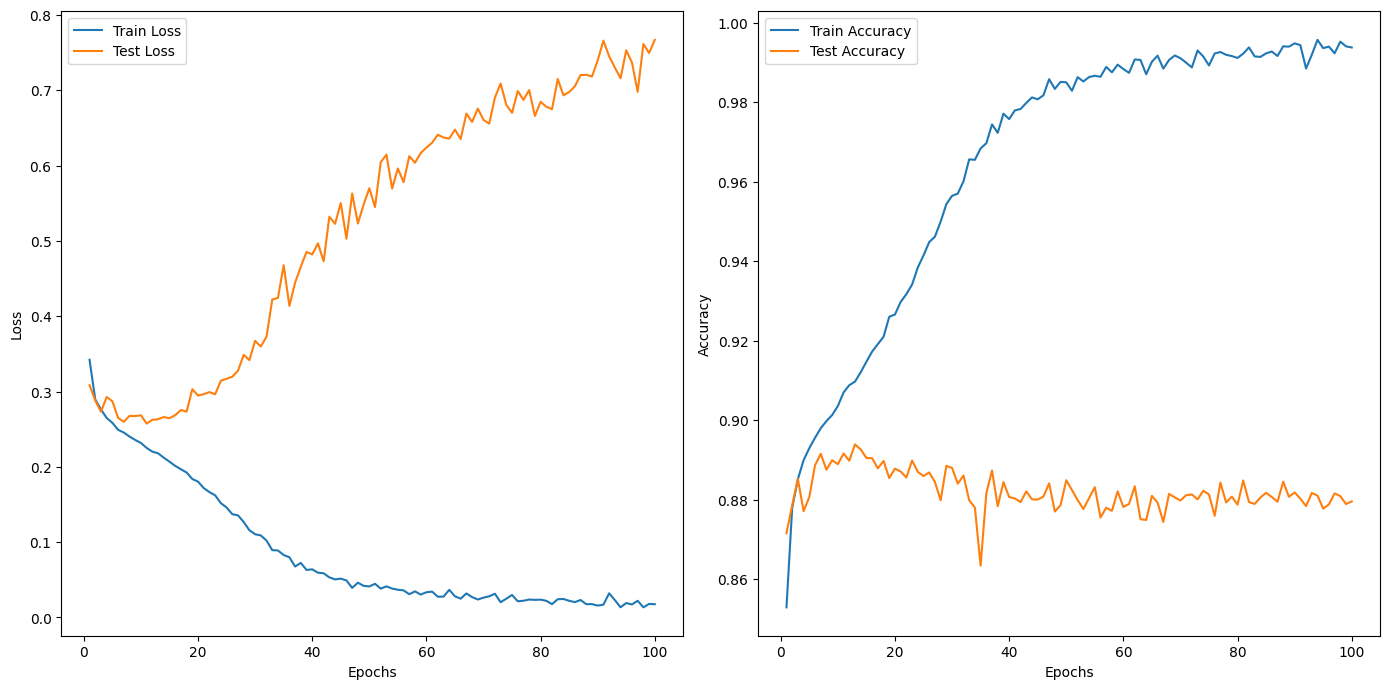

Starting final evaluation on test set...
Final Test Accuracy: 0.6081
Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.68      0.75      1019
         HYP       0.59      0.55      0.57       519
          MI       0.76      0.72      0.74      1102
        NORM       0.81      0.91      0.86      1906
        STTC       0.74      0.67      0.70      1055

   micro avg       0.77      0.75      0.76      5601
   macro avg       0.75      0.70      0.72      5601
weighted avg       0.77      0.75      0.76      5601
 samples avg       0.76      0.76      0.74      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


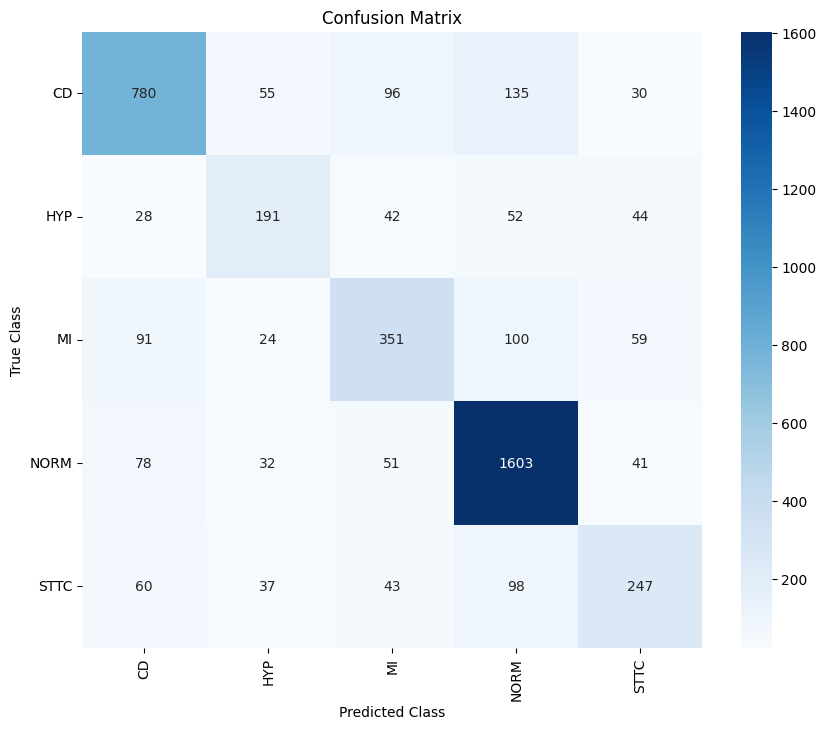

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=output_dim)

    def forward(self, x):
        return self.resnet(x)

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Calculate and display input shape size and standard deviation
print(f"Train input shape: {X_train.shape}")
print(f"Test input shape: {X_test.shape}")
train_std = np.std(X_train)
test_std = np.std(X_test)
print(f"Train data standard deviation: {train_std:.4f}")
print(f"Test data standard deviation: {test_std:.4f}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

# Print model summary
print("Model Summary:")
print(model)

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


Resnet 1D hyperparameter tunning

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from optuna.trial import TrialState
from tqdm import tqdm


# Custom Dataset Class
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)


# 1D Residual Block definition
class ResidualBlock1D(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, downsample=None):
        super(ResidualBlock1D, self).__init__()
        padding = kernel_size // 2  # Same padding
        self.conv1 = nn.Conv1d(in_channels, out_channels, kernel_size, stride=stride, padding=padding)
        self.bn1 = nn.BatchNorm1d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv1d(out_channels, out_channels, kernel_size, stride=1, padding=padding)
        self.bn2 = nn.BatchNorm1d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += identity
        out = self.relu(out)
        return out


# ResNet1D Model definition
class ResNet1D(nn.Module):
    def __init__(self, input_channels, output_dim, layers=[2, 2, 2], kernel_size=7):
        super(ResNet1D, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv1d(input_channels, self.in_channels, kernel_size=kernel_size, stride=2, padding=kernel_size // 2)
        self.bn1 = nn.BatchNorm1d(self.in_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self._make_layer(64, layers[0], kernel_size)
        self.layer2 = self._make_layer(128, layers[1], kernel_size, stride=2)
        self.layer3 = self._make_layer(256, layers[2], kernel_size, stride=2)

        self.avgpool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Linear(256, output_dim)

    def _make_layer(self, out_channels, blocks, kernel_size, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels:
            downsample = nn.Sequential(
                nn.Conv1d(self.in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm1d(out_channels)
            )
        layers = []
        layers.append(ResidualBlock1D(self.in_channels, out_channels, kernel_size, stride, downsample))
        self.in_channels = out_channels
        for _ in range(1, blocks):
            layers.append(ResidualBlock1D(out_channels, out_channels, kernel_size))
        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x


# Function to create and train the model
def train_model(trial, X_train, y_train, X_val, y_val, n_leads, output_dim):
    # Hyperparameters from Optuna
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.6)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)

    # Initialize the model
    model = ResNet1D(input_channels=n_leads, output_dim=output_dim).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # DataLoader
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Early stopping parameters
    patience = 10
    best_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.permute(0, 2, 1)  # Change shape to [batch, channels, length] for Conv1D
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                inputs = inputs.permute(0, 2, 1)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss, val_accuracy


# Cross-validation function with Optuna
def cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5):
    skf = StratifiedKFold(n_splits=n_splits)
    study = optuna.create_study(direction="minimize")

    def objective(trial):
        val_losses = []
        val_accuracies = []
        for train_idx, val_idx in skf.split(X, y.argmax(axis=1)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            val_loss, val_accuracy = train_model(trial, X_train, y_train, X_val, y_val, n_leads=n_leads, output_dim=output_dim)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        average_accuracy = np.mean(val_accuracies)
        print(f"Average validation accuracy for this trial: {average_accuracy:.4f}")
        return np.mean(val_losses)

    study.optimize(objective, n_trials=20, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print(f"Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(pruned_trials)}")
    print(f"  Number of complete trials: {len(complete_trials)}")

    best_trial = study.best_trial
    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return best_trial


# Sample dataset preparation function (use real data in practice)
def prepare_sample_data():
    # Placeholder function: Replace this with actual dataset preparation code
    n_samples = 1000
    n_leads = 12
    n_timesteps = 500
    X = np.random.randn(n_samples, n_timesteps, n_leads)
    y = np.random.randint(0, 2, size=(n_samples, 5))
    return X, y


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script execution
if __name__ == "__main__":
    # Prepare sample data (replace with actual ECG dataset loading and preprocessing)
    X, y = prepare_sample_data()

    # Perform cross-validation and hyperparameter optimization using Optuna
    best_trial = cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5)

    print("Finished cross-validation and optimization.")


[I 2024-08-28 15:35:52,399] A new study created in memory with name: no-name-68267b63-faf7-4205-b3e2-9f5e554ce243
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 14
Early stopping at epoch 14


[I 2024-08-28 15:36:11,682] Trial 0 finished with value: 1.313451889038086 and parameters: {'dropout_rate': 0.41257499992552527, 'lr': 0.007631969333178611}. Best is trial 0 with value: 1.313451889038086.


Early stopping at epoch 14
Average validation accuracy for this trial: 0.4948


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 14
Early stopping at epoch 13


[I 2024-08-28 15:36:29,849] Trial 1 finished with value: 1.4007351961135863 and parameters: {'dropout_rate': 0.5565806216383685, 'lr': 0.004949900637102985}. Best is trial 0 with value: 1.313451889038086.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.4916


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:36:44,465] Trial 2 finished with value: 1.1666596097946167 and parameters: {'dropout_rate': 0.5601837949037416, 'lr': 0.001569650884136948}. Best is trial 2 with value: 1.1666596097946167.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5086


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:36:59,100] Trial 3 finished with value: 0.9204505414962769 and parameters: {'dropout_rate': 0.32706711231764696, 'lr': 0.0003924949274946649}. Best is trial 3 with value: 0.9204505414962769.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5086


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:37:13,762] Trial 4 finished with value: 0.8387383742332458 and parameters: {'dropout_rate': 0.4171079827176578, 'lr': 0.00014611899321294075}. Best is trial 4 with value: 0.8387383742332458.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4960


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:37:14,062] Trial 5 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:37:14,367] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:37:29,026] Trial 7 finished with value: 1.162345860004425 and parameters: {'dropout_rate': 0.40437085243466164, 'lr': 0.001407919059987926}. Best is trial 4 with value: 0.8387383742332458.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5018


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:37:29,333] Trial 8 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:37:44,107] Trial 9 finished with value: 1.0760021176338195 and parameters: {'dropout_rate': 0.37471126678178823, 'lr': 0.0009292548112636023}. Best is trial 4 with value: 0.8387383742332458.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4868


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:37:44,425] Trial 10 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 12


[I 2024-08-28 15:37:59,431] Trial 11 finished with value: 0.8060467176437378 and parameters: {'dropout_rate': 0.317523323814064, 'lr': 6.298594831888133e-05}. Best is trial 11 with value: 0.8060467176437378.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4994


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:38:14,127] Trial 12 finished with value: 0.8309352226257323 and parameters: {'dropout_rate': 0.2902077290524857, 'lr': 9.435305853104096e-05}. Best is trial 11 with value: 0.8060467176437378.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4978


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:38:14,440] Trial 13 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:38:14,751] Trial 14 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 15:38:15,067] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The ve

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 15:38:30,739] Trial 19 finished with value: 0.8188819637298584 and parameters: {'dropout_rate': 0.33424079758805053, 'lr': 0.00010328133071377255}. Best is trial 11 with value: 0.8060467176437378.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4962
Study statistics: 
  Number of finished trials: 20
  Number of pruned trials: 10
  Number of complete trials: 10
Best trial:
  Value: 0.8060467176437378
  Params: 
    dropout_rate: 0.317523323814064
    lr: 6.298594831888133e-05
Finished cross-validation and optimization.


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:29<00:00, 244.92it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:10<00:00, 24.85it/s]


End of Epoch 1: Train Loss: 0.4726, Train Accuracy: 0.8046
End of Epoch 1: Test Loss: 0.3859, Test Accuracy: 0.8397

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 2: Train Loss: 0.3600, Train Accuracy: 0.8491
End of Epoch 2: Test Loss: 0.3394, Test Accuracy: 0.8553

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:10<00:00, 25.37it/s]


End of Epoch 3: Train Loss: 0.3252, Train Accuracy: 0.8641
End of Epoch 3: Test Loss: 0.3139, Test Accuracy: 0.8692

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:10<00:00, 25.89it/s]


End of Epoch 4: Train Loss: 0.3050, Train Accuracy: 0.8735
End of Epoch 4: Test Loss: 0.3012, Test Accuracy: 0.8737

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:10<00:00, 26.12it/s]


End of Epoch 5: Train Loss: 0.2910, Train Accuracy: 0.8795
End of Epoch 5: Test Loss: 0.2906, Test Accuracy: 0.8788

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:10<00:00, 26.11it/s]


End of Epoch 6: Train Loss: 0.2810, Train Accuracy: 0.8839
End of Epoch 6: Test Loss: 0.2879, Test Accuracy: 0.8806

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:10<00:00, 25.97it/s]


End of Epoch 7: Train Loss: 0.2744, Train Accuracy: 0.8860
End of Epoch 7: Test Loss: 0.2771, Test Accuracy: 0.8850

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 8: Train Loss: 0.2673, Train Accuracy: 0.8901
End of Epoch 8: Test Loss: 0.2775, Test Accuracy: 0.8844

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 9: Train Loss: 0.2604, Train Accuracy: 0.8929
End of Epoch 9: Test Loss: 0.2910, Test Accuracy: 0.8779

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:10<00:00, 25.64it/s]


End of Epoch 10: Train Loss: 0.2557, Train Accuracy: 0.8951
End of Epoch 10: Test Loss: 0.2756, Test Accuracy: 0.8849

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 11: Train Loss: 0.2509, Train Accuracy: 0.8968
End of Epoch 11: Test Loss: 0.2698, Test Accuracy: 0.8862

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:10<00:00, 25.80it/s]


End of Epoch 12: Train Loss: 0.2457, Train Accuracy: 0.8991
End of Epoch 12: Test Loss: 0.2718, Test Accuracy: 0.8856

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:10<00:00, 25.88it/s]


End of Epoch 13: Train Loss: 0.2414, Train Accuracy: 0.9010
End of Epoch 13: Test Loss: 0.2689, Test Accuracy: 0.8888

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:10<00:00, 25.87it/s]


End of Epoch 14: Train Loss: 0.2368, Train Accuracy: 0.9030
End of Epoch 14: Test Loss: 0.2929, Test Accuracy: 0.8772

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:10<00:00, 25.86it/s]


End of Epoch 15: Train Loss: 0.2336, Train Accuracy: 0.9039
End of Epoch 15: Test Loss: 0.2693, Test Accuracy: 0.8875

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:10<00:00, 25.82it/s]


End of Epoch 16: Train Loss: 0.2290, Train Accuracy: 0.9062
End of Epoch 16: Test Loss: 0.2706, Test Accuracy: 0.8868

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:10<00:00, 25.83it/s]


End of Epoch 17: Train Loss: 0.2268, Train Accuracy: 0.9074
End of Epoch 17: Test Loss: 0.2703, Test Accuracy: 0.8874

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:10<00:00, 25.82it/s]


End of Epoch 18: Train Loss: 0.2216, Train Accuracy: 0.9102
End of Epoch 18: Test Loss: 0.2760, Test Accuracy: 0.8873

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 19: Train Loss: 0.2187, Train Accuracy: 0.9109
End of Epoch 19: Test Loss: 0.2693, Test Accuracy: 0.8880

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 20: Train Loss: 0.2143, Train Accuracy: 0.9138
End of Epoch 20: Test Loss: 0.2806, Test Accuracy: 0.8845

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 21: Train Loss: 0.2097, Train Accuracy: 0.9147
End of Epoch 21: Test Loss: 0.2708, Test Accuracy: 0.8874

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:10<00:00, 25.72it/s]


End of Epoch 22: Train Loss: 0.2073, Train Accuracy: 0.9166
End of Epoch 22: Test Loss: 0.2764, Test Accuracy: 0.8855

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:10<00:00, 25.70it/s]


End of Epoch 23: Train Loss: 0.2031, Train Accuracy: 0.9186
End of Epoch 23: Test Loss: 0.2718, Test Accuracy: 0.8872

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:10<00:00, 25.72it/s]


End of Epoch 24: Train Loss: 0.1997, Train Accuracy: 0.9204
End of Epoch 24: Test Loss: 0.2766, Test Accuracy: 0.8868

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 25: Train Loss: 0.1955, Train Accuracy: 0.9222
End of Epoch 25: Test Loss: 0.2718, Test Accuracy: 0.8889

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:10<00:00, 25.79it/s]


End of Epoch 26: Train Loss: 0.1911, Train Accuracy: 0.9235
End of Epoch 26: Test Loss: 0.2854, Test Accuracy: 0.8877

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 27: Train Loss: 0.1878, Train Accuracy: 0.9259
End of Epoch 27: Test Loss: 0.2829, Test Accuracy: 0.8853

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 28: Train Loss: 0.1844, Train Accuracy: 0.9275
End of Epoch 28: Test Loss: 0.2766, Test Accuracy: 0.8862

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 29: Train Loss: 0.1804, Train Accuracy: 0.9289
End of Epoch 29: Test Loss: 0.2790, Test Accuracy: 0.8879

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:10<00:00, 25.72it/s]


End of Epoch 30: Train Loss: 0.1755, Train Accuracy: 0.9312
End of Epoch 30: Test Loss: 0.2951, Test Accuracy: 0.8869

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:10<00:00, 25.67it/s]


End of Epoch 31: Train Loss: 0.1721, Train Accuracy: 0.9328
End of Epoch 31: Test Loss: 0.2992, Test Accuracy: 0.8772

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:10<00:00, 25.67it/s]


End of Epoch 32: Train Loss: 0.1682, Train Accuracy: 0.9343
End of Epoch 32: Test Loss: 0.2892, Test Accuracy: 0.8815

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


End of Epoch 33: Train Loss: 0.1655, Train Accuracy: 0.9362
End of Epoch 33: Test Loss: 0.2924, Test Accuracy: 0.8865

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:10<00:00, 25.68it/s]


End of Epoch 34: Train Loss: 0.1616, Train Accuracy: 0.9374
End of Epoch 34: Test Loss: 0.2953, Test Accuracy: 0.8810

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


End of Epoch 35: Train Loss: 0.1579, Train Accuracy: 0.9385
End of Epoch 35: Test Loss: 0.2886, Test Accuracy: 0.8864

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 36: Train Loss: 0.1519, Train Accuracy: 0.9425
End of Epoch 36: Test Loss: 0.2913, Test Accuracy: 0.8874

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 37: Train Loss: 0.1494, Train Accuracy: 0.9426
End of Epoch 37: Test Loss: 0.3121, Test Accuracy: 0.8801

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 38: Train Loss: 0.1481, Train Accuracy: 0.9439
End of Epoch 38: Test Loss: 0.3246, Test Accuracy: 0.8728

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 39: Train Loss: 0.1434, Train Accuracy: 0.9457
End of Epoch 39: Test Loss: 0.2900, Test Accuracy: 0.8869

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:10<00:00, 25.79it/s]


End of Epoch 40: Train Loss: 0.1381, Train Accuracy: 0.9482
End of Epoch 40: Test Loss: 0.3039, Test Accuracy: 0.8853

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:10<00:00, 25.80it/s]


End of Epoch 41: Train Loss: 0.1358, Train Accuracy: 0.9496
End of Epoch 41: Test Loss: 0.3114, Test Accuracy: 0.8849

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:10<00:00, 25.83it/s]


End of Epoch 42: Train Loss: 0.1323, Train Accuracy: 0.9510
End of Epoch 42: Test Loss: 0.3418, Test Accuracy: 0.8789

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:10<00:00, 25.88it/s]


End of Epoch 43: Train Loss: 0.1303, Train Accuracy: 0.9511
End of Epoch 43: Test Loss: 0.3111, Test Accuracy: 0.8838

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:10<00:00, 25.75it/s]


End of Epoch 44: Train Loss: 0.1256, Train Accuracy: 0.9533
End of Epoch 44: Test Loss: 0.3424, Test Accuracy: 0.8785

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 45: Train Loss: 0.1216, Train Accuracy: 0.9560
End of Epoch 45: Test Loss: 0.3668, Test Accuracy: 0.8764

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:10<00:00, 25.61it/s]


End of Epoch 46: Train Loss: 0.1191, Train Accuracy: 0.9567
End of Epoch 46: Test Loss: 0.3735, Test Accuracy: 0.8774

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:10<00:00, 25.72it/s]


End of Epoch 47: Train Loss: 0.1138, Train Accuracy: 0.9594
End of Epoch 47: Test Loss: 0.3243, Test Accuracy: 0.8832

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:10<00:00, 25.65it/s]


End of Epoch 48: Train Loss: 0.1112, Train Accuracy: 0.9611
End of Epoch 48: Test Loss: 0.3256, Test Accuracy: 0.8835

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:10<00:00, 25.54it/s]


End of Epoch 49: Train Loss: 0.1100, Train Accuracy: 0.9610
End of Epoch 49: Test Loss: 0.3533, Test Accuracy: 0.8795

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:10<00:00, 25.72it/s]


End of Epoch 50: Train Loss: 0.1046, Train Accuracy: 0.9633
End of Epoch 50: Test Loss: 0.3423, Test Accuracy: 0.8719

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:10<00:00, 25.68it/s]


End of Epoch 51: Train Loss: 0.1009, Train Accuracy: 0.9653
End of Epoch 51: Test Loss: 0.3450, Test Accuracy: 0.8767

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:10<00:00, 25.56it/s]


End of Epoch 52: Train Loss: 0.1023, Train Accuracy: 0.9641
End of Epoch 52: Test Loss: 0.3356, Test Accuracy: 0.8815

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:10<00:00, 25.63it/s]


End of Epoch 53: Train Loss: 0.0979, Train Accuracy: 0.9659
End of Epoch 53: Test Loss: 0.3629, Test Accuracy: 0.8777

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 54: Train Loss: 0.0943, Train Accuracy: 0.9683
End of Epoch 54: Test Loss: 0.3479, Test Accuracy: 0.8779

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 55: Train Loss: 0.0927, Train Accuracy: 0.9677
End of Epoch 55: Test Loss: 0.3429, Test Accuracy: 0.8825

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:10<00:00, 25.78it/s]


End of Epoch 56: Train Loss: 0.0896, Train Accuracy: 0.9697
End of Epoch 56: Test Loss: 0.3862, Test Accuracy: 0.8742

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:10<00:00, 25.80it/s]


End of Epoch 57: Train Loss: 0.0874, Train Accuracy: 0.9707
End of Epoch 57: Test Loss: 0.3607, Test Accuracy: 0.8760

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 58: Train Loss: 0.0860, Train Accuracy: 0.9714
End of Epoch 58: Test Loss: 0.3870, Test Accuracy: 0.8663

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 59: Train Loss: 0.0834, Train Accuracy: 0.9722
End of Epoch 59: Test Loss: 0.3628, Test Accuracy: 0.8751

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:10<00:00, 25.67it/s]


End of Epoch 60: Train Loss: 0.0797, Train Accuracy: 0.9738
End of Epoch 60: Test Loss: 0.3710, Test Accuracy: 0.8798

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:10<00:00, 25.70it/s]


End of Epoch 61: Train Loss: 0.0770, Train Accuracy: 0.9751
End of Epoch 61: Test Loss: 0.4293, Test Accuracy: 0.8762

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


End of Epoch 62: Train Loss: 0.0768, Train Accuracy: 0.9747
End of Epoch 62: Test Loss: 0.3601, Test Accuracy: 0.8827

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:10<00:00, 25.66it/s]


End of Epoch 63: Train Loss: 0.0740, Train Accuracy: 0.9755
End of Epoch 63: Test Loss: 0.3659, Test Accuracy: 0.8823

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 64: Train Loss: 0.0734, Train Accuracy: 0.9756
End of Epoch 64: Test Loss: 0.3947, Test Accuracy: 0.8723

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 65: Train Loss: 0.0688, Train Accuracy: 0.9778
End of Epoch 65: Test Loss: 0.3939, Test Accuracy: 0.8800

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 66: Train Loss: 0.0675, Train Accuracy: 0.9781
End of Epoch 66: Test Loss: 0.3998, Test Accuracy: 0.8716

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 67: Train Loss: 0.0663, Train Accuracy: 0.9788
End of Epoch 67: Test Loss: 0.3959, Test Accuracy: 0.8755

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 68: Train Loss: 0.0628, Train Accuracy: 0.9803
End of Epoch 68: Test Loss: 0.4401, Test Accuracy: 0.8766

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 69: Train Loss: 0.0629, Train Accuracy: 0.9801
End of Epoch 69: Test Loss: 0.4038, Test Accuracy: 0.8772

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:10<00:00, 25.73it/s]


End of Epoch 70: Train Loss: 0.0603, Train Accuracy: 0.9814
End of Epoch 70: Test Loss: 0.4017, Test Accuracy: 0.8826

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 71: Train Loss: 0.0599, Train Accuracy: 0.9810
End of Epoch 71: Test Loss: 0.4733, Test Accuracy: 0.8754

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:10<00:00, 25.70it/s]


End of Epoch 72: Train Loss: 0.0550, Train Accuracy: 0.9842
End of Epoch 72: Test Loss: 0.4084, Test Accuracy: 0.8762

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 73: Train Loss: 0.0563, Train Accuracy: 0.9826
End of Epoch 73: Test Loss: 0.3973, Test Accuracy: 0.8799

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:10<00:00, 25.68it/s]


End of Epoch 74: Train Loss: 0.0540, Train Accuracy: 0.9835
End of Epoch 74: Test Loss: 0.4226, Test Accuracy: 0.8759

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:10<00:00, 25.69it/s]


End of Epoch 75: Train Loss: 0.0532, Train Accuracy: 0.9843
End of Epoch 75: Test Loss: 0.4466, Test Accuracy: 0.8797

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 76: Train Loss: 0.0521, Train Accuracy: 0.9839
End of Epoch 76: Test Loss: 0.4084, Test Accuracy: 0.8757

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:10<00:00, 25.75it/s]


End of Epoch 77: Train Loss: 0.0501, Train Accuracy: 0.9847
End of Epoch 77: Test Loss: 0.4731, Test Accuracy: 0.8631

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:10<00:00, 25.70it/s]


End of Epoch 78: Train Loss: 0.0513, Train Accuracy: 0.9842
End of Epoch 78: Test Loss: 0.4183, Test Accuracy: 0.8805

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 79: Train Loss: 0.0486, Train Accuracy: 0.9861
End of Epoch 79: Test Loss: 0.4124, Test Accuracy: 0.8823

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 80: Train Loss: 0.0464, Train Accuracy: 0.9867
End of Epoch 80: Test Loss: 0.4006, Test Accuracy: 0.8802

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:10<00:00, 25.71it/s]


End of Epoch 81: Train Loss: 0.0421, Train Accuracy: 0.9883
End of Epoch 81: Test Loss: 0.4967, Test Accuracy: 0.8721

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 82: Train Loss: 0.0438, Train Accuracy: 0.9876
End of Epoch 82: Test Loss: 0.4375, Test Accuracy: 0.8727

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 83: Train Loss: 0.0417, Train Accuracy: 0.9887
End of Epoch 83: Test Loss: 0.4371, Test Accuracy: 0.8755

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:10<00:00, 25.73it/s]


End of Epoch 84: Train Loss: 0.0436, Train Accuracy: 0.9875
End of Epoch 84: Test Loss: 0.4318, Test Accuracy: 0.8808

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:10<00:00, 25.73it/s]


End of Epoch 85: Train Loss: 0.0419, Train Accuracy: 0.9874
End of Epoch 85: Test Loss: 0.4405, Test Accuracy: 0.8717

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:10<00:00, 25.75it/s]


End of Epoch 86: Train Loss: 0.0407, Train Accuracy: 0.9882
End of Epoch 86: Test Loss: 0.4507, Test Accuracy: 0.8785

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 87: Train Loss: 0.0393, Train Accuracy: 0.9890
End of Epoch 87: Test Loss: 0.4475, Test Accuracy: 0.8787

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:10<00:00, 25.70it/s]


End of Epoch 88: Train Loss: 0.0385, Train Accuracy: 0.9892
End of Epoch 88: Test Loss: 0.4402, Test Accuracy: 0.8799

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 89: Train Loss: 0.0366, Train Accuracy: 0.9899
End of Epoch 89: Test Loss: 0.4826, Test Accuracy: 0.8799

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 90: Train Loss: 0.0371, Train Accuracy: 0.9894
End of Epoch 90: Test Loss: 0.4437, Test Accuracy: 0.8801

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 91: Train Loss: 0.0351, Train Accuracy: 0.9905
End of Epoch 91: Test Loss: 0.4513, Test Accuracy: 0.8796

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 92: Train Loss: 0.0349, Train Accuracy: 0.9902
End of Epoch 92: Test Loss: 0.4920, Test Accuracy: 0.8760

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 93: Train Loss: 0.0361, Train Accuracy: 0.9901
End of Epoch 93: Test Loss: 0.4469, Test Accuracy: 0.8812

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:10<00:00, 25.80it/s]


End of Epoch 94: Train Loss: 0.0327, Train Accuracy: 0.9909
End of Epoch 94: Test Loss: 0.4840, Test Accuracy: 0.8772

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:10<00:00, 25.81it/s]


End of Epoch 95: Train Loss: 0.0315, Train Accuracy: 0.9916
End of Epoch 95: Test Loss: 0.4922, Test Accuracy: 0.8740

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:10<00:00, 25.77it/s]


End of Epoch 96: Train Loss: 0.0344, Train Accuracy: 0.9907
End of Epoch 96: Test Loss: 0.5365, Test Accuracy: 0.8716

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:10<00:00, 25.81it/s]


End of Epoch 97: Train Loss: 0.0329, Train Accuracy: 0.9912
End of Epoch 97: Test Loss: 0.4918, Test Accuracy: 0.8752

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 98: Train Loss: 0.0321, Train Accuracy: 0.9914
End of Epoch 98: Test Loss: 0.4798, Test Accuracy: 0.8754

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:10<00:00, 25.76it/s]


End of Epoch 99: Train Loss: 0.0275, Train Accuracy: 0.9933
End of Epoch 99: Test Loss: 0.5256, Test Accuracy: 0.8610

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:10<00:00, 25.74it/s]


End of Epoch 100: Train Loss: 0.0294, Train Accuracy: 0.9917
End of Epoch 100: Test Loss: 0.5085, Test Accuracy: 0.8774
Training complete. Plotting loss and accuracy curves...


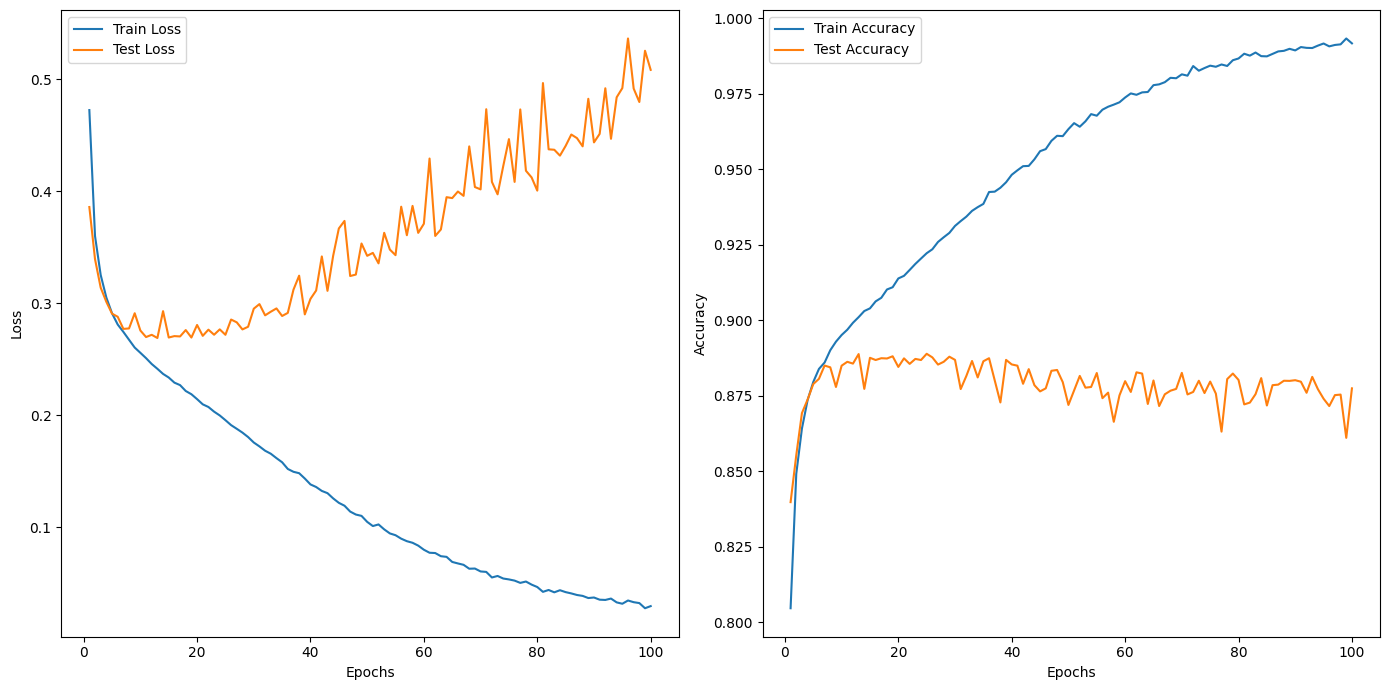

Starting final evaluation on test set...
Final Test Accuracy: 0.6039
Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.67      0.74      1019
         HYP       0.63      0.54      0.58       519
          MI       0.83      0.57      0.67      1102
        NORM       0.80      0.92      0.86      1906
        STTC       0.71      0.73      0.72      1055

   micro avg       0.78      0.73      0.75      5601
   macro avg       0.76      0.69      0.71      5601
weighted avg       0.78      0.73      0.75      5601
 samples avg       0.76      0.75      0.74      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


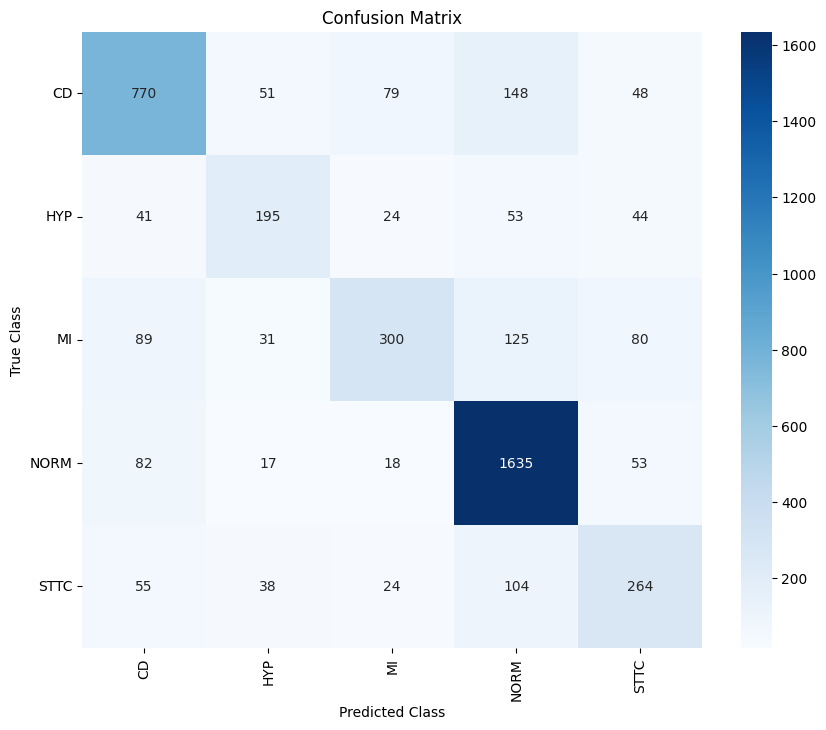

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=output_dim)

    def forward(self, x):
        return self.resnet(x)

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer with best parameters from Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

# Use the best hyperparameters from Optuna
dropout_rate = 0.317523323814064  # Best trial dropout rate
lr = 6.298594831888133e-05  # Best trial learning rate

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


Increase layer

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:36<00:00, 225.12it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:11<00:00, 24.78it/s]


End of Epoch 1: Train Loss: 0.4944, Train Accuracy: 0.7852
End of Epoch 1: Test Loss: 0.3784, Test Accuracy: 0.8281

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 2: Train Loss: 0.3502, Train Accuracy: 0.8471
End of Epoch 2: Test Loss: 0.3309, Test Accuracy: 0.8577

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 3: Train Loss: 0.3174, Train Accuracy: 0.8647
End of Epoch 3: Test Loss: 0.3106, Test Accuracy: 0.8679

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 4: Train Loss: 0.2993, Train Accuracy: 0.8735
End of Epoch 4: Test Loss: 0.2942, Test Accuracy: 0.8767

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 5: Train Loss: 0.2852, Train Accuracy: 0.8800
End of Epoch 5: Test Loss: 0.2917, Test Accuracy: 0.8775

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:11<00:00, 24.79it/s]


End of Epoch 6: Train Loss: 0.2742, Train Accuracy: 0.8862
End of Epoch 6: Test Loss: 0.2909, Test Accuracy: 0.8773

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:10<00:00, 24.92it/s]


End of Epoch 7: Train Loss: 0.2642, Train Accuracy: 0.8899
End of Epoch 7: Test Loss: 0.2755, Test Accuracy: 0.8837

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:11<00:00, 24.79it/s]


End of Epoch 8: Train Loss: 0.2578, Train Accuracy: 0.8934
End of Epoch 8: Test Loss: 0.2764, Test Accuracy: 0.8833

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 9: Train Loss: 0.2518, Train Accuracy: 0.8955
End of Epoch 9: Test Loss: 0.2810, Test Accuracy: 0.8841

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 10: Train Loss: 0.2472, Train Accuracy: 0.8975
End of Epoch 10: Test Loss: 0.2739, Test Accuracy: 0.8854

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 11: Train Loss: 0.2418, Train Accuracy: 0.8991
End of Epoch 11: Test Loss: 0.2834, Test Accuracy: 0.8797

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 12: Train Loss: 0.2368, Train Accuracy: 0.9025
End of Epoch 12: Test Loss: 0.2726, Test Accuracy: 0.8853

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 13: Train Loss: 0.2318, Train Accuracy: 0.9046
End of Epoch 13: Test Loss: 0.2719, Test Accuracy: 0.8870

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 14: Train Loss: 0.2256, Train Accuracy: 0.9086
End of Epoch 14: Test Loss: 0.2999, Test Accuracy: 0.8811

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 15: Train Loss: 0.2218, Train Accuracy: 0.9102
End of Epoch 15: Test Loss: 0.2684, Test Accuracy: 0.8888

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 16: Train Loss: 0.2159, Train Accuracy: 0.9115
End of Epoch 16: Test Loss: 0.3135, Test Accuracy: 0.8669

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 17: Train Loss: 0.2119, Train Accuracy: 0.9144
End of Epoch 17: Test Loss: 0.3013, Test Accuracy: 0.8825

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 18: Train Loss: 0.2078, Train Accuracy: 0.9155
End of Epoch 18: Test Loss: 0.2770, Test Accuracy: 0.8874

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:11<00:00, 24.77it/s]


End of Epoch 19: Train Loss: 0.2008, Train Accuracy: 0.9184
End of Epoch 19: Test Loss: 0.3055, Test Accuracy: 0.8817

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:10<00:00, 24.90it/s]


End of Epoch 20: Train Loss: 0.1950, Train Accuracy: 0.9210
End of Epoch 20: Test Loss: 0.3050, Test Accuracy: 0.8735

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:10<00:00, 24.87it/s]


End of Epoch 21: Train Loss: 0.1917, Train Accuracy: 0.9236
End of Epoch 21: Test Loss: 0.2958, Test Accuracy: 0.8841

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:10<00:00, 24.83it/s]


End of Epoch 22: Train Loss: 0.1859, Train Accuracy: 0.9256
End of Epoch 22: Test Loss: 0.3426, Test Accuracy: 0.8624

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:10<00:00, 24.86it/s]


End of Epoch 23: Train Loss: 0.1790, Train Accuracy: 0.9289
End of Epoch 23: Test Loss: 0.3129, Test Accuracy: 0.8748

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:10<00:00, 24.82it/s]


End of Epoch 24: Train Loss: 0.1747, Train Accuracy: 0.9306
End of Epoch 24: Test Loss: 0.3131, Test Accuracy: 0.8819

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:10<00:00, 24.84it/s]


End of Epoch 25: Train Loss: 0.1716, Train Accuracy: 0.9316
End of Epoch 25: Test Loss: 0.3632, Test Accuracy: 0.8600

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:10<00:00, 24.82it/s]


End of Epoch 26: Train Loss: 0.1649, Train Accuracy: 0.9349
End of Epoch 26: Test Loss: 0.3133, Test Accuracy: 0.8788

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 27: Train Loss: 0.1608, Train Accuracy: 0.9373
End of Epoch 27: Test Loss: 0.3172, Test Accuracy: 0.8826

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 28: Train Loss: 0.1563, Train Accuracy: 0.9387
End of Epoch 28: Test Loss: 0.3978, Test Accuracy: 0.8690

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 29: Train Loss: 0.1498, Train Accuracy: 0.9419
End of Epoch 29: Test Loss: 0.3193, Test Accuracy: 0.8816

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:11<00:00, 24.81it/s]


End of Epoch 30: Train Loss: 0.1451, Train Accuracy: 0.9437
End of Epoch 30: Test Loss: 0.3536, Test Accuracy: 0.8729

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:10<00:00, 24.86it/s]


End of Epoch 31: Train Loss: 0.1390, Train Accuracy: 0.9457
End of Epoch 31: Test Loss: 0.3313, Test Accuracy: 0.8806

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 32: Train Loss: 0.1333, Train Accuracy: 0.9488
End of Epoch 32: Test Loss: 0.3697, Test Accuracy: 0.8771

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 33: Train Loss: 0.1319, Train Accuracy: 0.9488
End of Epoch 33: Test Loss: 0.3491, Test Accuracy: 0.8776

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 34: Train Loss: 0.1263, Train Accuracy: 0.9517
End of Epoch 34: Test Loss: 0.3713, Test Accuracy: 0.8792

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 35: Train Loss: 0.1189, Train Accuracy: 0.9546
End of Epoch 35: Test Loss: 0.3862, Test Accuracy: 0.8679

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 36: Train Loss: 0.1173, Train Accuracy: 0.9550
End of Epoch 36: Test Loss: 0.3890, Test Accuracy: 0.8809

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 37: Train Loss: 0.1099, Train Accuracy: 0.9588
End of Epoch 37: Test Loss: 0.4335, Test Accuracy: 0.8709

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 38: Train Loss: 0.1088, Train Accuracy: 0.9585
End of Epoch 38: Test Loss: 0.3721, Test Accuracy: 0.8795

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 39: Train Loss: 0.1017, Train Accuracy: 0.9615
End of Epoch 39: Test Loss: 0.3787, Test Accuracy: 0.8810

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:11<00:00, 24.76it/s]


End of Epoch 40: Train Loss: 0.0984, Train Accuracy: 0.9639
End of Epoch 40: Test Loss: 0.4065, Test Accuracy: 0.8689

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 41: Train Loss: 0.0991, Train Accuracy: 0.9626
End of Epoch 41: Test Loss: 0.4149, Test Accuracy: 0.8679

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 42: Train Loss: 0.0911, Train Accuracy: 0.9662
End of Epoch 42: Test Loss: 0.3990, Test Accuracy: 0.8780

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 43: Train Loss: 0.0864, Train Accuracy: 0.9679
End of Epoch 43: Test Loss: 0.4459, Test Accuracy: 0.8766

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 44: Train Loss: 0.0865, Train Accuracy: 0.9681
End of Epoch 44: Test Loss: 0.4114, Test Accuracy: 0.8755

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 45: Train Loss: 0.0813, Train Accuracy: 0.9696
End of Epoch 45: Test Loss: 0.4965, Test Accuracy: 0.8558

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:10<00:00, 24.88it/s]


End of Epoch 46: Train Loss: 0.0802, Train Accuracy: 0.9702
End of Epoch 46: Test Loss: 0.4677, Test Accuracy: 0.8583

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 47: Train Loss: 0.0741, Train Accuracy: 0.9733
End of Epoch 47: Test Loss: 0.4404, Test Accuracy: 0.8796

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 48: Train Loss: 0.0740, Train Accuracy: 0.9727
End of Epoch 48: Test Loss: 0.4828, Test Accuracy: 0.8635

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 49: Train Loss: 0.0712, Train Accuracy: 0.9742
End of Epoch 49: Test Loss: 0.4942, Test Accuracy: 0.8609

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 50: Train Loss: 0.0667, Train Accuracy: 0.9759
End of Epoch 50: Test Loss: 0.4563, Test Accuracy: 0.8783

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 51: Train Loss: 0.0650, Train Accuracy: 0.9763
End of Epoch 51: Test Loss: 0.4977, Test Accuracy: 0.8767

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 52: Train Loss: 0.0642, Train Accuracy: 0.9768
End of Epoch 52: Test Loss: 0.4628, Test Accuracy: 0.8725

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 53: Train Loss: 0.0618, Train Accuracy: 0.9776
End of Epoch 53: Test Loss: 0.5198, Test Accuracy: 0.8731

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 54: Train Loss: 0.0610, Train Accuracy: 0.9777
End of Epoch 54: Test Loss: 0.5449, Test Accuracy: 0.8598

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 55: Train Loss: 0.0566, Train Accuracy: 0.9801
End of Epoch 55: Test Loss: 0.4892, Test Accuracy: 0.8771

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 56: Train Loss: 0.0523, Train Accuracy: 0.9814
End of Epoch 56: Test Loss: 0.4929, Test Accuracy: 0.8757

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 57: Train Loss: 0.0531, Train Accuracy: 0.9809
End of Epoch 57: Test Loss: 0.5541, Test Accuracy: 0.8677

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 58: Train Loss: 0.0529, Train Accuracy: 0.9811
End of Epoch 58: Test Loss: 0.5235, Test Accuracy: 0.8745

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 59: Train Loss: 0.0495, Train Accuracy: 0.9831
End of Epoch 59: Test Loss: 0.5240, Test Accuracy: 0.8722

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 60: Train Loss: 0.0481, Train Accuracy: 0.9835
End of Epoch 60: Test Loss: 0.5148, Test Accuracy: 0.8756

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 61: Train Loss: 0.0484, Train Accuracy: 0.9833
End of Epoch 61: Test Loss: 0.5418, Test Accuracy: 0.8764

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 62: Train Loss: 0.0446, Train Accuracy: 0.9845
End of Epoch 62: Test Loss: 0.5222, Test Accuracy: 0.8731

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 63: Train Loss: 0.0410, Train Accuracy: 0.9859
End of Epoch 63: Test Loss: 0.6157, Test Accuracy: 0.8502

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 64: Train Loss: 0.0466, Train Accuracy: 0.9834
End of Epoch 64: Test Loss: 0.5527, Test Accuracy: 0.8725

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 65: Train Loss: 0.0420, Train Accuracy: 0.9856
End of Epoch 65: Test Loss: 0.5572, Test Accuracy: 0.8750

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 66: Train Loss: 0.0449, Train Accuracy: 0.9842
End of Epoch 66: Test Loss: 0.6071, Test Accuracy: 0.8679

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 67: Train Loss: 0.0385, Train Accuracy: 0.9872
End of Epoch 67: Test Loss: 0.6025, Test Accuracy: 0.8581

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 68: Train Loss: 0.0386, Train Accuracy: 0.9867
End of Epoch 68: Test Loss: 0.5688, Test Accuracy: 0.8736

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 69: Train Loss: 0.0375, Train Accuracy: 0.9871
End of Epoch 69: Test Loss: 0.6123, Test Accuracy: 0.8739

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 70: Train Loss: 0.0381, Train Accuracy: 0.9866
End of Epoch 70: Test Loss: 0.5752, Test Accuracy: 0.8714

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 71: Train Loss: 0.0376, Train Accuracy: 0.9868
End of Epoch 71: Test Loss: 0.6455, Test Accuracy: 0.8715

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 72: Train Loss: 0.0359, Train Accuracy: 0.9880
End of Epoch 72: Test Loss: 0.7207, Test Accuracy: 0.8437

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 73: Train Loss: 0.0366, Train Accuracy: 0.9873
End of Epoch 73: Test Loss: 0.6060, Test Accuracy: 0.8761

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 74: Train Loss: 0.0325, Train Accuracy: 0.9892
End of Epoch 74: Test Loss: 0.5968, Test Accuracy: 0.8697

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 75: Train Loss: 0.0336, Train Accuracy: 0.9883
End of Epoch 75: Test Loss: 0.6571, Test Accuracy: 0.8684

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 76: Train Loss: 0.0317, Train Accuracy: 0.9894
End of Epoch 76: Test Loss: 0.6696, Test Accuracy: 0.8576

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 77: Train Loss: 0.0305, Train Accuracy: 0.9897
End of Epoch 77: Test Loss: 0.6402, Test Accuracy: 0.8658

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 78: Train Loss: 0.0318, Train Accuracy: 0.9893
End of Epoch 78: Test Loss: 0.7504, Test Accuracy: 0.8711

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 79: Train Loss: 0.0308, Train Accuracy: 0.9899
End of Epoch 79: Test Loss: 0.6577, Test Accuracy: 0.8780

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 80: Train Loss: 0.0369, Train Accuracy: 0.9877
End of Epoch 80: Test Loss: 0.6585, Test Accuracy: 0.8761

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 81: Train Loss: 0.0297, Train Accuracy: 0.9901
End of Epoch 81: Test Loss: 0.6574, Test Accuracy: 0.8693

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 82: Train Loss: 0.0322, Train Accuracy: 0.9890
End of Epoch 82: Test Loss: 0.6971, Test Accuracy: 0.8505

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:11<00:00, 24.79it/s]


End of Epoch 83: Train Loss: 0.0297, Train Accuracy: 0.9902
End of Epoch 83: Test Loss: 0.6460, Test Accuracy: 0.8715

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:10<00:00, 24.88it/s]


End of Epoch 84: Train Loss: 0.0310, Train Accuracy: 0.9899
End of Epoch 84: Test Loss: 0.6326, Test Accuracy: 0.8747

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 85: Train Loss: 0.0250, Train Accuracy: 0.9918
End of Epoch 85: Test Loss: 0.8341, Test Accuracy: 0.8402

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:10<00:00, 24.84it/s]


End of Epoch 86: Train Loss: 0.0262, Train Accuracy: 0.9913
End of Epoch 86: Test Loss: 0.6532, Test Accuracy: 0.8782

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:11<00:00, 24.81it/s]


End of Epoch 87: Train Loss: 0.0267, Train Accuracy: 0.9912
End of Epoch 87: Test Loss: 0.6517, Test Accuracy: 0.8683

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 88: Train Loss: 0.0292, Train Accuracy: 0.9899
End of Epoch 88: Test Loss: 0.7874, Test Accuracy: 0.8386

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 89: Train Loss: 0.0309, Train Accuracy: 0.9898
End of Epoch 89: Test Loss: 0.7705, Test Accuracy: 0.8545

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 90: Train Loss: 0.0287, Train Accuracy: 0.9906
End of Epoch 90: Test Loss: 0.6342, Test Accuracy: 0.8766

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 91: Train Loss: 0.0251, Train Accuracy: 0.9919
End of Epoch 91: Test Loss: 0.6680, Test Accuracy: 0.8722

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 92: Train Loss: 0.0231, Train Accuracy: 0.9924
End of Epoch 92: Test Loss: 0.6873, Test Accuracy: 0.8743

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 93: Train Loss: 0.0242, Train Accuracy: 0.9921
End of Epoch 93: Test Loss: 0.6954, Test Accuracy: 0.8590

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:10<00:00, 24.85it/s]


End of Epoch 94: Train Loss: 0.0228, Train Accuracy: 0.9922
End of Epoch 94: Test Loss: 0.6646, Test Accuracy: 0.8710

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:10<00:00, 24.82it/s]


End of Epoch 95: Train Loss: 0.0255, Train Accuracy: 0.9914
End of Epoch 95: Test Loss: 0.6968, Test Accuracy: 0.8735

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:10<00:00, 24.90it/s]


End of Epoch 96: Train Loss: 0.0268, Train Accuracy: 0.9909
End of Epoch 96: Test Loss: 0.7414, Test Accuracy: 0.8719

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:11<00:00, 24.79it/s]


End of Epoch 97: Train Loss: 0.0261, Train Accuracy: 0.9916
End of Epoch 97: Test Loss: 0.7363, Test Accuracy: 0.8604

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 98: Train Loss: 0.0266, Train Accuracy: 0.9911
End of Epoch 98: Test Loss: 0.6551, Test Accuracy: 0.8722

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 99: Train Loss: 0.0252, Train Accuracy: 0.9918
End of Epoch 99: Test Loss: 0.6870, Test Accuracy: 0.8742

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 100: Train Loss: 0.0221, Train Accuracy: 0.9929
End of Epoch 100: Test Loss: 0.6779, Test Accuracy: 0.8712
Training complete. Plotting loss and accuracy curves...


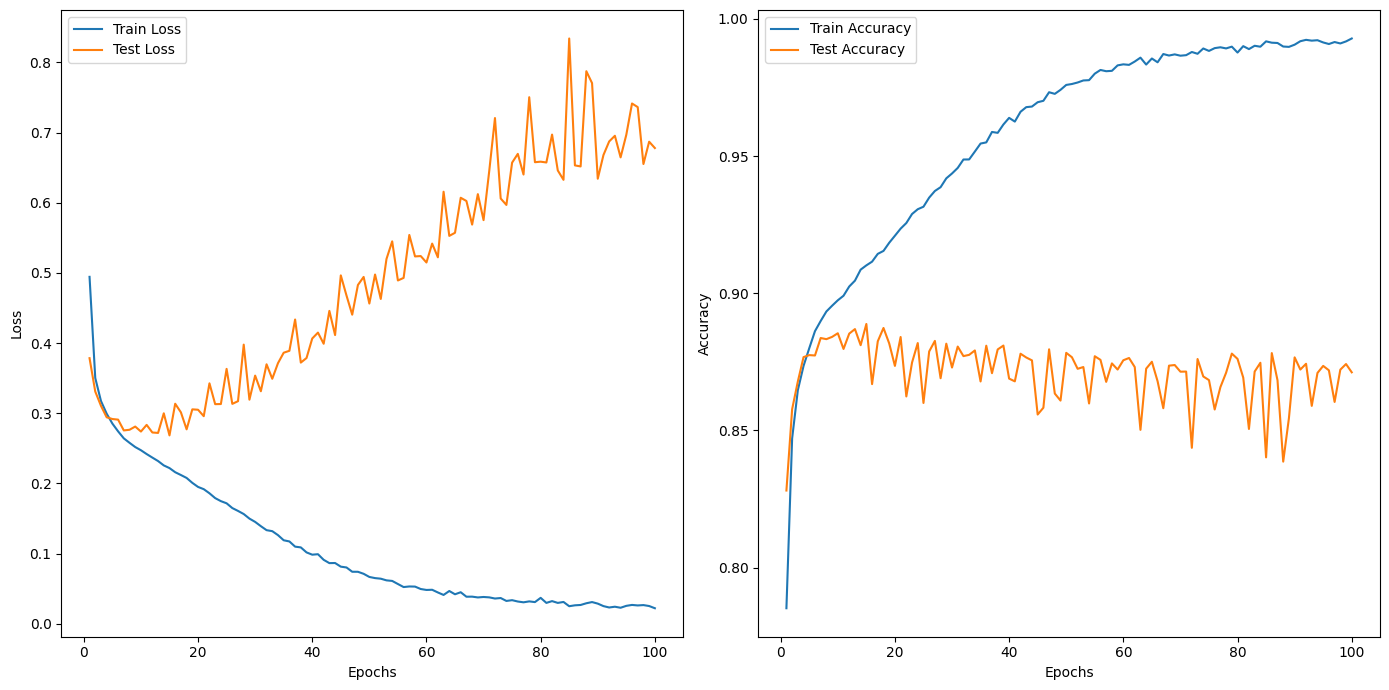

Starting final evaluation on test set...
Final Test Accuracy: 0.5799
Classification Report:
              precision    recall  f1-score   support

          CD       0.79      0.68      0.73      1019
         HYP       0.58      0.60      0.59       519
          MI       0.69      0.75      0.72      1102
        NORM       0.84      0.85      0.85      1906
        STTC       0.74      0.62      0.67      1055

   micro avg       0.76      0.73      0.74      5601
   macro avg       0.73      0.70      0.71      5601
weighted avg       0.76      0.73      0.74      5601
 samples avg       0.73      0.74      0.72      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


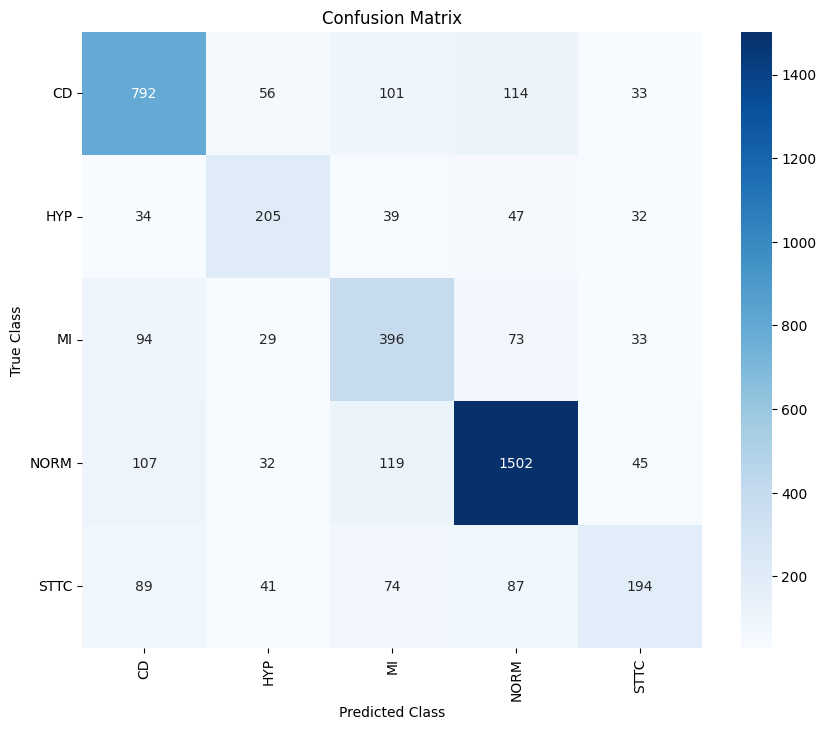

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning and an additional layer
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=128)  # First change: ResNet now outputs 128 features
        self.fc1 = nn.Linear(128, 64)  # Additional fully connected layer
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = self.fc2(x)  # Final layer outputs the class probabilities
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer with best parameters from Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

# Use the best hyperparameters from Optuna
dropout_rate = 0.317523323814064  # Best trial dropout rate
lr = 6.298594831888133e-05  # Best trial learning rate

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:37<00:00, 224.58it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 1: Train Loss: 0.5285, Train Accuracy: 0.7575
End of Epoch 1: Test Loss: 0.4224, Test Accuracy: 0.8051

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 2: Train Loss: 0.3950, Train Accuracy: 0.8143
End of Epoch 2: Test Loss: 0.3787, Test Accuracy: 0.8193

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 3: Train Loss: 0.3551, Train Accuracy: 0.8399
End of Epoch 3: Test Loss: 0.3350, Test Accuracy: 0.8528

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 4: Train Loss: 0.3215, Train Accuracy: 0.8613
End of Epoch 4: Test Loss: 0.3166, Test Accuracy: 0.8675

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 5: Train Loss: 0.3018, Train Accuracy: 0.8729
End of Epoch 5: Test Loss: 0.3040, Test Accuracy: 0.8725

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 6: Train Loss: 0.2881, Train Accuracy: 0.8788
End of Epoch 6: Test Loss: 0.2913, Test Accuracy: 0.8783

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:11<00:00, 24.81it/s]


End of Epoch 7: Train Loss: 0.2777, Train Accuracy: 0.8830
End of Epoch 7: Test Loss: 0.2887, Test Accuracy: 0.8783

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:11<00:00, 24.76it/s]


End of Epoch 8: Train Loss: 0.2680, Train Accuracy: 0.8884
End of Epoch 8: Test Loss: 0.2869, Test Accuracy: 0.8803

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 9: Train Loss: 0.2615, Train Accuracy: 0.8905
End of Epoch 9: Test Loss: 0.2877, Test Accuracy: 0.8806

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 10: Train Loss: 0.2528, Train Accuracy: 0.8947
End of Epoch 10: Test Loss: 0.2816, Test Accuracy: 0.8821

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 11: Train Loss: 0.2456, Train Accuracy: 0.8979
End of Epoch 11: Test Loss: 0.2808, Test Accuracy: 0.8840

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 12: Train Loss: 0.2417, Train Accuracy: 0.9002
End of Epoch 12: Test Loss: 0.2783, Test Accuracy: 0.8831

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 13: Train Loss: 0.2364, Train Accuracy: 0.9022
End of Epoch 13: Test Loss: 0.2787, Test Accuracy: 0.8872

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 14: Train Loss: 0.2299, Train Accuracy: 0.9050
End of Epoch 14: Test Loss: 0.2866, Test Accuracy: 0.8846

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 15: Train Loss: 0.2241, Train Accuracy: 0.9081
End of Epoch 15: Test Loss: 0.2899, Test Accuracy: 0.8809

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 16: Train Loss: 0.2188, Train Accuracy: 0.9097
End of Epoch 16: Test Loss: 0.2710, Test Accuracy: 0.8898

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 17: Train Loss: 0.2126, Train Accuracy: 0.9134
End of Epoch 17: Test Loss: 0.2841, Test Accuracy: 0.8829

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 18: Train Loss: 0.2087, Train Accuracy: 0.9148
End of Epoch 18: Test Loss: 0.3057, Test Accuracy: 0.8818

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 19: Train Loss: 0.2012, Train Accuracy: 0.9187
End of Epoch 19: Test Loss: 0.2807, Test Accuracy: 0.8861

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 20: Train Loss: 0.1975, Train Accuracy: 0.9197
End of Epoch 20: Test Loss: 0.2826, Test Accuracy: 0.8875

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 21: Train Loss: 0.1927, Train Accuracy: 0.9225
End of Epoch 21: Test Loss: 0.2845, Test Accuracy: 0.8850

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 22: Train Loss: 0.1886, Train Accuracy: 0.9246
End of Epoch 22: Test Loss: 0.3088, Test Accuracy: 0.8754

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 23: Train Loss: 0.1810, Train Accuracy: 0.9270
End of Epoch 23: Test Loss: 0.2939, Test Accuracy: 0.8859

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 24: Train Loss: 0.1756, Train Accuracy: 0.9291
End of Epoch 24: Test Loss: 0.3080, Test Accuracy: 0.8772

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 25: Train Loss: 0.1712, Train Accuracy: 0.9312
End of Epoch 25: Test Loss: 0.3006, Test Accuracy: 0.8832

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 26: Train Loss: 0.1662, Train Accuracy: 0.9338
End of Epoch 26: Test Loss: 0.3279, Test Accuracy: 0.8695

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 27: Train Loss: 0.1605, Train Accuracy: 0.9368
End of Epoch 27: Test Loss: 0.3837, Test Accuracy: 0.8514

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 28: Train Loss: 0.1560, Train Accuracy: 0.9381
End of Epoch 28: Test Loss: 0.3124, Test Accuracy: 0.8858

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 29: Train Loss: 0.1490, Train Accuracy: 0.9417
End of Epoch 29: Test Loss: 0.3127, Test Accuracy: 0.8822

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 30: Train Loss: 0.1442, Train Accuracy: 0.9430
End of Epoch 30: Test Loss: 0.3261, Test Accuracy: 0.8834

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 31: Train Loss: 0.1400, Train Accuracy: 0.9445
End of Epoch 31: Test Loss: 0.3733, Test Accuracy: 0.8771

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:11<00:00, 24.81it/s]


End of Epoch 32: Train Loss: 0.1353, Train Accuracy: 0.9473
End of Epoch 32: Test Loss: 0.3522, Test Accuracy: 0.8787

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:10<00:00, 24.86it/s]


End of Epoch 33: Train Loss: 0.1331, Train Accuracy: 0.9474
End of Epoch 33: Test Loss: 0.3408, Test Accuracy: 0.8841

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 34: Train Loss: 0.1249, Train Accuracy: 0.9521
End of Epoch 34: Test Loss: 0.3603, Test Accuracy: 0.8811

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:10<00:00, 24.87it/s]


End of Epoch 35: Train Loss: 0.1205, Train Accuracy: 0.9537
End of Epoch 35: Test Loss: 0.3894, Test Accuracy: 0.8676

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:11<00:00, 24.81it/s]


End of Epoch 36: Train Loss: 0.1165, Train Accuracy: 0.9554
End of Epoch 36: Test Loss: 0.4042, Test Accuracy: 0.8587

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 37: Train Loss: 0.1134, Train Accuracy: 0.9567
End of Epoch 37: Test Loss: 0.3595, Test Accuracy: 0.8786

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 38: Train Loss: 0.1093, Train Accuracy: 0.9585
End of Epoch 38: Test Loss: 0.3745, Test Accuracy: 0.8795

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 39: Train Loss: 0.1047, Train Accuracy: 0.9601
End of Epoch 39: Test Loss: 0.3887, Test Accuracy: 0.8814

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:10<00:00, 24.85it/s]


End of Epoch 40: Train Loss: 0.1022, Train Accuracy: 0.9614
End of Epoch 40: Test Loss: 0.4228, Test Accuracy: 0.8718

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 41: Train Loss: 0.1000, Train Accuracy: 0.9626
End of Epoch 41: Test Loss: 0.4237, Test Accuracy: 0.8596

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:10<00:00, 24.83it/s]


End of Epoch 42: Train Loss: 0.0936, Train Accuracy: 0.9645
End of Epoch 42: Test Loss: 0.4067, Test Accuracy: 0.8806

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 43: Train Loss: 0.0918, Train Accuracy: 0.9664
End of Epoch 43: Test Loss: 0.4144, Test Accuracy: 0.8826

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 44: Train Loss: 0.0876, Train Accuracy: 0.9671
End of Epoch 44: Test Loss: 0.3974, Test Accuracy: 0.8794

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 45: Train Loss: 0.0845, Train Accuracy: 0.9689
End of Epoch 45: Test Loss: 0.4194, Test Accuracy: 0.8807

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 46: Train Loss: 0.0821, Train Accuracy: 0.9694
End of Epoch 46: Test Loss: 0.4264, Test Accuracy: 0.8768

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 47: Train Loss: 0.0803, Train Accuracy: 0.9704
End of Epoch 47: Test Loss: 0.4770, Test Accuracy: 0.8769

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 48: Train Loss: 0.0802, Train Accuracy: 0.9704
End of Epoch 48: Test Loss: 0.4672, Test Accuracy: 0.8709

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 49: Train Loss: 0.0764, Train Accuracy: 0.9714
End of Epoch 49: Test Loss: 0.4363, Test Accuracy: 0.8747

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 50: Train Loss: 0.0698, Train Accuracy: 0.9744
End of Epoch 50: Test Loss: 0.4429, Test Accuracy: 0.8732

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 51: Train Loss: 0.0694, Train Accuracy: 0.9747
End of Epoch 51: Test Loss: 0.4572, Test Accuracy: 0.8789

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 52: Train Loss: 0.0643, Train Accuracy: 0.9769
End of Epoch 52: Test Loss: 0.4985, Test Accuracy: 0.8739

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 53: Train Loss: 0.0628, Train Accuracy: 0.9769
End of Epoch 53: Test Loss: 0.4980, Test Accuracy: 0.8812

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 54: Train Loss: 0.0633, Train Accuracy: 0.9773
End of Epoch 54: Test Loss: 0.4766, Test Accuracy: 0.8824

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 55: Train Loss: 0.0600, Train Accuracy: 0.9785
End of Epoch 55: Test Loss: 0.4940, Test Accuracy: 0.8772

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 56: Train Loss: 0.0587, Train Accuracy: 0.9787
End of Epoch 56: Test Loss: 0.5321, Test Accuracy: 0.8586

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 57: Train Loss: 0.0570, Train Accuracy: 0.9794
End of Epoch 57: Test Loss: 0.5665, Test Accuracy: 0.8492

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 58: Train Loss: 0.0552, Train Accuracy: 0.9800
End of Epoch 58: Test Loss: 0.5417, Test Accuracy: 0.8736

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 59: Train Loss: 0.0502, Train Accuracy: 0.9823
End of Epoch 59: Test Loss: 0.5304, Test Accuracy: 0.8635

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 60: Train Loss: 0.0538, Train Accuracy: 0.9808
End of Epoch 60: Test Loss: 0.5282, Test Accuracy: 0.8729

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 61: Train Loss: 0.0474, Train Accuracy: 0.9830
End of Epoch 61: Test Loss: 0.5309, Test Accuracy: 0.8737

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 62: Train Loss: 0.0487, Train Accuracy: 0.9824
End of Epoch 62: Test Loss: 0.5124, Test Accuracy: 0.8732

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 63: Train Loss: 0.0461, Train Accuracy: 0.9836
End of Epoch 63: Test Loss: 0.5779, Test Accuracy: 0.8767

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 64: Train Loss: 0.0473, Train Accuracy: 0.9835
End of Epoch 64: Test Loss: 0.5549, Test Accuracy: 0.8717

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 65: Train Loss: 0.0439, Train Accuracy: 0.9849
End of Epoch 65: Test Loss: 0.5447, Test Accuracy: 0.8670

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:11<00:00, 24.78it/s]


End of Epoch 66: Train Loss: 0.0420, Train Accuracy: 0.9850
End of Epoch 66: Test Loss: 0.5886, Test Accuracy: 0.8748

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 67: Train Loss: 0.0426, Train Accuracy: 0.9849
End of Epoch 67: Test Loss: 0.5770, Test Accuracy: 0.8738

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 68: Train Loss: 0.0427, Train Accuracy: 0.9853
End of Epoch 68: Test Loss: 0.5765, Test Accuracy: 0.8688

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 69: Train Loss: 0.0393, Train Accuracy: 0.9864
End of Epoch 69: Test Loss: 0.5782, Test Accuracy: 0.8717

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 70: Train Loss: 0.0388, Train Accuracy: 0.9863
End of Epoch 70: Test Loss: 0.6085, Test Accuracy: 0.8709

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 71: Train Loss: 0.0378, Train Accuracy: 0.9867
End of Epoch 71: Test Loss: 0.6467, Test Accuracy: 0.8701

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 72: Train Loss: 0.0391, Train Accuracy: 0.9860
End of Epoch 72: Test Loss: 0.6242, Test Accuracy: 0.8743

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 73: Train Loss: 0.0396, Train Accuracy: 0.9859
End of Epoch 73: Test Loss: 0.6033, Test Accuracy: 0.8707

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 74: Train Loss: 0.0336, Train Accuracy: 0.9890
End of Epoch 74: Test Loss: 0.6324, Test Accuracy: 0.8763

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 75: Train Loss: 0.0353, Train Accuracy: 0.9877
End of Epoch 75: Test Loss: 0.6247, Test Accuracy: 0.8628

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 76: Train Loss: 0.0362, Train Accuracy: 0.9873
End of Epoch 76: Test Loss: 0.6334, Test Accuracy: 0.8702

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 77: Train Loss: 0.0357, Train Accuracy: 0.9877
End of Epoch 77: Test Loss: 0.6288, Test Accuracy: 0.8607

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:11<00:00, 24.61it/s]


End of Epoch 78: Train Loss: 0.0330, Train Accuracy: 0.9889
End of Epoch 78: Test Loss: 0.6209, Test Accuracy: 0.8647

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 79: Train Loss: 0.0331, Train Accuracy: 0.9892
End of Epoch 79: Test Loss: 0.6166, Test Accuracy: 0.8754

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 80: Train Loss: 0.0321, Train Accuracy: 0.9894
End of Epoch 80: Test Loss: 0.6436, Test Accuracy: 0.8507

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 81: Train Loss: 0.0309, Train Accuracy: 0.9898
End of Epoch 81: Test Loss: 0.7231, Test Accuracy: 0.8554

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 82: Train Loss: 0.0273, Train Accuracy: 0.9908
End of Epoch 82: Test Loss: 0.6419, Test Accuracy: 0.8771

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 83: Train Loss: 0.0266, Train Accuracy: 0.9914
End of Epoch 83: Test Loss: 0.6575, Test Accuracy: 0.8699

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 84: Train Loss: 0.0300, Train Accuracy: 0.9903
End of Epoch 84: Test Loss: 0.8257, Test Accuracy: 0.8560

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 85: Train Loss: 0.0321, Train Accuracy: 0.9890
End of Epoch 85: Test Loss: 0.7701, Test Accuracy: 0.8413

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 86: Train Loss: 0.0274, Train Accuracy: 0.9912
End of Epoch 86: Test Loss: 0.6164, Test Accuracy: 0.8754

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 87: Train Loss: 0.0276, Train Accuracy: 0.9904
End of Epoch 87: Test Loss: 0.6346, Test Accuracy: 0.8728

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:11<00:00, 24.77it/s]


End of Epoch 88: Train Loss: 0.0285, Train Accuracy: 0.9901
End of Epoch 88: Test Loss: 0.6515, Test Accuracy: 0.8758

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 89: Train Loss: 0.0289, Train Accuracy: 0.9898
End of Epoch 89: Test Loss: 0.6814, Test Accuracy: 0.8609

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 90: Train Loss: 0.0262, Train Accuracy: 0.9911
End of Epoch 90: Test Loss: 0.6846, Test Accuracy: 0.8689

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 91: Train Loss: 0.0257, Train Accuracy: 0.9914
End of Epoch 91: Test Loss: 0.6428, Test Accuracy: 0.8783

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 92: Train Loss: 0.0241, Train Accuracy: 0.9921
End of Epoch 92: Test Loss: 0.7310, Test Accuracy: 0.8581

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 93: Train Loss: 0.0251, Train Accuracy: 0.9914
End of Epoch 93: Test Loss: 0.7016, Test Accuracy: 0.8700

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 94: Train Loss: 0.0282, Train Accuracy: 0.9906
End of Epoch 94: Test Loss: 0.6492, Test Accuracy: 0.8752

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 95: Train Loss: 0.0255, Train Accuracy: 0.9914
End of Epoch 95: Test Loss: 0.7346, Test Accuracy: 0.8708

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 96: Train Loss: 0.0240, Train Accuracy: 0.9919
End of Epoch 96: Test Loss: 0.7322, Test Accuracy: 0.8610

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:11<00:00, 24.63it/s]


End of Epoch 97: Train Loss: 0.0231, Train Accuracy: 0.9919
End of Epoch 97: Test Loss: 0.7509, Test Accuracy: 0.8709

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 98: Train Loss: 0.0274, Train Accuracy: 0.9905
End of Epoch 98: Test Loss: 0.6420, Test Accuracy: 0.8754

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 99: Train Loss: 0.0207, Train Accuracy: 0.9929
End of Epoch 99: Test Loss: 0.6646, Test Accuracy: 0.8623

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 100: Train Loss: 0.0272, Train Accuracy: 0.9907
End of Epoch 100: Test Loss: 0.6846, Test Accuracy: 0.8765
Training complete. Plotting loss and accuracy curves...


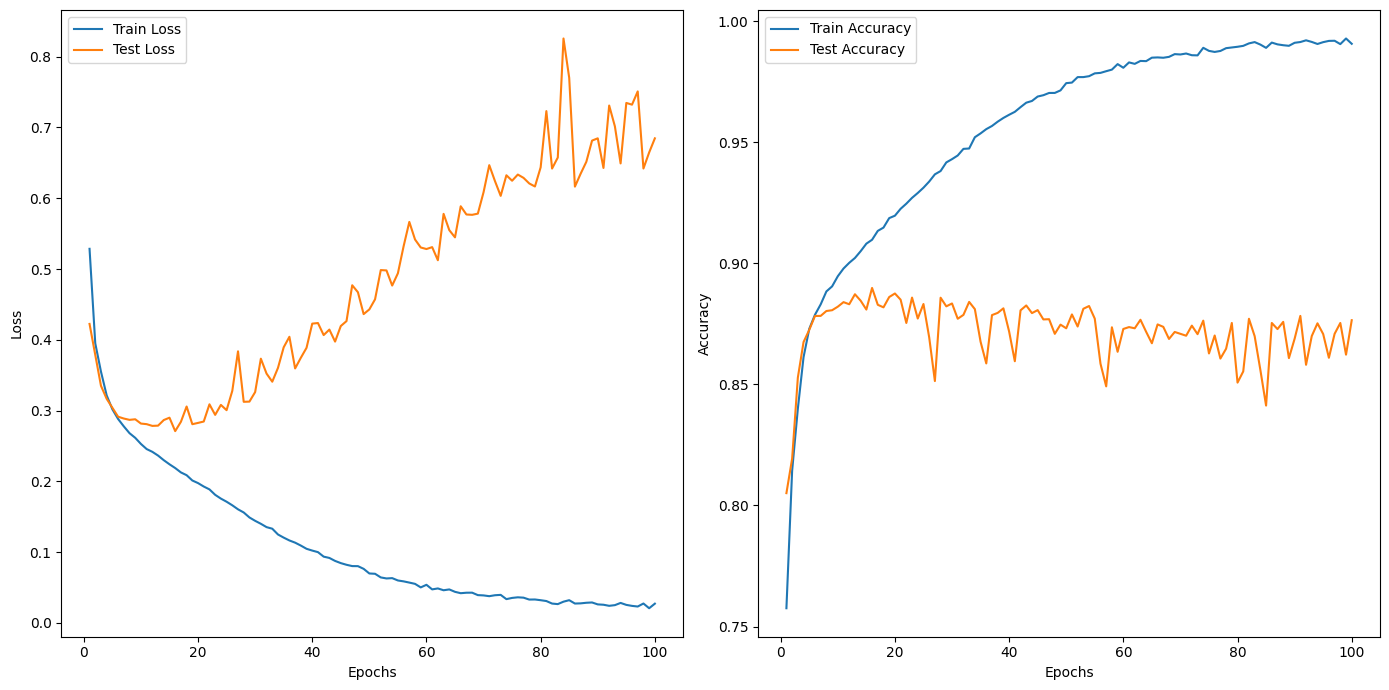

Starting final evaluation on test set...
Final Test Accuracy: 0.5948
Classification Report:
              precision    recall  f1-score   support

          CD       0.84      0.63      0.72      1019
         HYP       0.62      0.53      0.57       519
          MI       0.74      0.71      0.72      1102
        NORM       0.82      0.89      0.85      1906
        STTC       0.73      0.66      0.69      1055

   micro avg       0.77      0.73      0.75      5601
   macro avg       0.75      0.69      0.71      5601
weighted avg       0.77      0.73      0.75      5601
 samples avg       0.76      0.74      0.73      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


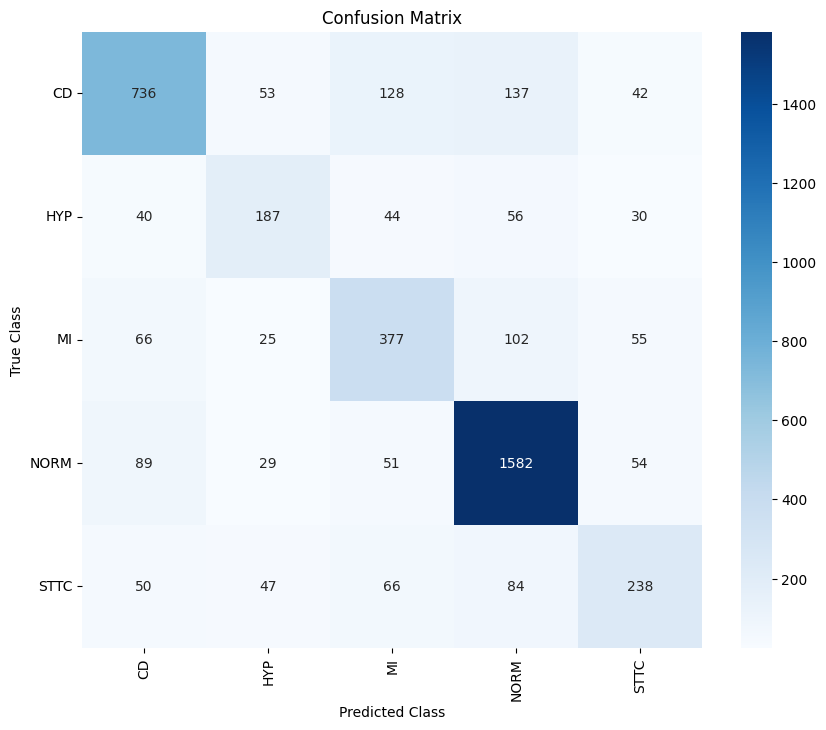

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning and two additional layers
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=128)  # First change: ResNet now outputs 128 features
        self.fc1 = nn.Linear(128, 64)  # Additional fully connected layer 1
        self.fc2 = nn.Linear(64, 32)   # Additional fully connected layer 2
        self.fc3 = nn.Linear(32, output_dim)  # Final output layer

    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = torch.relu(self.fc2(x))  # Apply ReLU after the second FC layer
        x = self.fc3(x)  # Final layer outputs the class probabilities
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer with best parameters from Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

# Use the best hyperparameters from Optuna
dropout_rate = 0.317523323814064  # Best trial dropout rate
lr = 6.298594831888133e-05  # Best trial learning rate

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")



Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:37<00:00, 224.64it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:10<00:00, 24.85it/s]


End of Epoch 1: Train Loss: 0.6113, Train Accuracy: 0.6113
End of Epoch 1: Test Loss: 0.4651, Test Accuracy: 0.7809

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 2: Train Loss: 0.4101, Train Accuracy: 0.8079
End of Epoch 2: Test Loss: 0.3848, Test Accuracy: 0.8216

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 3: Train Loss: 0.3589, Train Accuracy: 0.8399
End of Epoch 3: Test Loss: 0.3496, Test Accuracy: 0.8469

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 4: Train Loss: 0.3340, Train Accuracy: 0.8533
End of Epoch 4: Test Loss: 0.3370, Test Accuracy: 0.8539

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 5: Train Loss: 0.3235, Train Accuracy: 0.8595
End of Epoch 5: Test Loss: 0.3250, Test Accuracy: 0.8606

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:10<00:00, 24.97it/s]


End of Epoch 6: Train Loss: 0.3143, Train Accuracy: 0.8636
End of Epoch 6: Test Loss: 0.3163, Test Accuracy: 0.8674

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:10<00:00, 25.15it/s]


End of Epoch 7: Train Loss: 0.3057, Train Accuracy: 0.8694
End of Epoch 7: Test Loss: 0.3117, Test Accuracy: 0.8694

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:10<00:00, 25.09it/s]


End of Epoch 8: Train Loss: 0.2979, Train Accuracy: 0.8737
End of Epoch 8: Test Loss: 0.3131, Test Accuracy: 0.8700

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:10<00:00, 24.90it/s]


End of Epoch 9: Train Loss: 0.2899, Train Accuracy: 0.8781
End of Epoch 9: Test Loss: 0.3014, Test Accuracy: 0.8745

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:10<00:00, 24.87it/s]


End of Epoch 10: Train Loss: 0.2849, Train Accuracy: 0.8802
End of Epoch 10: Test Loss: 0.3027, Test Accuracy: 0.8739

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 11: Train Loss: 0.2771, Train Accuracy: 0.8839
End of Epoch 11: Test Loss: 0.2978, Test Accuracy: 0.8771

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 12: Train Loss: 0.2715, Train Accuracy: 0.8868
End of Epoch 12: Test Loss: 0.2935, Test Accuracy: 0.8790

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 13: Train Loss: 0.2639, Train Accuracy: 0.8911
End of Epoch 13: Test Loss: 0.3027, Test Accuracy: 0.8763

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:10<00:00, 24.92it/s]


End of Epoch 14: Train Loss: 0.2590, Train Accuracy: 0.8919
End of Epoch 14: Test Loss: 0.2915, Test Accuracy: 0.8809

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:10<00:00, 24.86it/s]


End of Epoch 15: Train Loss: 0.2539, Train Accuracy: 0.8938
End of Epoch 15: Test Loss: 0.3072, Test Accuracy: 0.8802

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:10<00:00, 24.90it/s]


End of Epoch 16: Train Loss: 0.2470, Train Accuracy: 0.8980
End of Epoch 16: Test Loss: 0.2925, Test Accuracy: 0.8799

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:10<00:00, 24.89it/s]


End of Epoch 17: Train Loss: 0.2429, Train Accuracy: 0.8999
End of Epoch 17: Test Loss: 0.2908, Test Accuracy: 0.8815

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:11<00:00, 24.82it/s]


End of Epoch 18: Train Loss: 0.2362, Train Accuracy: 0.9037
End of Epoch 18: Test Loss: 0.2984, Test Accuracy: 0.8811

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:11<00:00, 24.78it/s]


End of Epoch 19: Train Loss: 0.2328, Train Accuracy: 0.9049
End of Epoch 19: Test Loss: 0.2916, Test Accuracy: 0.8799

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 20: Train Loss: 0.2251, Train Accuracy: 0.9079
End of Epoch 20: Test Loss: 0.3068, Test Accuracy: 0.8771

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:11<00:00, 24.78it/s]


End of Epoch 21: Train Loss: 0.2226, Train Accuracy: 0.9091
End of Epoch 21: Test Loss: 0.3410, Test Accuracy: 0.8712

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 22: Train Loss: 0.2175, Train Accuracy: 0.9111
End of Epoch 22: Test Loss: 0.2940, Test Accuracy: 0.8816

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 23: Train Loss: 0.2117, Train Accuracy: 0.9142
End of Epoch 23: Test Loss: 0.3117, Test Accuracy: 0.8779

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 24: Train Loss: 0.2059, Train Accuracy: 0.9174
End of Epoch 24: Test Loss: 0.3040, Test Accuracy: 0.8815

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 25: Train Loss: 0.2029, Train Accuracy: 0.9184
End of Epoch 25: Test Loss: 0.3033, Test Accuracy: 0.8758

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 26: Train Loss: 0.1989, Train Accuracy: 0.9200
End of Epoch 26: Test Loss: 0.3077, Test Accuracy: 0.8774

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 27: Train Loss: 0.1898, Train Accuracy: 0.9239
End of Epoch 27: Test Loss: 0.3146, Test Accuracy: 0.8766

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 28: Train Loss: 0.1859, Train Accuracy: 0.9261
End of Epoch 28: Test Loss: 0.3267, Test Accuracy: 0.8750

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 29: Train Loss: 0.1826, Train Accuracy: 0.9274
End of Epoch 29: Test Loss: 0.3175, Test Accuracy: 0.8804

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 30: Train Loss: 0.1778, Train Accuracy: 0.9294
End of Epoch 30: Test Loss: 0.3475, Test Accuracy: 0.8766

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 31: Train Loss: 0.1713, Train Accuracy: 0.9319
End of Epoch 31: Test Loss: 0.3191, Test Accuracy: 0.8821

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 32: Train Loss: 0.1650, Train Accuracy: 0.9345
End of Epoch 32: Test Loss: 0.3327, Test Accuracy: 0.8799

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 33: Train Loss: 0.1631, Train Accuracy: 0.9360
End of Epoch 33: Test Loss: 0.3461, Test Accuracy: 0.8769

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:11<00:00, 24.80it/s]


End of Epoch 34: Train Loss: 0.1576, Train Accuracy: 0.9383
End of Epoch 34: Test Loss: 0.3493, Test Accuracy: 0.8793

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 35: Train Loss: 0.1572, Train Accuracy: 0.9378
End of Epoch 35: Test Loss: 0.3716, Test Accuracy: 0.8783

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 36: Train Loss: 0.1491, Train Accuracy: 0.9420
End of Epoch 36: Test Loss: 0.3416, Test Accuracy: 0.8730

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:11<00:00, 24.80it/s]


End of Epoch 37: Train Loss: 0.1467, Train Accuracy: 0.9427
End of Epoch 37: Test Loss: 0.3882, Test Accuracy: 0.8755

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:11<00:00, 24.79it/s]


End of Epoch 38: Train Loss: 0.1426, Train Accuracy: 0.9445
End of Epoch 38: Test Loss: 0.3692, Test Accuracy: 0.8678

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 39: Train Loss: 0.1379, Train Accuracy: 0.9462
End of Epoch 39: Test Loss: 0.3816, Test Accuracy: 0.8662

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 40: Train Loss: 0.1340, Train Accuracy: 0.9482
End of Epoch 40: Test Loss: 0.3657, Test Accuracy: 0.8761

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 41: Train Loss: 0.1291, Train Accuracy: 0.9500
End of Epoch 41: Test Loss: 0.3669, Test Accuracy: 0.8710

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 42: Train Loss: 0.1270, Train Accuracy: 0.9511
End of Epoch 42: Test Loss: 0.3796, Test Accuracy: 0.8732

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 43: Train Loss: 0.1207, Train Accuracy: 0.9543
End of Epoch 43: Test Loss: 0.3844, Test Accuracy: 0.8754

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:11<00:00, 24.62it/s]


End of Epoch 44: Train Loss: 0.1188, Train Accuracy: 0.9548
End of Epoch 44: Test Loss: 0.3835, Test Accuracy: 0.8792

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 45: Train Loss: 0.1153, Train Accuracy: 0.9561
End of Epoch 45: Test Loss: 0.4057, Test Accuracy: 0.8759

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 46: Train Loss: 0.1134, Train Accuracy: 0.9572
End of Epoch 46: Test Loss: 0.4174, Test Accuracy: 0.8753

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 47: Train Loss: 0.1085, Train Accuracy: 0.9586
End of Epoch 47: Test Loss: 0.4627, Test Accuracy: 0.8641

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 48: Train Loss: 0.1041, Train Accuracy: 0.9608
End of Epoch 48: Test Loss: 0.4555, Test Accuracy: 0.8664

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 49: Train Loss: 0.1025, Train Accuracy: 0.9618
End of Epoch 49: Test Loss: 0.4060, Test Accuracy: 0.8707

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 50: Train Loss: 0.0980, Train Accuracy: 0.9631
End of Epoch 50: Test Loss: 0.4377, Test Accuracy: 0.8742

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 51: Train Loss: 0.0964, Train Accuracy: 0.9640
End of Epoch 51: Test Loss: 0.4627, Test Accuracy: 0.8777

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 52: Train Loss: 0.0927, Train Accuracy: 0.9655
End of Epoch 52: Test Loss: 0.4278, Test Accuracy: 0.8748

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 53: Train Loss: 0.0915, Train Accuracy: 0.9661
End of Epoch 53: Test Loss: 0.4628, Test Accuracy: 0.8641

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:11<00:00, 24.76it/s]


End of Epoch 54: Train Loss: 0.0909, Train Accuracy: 0.9664
End of Epoch 54: Test Loss: 0.5025, Test Accuracy: 0.8470

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 55: Train Loss: 0.0856, Train Accuracy: 0.9686
End of Epoch 55: Test Loss: 0.5330, Test Accuracy: 0.8408

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 56: Train Loss: 0.0824, Train Accuracy: 0.9704
End of Epoch 56: Test Loss: 0.4810, Test Accuracy: 0.8732

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 57: Train Loss: 0.0784, Train Accuracy: 0.9713
End of Epoch 57: Test Loss: 0.5278, Test Accuracy: 0.8523

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 58: Train Loss: 0.0806, Train Accuracy: 0.9708
End of Epoch 58: Test Loss: 0.4708, Test Accuracy: 0.8742

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:11<00:00, 24.75it/s]


End of Epoch 59: Train Loss: 0.0784, Train Accuracy: 0.9715
End of Epoch 59: Test Loss: 0.4674, Test Accuracy: 0.8589

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 60: Train Loss: 0.0792, Train Accuracy: 0.9707
End of Epoch 60: Test Loss: 0.4803, Test Accuracy: 0.8755

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 61: Train Loss: 0.0768, Train Accuracy: 0.9715
End of Epoch 61: Test Loss: 0.5431, Test Accuracy: 0.8651

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:11<00:00, 24.73it/s]


End of Epoch 62: Train Loss: 0.0708, Train Accuracy: 0.9749
End of Epoch 62: Test Loss: 0.5032, Test Accuracy: 0.8764

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 63: Train Loss: 0.0681, Train Accuracy: 0.9752
End of Epoch 63: Test Loss: 0.5085, Test Accuracy: 0.8767

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:11<00:00, 24.80it/s]


End of Epoch 64: Train Loss: 0.0699, Train Accuracy: 0.9742
End of Epoch 64: Test Loss: 0.5362, Test Accuracy: 0.8543

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:11<00:00, 24.78it/s]


End of Epoch 65: Train Loss: 0.0640, Train Accuracy: 0.9773
End of Epoch 65: Test Loss: 0.5333, Test Accuracy: 0.8763

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:11<00:00, 24.71it/s]


End of Epoch 66: Train Loss: 0.0642, Train Accuracy: 0.9779
End of Epoch 66: Test Loss: 0.5129, Test Accuracy: 0.8731

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 67: Train Loss: 0.0637, Train Accuracy: 0.9773
End of Epoch 67: Test Loss: 0.5388, Test Accuracy: 0.8679

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 68: Train Loss: 0.0616, Train Accuracy: 0.9784
End of Epoch 68: Test Loss: 0.5424, Test Accuracy: 0.8652

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:11<00:00, 24.70it/s]


End of Epoch 69: Train Loss: 0.0614, Train Accuracy: 0.9779
End of Epoch 69: Test Loss: 0.5252, Test Accuracy: 0.8582

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 70: Train Loss: 0.0586, Train Accuracy: 0.9796
End of Epoch 70: Test Loss: 0.5508, Test Accuracy: 0.8648

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 71: Train Loss: 0.0568, Train Accuracy: 0.9798
End of Epoch 71: Test Loss: 0.5296, Test Accuracy: 0.8750

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 72: Train Loss: 0.0529, Train Accuracy: 0.9815
End of Epoch 72: Test Loss: 0.5389, Test Accuracy: 0.8736

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 73: Train Loss: 0.0522, Train Accuracy: 0.9820
End of Epoch 73: Test Loss: 0.5454, Test Accuracy: 0.8696

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 74: Train Loss: 0.0558, Train Accuracy: 0.9804
End of Epoch 74: Test Loss: 0.5783, Test Accuracy: 0.8609

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 75: Train Loss: 0.0505, Train Accuracy: 0.9824
End of Epoch 75: Test Loss: 0.5557, Test Accuracy: 0.8674

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:11<00:00, 24.73it/s]


End of Epoch 76: Train Loss: 0.0559, Train Accuracy: 0.9799
End of Epoch 76: Test Loss: 0.6384, Test Accuracy: 0.8689

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 77: Train Loss: 0.0501, Train Accuracy: 0.9826
End of Epoch 77: Test Loss: 0.5768, Test Accuracy: 0.8679

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:11<00:00, 24.66it/s]


End of Epoch 78: Train Loss: 0.0526, Train Accuracy: 0.9813
End of Epoch 78: Test Loss: 0.5651, Test Accuracy: 0.8733

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 79: Train Loss: 0.0482, Train Accuracy: 0.9832
End of Epoch 79: Test Loss: 0.5584, Test Accuracy: 0.8669

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 80: Train Loss: 0.0456, Train Accuracy: 0.9847
End of Epoch 80: Test Loss: 0.5633, Test Accuracy: 0.8723

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 81: Train Loss: 0.0472, Train Accuracy: 0.9834
End of Epoch 81: Test Loss: 0.5888, Test Accuracy: 0.8646

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 82: Train Loss: 0.0442, Train Accuracy: 0.9847
End of Epoch 82: Test Loss: 0.5792, Test Accuracy: 0.8696

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 83: Train Loss: 0.0427, Train Accuracy: 0.9852
End of Epoch 83: Test Loss: 0.6006, Test Accuracy: 0.8765

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:10<00:00, 24.85it/s]


End of Epoch 84: Train Loss: 0.0472, Train Accuracy: 0.9835
End of Epoch 84: Test Loss: 0.5732, Test Accuracy: 0.8704

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 85: Train Loss: 0.0458, Train Accuracy: 0.9842
End of Epoch 85: Test Loss: 0.6385, Test Accuracy: 0.8718

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 86: Train Loss: 0.0392, Train Accuracy: 0.9869
End of Epoch 86: Test Loss: 0.5973, Test Accuracy: 0.8629

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 87: Train Loss: 0.0434, Train Accuracy: 0.9850
End of Epoch 87: Test Loss: 0.5945, Test Accuracy: 0.8683

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 88: Train Loss: 0.0392, Train Accuracy: 0.9863
End of Epoch 88: Test Loss: 0.6410, Test Accuracy: 0.8698

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 89: Train Loss: 0.0380, Train Accuracy: 0.9870
End of Epoch 89: Test Loss: 0.5915, Test Accuracy: 0.8701

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 90: Train Loss: 0.0403, Train Accuracy: 0.9862
End of Epoch 90: Test Loss: 0.6258, Test Accuracy: 0.8684

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:11<00:00, 24.74it/s]


End of Epoch 91: Train Loss: 0.0363, Train Accuracy: 0.9877
End of Epoch 91: Test Loss: 0.6115, Test Accuracy: 0.8734

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:11<00:00, 24.67it/s]


End of Epoch 92: Train Loss: 0.0391, Train Accuracy: 0.9866
End of Epoch 92: Test Loss: 0.6088, Test Accuracy: 0.8648

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 93: Train Loss: 0.0369, Train Accuracy: 0.9876
End of Epoch 93: Test Loss: 0.6795, Test Accuracy: 0.8547

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 94: Train Loss: 0.0351, Train Accuracy: 0.9883
End of Epoch 94: Test Loss: 0.6447, Test Accuracy: 0.8694

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:11<00:00, 24.64it/s]


End of Epoch 95: Train Loss: 0.0373, Train Accuracy: 0.9870
End of Epoch 95: Test Loss: 0.6123, Test Accuracy: 0.8709

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 96: Train Loss: 0.0358, Train Accuracy: 0.9873
End of Epoch 96: Test Loss: 0.6547, Test Accuracy: 0.8737

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:11<00:00, 24.69it/s]


End of Epoch 97: Train Loss: 0.0337, Train Accuracy: 0.9888
End of Epoch 97: Test Loss: 0.7388, Test Accuracy: 0.8702

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:11<00:00, 24.65it/s]


End of Epoch 98: Train Loss: 0.0315, Train Accuracy: 0.9894
End of Epoch 98: Test Loss: 0.6500, Test Accuracy: 0.8709

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:11<00:00, 24.68it/s]


End of Epoch 99: Train Loss: 0.0340, Train Accuracy: 0.9884
End of Epoch 99: Test Loss: 0.7674, Test Accuracy: 0.8353

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:11<00:00, 24.72it/s]


End of Epoch 100: Train Loss: 0.0350, Train Accuracy: 0.9883
End of Epoch 100: Test Loss: 0.6159, Test Accuracy: 0.8741
Training complete. Plotting loss and accuracy curves...


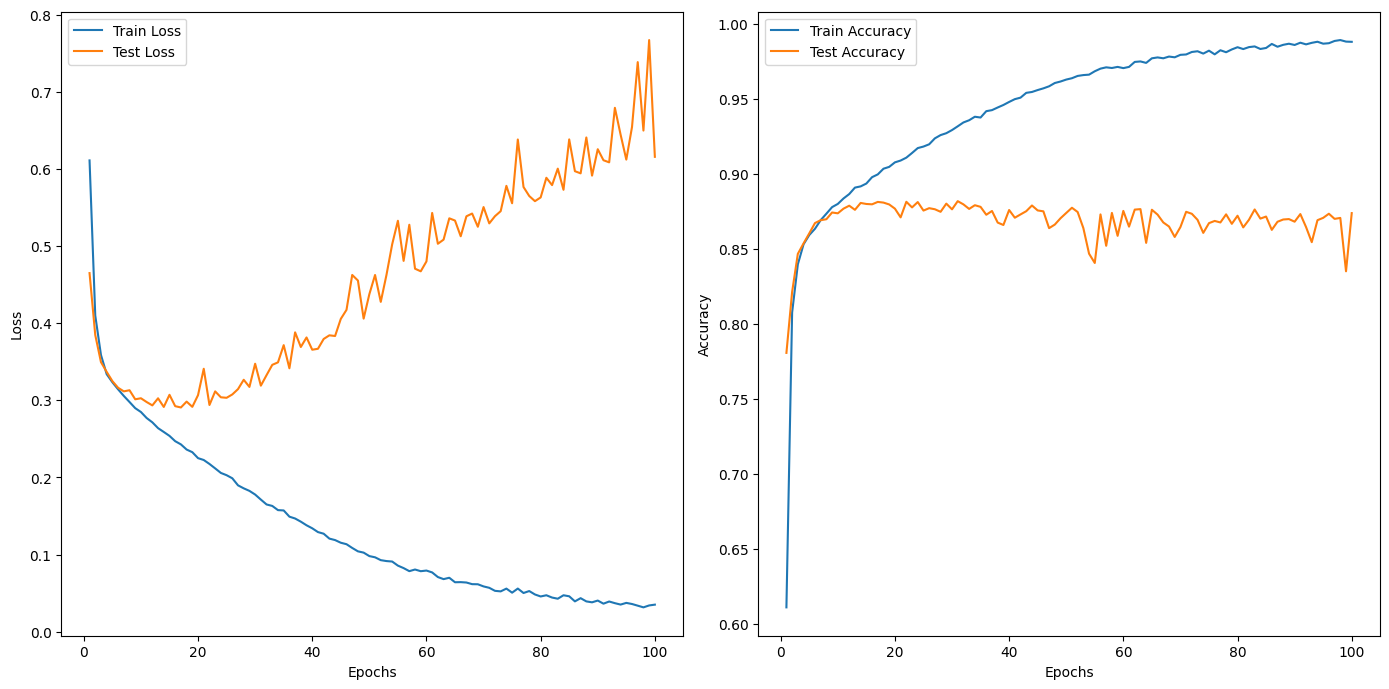

Starting final evaluation on test set...
Final Test Accuracy: 0.5980
Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.67      0.74      1019
         HYP       0.58      0.55      0.57       519
          MI       0.76      0.66      0.71      1102
        NORM       0.84      0.85      0.85      1906
        STTC       0.69      0.71      0.70      1055

   micro avg       0.77      0.73      0.75      5601
   macro avg       0.74      0.69      0.71      5601
weighted avg       0.77      0.73      0.75      5601
 samples avg       0.75      0.74      0.73      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


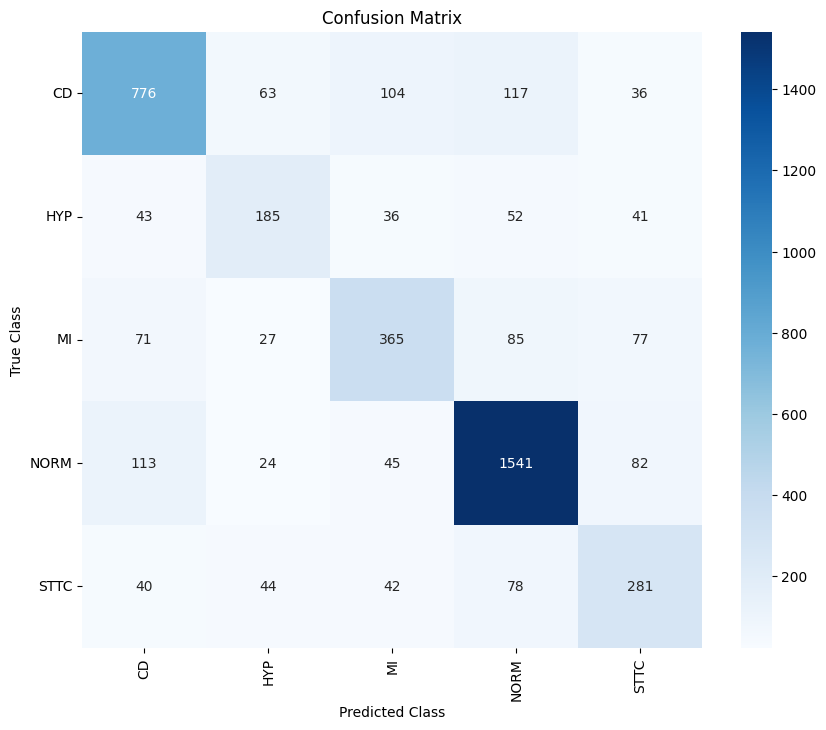

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth
Data processing, training, and evaluation completed.


In [ ]:
# Required imports
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# tsai library for pretrained time-series models
from tsai.models.ResNet import ResNet

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    # Add tqdm progress bar
    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the ResNet1D model with transfer learning and three additional layers
class ResNetTransfer(nn.Module):
    def __init__(self, input_channels, output_dim):
        super(ResNetTransfer, self).__init__()
        self.resnet = ResNet(c_in=input_channels, c_out=128)  # First change: ResNet now outputs 128 features
        self.fc1 = nn.Linear(128, 64)  # Additional fully connected layer 1
        self.fc2 = nn.Linear(64, 32)   # Additional fully connected layer 2
        self.fc3 = nn.Linear(32, 16)   # Additional fully connected layer 3
        self.fc4 = nn.Linear(16, output_dim)  # Final output layer

    def forward(self, x):
        x = self.resnet(x)
        x = torch.relu(self.fc1(x))  # Apply ReLU after the first FC layer
        x = torch.relu(self.fc2(x))  # Apply ReLU after the second FC layer
        x = torch.relu(self.fc3(x))  # Apply ReLU after the third FC layer
        x = self.fc4(x)  # Final layer outputs the class probabilities
        return x

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Use the entire dataset for training and testing (remove the subset limiting step)
# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer with best parameters from Optuna
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ResNetTransfer(input_channels=n_leads, output_dim=y_train.shape[1]).to(device)

# Use the best hyperparameters from Optuna
dropout_rate = 0.317523323814064  # Best trial dropout rate
lr = 6.298594831888133e-05  # Best trial learning rate

criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Fix the shape of inputs by permuting
            inputs = inputs.permute(0, 2, 1)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        # Fix the shape of inputs by permuting
        inputs = inputs.permute(0, 2, 1)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/resnet1d_ecg_transfer_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


#LSTM Activation

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:38<00:00, 221.99it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Train input shape: (17469, 500, 12)
Test input shape: (4368, 500, 12)
Train data standard deviation: 0.2336
Test data standard deviation: 0.2317
Model Summary:
LSTMModel(
  (lstm): LSTM(12, 128, num_layers=2, batch_first=True)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)
Input Shape: 12 leads, 500 timesteps

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:07<00:00, 38.21it/s]


End of Epoch 1: Train Loss: 0.5456, Train Accuracy: 0.7423
End of Epoch 1: Test Loss: 0.5416, Test Accuracy: 0.7435

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:07<00:00, 37.89it/s]


End of Epoch 2: Train Loss: 0.5320, Train Accuracy: 0.7483
End of Epoch 2: Test Loss: 0.5188, Test Accuracy: 0.7516

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:07<00:00, 37.43it/s]


End of Epoch 3: Train Loss: 0.5340, Train Accuracy: 0.7485
End of Epoch 3: Test Loss: 0.5410, Test Accuracy: 0.7435

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:07<00:00, 37.14it/s]


End of Epoch 4: Train Loss: 0.5404, Train Accuracy: 0.7455
End of Epoch 4: Test Loss: 0.5416, Test Accuracy: 0.7435

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:07<00:00, 37.01it/s]


End of Epoch 5: Train Loss: 0.5228, Train Accuracy: 0.7486
End of Epoch 5: Test Loss: 0.5365, Test Accuracy: 0.7435

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:07<00:00, 37.31it/s]


End of Epoch 6: Train Loss: 0.5303, Train Accuracy: 0.7483
End of Epoch 6: Test Loss: 0.5282, Test Accuracy: 0.7445

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:07<00:00, 37.57it/s]


End of Epoch 7: Train Loss: 0.5199, Train Accuracy: 0.7466
End of Epoch 7: Test Loss: 0.5126, Test Accuracy: 0.7439

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:07<00:00, 38.04it/s]


End of Epoch 8: Train Loss: 0.5080, Train Accuracy: 0.7517
End of Epoch 8: Test Loss: 0.5028, Test Accuracy: 0.7548

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:07<00:00, 38.03it/s]


End of Epoch 9: Train Loss: 0.5041, Train Accuracy: 0.7570
End of Epoch 9: Test Loss: 0.5010, Test Accuracy: 0.7577

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:07<00:00, 38.13it/s]


End of Epoch 10: Train Loss: 0.5016, Train Accuracy: 0.7595
End of Epoch 10: Test Loss: 0.4984, Test Accuracy: 0.7611

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:07<00:00, 38.19it/s]


End of Epoch 11: Train Loss: 0.5001, Train Accuracy: 0.7614
End of Epoch 11: Test Loss: 0.4999, Test Accuracy: 0.7579

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:07<00:00, 38.02it/s]


End of Epoch 12: Train Loss: 0.4959, Train Accuracy: 0.7647
End of Epoch 12: Test Loss: 0.4932, Test Accuracy: 0.7663

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:07<00:00, 37.82it/s]


End of Epoch 13: Train Loss: 0.4916, Train Accuracy: 0.7678
End of Epoch 13: Test Loss: 0.4912, Test Accuracy: 0.7670

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:07<00:00, 37.63it/s]


End of Epoch 14: Train Loss: 0.4826, Train Accuracy: 0.7742
End of Epoch 14: Test Loss: 0.4788, Test Accuracy: 0.7736

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:07<00:00, 37.67it/s]


End of Epoch 15: Train Loss: 0.4816, Train Accuracy: 0.7749
End of Epoch 15: Test Loss: 0.4751, Test Accuracy: 0.7770

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:07<00:00, 37.74it/s]


End of Epoch 16: Train Loss: 0.4919, Train Accuracy: 0.7676
End of Epoch 16: Test Loss: 0.4956, Test Accuracy: 0.7645

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:07<00:00, 37.69it/s]


End of Epoch 17: Train Loss: 0.4932, Train Accuracy: 0.7686
End of Epoch 17: Test Loss: 0.5298, Test Accuracy: 0.7409

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:07<00:00, 37.68it/s]


End of Epoch 18: Train Loss: 0.5298, Train Accuracy: 0.7467
End of Epoch 18: Test Loss: 0.5217, Test Accuracy: 0.7471

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:07<00:00, 37.85it/s]


End of Epoch 19: Train Loss: 0.5177, Train Accuracy: 0.7485
End of Epoch 19: Test Loss: 0.5250, Test Accuracy: 0.7471

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:07<00:00, 37.69it/s]


End of Epoch 20: Train Loss: 0.5304, Train Accuracy: 0.7450
End of Epoch 20: Test Loss: 0.5414, Test Accuracy: 0.7421

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:07<00:00, 37.56it/s]


End of Epoch 21: Train Loss: 0.5399, Train Accuracy: 0.7448
End of Epoch 21: Test Loss: 0.5381, Test Accuracy: 0.7452

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:07<00:00, 37.49it/s]


End of Epoch 22: Train Loss: 0.5388, Train Accuracy: 0.7450
End of Epoch 22: Test Loss: 0.5399, Test Accuracy: 0.7421

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:07<00:00, 37.46it/s]


End of Epoch 23: Train Loss: 0.5406, Train Accuracy: 0.7454
End of Epoch 23: Test Loss: 0.5430, Test Accuracy: 0.7435

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:07<00:00, 37.52it/s]


End of Epoch 24: Train Loss: 0.5403, Train Accuracy: 0.7455
End of Epoch 24: Test Loss: 0.5413, Test Accuracy: 0.7435

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:07<00:00, 37.43it/s]


End of Epoch 25: Train Loss: 0.5404, Train Accuracy: 0.7453
End of Epoch 25: Test Loss: 0.5405, Test Accuracy: 0.7435

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:07<00:00, 37.51it/s]


End of Epoch 26: Train Loss: 0.5399, Train Accuracy: 0.7455
End of Epoch 26: Test Loss: 0.5411, Test Accuracy: 0.7435

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:07<00:00, 37.57it/s]


End of Epoch 27: Train Loss: 0.5405, Train Accuracy: 0.7456
End of Epoch 27: Test Loss: 0.5401, Test Accuracy: 0.7435

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:07<00:00, 38.46it/s]


End of Epoch 28: Train Loss: 0.5398, Train Accuracy: 0.7451
End of Epoch 28: Test Loss: 0.5449, Test Accuracy: 0.7435

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:07<00:00, 38.16it/s]


End of Epoch 29: Train Loss: 0.5399, Train Accuracy: 0.7456
End of Epoch 29: Test Loss: 0.5384, Test Accuracy: 0.7435

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:07<00:00, 37.88it/s]


End of Epoch 30: Train Loss: 0.5406, Train Accuracy: 0.7455
End of Epoch 30: Test Loss: 0.5401, Test Accuracy: 0.7435

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:07<00:00, 37.75it/s]


End of Epoch 31: Train Loss: 0.5408, Train Accuracy: 0.7446
End of Epoch 31: Test Loss: 0.5437, Test Accuracy: 0.7435

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:07<00:00, 37.98it/s]


End of Epoch 32: Train Loss: 0.5408, Train Accuracy: 0.7455
End of Epoch 32: Test Loss: 0.5427, Test Accuracy: 0.7435

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:07<00:00, 38.12it/s]


End of Epoch 33: Train Loss: 0.5407, Train Accuracy: 0.7456
End of Epoch 33: Test Loss: 0.5426, Test Accuracy: 0.7435

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:07<00:00, 37.46it/s]


End of Epoch 34: Train Loss: 0.5406, Train Accuracy: 0.7456
End of Epoch 34: Test Loss: 0.5424, Test Accuracy: 0.7435

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:07<00:00, 37.56it/s]


End of Epoch 35: Train Loss: 0.5409, Train Accuracy: 0.7454
End of Epoch 35: Test Loss: 0.5435, Test Accuracy: 0.7422

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:07<00:00, 37.78it/s]


End of Epoch 36: Train Loss: 0.5407, Train Accuracy: 0.7456
End of Epoch 36: Test Loss: 0.5412, Test Accuracy: 0.7435

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:07<00:00, 37.84it/s]


End of Epoch 37: Train Loss: 0.5401, Train Accuracy: 0.7450
End of Epoch 37: Test Loss: 0.5435, Test Accuracy: 0.7435

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:07<00:00, 37.87it/s]


End of Epoch 38: Train Loss: 0.5408, Train Accuracy: 0.7456
End of Epoch 38: Test Loss: 0.5462, Test Accuracy: 0.7435

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:07<00:00, 37.66it/s]


End of Epoch 39: Train Loss: 0.5402, Train Accuracy: 0.7455
End of Epoch 39: Test Loss: 0.5412, Test Accuracy: 0.7435

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:07<00:00, 37.62it/s]


End of Epoch 40: Train Loss: 0.5402, Train Accuracy: 0.7456
End of Epoch 40: Test Loss: 0.5441, Test Accuracy: 0.7396

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:07<00:00, 37.67it/s]


End of Epoch 41: Train Loss: 0.5405, Train Accuracy: 0.7452
End of Epoch 41: Test Loss: 0.5446, Test Accuracy: 0.7435

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:07<00:00, 38.25it/s]


End of Epoch 42: Train Loss: 0.5405, Train Accuracy: 0.7455
End of Epoch 42: Test Loss: 0.5434, Test Accuracy: 0.7435

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:07<00:00, 37.80it/s]


End of Epoch 43: Train Loss: 0.5403, Train Accuracy: 0.7456
End of Epoch 43: Test Loss: 0.5428, Test Accuracy: 0.7435

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:07<00:00, 37.55it/s]


End of Epoch 44: Train Loss: 0.5400, Train Accuracy: 0.7456
End of Epoch 44: Test Loss: 0.5431, Test Accuracy: 0.7435

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:07<00:00, 37.58it/s]


End of Epoch 45: Train Loss: 0.5401, Train Accuracy: 0.7452
End of Epoch 45: Test Loss: 0.5432, Test Accuracy: 0.7435

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:07<00:00, 37.21it/s]


End of Epoch 46: Train Loss: 0.5403, Train Accuracy: 0.7456
End of Epoch 46: Test Loss: 0.5423, Test Accuracy: 0.7435

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:07<00:00, 38.22it/s]


End of Epoch 47: Train Loss: 0.5397, Train Accuracy: 0.7456
End of Epoch 47: Test Loss: 0.5399, Test Accuracy: 0.7435

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:07<00:00, 38.11it/s]


End of Epoch 48: Train Loss: 0.5355, Train Accuracy: 0.7459
End of Epoch 48: Test Loss: 0.5324, Test Accuracy: 0.7436

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:07<00:00, 38.10it/s]


End of Epoch 49: Train Loss: 0.5281, Train Accuracy: 0.7485
End of Epoch 49: Test Loss: 0.5271, Test Accuracy: 0.7435

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:07<00:00, 38.14it/s]


End of Epoch 50: Train Loss: 0.5183, Train Accuracy: 0.7520
End of Epoch 50: Test Loss: 0.5022, Test Accuracy: 0.7613

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:07<00:00, 38.29it/s]


End of Epoch 51: Train Loss: 0.5021, Train Accuracy: 0.7630
End of Epoch 51: Test Loss: 0.4956, Test Accuracy: 0.7662

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:07<00:00, 38.18it/s]


End of Epoch 52: Train Loss: 0.4926, Train Accuracy: 0.7695
End of Epoch 52: Test Loss: 0.4860, Test Accuracy: 0.7708

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:07<00:00, 38.31it/s]


End of Epoch 53: Train Loss: 0.4834, Train Accuracy: 0.7758
End of Epoch 53: Test Loss: 0.4741, Test Accuracy: 0.7800

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:07<00:00, 38.09it/s]


End of Epoch 54: Train Loss: 0.4711, Train Accuracy: 0.7831
End of Epoch 54: Test Loss: 0.4603, Test Accuracy: 0.7865

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:07<00:00, 38.13it/s]


End of Epoch 55: Train Loss: 0.4596, Train Accuracy: 0.7891
End of Epoch 55: Test Loss: 0.4561, Test Accuracy: 0.7908

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:07<00:00, 37.82it/s]


End of Epoch 56: Train Loss: 0.4537, Train Accuracy: 0.7917
End of Epoch 56: Test Loss: 0.4460, Test Accuracy: 0.7963

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:07<00:00, 37.81it/s]


End of Epoch 57: Train Loss: 0.4448, Train Accuracy: 0.7973
End of Epoch 57: Test Loss: 0.4348, Test Accuracy: 0.8026

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:07<00:00, 37.72it/s]


End of Epoch 58: Train Loss: 0.4347, Train Accuracy: 0.8026
End of Epoch 58: Test Loss: 0.5251, Test Accuracy: 0.7420

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:07<00:00, 37.80it/s]


End of Epoch 59: Train Loss: 0.4797, Train Accuracy: 0.7799
End of Epoch 59: Test Loss: 0.4567, Test Accuracy: 0.7913

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:07<00:00, 37.75it/s]


End of Epoch 60: Train Loss: 0.4464, Train Accuracy: 0.7986
End of Epoch 60: Test Loss: 0.4313, Test Accuracy: 0.8063

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:07<00:00, 37.62it/s]


End of Epoch 61: Train Loss: 0.4431, Train Accuracy: 0.7988
End of Epoch 61: Test Loss: 0.4742, Test Accuracy: 0.7783

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:07<00:00, 36.91it/s]


End of Epoch 62: Train Loss: 0.4713, Train Accuracy: 0.7841
End of Epoch 62: Test Loss: 0.4884, Test Accuracy: 0.7712

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:07<00:00, 37.00it/s]


End of Epoch 63: Train Loss: 0.5111, Train Accuracy: 0.7593
End of Epoch 63: Test Loss: 0.4922, Test Accuracy: 0.7666

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:07<00:00, 37.01it/s]


End of Epoch 64: Train Loss: 0.4787, Train Accuracy: 0.7782
End of Epoch 64: Test Loss: 0.4718, Test Accuracy: 0.7818

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:07<00:00, 37.09it/s]


End of Epoch 65: Train Loss: 0.4552, Train Accuracy: 0.7915
End of Epoch 65: Test Loss: 0.4393, Test Accuracy: 0.8017

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:07<00:00, 37.03it/s]


End of Epoch 66: Train Loss: 0.4645, Train Accuracy: 0.7876
End of Epoch 66: Test Loss: 0.4714, Test Accuracy: 0.7820

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:07<00:00, 37.08it/s]


End of Epoch 67: Train Loss: 0.5242, Train Accuracy: 0.7549
End of Epoch 67: Test Loss: 0.5376, Test Accuracy: 0.7480

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:07<00:00, 37.16it/s]


End of Epoch 68: Train Loss: 0.5282, Train Accuracy: 0.7534
End of Epoch 68: Test Loss: 0.5258, Test Accuracy: 0.7541

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:07<00:00, 37.00it/s]


End of Epoch 69: Train Loss: 0.5216, Train Accuracy: 0.7575
End of Epoch 69: Test Loss: 0.5151, Test Accuracy: 0.7578

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:07<00:00, 37.11it/s]


End of Epoch 70: Train Loss: 0.5142, Train Accuracy: 0.7599
End of Epoch 70: Test Loss: 0.5141, Test Accuracy: 0.7615

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:07<00:00, 37.13it/s]


End of Epoch 71: Train Loss: 0.5054, Train Accuracy: 0.7637
End of Epoch 71: Test Loss: 0.5015, Test Accuracy: 0.7658

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:07<00:00, 37.14it/s]


End of Epoch 72: Train Loss: 0.5002, Train Accuracy: 0.7663
End of Epoch 72: Test Loss: 0.4995, Test Accuracy: 0.7640

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:07<00:00, 37.07it/s]


End of Epoch 73: Train Loss: 0.4900, Train Accuracy: 0.7706
End of Epoch 73: Test Loss: 0.4936, Test Accuracy: 0.7663

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:07<00:00, 37.09it/s]


End of Epoch 74: Train Loss: 0.4799, Train Accuracy: 0.7776
End of Epoch 74: Test Loss: 0.4727, Test Accuracy: 0.7825

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:07<00:00, 37.10it/s]


End of Epoch 75: Train Loss: 0.4698, Train Accuracy: 0.7833
End of Epoch 75: Test Loss: 0.4716, Test Accuracy: 0.7844

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:07<00:00, 37.12it/s]


End of Epoch 76: Train Loss: 0.4670, Train Accuracy: 0.7859
End of Epoch 76: Test Loss: 0.4691, Test Accuracy: 0.7857

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:07<00:00, 37.34it/s]


End of Epoch 77: Train Loss: 0.4491, Train Accuracy: 0.7971
End of Epoch 77: Test Loss: 0.4477, Test Accuracy: 0.7929

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:07<00:00, 38.51it/s]


End of Epoch 78: Train Loss: 0.4128, Train Accuracy: 0.8169
End of Epoch 78: Test Loss: 0.3905, Test Accuracy: 0.8281

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:07<00:00, 38.34it/s]


End of Epoch 79: Train Loss: 0.3961, Train Accuracy: 0.8262
End of Epoch 79: Test Loss: 0.3844, Test Accuracy: 0.8288

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:07<00:00, 38.38it/s]


End of Epoch 80: Train Loss: 0.3810, Train Accuracy: 0.8340
End of Epoch 80: Test Loss: 0.3715, Test Accuracy: 0.8397

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:07<00:00, 38.29it/s]


End of Epoch 81: Train Loss: 0.3709, Train Accuracy: 0.8404
End of Epoch 81: Test Loss: 0.3860, Test Accuracy: 0.8342

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:07<00:00, 38.26it/s]


End of Epoch 82: Train Loss: 0.3668, Train Accuracy: 0.8409
End of Epoch 82: Test Loss: 0.3614, Test Accuracy: 0.8421

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:07<00:00, 38.17it/s]


End of Epoch 83: Train Loss: 0.3598, Train Accuracy: 0.8452
End of Epoch 83: Test Loss: 0.3568, Test Accuracy: 0.8451

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:07<00:00, 38.21it/s]


End of Epoch 84: Train Loss: 0.3520, Train Accuracy: 0.8485
End of Epoch 84: Test Loss: 0.3483, Test Accuracy: 0.8504

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:07<00:00, 38.10it/s]


End of Epoch 85: Train Loss: 0.3467, Train Accuracy: 0.8515
End of Epoch 85: Test Loss: 0.3441, Test Accuracy: 0.8527

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:07<00:00, 37.80it/s]


End of Epoch 86: Train Loss: 0.3435, Train Accuracy: 0.8528
End of Epoch 86: Test Loss: 0.3494, Test Accuracy: 0.8496

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:07<00:00, 37.41it/s]


End of Epoch 87: Train Loss: 0.3384, Train Accuracy: 0.8549
End of Epoch 87: Test Loss: 0.3355, Test Accuracy: 0.8568

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:07<00:00, 37.80it/s]


End of Epoch 88: Train Loss: 0.3347, Train Accuracy: 0.8576
End of Epoch 88: Test Loss: 0.3344, Test Accuracy: 0.8574

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:07<00:00, 37.78it/s]


End of Epoch 89: Train Loss: 0.3296, Train Accuracy: 0.8599
End of Epoch 89: Test Loss: 0.3388, Test Accuracy: 0.8549

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:07<00:00, 37.88it/s]


End of Epoch 90: Train Loss: 0.3267, Train Accuracy: 0.8624
End of Epoch 90: Test Loss: 0.3361, Test Accuracy: 0.8560

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:07<00:00, 37.97it/s]


End of Epoch 91: Train Loss: 0.3234, Train Accuracy: 0.8630
End of Epoch 91: Test Loss: 0.3268, Test Accuracy: 0.8599

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:07<00:00, 37.82it/s]


End of Epoch 92: Train Loss: 0.3207, Train Accuracy: 0.8647
End of Epoch 92: Test Loss: 0.3224, Test Accuracy: 0.8647

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:07<00:00, 37.80it/s]


End of Epoch 93: Train Loss: 0.3129, Train Accuracy: 0.8688
End of Epoch 93: Test Loss: 0.3254, Test Accuracy: 0.8630

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:07<00:00, 37.84it/s]


End of Epoch 94: Train Loss: 0.3104, Train Accuracy: 0.8707
End of Epoch 94: Test Loss: 0.3224, Test Accuracy: 0.8660

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:07<00:00, 37.74it/s]


End of Epoch 95: Train Loss: 0.3078, Train Accuracy: 0.8724
End of Epoch 95: Test Loss: 0.3280, Test Accuracy: 0.8627

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:07<00:00, 37.37it/s]


End of Epoch 96: Train Loss: 0.3025, Train Accuracy: 0.8754
End of Epoch 96: Test Loss: 0.3369, Test Accuracy: 0.8578

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:07<00:00, 37.36it/s]


End of Epoch 97: Train Loss: 0.3014, Train Accuracy: 0.8750
End of Epoch 97: Test Loss: 0.3112, Test Accuracy: 0.8712

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:07<00:00, 37.66it/s]


End of Epoch 98: Train Loss: 0.2985, Train Accuracy: 0.8768
End of Epoch 98: Test Loss: 0.3127, Test Accuracy: 0.8706

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:07<00:00, 37.51it/s]


End of Epoch 99: Train Loss: 0.2929, Train Accuracy: 0.8794
End of Epoch 99: Test Loss: 0.3073, Test Accuracy: 0.8707

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:07<00:00, 37.38it/s]


End of Epoch 100: Train Loss: 0.2907, Train Accuracy: 0.8794
End of Epoch 100: Test Loss: 0.3012, Test Accuracy: 0.8727
Training complete. Plotting loss and accuracy curves...


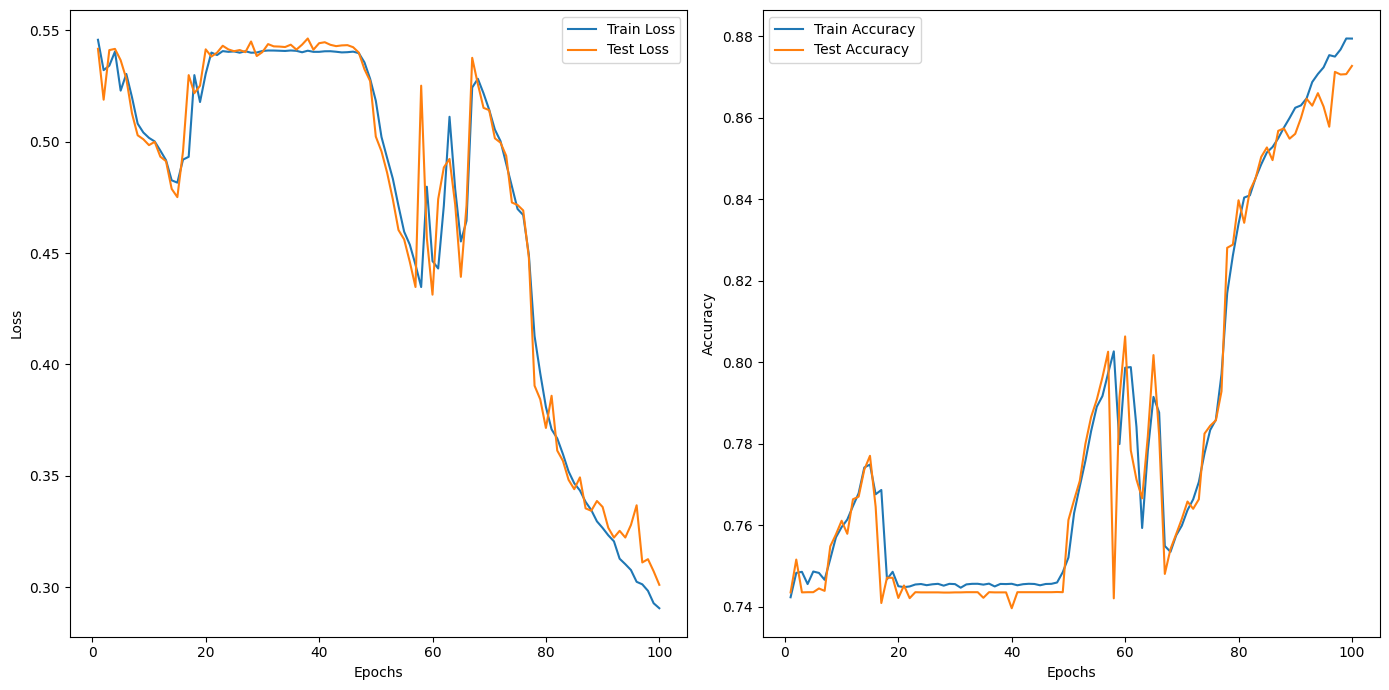

Starting final evaluation on test set...
Final Test Accuracy: 0.5872
Classification Report:
              precision    recall  f1-score   support

          CD       0.83      0.59      0.69      1019
         HYP       0.74      0.43      0.54       519
          MI       0.79      0.53      0.63      1102
        NORM       0.83      0.87      0.85      1906
        STTC       0.72      0.72      0.72      1055

   micro avg       0.79      0.68      0.73      5601
   macro avg       0.78      0.62      0.69      5601
weighted avg       0.79      0.68      0.72      5601
 samples avg       0.74      0.70      0.70      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


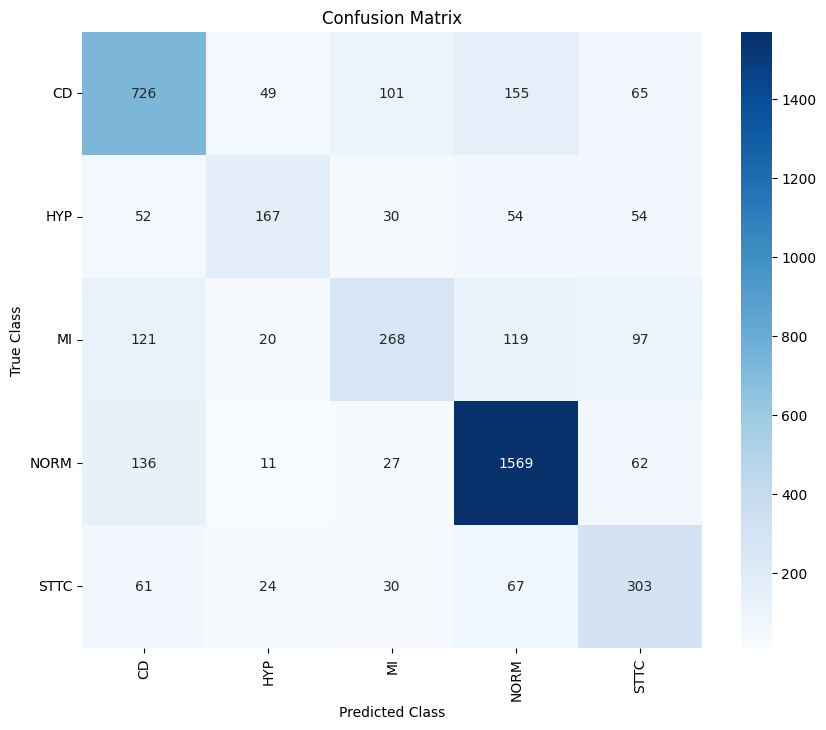

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the LSTM model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Train input shape: {X_train.shape}")
print(f"Test input shape: {X_test.shape}")

# Calculate and print standard deviation
train_std = np.std(X_train)
test_std = np.std(X_test)
print(f"Train data standard deviation: {train_std:.4f}")
print(f"Test data standard deviation: {test_std:.4f}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the LSTM model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 128  # Hidden state size of the LSTM
output_dim = y_train.shape[1]  # Number of output classes

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print model summary and input shape size
print(f"Model Summary:\n{model}")
print(f"Input Shape: {input_dim} leads, {n_timesteps} timesteps")

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


LSTM Hypraprameter tunning

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from optuna.trial import TrialState
from tqdm import tqdm

# Custom Dataset Class
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# LSTM-based Model definition
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim, dropout_rate):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        # Take only the output from the last time step
        lstm_out = lstm_out[:, -1, :]
        out = self.fc(self.dropout(lstm_out))
        return out

# Function to create and train the LSTM model
def train_model(trial, X_train, y_train, X_val, y_val, n_leads, output_dim):
    # Hyperparameters from Optuna
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)

    # Initialize the LSTM model
    model = LSTMModel(input_size=n_leads, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # DataLoader
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Early stopping parameters
    patience = 10
    best_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss, val_accuracy


# Cross-validation function with Optuna
def cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5):
    skf = StratifiedKFold(n_splits=n_splits)
    study = optuna.create_study(direction="minimize")

    def objective(trial):
        val_losses = []
        val_accuracies = []
        for train_idx, val_idx in skf.split(X, y.argmax(axis=1)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            val_loss, val_accuracy = train_model(trial, X_train, y_train, X_val, y_val, n_leads=n_leads, output_dim=output_dim)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        average_accuracy = np.mean(val_accuracies)
        print(f"Average validation accuracy for this trial: {average_accuracy:.4f}")
        return np.mean(val_losses)

    study.optimize(objective, n_trials=20, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print(f"Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(pruned_trials)}")
    print(f"  Number of complete trials: {len(complete_trials)}")

    best_trial = study.best_trial
    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return best_trial


# Sample dataset preparation function (use real data in practice)
def prepare_sample_data():
    # Placeholder function: Replace this with actual dataset preparation code
    n_samples = 1000
    n_leads = 12
    n_timesteps = 500
    X = np.random.randn(n_samples, n_timesteps, n_leads)
    y = np.random.randint(0, 2, size=(n_samples, 5))
    return X, y


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script execution
if __name__ == "__main__":
    # Prepare sample data (replace with actual ECG dataset loading and preprocessing)
    X, y = prepare_sample_data()

    # Perform cross-validation and hyperparameter optimization using Optuna
    best_trial = cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5)

    print("Finished cross-validation and optimization.")


[I 2024-08-28 16:11:21,190] A new study created in memory with name: no-name-b378879b-1689-4394-bd92-3d051a719584
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 13
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
[I 2024-08-28 16:15:13,298] Trial 0 finished with value: 0.7957456369400024 and parameters: {'hidden_size': 177, 'num_layers': 3, 'dropout_rate': 0.32301046495800145, 'lr': 0.009597332179430939}. Best is trial 0 with value: 0.7957456369400024.


Early stopping at epoch 17
Average validation accuracy for this trial: 0.5110


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 13
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
[I 2024-08-28 16:16:32,590] Trial 1 finished with value: 0.7779811267852784 and parameters: {'hidden_size': 211, 'num_layers': 3, 'dropout_rate': 0.3351857806421551, 'lr': 0.009389907655482619}. Best is trial 1 with value: 0.7779811267852784.


Early stopping at epoch 14
Average validation accuracy for this trial: 0.5026


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 12
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
[I 2024-08-28 16:16:42,529] Trial 2 finished with value: 0.7011104307174683 and parameters: {'hidden_size': 56, 'num_layers': 3, 'dropout_rate': 0.20438506467504708, 'lr': 0.0012407824224366852}. Best is trial 2 with value: 0.7011104307174683.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 13
Average validation accuracy for this trial: 0.5026
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 12
Early stopping at epoch 12


[I 2024-08-28 16:17:14,610] Trial 3 finished with value: 0.7485402598381043 and parameters: {'hidden_size': 114, 'num_layers': 3, 'dropout_rate': 0.3488489427666386, 'lr': 0.005078740005179503}. Best is trial 2 with value: 0.7011104307174683.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.5038


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 14
Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
[I 2024-08-28 16:17:23,200] Trial 4 finished with value: 0.7275131664276123 and parameters: {'hidden_size': 37, 'num_layers': 3, 'dropout_rate': 0.43869995348224566, 'lr': 0.0077169409136298205}. Best is trial 2 with value: 0.7011104307174683.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:17:23,387] Trial 5 pruned. 


Early stopping at epoch 15
Average validation accuracy for this trial: 0.5098


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:17:24,356] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3352933592157098 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:17:24,822] Trial 7 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWa

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 18


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
[I 2024-08-28 16:17:36,131] Trial 11 finished with value: 0.7019035778045655 and parameters: {'hidden_size': 35, 'num_layers': 3, 'dropout_rate': 0.42611892652536204, 'lr': 0.00237615551694718}. Best is trial 2 with value: 0.7011104307174683.
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 16
Average validation accuracy for this trial: 0.5124


[I 2024-08-28 16:17:36,691] Trial 12 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 14
Early stopping at epoch 11


[I 2024-08-28 16:17:47,413] Trial 13 finished with value: 0.7075823903083801 and parameters: {'hidden_size': 69, 'num_layers': 2, 'dropout_rate': 0.4152472263380423, 'lr': 0.0025165352776272934}. Best is trial 2 with value: 0.7011104307174683.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5058


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:17:51,696] Trial 14 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:17:52,118] Trial 15 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 14
Early stopping at epoch 11


[I 2024-08-28 16:18:01,134] Trial 16 finished with value: 0.71349005317688 and parameters: {'hidden_size': 52, 'num_layers': 3, 'dropout_rate': 0.2745256789965155, 'lr': 0.0036112738828237524}. Best is trial 2 with value: 0.7011104307174683.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4984


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.3849237169739415 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:18:01,870] Trial 17 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:18:02,438] Trial 18 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: User

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
[I 2024-08-28 16:18:09,347] Trial 19 finished with value: 0.7050742354393005 and parameters: {'hidden_size': 56, 'num_layers': 2, 'dropout_rate': 0.44430693445031993, 'lr': 0.0036396937342421574}. Best is trial 2 with value: 0.7011104307174683.


Early stopping at epoch 12
Average validation accuracy for this trial: 0.5128
Study statistics: 
  Number of finished trials: 20
  Number of pruned trials: 11
  Number of complete trials: 9
Best trial:
  Value: 0.7011104307174683
  Params: 
    hidden_size: 56
    num_layers: 3
    dropout_rate: 0.20438506467504708
    lr: 0.0012407824224366852
Finished cross-validation and optimization.


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:34<00:00, 230.76it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Train input shape: (17469, 500, 12)
Test input shape: (4368, 500, 12)
Train data standard deviation: 0.2336
Test data standard deviation: 0.2317
Model Summary:
LSTMModel(
  (lstm): LSTM(12, 56, num_layers=3, batch_first=True, dropout=0.204)
  (fc): Linear(in_features=56, out_features=5, bias=True)
)
Input Shape: 12 leads, 500 timesteps

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:03<00:00, 81.15it/s]


End of Epoch 1: Train Loss: 0.5483, Train Accuracy: 0.7386
End of Epoch 1: Test Loss: 0.5422, Test Accuracy: 0.7435

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:03<00:00, 82.52it/s]


End of Epoch 2: Train Loss: 0.5390, Train Accuracy: 0.7443
End of Epoch 2: Test Loss: 0.5334, Test Accuracy: 0.7435

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:03<00:00, 82.90it/s]


End of Epoch 3: Train Loss: 0.5315, Train Accuracy: 0.7455
End of Epoch 3: Test Loss: 0.5289, Test Accuracy: 0.7414

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:03<00:00, 82.74it/s]


End of Epoch 4: Train Loss: 0.5281, Train Accuracy: 0.7440
End of Epoch 4: Test Loss: 0.5243, Test Accuracy: 0.7435

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:03<00:00, 81.69it/s]


End of Epoch 5: Train Loss: 0.5268, Train Accuracy: 0.7484
End of Epoch 5: Test Loss: 0.5343, Test Accuracy: 0.7458

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:03<00:00, 81.82it/s]


End of Epoch 6: Train Loss: 0.5263, Train Accuracy: 0.7480
End of Epoch 6: Test Loss: 0.5251, Test Accuracy: 0.7530

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:03<00:00, 83.03it/s]


End of Epoch 7: Train Loss: 0.5225, Train Accuracy: 0.7534
End of Epoch 7: Test Loss: 0.5333, Test Accuracy: 0.7516

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:03<00:00, 82.65it/s]


End of Epoch 8: Train Loss: 0.5410, Train Accuracy: 0.7457
End of Epoch 8: Test Loss: 0.5424, Test Accuracy: 0.7435

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:03<00:00, 83.37it/s]


End of Epoch 9: Train Loss: 0.5405, Train Accuracy: 0.7456
End of Epoch 9: Test Loss: 0.5421, Test Accuracy: 0.7435

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:03<00:00, 83.84it/s]


End of Epoch 10: Train Loss: 0.5212, Train Accuracy: 0.7493
End of Epoch 10: Test Loss: 0.5104, Test Accuracy: 0.7512

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:03<00:00, 83.52it/s]


End of Epoch 11: Train Loss: 0.5137, Train Accuracy: 0.7491
End of Epoch 11: Test Loss: 0.5030, Test Accuracy: 0.7544

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:03<00:00, 83.86it/s]


End of Epoch 12: Train Loss: 0.5119, Train Accuracy: 0.7552
End of Epoch 12: Test Loss: 0.5018, Test Accuracy: 0.7560

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:03<00:00, 84.52it/s]


End of Epoch 13: Train Loss: 0.5001, Train Accuracy: 0.7590
End of Epoch 13: Test Loss: 0.4933, Test Accuracy: 0.7612

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:03<00:00, 84.80it/s]


End of Epoch 14: Train Loss: 0.4939, Train Accuracy: 0.7640
End of Epoch 14: Test Loss: 0.4917, Test Accuracy: 0.7621

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:03<00:00, 83.90it/s]


End of Epoch 15: Train Loss: 0.4971, Train Accuracy: 0.7621
End of Epoch 15: Test Loss: 0.4875, Test Accuracy: 0.7642

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:03<00:00, 84.92it/s]


End of Epoch 16: Train Loss: 0.5068, Train Accuracy: 0.7519
End of Epoch 16: Test Loss: 0.5029, Test Accuracy: 0.7544

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:03<00:00, 85.28it/s]


End of Epoch 17: Train Loss: 0.5046, Train Accuracy: 0.7556
End of Epoch 17: Test Loss: 0.5023, Test Accuracy: 0.7575

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:03<00:00, 84.65it/s]


End of Epoch 18: Train Loss: 0.5080, Train Accuracy: 0.7558
End of Epoch 18: Test Loss: 0.4934, Test Accuracy: 0.7693

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:03<00:00, 84.32it/s]


End of Epoch 19: Train Loss: 0.4883, Train Accuracy: 0.7710
End of Epoch 19: Test Loss: 0.4747, Test Accuracy: 0.7769

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:03<00:00, 84.32it/s]


End of Epoch 20: Train Loss: 0.4597, Train Accuracy: 0.7879
End of Epoch 20: Test Loss: 0.4559, Test Accuracy: 0.7890

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:03<00:00, 84.87it/s]


End of Epoch 21: Train Loss: 0.4495, Train Accuracy: 0.7922
End of Epoch 21: Test Loss: 0.4332, Test Accuracy: 0.8011

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:03<00:00, 84.20it/s]


End of Epoch 22: Train Loss: 0.4346, Train Accuracy: 0.8021
End of Epoch 22: Test Loss: 0.4191, Test Accuracy: 0.8074

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:03<00:00, 84.48it/s]


End of Epoch 23: Train Loss: 0.4173, Train Accuracy: 0.8078
End of Epoch 23: Test Loss: 0.4055, Test Accuracy: 0.8109

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:03<00:00, 84.27it/s]


End of Epoch 24: Train Loss: 0.4377, Train Accuracy: 0.7992
End of Epoch 24: Test Loss: 0.3993, Test Accuracy: 0.8214

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:03<00:00, 83.83it/s]


End of Epoch 25: Train Loss: 0.3854, Train Accuracy: 0.8303
End of Epoch 25: Test Loss: 0.3811, Test Accuracy: 0.8333

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:03<00:00, 83.99it/s]


End of Epoch 26: Train Loss: 0.3701, Train Accuracy: 0.8381
End of Epoch 26: Test Loss: 0.3617, Test Accuracy: 0.8392

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:03<00:00, 83.64it/s]


End of Epoch 27: Train Loss: 0.3671, Train Accuracy: 0.8401
End of Epoch 27: Test Loss: 0.3976, Test Accuracy: 0.8227

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:03<00:00, 83.90it/s]


End of Epoch 28: Train Loss: 0.3577, Train Accuracy: 0.8454
End of Epoch 28: Test Loss: 0.3869, Test Accuracy: 0.8279

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:03<00:00, 83.16it/s]


End of Epoch 29: Train Loss: 0.3425, Train Accuracy: 0.8523
End of Epoch 29: Test Loss: 0.3426, Test Accuracy: 0.8526

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:03<00:00, 83.65it/s]


End of Epoch 30: Train Loss: 0.3344, Train Accuracy: 0.8569
End of Epoch 30: Test Loss: 0.3310, Test Accuracy: 0.8560

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:03<00:00, 84.07it/s]


End of Epoch 31: Train Loss: 0.3267, Train Accuracy: 0.8602
End of Epoch 31: Test Loss: 0.3258, Test Accuracy: 0.8621

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:03<00:00, 83.18it/s]


End of Epoch 32: Train Loss: 0.3202, Train Accuracy: 0.8641
End of Epoch 32: Test Loss: 0.3219, Test Accuracy: 0.8629

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:03<00:00, 83.66it/s]


End of Epoch 33: Train Loss: 0.3136, Train Accuracy: 0.8684
End of Epoch 33: Test Loss: 0.3130, Test Accuracy: 0.8676

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:03<00:00, 83.71it/s]


End of Epoch 34: Train Loss: 0.3054, Train Accuracy: 0.8719
End of Epoch 34: Test Loss: 0.3081, Test Accuracy: 0.8694

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:03<00:00, 83.23it/s]


End of Epoch 35: Train Loss: 0.3000, Train Accuracy: 0.8748
End of Epoch 35: Test Loss: 0.3056, Test Accuracy: 0.8734

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:03<00:00, 83.17it/s]


End of Epoch 36: Train Loss: 0.2960, Train Accuracy: 0.8765
End of Epoch 36: Test Loss: 0.3005, Test Accuracy: 0.8744

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:03<00:00, 84.43it/s]


End of Epoch 37: Train Loss: 0.2901, Train Accuracy: 0.8800
End of Epoch 37: Test Loss: 0.2968, Test Accuracy: 0.8770

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:03<00:00, 84.24it/s]


End of Epoch 38: Train Loss: 0.2863, Train Accuracy: 0.8824
End of Epoch 38: Test Loss: 0.2976, Test Accuracy: 0.8754

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:03<00:00, 83.56it/s]


End of Epoch 39: Train Loss: 0.2845, Train Accuracy: 0.8818
End of Epoch 39: Test Loss: 0.2909, Test Accuracy: 0.8778

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:03<00:00, 84.18it/s]


End of Epoch 40: Train Loss: 0.2795, Train Accuracy: 0.8859
End of Epoch 40: Test Loss: 0.2917, Test Accuracy: 0.8779

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:03<00:00, 84.62it/s]


End of Epoch 41: Train Loss: 0.2769, Train Accuracy: 0.8857
End of Epoch 41: Test Loss: 0.2878, Test Accuracy: 0.8783

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:03<00:00, 83.76it/s]


End of Epoch 42: Train Loss: 0.2726, Train Accuracy: 0.8886
End of Epoch 42: Test Loss: 0.2851, Test Accuracy: 0.8801

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:03<00:00, 84.18it/s]


End of Epoch 43: Train Loss: 0.2694, Train Accuracy: 0.8890
End of Epoch 43: Test Loss: 0.2828, Test Accuracy: 0.8817

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:03<00:00, 84.67it/s]


End of Epoch 44: Train Loss: 0.2674, Train Accuracy: 0.8894
End of Epoch 44: Test Loss: 0.2885, Test Accuracy: 0.8812

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:03<00:00, 84.13it/s]


End of Epoch 45: Train Loss: 0.2647, Train Accuracy: 0.8915
End of Epoch 45: Test Loss: 0.2785, Test Accuracy: 0.8839

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:03<00:00, 84.03it/s]


End of Epoch 46: Train Loss: 0.2632, Train Accuracy: 0.8920
End of Epoch 46: Test Loss: 0.2804, Test Accuracy: 0.8834

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:03<00:00, 84.31it/s]


End of Epoch 47: Train Loss: 0.2596, Train Accuracy: 0.8933
End of Epoch 47: Test Loss: 0.2799, Test Accuracy: 0.8848

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:03<00:00, 84.65it/s]


End of Epoch 48: Train Loss: 0.2552, Train Accuracy: 0.8944
End of Epoch 48: Test Loss: 0.2777, Test Accuracy: 0.8837

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:03<00:00, 83.56it/s]


End of Epoch 49: Train Loss: 0.2598, Train Accuracy: 0.8929
End of Epoch 49: Test Loss: 0.2729, Test Accuracy: 0.8850

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:03<00:00, 83.89it/s]


End of Epoch 50: Train Loss: 0.2528, Train Accuracy: 0.8967
End of Epoch 50: Test Loss: 0.2754, Test Accuracy: 0.8839

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:03<00:00, 84.58it/s]


End of Epoch 51: Train Loss: 0.2526, Train Accuracy: 0.8960
End of Epoch 51: Test Loss: 0.2795, Test Accuracy: 0.8841

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:03<00:00, 83.77it/s]


End of Epoch 52: Train Loss: 0.2488, Train Accuracy: 0.8979
End of Epoch 52: Test Loss: 0.2734, Test Accuracy: 0.8848

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:03<00:00, 83.62it/s]


End of Epoch 53: Train Loss: 0.2465, Train Accuracy: 0.8987
End of Epoch 53: Test Loss: 0.2708, Test Accuracy: 0.8857

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:03<00:00, 84.32it/s]


End of Epoch 54: Train Loss: 0.2455, Train Accuracy: 0.8993
End of Epoch 54: Test Loss: 0.2791, Test Accuracy: 0.8822

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:03<00:00, 84.10it/s]


End of Epoch 55: Train Loss: 0.2438, Train Accuracy: 0.9005
End of Epoch 55: Test Loss: 0.2707, Test Accuracy: 0.8859

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:03<00:00, 83.88it/s]


End of Epoch 56: Train Loss: 0.2425, Train Accuracy: 0.9003
End of Epoch 56: Test Loss: 0.2711, Test Accuracy: 0.8861

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:03<00:00, 84.94it/s]


End of Epoch 57: Train Loss: 0.2408, Train Accuracy: 0.9018
End of Epoch 57: Test Loss: 0.2759, Test Accuracy: 0.8850

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:03<00:00, 84.19it/s]


End of Epoch 58: Train Loss: 0.2392, Train Accuracy: 0.9015
End of Epoch 58: Test Loss: 0.2742, Test Accuracy: 0.8864

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:03<00:00, 83.24it/s]


End of Epoch 59: Train Loss: 0.2355, Train Accuracy: 0.9040
End of Epoch 59: Test Loss: 0.2766, Test Accuracy: 0.8860

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:03<00:00, 84.48it/s]


End of Epoch 60: Train Loss: 0.2346, Train Accuracy: 0.9037
End of Epoch 60: Test Loss: 0.2773, Test Accuracy: 0.8853

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:03<00:00, 84.10it/s]


End of Epoch 61: Train Loss: 0.2333, Train Accuracy: 0.9042
End of Epoch 61: Test Loss: 0.2727, Test Accuracy: 0.8859

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:03<00:00, 84.10it/s]


End of Epoch 62: Train Loss: 0.2299, Train Accuracy: 0.9063
End of Epoch 62: Test Loss: 0.2803, Test Accuracy: 0.8860

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:03<00:00, 83.95it/s]


End of Epoch 63: Train Loss: 0.2304, Train Accuracy: 0.9060
End of Epoch 63: Test Loss: 0.2708, Test Accuracy: 0.8861

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:03<00:00, 84.38it/s]


End of Epoch 64: Train Loss: 0.2265, Train Accuracy: 0.9072
End of Epoch 64: Test Loss: 0.2780, Test Accuracy: 0.8858

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:03<00:00, 84.44it/s]


End of Epoch 65: Train Loss: 0.2249, Train Accuracy: 0.9071
End of Epoch 65: Test Loss: 0.2788, Test Accuracy: 0.8877

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:03<00:00, 82.83it/s]


End of Epoch 66: Train Loss: 0.2217, Train Accuracy: 0.9093
End of Epoch 66: Test Loss: 0.2795, Test Accuracy: 0.8853

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:03<00:00, 84.35it/s]


End of Epoch 67: Train Loss: 0.2227, Train Accuracy: 0.9085
End of Epoch 67: Test Loss: 0.2699, Test Accuracy: 0.8883

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:03<00:00, 84.83it/s]


End of Epoch 68: Train Loss: 0.2196, Train Accuracy: 0.9094
End of Epoch 68: Test Loss: 0.2790, Test Accuracy: 0.8846

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:03<00:00, 84.28it/s]


End of Epoch 69: Train Loss: 0.2193, Train Accuracy: 0.9111
End of Epoch 69: Test Loss: 0.2760, Test Accuracy: 0.8863

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:03<00:00, 84.04it/s]


End of Epoch 70: Train Loss: 0.2150, Train Accuracy: 0.9123
End of Epoch 70: Test Loss: 0.2748, Test Accuracy: 0.8856

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:03<00:00, 84.66it/s]


End of Epoch 71: Train Loss: 0.2146, Train Accuracy: 0.9122
End of Epoch 71: Test Loss: 0.2750, Test Accuracy: 0.8855

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:03<00:00, 84.55it/s]


End of Epoch 72: Train Loss: 0.2130, Train Accuracy: 0.9133
End of Epoch 72: Test Loss: 0.2815, Test Accuracy: 0.8864

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:03<00:00, 83.51it/s]


End of Epoch 73: Train Loss: 0.2111, Train Accuracy: 0.9141
End of Epoch 73: Test Loss: 0.2772, Test Accuracy: 0.8858

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:03<00:00, 84.51it/s]


End of Epoch 74: Train Loss: 0.2102, Train Accuracy: 0.9145
End of Epoch 74: Test Loss: 0.2819, Test Accuracy: 0.8848

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:03<00:00, 84.62it/s]


End of Epoch 75: Train Loss: 0.2082, Train Accuracy: 0.9155
End of Epoch 75: Test Loss: 0.2889, Test Accuracy: 0.8844

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:03<00:00, 84.15it/s]


End of Epoch 76: Train Loss: 0.2083, Train Accuracy: 0.9148
End of Epoch 76: Test Loss: 0.2854, Test Accuracy: 0.8859

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:03<00:00, 84.39it/s]


End of Epoch 77: Train Loss: 0.2061, Train Accuracy: 0.9159
End of Epoch 77: Test Loss: 0.2827, Test Accuracy: 0.8868

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:03<00:00, 84.60it/s]


End of Epoch 78: Train Loss: 0.2046, Train Accuracy: 0.9164
End of Epoch 78: Test Loss: 0.2841, Test Accuracy: 0.8873

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:03<00:00, 84.13it/s]


End of Epoch 79: Train Loss: 0.2005, Train Accuracy: 0.9175
End of Epoch 79: Test Loss: 0.2864, Test Accuracy: 0.8845

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:03<00:00, 83.74it/s]


End of Epoch 80: Train Loss: 0.2032, Train Accuracy: 0.9164
End of Epoch 80: Test Loss: 0.2868, Test Accuracy: 0.8861

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:03<00:00, 84.61it/s]


End of Epoch 81: Train Loss: 0.2017, Train Accuracy: 0.9179
End of Epoch 81: Test Loss: 0.2782, Test Accuracy: 0.8864

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:03<00:00, 84.15it/s]


End of Epoch 82: Train Loss: 0.2055, Train Accuracy: 0.9164
End of Epoch 82: Test Loss: 0.2816, Test Accuracy: 0.8839

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:03<00:00, 82.66it/s]


End of Epoch 83: Train Loss: 0.1990, Train Accuracy: 0.9191
End of Epoch 83: Test Loss: 0.2863, Test Accuracy: 0.8849

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:03<00:00, 84.09it/s]


End of Epoch 84: Train Loss: 0.2016, Train Accuracy: 0.9175
End of Epoch 84: Test Loss: 0.2820, Test Accuracy: 0.8873

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:03<00:00, 84.19it/s]


End of Epoch 85: Train Loss: 0.1951, Train Accuracy: 0.9197
End of Epoch 85: Test Loss: 0.2884, Test Accuracy: 0.8885

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:03<00:00, 83.34it/s]


End of Epoch 86: Train Loss: 0.1924, Train Accuracy: 0.9217
End of Epoch 86: Test Loss: 0.2920, Test Accuracy: 0.8876

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:03<00:00, 84.04it/s]


End of Epoch 87: Train Loss: 0.1897, Train Accuracy: 0.9237
End of Epoch 87: Test Loss: 0.2900, Test Accuracy: 0.8842

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:03<00:00, 84.29it/s]


End of Epoch 88: Train Loss: 0.1888, Train Accuracy: 0.9236
End of Epoch 88: Test Loss: 0.2888, Test Accuracy: 0.8865

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:03<00:00, 84.07it/s]


End of Epoch 89: Train Loss: 0.1906, Train Accuracy: 0.9225
End of Epoch 89: Test Loss: 0.2966, Test Accuracy: 0.8837

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:03<00:00, 83.74it/s]


End of Epoch 90: Train Loss: 0.1879, Train Accuracy: 0.9240
End of Epoch 90: Test Loss: 0.2966, Test Accuracy: 0.8848

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:03<00:00, 84.30it/s]


End of Epoch 91: Train Loss: 0.1898, Train Accuracy: 0.9237
End of Epoch 91: Test Loss: 0.2942, Test Accuracy: 0.8846

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:03<00:00, 84.59it/s]


End of Epoch 92: Train Loss: 0.1844, Train Accuracy: 0.9255
End of Epoch 92: Test Loss: 0.2996, Test Accuracy: 0.8842

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:03<00:00, 83.91it/s]


End of Epoch 93: Train Loss: 0.1829, Train Accuracy: 0.9258
End of Epoch 93: Test Loss: 0.3010, Test Accuracy: 0.8875

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:03<00:00, 83.82it/s]


End of Epoch 94: Train Loss: 0.1850, Train Accuracy: 0.9251
End of Epoch 94: Test Loss: 0.2957, Test Accuracy: 0.8846

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:03<00:00, 84.54it/s]


End of Epoch 95: Train Loss: 0.1833, Train Accuracy: 0.9261
End of Epoch 95: Test Loss: 0.3057, Test Accuracy: 0.8805

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:03<00:00, 84.05it/s]


End of Epoch 96: Train Loss: 0.1806, Train Accuracy: 0.9280
End of Epoch 96: Test Loss: 0.3014, Test Accuracy: 0.8846

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:03<00:00, 83.46it/s]


End of Epoch 97: Train Loss: 0.1780, Train Accuracy: 0.9288
End of Epoch 97: Test Loss: 0.3035, Test Accuracy: 0.8824

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:03<00:00, 84.30it/s]


End of Epoch 98: Train Loss: 0.1789, Train Accuracy: 0.9277
End of Epoch 98: Test Loss: 0.3021, Test Accuracy: 0.8848

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:03<00:00, 84.25it/s]


End of Epoch 99: Train Loss: 0.1769, Train Accuracy: 0.9282
End of Epoch 99: Test Loss: 0.3154, Test Accuracy: 0.8829

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:03<00:00, 83.42it/s]


End of Epoch 100: Train Loss: 0.1769, Train Accuracy: 0.9286
End of Epoch 100: Test Loss: 0.3034, Test Accuracy: 0.8827
Training complete. Plotting loss and accuracy curves...


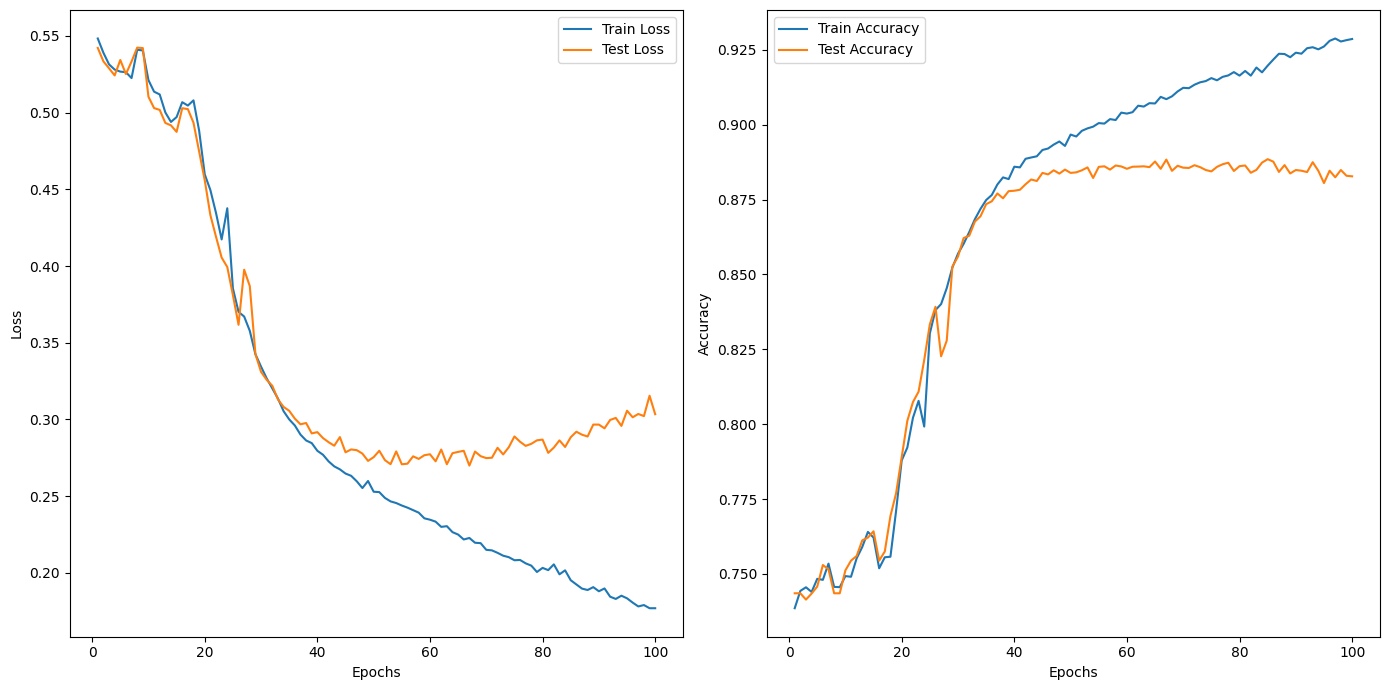

Starting final evaluation on test set...
Final Test Accuracy: 0.6218
Classification Report:
              precision    recall  f1-score   support

          CD       0.85      0.66      0.75      1019
         HYP       0.66      0.51      0.58       519
          MI       0.74      0.75      0.74      1102
        NORM       0.86      0.85      0.86      1906
        STTC       0.70      0.76      0.73      1055

   micro avg       0.78      0.75      0.77      5601
   macro avg       0.76      0.71      0.73      5601
weighted avg       0.79      0.75      0.76      5601
 samples avg       0.77      0.76      0.75      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


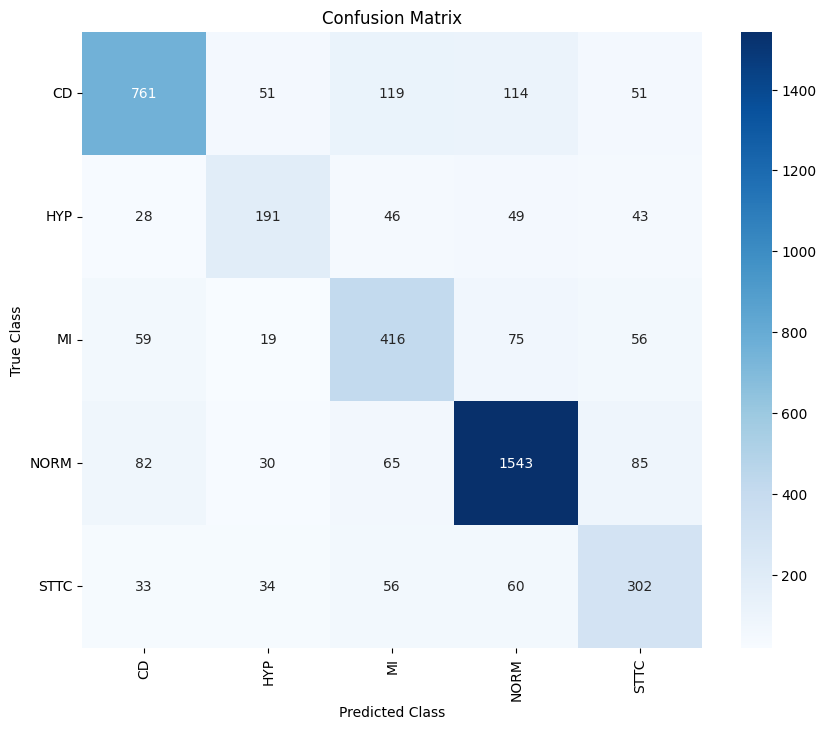

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the LSTM model with best trial parameters from Optuna
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3):  # Updated num_layers
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.204)  # Updated dropout_rate
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Train input shape: {X_train.shape}")
print(f"Test input shape: {X_test.shape}")

# Calculate and print standard deviation
train_std = np.std(X_train)
test_std = np.std(X_test)
print(f"Train data standard deviation: {train_std:.4f}")
print(f"Test data standard deviation: {test_std:.4f}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the LSTM model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 56  # Updated hidden_size from Optuna trial
output_dim = y_train.shape[1]  # Number of output classes

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=3).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0012407824224366852)  # Updated learning rate

# Print model summary and input shape size
print(f"Model Summary:\n{model}")
print(f"Input Shape: {input_dim} leads, {n_timesteps} timesteps")

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


LSTM lauyer increase

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [54:25<00:00,  6.69it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Training set size: 17469 samples
Test set size: 4368 samples
Train input shape: (17469, 500, 12)
Test input shape: (4368, 500, 12)
Train data standard deviation: 0.2336
Test data standard deviation: 0.2317
Model Summary:
LSTMModel(
  (lstm): LSTM(12, 56, num_layers=4, batch_first=True, dropout=0.204)
  (fc): Linear(in_features=56, out_features=5, bias=True)
)
Input Shape: 12 leads, 500 timesteps

Starting Epoch 1/100


Training Epoch 1/100: 100%|██████████| 273/273 [00:04<00:00, 62.52it/s]


End of Epoch 1: Train Loss: 0.5468, Train Accuracy: 0.7425
End of Epoch 1: Test Loss: 0.5428, Test Accuracy: 0.7435

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:04<00:00, 68.08it/s]


End of Epoch 2: Train Loss: 0.5381, Train Accuracy: 0.7451
End of Epoch 2: Test Loss: 0.5379, Test Accuracy: 0.7435

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:04<00:00, 67.34it/s]


End of Epoch 3: Train Loss: 0.5372, Train Accuracy: 0.7449
End of Epoch 3: Test Loss: 0.5380, Test Accuracy: 0.7435

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:04<00:00, 66.58it/s]


End of Epoch 4: Train Loss: 0.5375, Train Accuracy: 0.7453
End of Epoch 4: Test Loss: 0.5384, Test Accuracy: 0.7435

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:04<00:00, 66.79it/s]


End of Epoch 5: Train Loss: 0.5376, Train Accuracy: 0.7454
End of Epoch 5: Test Loss: 0.5425, Test Accuracy: 0.7435

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:04<00:00, 66.44it/s]


End of Epoch 6: Train Loss: 0.5407, Train Accuracy: 0.7456
End of Epoch 6: Test Loss: 0.5424, Test Accuracy: 0.7435

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:04<00:00, 66.12it/s]


End of Epoch 7: Train Loss: 0.5348, Train Accuracy: 0.7441
End of Epoch 7: Test Loss: 0.5226, Test Accuracy: 0.7398

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:04<00:00, 66.07it/s]


End of Epoch 8: Train Loss: 0.5183, Train Accuracy: 0.7489
End of Epoch 8: Test Loss: 0.5116, Test Accuracy: 0.7540

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:04<00:00, 65.48it/s]


End of Epoch 9: Train Loss: 0.5206, Train Accuracy: 0.7486
End of Epoch 9: Test Loss: 0.5421, Test Accuracy: 0.7435

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:04<00:00, 65.81it/s]


End of Epoch 10: Train Loss: 0.5406, Train Accuracy: 0.7456
End of Epoch 10: Test Loss: 0.5396, Test Accuracy: 0.7435

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:04<00:00, 65.74it/s]


End of Epoch 11: Train Loss: 0.5437, Train Accuracy: 0.7429
End of Epoch 11: Test Loss: 0.5431, Test Accuracy: 0.7436

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:04<00:00, 65.29it/s]


End of Epoch 12: Train Loss: 0.5408, Train Accuracy: 0.7456
End of Epoch 12: Test Loss: 0.5421, Test Accuracy: 0.7436

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:04<00:00, 65.36it/s]


End of Epoch 13: Train Loss: 0.5399, Train Accuracy: 0.7456
End of Epoch 13: Test Loss: 0.5429, Test Accuracy: 0.7436

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:04<00:00, 64.80it/s]


End of Epoch 14: Train Loss: 0.5401, Train Accuracy: 0.7456
End of Epoch 14: Test Loss: 0.5335, Test Accuracy: 0.7435

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:04<00:00, 64.31it/s]


End of Epoch 15: Train Loss: 0.5216, Train Accuracy: 0.7511
End of Epoch 15: Test Loss: 0.5143, Test Accuracy: 0.7600

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:04<00:00, 64.35it/s]


End of Epoch 16: Train Loss: 0.5069, Train Accuracy: 0.7566
End of Epoch 16: Test Loss: 0.5030, Test Accuracy: 0.7564

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:04<00:00, 63.66it/s]


End of Epoch 17: Train Loss: 0.5015, Train Accuracy: 0.7618
End of Epoch 17: Test Loss: 0.4996, Test Accuracy: 0.7636

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:04<00:00, 63.56it/s]


End of Epoch 18: Train Loss: 0.4935, Train Accuracy: 0.7653
End of Epoch 18: Test Loss: 0.4877, Test Accuracy: 0.7663

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:04<00:00, 63.31it/s]


End of Epoch 19: Train Loss: 0.4731, Train Accuracy: 0.7786
End of Epoch 19: Test Loss: 0.4572, Test Accuracy: 0.7834

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:04<00:00, 63.09it/s]


End of Epoch 20: Train Loss: 0.4509, Train Accuracy: 0.7917
End of Epoch 20: Test Loss: 0.4382, Test Accuracy: 0.7973

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:04<00:00, 62.74it/s]


End of Epoch 21: Train Loss: 0.4687, Train Accuracy: 0.7838
End of Epoch 21: Test Loss: 0.4563, Test Accuracy: 0.7908

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:04<00:00, 62.30it/s]


End of Epoch 22: Train Loss: 0.4456, Train Accuracy: 0.7957
End of Epoch 22: Test Loss: 0.4324, Test Accuracy: 0.8014

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:04<00:00, 62.17it/s]


End of Epoch 23: Train Loss: 0.4316, Train Accuracy: 0.8017
End of Epoch 23: Test Loss: 0.4282, Test Accuracy: 0.8053

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:04<00:00, 62.33it/s]


End of Epoch 24: Train Loss: 0.4241, Train Accuracy: 0.8046
End of Epoch 24: Test Loss: 0.4181, Test Accuracy: 0.8073

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:04<00:00, 62.39it/s]


End of Epoch 25: Train Loss: 0.4196, Train Accuracy: 0.8075
End of Epoch 25: Test Loss: 0.4212, Test Accuracy: 0.8051

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:04<00:00, 62.36it/s]


End of Epoch 26: Train Loss: 0.4177, Train Accuracy: 0.8087
End of Epoch 26: Test Loss: 0.4141, Test Accuracy: 0.8103

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:04<00:00, 62.33it/s]


End of Epoch 27: Train Loss: 0.4187, Train Accuracy: 0.8085
End of Epoch 27: Test Loss: 0.4130, Test Accuracy: 0.8073

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:04<00:00, 62.61it/s]


End of Epoch 28: Train Loss: 0.4143, Train Accuracy: 0.8076
End of Epoch 28: Test Loss: 0.4110, Test Accuracy: 0.8090

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:04<00:00, 62.98it/s]


End of Epoch 29: Train Loss: 0.4098, Train Accuracy: 0.8106
End of Epoch 29: Test Loss: 0.4095, Test Accuracy: 0.8074

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:04<00:00, 62.83it/s]


End of Epoch 30: Train Loss: 0.4095, Train Accuracy: 0.8110
End of Epoch 30: Test Loss: 0.4069, Test Accuracy: 0.8120

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:04<00:00, 62.95it/s]


End of Epoch 31: Train Loss: 0.4032, Train Accuracy: 0.8130
End of Epoch 31: Test Loss: 0.4036, Test Accuracy: 0.8120

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:04<00:00, 62.85it/s]


End of Epoch 32: Train Loss: 0.3994, Train Accuracy: 0.8141
End of Epoch 32: Test Loss: 0.3932, Test Accuracy: 0.8164

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:04<00:00, 63.21it/s]


End of Epoch 33: Train Loss: 0.3927, Train Accuracy: 0.8196
End of Epoch 33: Test Loss: 0.3905, Test Accuracy: 0.8183

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:04<00:00, 63.12it/s]


End of Epoch 34: Train Loss: 0.3905, Train Accuracy: 0.8200
End of Epoch 34: Test Loss: 0.3855, Test Accuracy: 0.8228

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:04<00:00, 62.83it/s]


End of Epoch 35: Train Loss: 0.3846, Train Accuracy: 0.8256
End of Epoch 35: Test Loss: 0.3793, Test Accuracy: 0.8281

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:04<00:00, 62.96it/s]


End of Epoch 36: Train Loss: 0.3800, Train Accuracy: 0.8290
End of Epoch 36: Test Loss: 0.3758, Test Accuracy: 0.8302

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:04<00:00, 62.83it/s]


End of Epoch 37: Train Loss: 0.3742, Train Accuracy: 0.8326
End of Epoch 37: Test Loss: 0.3712, Test Accuracy: 0.8326

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:04<00:00, 62.72it/s]


End of Epoch 38: Train Loss: 0.3707, Train Accuracy: 0.8349
End of Epoch 38: Test Loss: 0.3671, Test Accuracy: 0.8376

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:04<00:00, 62.84it/s]


End of Epoch 39: Train Loss: 0.3675, Train Accuracy: 0.8373
End of Epoch 39: Test Loss: 0.3640, Test Accuracy: 0.8436

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:04<00:00, 62.71it/s]


End of Epoch 40: Train Loss: 0.3615, Train Accuracy: 0.8412
End of Epoch 40: Test Loss: 0.3651, Test Accuracy: 0.8402

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:04<00:00, 62.55it/s]


End of Epoch 41: Train Loss: 0.3575, Train Accuracy: 0.8426
End of Epoch 41: Test Loss: 0.3519, Test Accuracy: 0.8456

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:04<00:00, 62.40it/s]


End of Epoch 42: Train Loss: 0.3522, Train Accuracy: 0.8466
End of Epoch 42: Test Loss: 0.3498, Test Accuracy: 0.8489

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:04<00:00, 62.53it/s]


End of Epoch 43: Train Loss: 0.3499, Train Accuracy: 0.8484
End of Epoch 43: Test Loss: 0.3587, Test Accuracy: 0.8420

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:04<00:00, 62.79it/s]


End of Epoch 44: Train Loss: 0.3611, Train Accuracy: 0.8410
End of Epoch 44: Test Loss: 0.3466, Test Accuracy: 0.8473

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:04<00:00, 62.62it/s]


End of Epoch 45: Train Loss: 0.3419, Train Accuracy: 0.8516
End of Epoch 45: Test Loss: 0.3365, Test Accuracy: 0.8549

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:04<00:00, 62.95it/s]


End of Epoch 46: Train Loss: 0.3371, Train Accuracy: 0.8541
End of Epoch 46: Test Loss: 0.3346, Test Accuracy: 0.8567

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:04<00:00, 62.76it/s]


End of Epoch 47: Train Loss: 0.3310, Train Accuracy: 0.8581
End of Epoch 47: Test Loss: 0.3278, Test Accuracy: 0.8604

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:04<00:00, 62.90it/s]


End of Epoch 48: Train Loss: 0.3273, Train Accuracy: 0.8598
End of Epoch 48: Test Loss: 0.3362, Test Accuracy: 0.8537

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:04<00:00, 62.86it/s]


End of Epoch 49: Train Loss: 0.3271, Train Accuracy: 0.8597
End of Epoch 49: Test Loss: 0.3293, Test Accuracy: 0.8596

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:04<00:00, 62.73it/s]


End of Epoch 50: Train Loss: 0.3195, Train Accuracy: 0.8634
End of Epoch 50: Test Loss: 0.3194, Test Accuracy: 0.8613

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:04<00:00, 62.93it/s]


End of Epoch 51: Train Loss: 0.3171, Train Accuracy: 0.8647
End of Epoch 51: Test Loss: 0.3214, Test Accuracy: 0.8620

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:04<00:00, 62.93it/s]


End of Epoch 52: Train Loss: 0.3155, Train Accuracy: 0.8664
End of Epoch 52: Test Loss: 0.3144, Test Accuracy: 0.8653

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:04<00:00, 62.90it/s]


End of Epoch 53: Train Loss: 0.3115, Train Accuracy: 0.8691
End of Epoch 53: Test Loss: 0.3162, Test Accuracy: 0.8653

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:04<00:00, 62.72it/s]


End of Epoch 54: Train Loss: 0.3092, Train Accuracy: 0.8699
End of Epoch 54: Test Loss: 0.3085, Test Accuracy: 0.8687

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:04<00:00, 62.70it/s]


End of Epoch 55: Train Loss: 0.3030, Train Accuracy: 0.8730
End of Epoch 55: Test Loss: 0.3146, Test Accuracy: 0.8663

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:04<00:00, 62.82it/s]


End of Epoch 56: Train Loss: 0.3011, Train Accuracy: 0.8748
End of Epoch 56: Test Loss: 0.3068, Test Accuracy: 0.8702

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:04<00:00, 62.96it/s]


End of Epoch 57: Train Loss: 0.2966, Train Accuracy: 0.8765
End of Epoch 57: Test Loss: 0.3023, Test Accuracy: 0.8747

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:04<00:00, 62.81it/s]


End of Epoch 58: Train Loss: 0.2967, Train Accuracy: 0.8762
End of Epoch 58: Test Loss: 0.3069, Test Accuracy: 0.8716

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:04<00:00, 63.00it/s]


End of Epoch 59: Train Loss: 0.2918, Train Accuracy: 0.8792
End of Epoch 59: Test Loss: 0.2953, Test Accuracy: 0.8769

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:04<00:00, 62.90it/s]


End of Epoch 60: Train Loss: 0.2903, Train Accuracy: 0.8791
End of Epoch 60: Test Loss: 0.2964, Test Accuracy: 0.8769

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:04<00:00, 62.93it/s]


End of Epoch 61: Train Loss: 0.2863, Train Accuracy: 0.8813
End of Epoch 61: Test Loss: 0.3075, Test Accuracy: 0.8696

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:04<00:00, 62.93it/s]


End of Epoch 62: Train Loss: 0.2852, Train Accuracy: 0.8820
End of Epoch 62: Test Loss: 0.2964, Test Accuracy: 0.8747

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:04<00:00, 62.83it/s]


End of Epoch 63: Train Loss: 0.2812, Train Accuracy: 0.8833
End of Epoch 63: Test Loss: 0.2890, Test Accuracy: 0.8788

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:04<00:00, 63.00it/s]


End of Epoch 64: Train Loss: 0.2798, Train Accuracy: 0.8847
End of Epoch 64: Test Loss: 0.2924, Test Accuracy: 0.8772

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:04<00:00, 63.05it/s]


End of Epoch 65: Train Loss: 0.2786, Train Accuracy: 0.8852
End of Epoch 65: Test Loss: 0.2916, Test Accuracy: 0.8772

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:04<00:00, 62.99it/s]


End of Epoch 66: Train Loss: 0.2781, Train Accuracy: 0.8856
End of Epoch 66: Test Loss: 0.2960, Test Accuracy: 0.8767

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:04<00:00, 62.97it/s]


End of Epoch 67: Train Loss: 0.2750, Train Accuracy: 0.8872
End of Epoch 67: Test Loss: 0.2954, Test Accuracy: 0.8770

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:04<00:00, 62.74it/s]


End of Epoch 68: Train Loss: 0.2722, Train Accuracy: 0.8877
End of Epoch 68: Test Loss: 0.2973, Test Accuracy: 0.8787

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:04<00:00, 62.97it/s]


End of Epoch 69: Train Loss: 0.2712, Train Accuracy: 0.8880
End of Epoch 69: Test Loss: 0.2821, Test Accuracy: 0.8830

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:04<00:00, 62.73it/s]


End of Epoch 70: Train Loss: 0.2692, Train Accuracy: 0.8895
End of Epoch 70: Test Loss: 0.2929, Test Accuracy: 0.8759

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:04<00:00, 63.02it/s]


End of Epoch 71: Train Loss: 0.2667, Train Accuracy: 0.8901
End of Epoch 71: Test Loss: 0.2818, Test Accuracy: 0.8842

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:04<00:00, 63.06it/s]


End of Epoch 72: Train Loss: 0.2656, Train Accuracy: 0.8905
End of Epoch 72: Test Loss: 0.2892, Test Accuracy: 0.8818

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:04<00:00, 62.81it/s]


End of Epoch 73: Train Loss: 0.2648, Train Accuracy: 0.8907
End of Epoch 73: Test Loss: 0.3053, Test Accuracy: 0.8709

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:04<00:00, 62.69it/s]


End of Epoch 74: Train Loss: 0.2626, Train Accuracy: 0.8915
End of Epoch 74: Test Loss: 0.2876, Test Accuracy: 0.8810

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:04<00:00, 62.82it/s]


End of Epoch 75: Train Loss: 0.2624, Train Accuracy: 0.8908
End of Epoch 75: Test Loss: 0.2806, Test Accuracy: 0.8834

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:04<00:00, 63.03it/s]


End of Epoch 76: Train Loss: 0.2590, Train Accuracy: 0.8937
End of Epoch 76: Test Loss: 0.2804, Test Accuracy: 0.8832

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:04<00:00, 62.75it/s]


End of Epoch 77: Train Loss: 0.2580, Train Accuracy: 0.8930
End of Epoch 77: Test Loss: 0.2839, Test Accuracy: 0.8819

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:04<00:00, 62.61it/s]


End of Epoch 78: Train Loss: 0.2584, Train Accuracy: 0.8930
End of Epoch 78: Test Loss: 0.2777, Test Accuracy: 0.8849

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:04<00:00, 62.89it/s]


End of Epoch 79: Train Loss: 0.2563, Train Accuracy: 0.8944
End of Epoch 79: Test Loss: 0.2779, Test Accuracy: 0.8840

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:04<00:00, 62.82it/s]


End of Epoch 80: Train Loss: 0.2537, Train Accuracy: 0.8954
End of Epoch 80: Test Loss: 0.2841, Test Accuracy: 0.8816

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:04<00:00, 62.90it/s]


End of Epoch 81: Train Loss: 0.2512, Train Accuracy: 0.8967
End of Epoch 81: Test Loss: 0.2759, Test Accuracy: 0.8847

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:04<00:00, 62.97it/s]


End of Epoch 82: Train Loss: 0.2501, Train Accuracy: 0.8963
End of Epoch 82: Test Loss: 0.2792, Test Accuracy: 0.8847

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:04<00:00, 62.73it/s]


End of Epoch 83: Train Loss: 0.2505, Train Accuracy: 0.8964
End of Epoch 83: Test Loss: 0.2756, Test Accuracy: 0.8865

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:04<00:00, 62.75it/s]


End of Epoch 84: Train Loss: 0.2468, Train Accuracy: 0.8981
End of Epoch 84: Test Loss: 0.2796, Test Accuracy: 0.8853

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:04<00:00, 62.79it/s]


End of Epoch 85: Train Loss: 0.2479, Train Accuracy: 0.8971
End of Epoch 85: Test Loss: 0.2741, Test Accuracy: 0.8852

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:04<00:00, 62.70it/s]


End of Epoch 86: Train Loss: 0.2434, Train Accuracy: 0.9002
End of Epoch 86: Test Loss: 0.2757, Test Accuracy: 0.8861

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:04<00:00, 62.84it/s]


End of Epoch 87: Train Loss: 0.2433, Train Accuracy: 0.8995
End of Epoch 87: Test Loss: 0.2759, Test Accuracy: 0.8855

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:04<00:00, 62.62it/s]


End of Epoch 88: Train Loss: 0.2413, Train Accuracy: 0.9006
End of Epoch 88: Test Loss: 0.2834, Test Accuracy: 0.8833

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:04<00:00, 62.79it/s]


End of Epoch 89: Train Loss: 0.2410, Train Accuracy: 0.9017
End of Epoch 89: Test Loss: 0.2776, Test Accuracy: 0.8847

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:04<00:00, 62.65it/s]


End of Epoch 90: Train Loss: 0.2402, Train Accuracy: 0.9005
End of Epoch 90: Test Loss: 0.2748, Test Accuracy: 0.8858

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:04<00:00, 62.82it/s]


End of Epoch 91: Train Loss: 0.2396, Train Accuracy: 0.9005
End of Epoch 91: Test Loss: 0.2775, Test Accuracy: 0.8841

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:04<00:00, 62.82it/s]


End of Epoch 92: Train Loss: 0.2384, Train Accuracy: 0.9009
End of Epoch 92: Test Loss: 0.2806, Test Accuracy: 0.8845

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:04<00:00, 62.61it/s]


End of Epoch 93: Train Loss: 0.2346, Train Accuracy: 0.9027
End of Epoch 93: Test Loss: 0.2803, Test Accuracy: 0.8832

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:04<00:00, 62.64it/s]


End of Epoch 94: Train Loss: 0.2344, Train Accuracy: 0.9038
End of Epoch 94: Test Loss: 0.2758, Test Accuracy: 0.8868

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:04<00:00, 62.72it/s]


End of Epoch 95: Train Loss: 0.2325, Train Accuracy: 0.9043
End of Epoch 95: Test Loss: 0.2850, Test Accuracy: 0.8832

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:04<00:00, 62.76it/s]


End of Epoch 96: Train Loss: 0.2316, Train Accuracy: 0.9040
End of Epoch 96: Test Loss: 0.2787, Test Accuracy: 0.8860

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:04<00:00, 62.56it/s]


End of Epoch 97: Train Loss: 0.2327, Train Accuracy: 0.9030
End of Epoch 97: Test Loss: 0.2873, Test Accuracy: 0.8825

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:04<00:00, 62.60it/s]


End of Epoch 98: Train Loss: 0.2334, Train Accuracy: 0.9039
End of Epoch 98: Test Loss: 0.2755, Test Accuracy: 0.8875

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:04<00:00, 62.69it/s]


End of Epoch 99: Train Loss: 0.2315, Train Accuracy: 0.9039
End of Epoch 99: Test Loss: 0.2797, Test Accuracy: 0.8869

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:04<00:00, 62.52it/s]


End of Epoch 100: Train Loss: 0.2278, Train Accuracy: 0.9058
End of Epoch 100: Test Loss: 0.2789, Test Accuracy: 0.8848
Training complete. Plotting loss and accuracy curves...


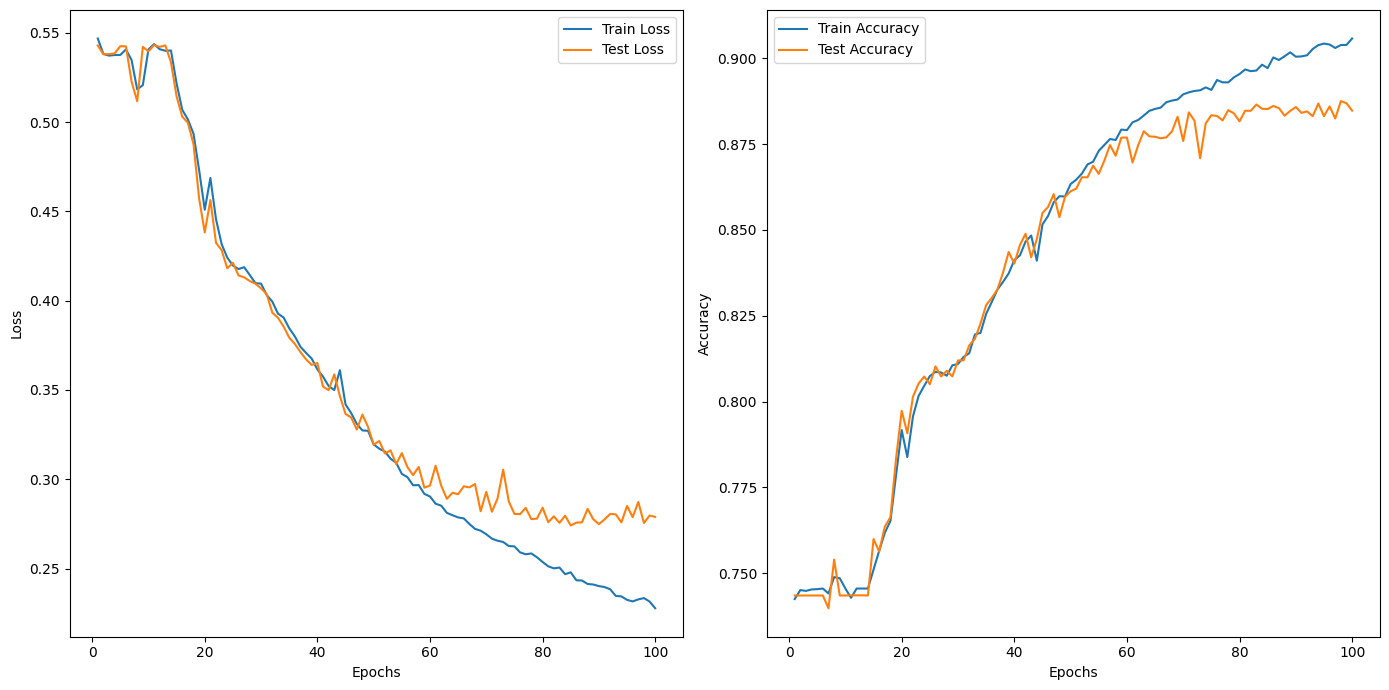

Starting final evaluation on test set...
Final Test Accuracy: 0.6186
Classification Report:
              precision    recall  f1-score   support

          CD       0.77      0.73      0.75      1019
         HYP       0.65      0.59      0.62       519
          MI       0.80      0.67      0.73      1102
        NORM       0.86      0.86      0.86      1906
        STTC       0.74      0.74      0.74      1055

   micro avg       0.79      0.75      0.77      5601
   macro avg       0.76      0.72      0.74      5601
weighted avg       0.79      0.75      0.77      5601
 samples avg       0.77      0.76      0.75      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in samples with no true nor predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


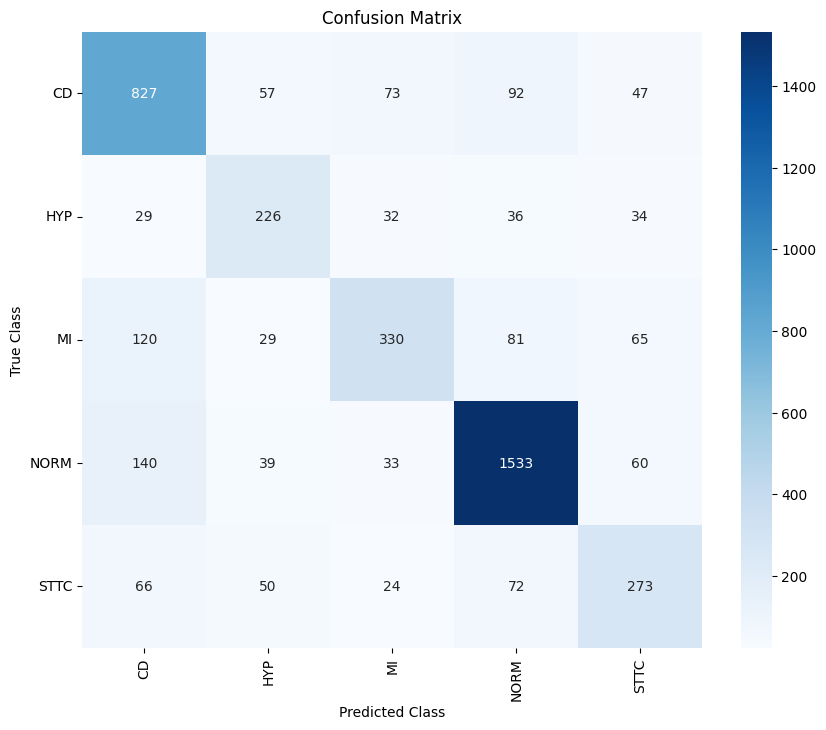

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the LSTM model with an additional layer
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4):  # Increased num_layers to 4
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True, dropout=0.204)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes
print(f"Training set size: {X_train.shape[0]} samples")
print(f"Test set size: {X_test.shape[0]} samples")
print(f"Train input shape: {X_train.shape}")
print(f"Test input shape: {X_test.shape}")

# Calculate and print standard deviation
train_std = np.std(X_train)
test_std = np.std(X_test)
print(f"Train data standard deviation: {train_std:.4f}")
print(f"Test data standard deviation: {test_std:.4f}")

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the LSTM model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 56  # Updated hidden_size from Optuna trial
output_dim = y_train.shape[1]  # Number of output classes

model = LSTMModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0012407824224366852)  # Updated learning rate

# Print model summary and input shape size
print(f"Model Summary:\n{model}")
print(f"Input Shape: {input_dim} leads, {n_timesteps} timesteps")

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/lstm_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


#GRU activation

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:39<00:00, 219.32it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Exact training set size: (17469, 500, 12)
Exact test set size: (4368, 500, 12)
Train data standard deviation (exact): 0.23364261164281808
Test data standard deviation (exact): 0.2317493984831071

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 500, 128], [-1, 2, 128]]               0
            Linear-2                    [-1, 5]             645
Total params: 645
Trainable params: 645
Non-trainable params: 0
----------------------

Training Epoch 1/100: 100%|██████████| 273/273 [00:04<00:00, 58.22it/s]


End of Epoch 1: Train Loss: 0.5217, Train Accuracy: 0.7541
End of Epoch 1: Test Loss: 0.4646, Test Accuracy: 0.7866

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:04<00:00, 58.40it/s]


End of Epoch 2: Train Loss: 0.4055, Train Accuracy: 0.8199
End of Epoch 2: Test Loss: 0.3646, Test Accuracy: 0.8404

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:04<00:00, 58.29it/s]


End of Epoch 3: Train Loss: 0.3335, Train Accuracy: 0.8583
End of Epoch 3: Test Loss: 0.3242, Test Accuracy: 0.8644

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:04<00:00, 57.91it/s]


End of Epoch 4: Train Loss: 0.3104, Train Accuracy: 0.8706
End of Epoch 4: Test Loss: 0.3009, Test Accuracy: 0.8748

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:04<00:00, 57.84it/s]


End of Epoch 5: Train Loss: 0.2939, Train Accuracy: 0.8779
End of Epoch 5: Test Loss: 0.2928, Test Accuracy: 0.8766

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:04<00:00, 57.68it/s]


End of Epoch 6: Train Loss: 0.2844, Train Accuracy: 0.8821
End of Epoch 6: Test Loss: 0.2913, Test Accuracy: 0.8779

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:04<00:00, 57.69it/s]


End of Epoch 7: Train Loss: 0.2745, Train Accuracy: 0.8866
End of Epoch 7: Test Loss: 0.2858, Test Accuracy: 0.8796

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:04<00:00, 58.26it/s]


End of Epoch 8: Train Loss: 0.2682, Train Accuracy: 0.8880
End of Epoch 8: Test Loss: 0.2785, Test Accuracy: 0.8821

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:04<00:00, 58.16it/s]


End of Epoch 9: Train Loss: 0.2604, Train Accuracy: 0.8927
End of Epoch 9: Test Loss: 0.2797, Test Accuracy: 0.8809

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:04<00:00, 58.21it/s]


End of Epoch 10: Train Loss: 0.2537, Train Accuracy: 0.8952
End of Epoch 10: Test Loss: 0.2842, Test Accuracy: 0.8795

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:04<00:00, 58.56it/s]


End of Epoch 11: Train Loss: 0.2491, Train Accuracy: 0.8976
End of Epoch 11: Test Loss: 0.2694, Test Accuracy: 0.8859

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:04<00:00, 58.34it/s]


End of Epoch 12: Train Loss: 0.2433, Train Accuracy: 0.8996
End of Epoch 12: Test Loss: 0.2674, Test Accuracy: 0.8887

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:04<00:00, 58.65it/s]


End of Epoch 13: Train Loss: 0.2369, Train Accuracy: 0.9024
End of Epoch 13: Test Loss: 0.2718, Test Accuracy: 0.8852

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:04<00:00, 58.46it/s]


End of Epoch 14: Train Loss: 0.2302, Train Accuracy: 0.9056
End of Epoch 14: Test Loss: 0.2696, Test Accuracy: 0.8860

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:04<00:00, 58.75it/s]


End of Epoch 15: Train Loss: 0.2251, Train Accuracy: 0.9079
End of Epoch 15: Test Loss: 0.2713, Test Accuracy: 0.8870

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:04<00:00, 58.74it/s]


End of Epoch 16: Train Loss: 0.2196, Train Accuracy: 0.9111
End of Epoch 16: Test Loss: 0.2732, Test Accuracy: 0.8864

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:04<00:00, 58.61it/s]


End of Epoch 17: Train Loss: 0.2133, Train Accuracy: 0.9130
End of Epoch 17: Test Loss: 0.2736, Test Accuracy: 0.8862

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:04<00:00, 58.67it/s]


End of Epoch 18: Train Loss: 0.2052, Train Accuracy: 0.9179
End of Epoch 18: Test Loss: 0.2738, Test Accuracy: 0.8882

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:04<00:00, 58.06it/s]


End of Epoch 19: Train Loss: 0.2000, Train Accuracy: 0.9194
End of Epoch 19: Test Loss: 0.2736, Test Accuracy: 0.8878

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:04<00:00, 58.42it/s]


End of Epoch 20: Train Loss: 0.1927, Train Accuracy: 0.9230
End of Epoch 20: Test Loss: 0.2868, Test Accuracy: 0.8871

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:04<00:00, 58.24it/s]


End of Epoch 21: Train Loss: 0.1847, Train Accuracy: 0.9257
End of Epoch 21: Test Loss: 0.2913, Test Accuracy: 0.8842

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:04<00:00, 58.04it/s]


End of Epoch 22: Train Loss: 0.1771, Train Accuracy: 0.9291
End of Epoch 22: Test Loss: 0.2963, Test Accuracy: 0.8859

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:04<00:00, 58.30it/s]


End of Epoch 23: Train Loss: 0.1730, Train Accuracy: 0.9312
End of Epoch 23: Test Loss: 0.3015, Test Accuracy: 0.8823

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:04<00:00, 57.90it/s]


End of Epoch 24: Train Loss: 0.1655, Train Accuracy: 0.9352
End of Epoch 24: Test Loss: 0.3009, Test Accuracy: 0.8832

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:04<00:00, 58.23it/s]


End of Epoch 25: Train Loss: 0.1565, Train Accuracy: 0.9393
End of Epoch 25: Test Loss: 0.3086, Test Accuracy: 0.8828

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:04<00:00, 58.06it/s]


End of Epoch 26: Train Loss: 0.1460, Train Accuracy: 0.9439
End of Epoch 26: Test Loss: 0.3230, Test Accuracy: 0.8847

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:04<00:00, 58.24it/s]


End of Epoch 27: Train Loss: 0.1403, Train Accuracy: 0.9456
End of Epoch 27: Test Loss: 0.3311, Test Accuracy: 0.8849

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:04<00:00, 58.20it/s]


End of Epoch 28: Train Loss: 0.1337, Train Accuracy: 0.9490
End of Epoch 28: Test Loss: 0.3357, Test Accuracy: 0.8815

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:04<00:00, 58.01it/s]


End of Epoch 29: Train Loss: 0.1281, Train Accuracy: 0.9507
End of Epoch 29: Test Loss: 0.3476, Test Accuracy: 0.8814

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:04<00:00, 58.22it/s]


End of Epoch 30: Train Loss: 0.1220, Train Accuracy: 0.9537
End of Epoch 30: Test Loss: 0.3585, Test Accuracy: 0.8811

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:04<00:00, 57.93it/s]


End of Epoch 31: Train Loss: 0.1117, Train Accuracy: 0.9585
End of Epoch 31: Test Loss: 0.3698, Test Accuracy: 0.8795

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:04<00:00, 58.17it/s]


End of Epoch 32: Train Loss: 0.1089, Train Accuracy: 0.9589
End of Epoch 32: Test Loss: 0.3795, Test Accuracy: 0.8776

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:04<00:00, 57.82it/s]


End of Epoch 33: Train Loss: 0.1043, Train Accuracy: 0.9610
End of Epoch 33: Test Loss: 0.3958, Test Accuracy: 0.8778

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:04<00:00, 57.97it/s]


End of Epoch 34: Train Loss: 0.1058, Train Accuracy: 0.9608
End of Epoch 34: Test Loss: 0.3959, Test Accuracy: 0.8761

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:04<00:00, 58.22it/s]


End of Epoch 35: Train Loss: 0.0994, Train Accuracy: 0.9636
End of Epoch 35: Test Loss: 0.3974, Test Accuracy: 0.8757

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:04<00:00, 58.10it/s]


End of Epoch 36: Train Loss: 0.0872, Train Accuracy: 0.9685
End of Epoch 36: Test Loss: 0.4219, Test Accuracy: 0.8767

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:04<00:00, 58.14it/s]


End of Epoch 37: Train Loss: 0.0829, Train Accuracy: 0.9703
End of Epoch 37: Test Loss: 0.4378, Test Accuracy: 0.8738

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:04<00:00, 58.01it/s]


End of Epoch 38: Train Loss: 0.0808, Train Accuracy: 0.9710
End of Epoch 38: Test Loss: 0.4459, Test Accuracy: 0.8773

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:04<00:00, 58.45it/s]


End of Epoch 39: Train Loss: 0.0736, Train Accuracy: 0.9741
End of Epoch 39: Test Loss: 0.4487, Test Accuracy: 0.8753

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:04<00:00, 57.93it/s]


End of Epoch 40: Train Loss: 0.0865, Train Accuracy: 0.9679
End of Epoch 40: Test Loss: 0.4487, Test Accuracy: 0.8756

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:04<00:00, 58.36it/s]


End of Epoch 41: Train Loss: 0.0705, Train Accuracy: 0.9751
End of Epoch 41: Test Loss: 0.4702, Test Accuracy: 0.8756

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:04<00:00, 58.38it/s]


End of Epoch 42: Train Loss: 0.0664, Train Accuracy: 0.9763
End of Epoch 42: Test Loss: 0.4663, Test Accuracy: 0.8739

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:04<00:00, 58.22it/s]


End of Epoch 43: Train Loss: 0.0649, Train Accuracy: 0.9772
End of Epoch 43: Test Loss: 0.4817, Test Accuracy: 0.8760

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:04<00:00, 58.39it/s]


End of Epoch 44: Train Loss: 0.0622, Train Accuracy: 0.9779
End of Epoch 44: Test Loss: 0.4935, Test Accuracy: 0.8772

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:04<00:00, 57.84it/s]


End of Epoch 45: Train Loss: 0.0586, Train Accuracy: 0.9798
End of Epoch 45: Test Loss: 0.5158, Test Accuracy: 0.8743

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:04<00:00, 58.09it/s]


End of Epoch 46: Train Loss: 0.0581, Train Accuracy: 0.9797
End of Epoch 46: Test Loss: 0.5171, Test Accuracy: 0.8738

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:04<00:00, 57.90it/s]


End of Epoch 47: Train Loss: 0.0633, Train Accuracy: 0.9778
End of Epoch 47: Test Loss: 0.5293, Test Accuracy: 0.8747

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:04<00:00, 58.09it/s]


End of Epoch 48: Train Loss: 0.0412, Train Accuracy: 0.9869
End of Epoch 48: Test Loss: 0.5498, Test Accuracy: 0.8704

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:04<00:00, 58.20it/s]


End of Epoch 49: Train Loss: 0.0441, Train Accuracy: 0.9855
End of Epoch 49: Test Loss: 0.5544, Test Accuracy: 0.8728

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:04<00:00, 57.97it/s]


End of Epoch 50: Train Loss: 0.0407, Train Accuracy: 0.9871
End of Epoch 50: Test Loss: 0.5792, Test Accuracy: 0.8725

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:04<00:00, 58.31it/s]


End of Epoch 51: Train Loss: 0.0541, Train Accuracy: 0.9808
End of Epoch 51: Test Loss: 0.5498, Test Accuracy: 0.8735

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:04<00:00, 58.03it/s]


End of Epoch 52: Train Loss: 0.0405, Train Accuracy: 0.9869
End of Epoch 52: Test Loss: 0.5812, Test Accuracy: 0.8730

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:04<00:00, 58.30it/s]


End of Epoch 53: Train Loss: 0.0424, Train Accuracy: 0.9860
End of Epoch 53: Test Loss: 0.5790, Test Accuracy: 0.8739

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:04<00:00, 58.34it/s]


End of Epoch 54: Train Loss: 0.0443, Train Accuracy: 0.9848
End of Epoch 54: Test Loss: 0.5669, Test Accuracy: 0.8682

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:04<00:00, 58.50it/s]


End of Epoch 55: Train Loss: 0.0430, Train Accuracy: 0.9847
End of Epoch 55: Test Loss: 0.5983, Test Accuracy: 0.8759

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:04<00:00, 58.24it/s]


End of Epoch 56: Train Loss: 0.0318, Train Accuracy: 0.9903
End of Epoch 56: Test Loss: 0.6024, Test Accuracy: 0.8758

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:04<00:00, 58.20it/s]


End of Epoch 57: Train Loss: 0.0322, Train Accuracy: 0.9899
End of Epoch 57: Test Loss: 0.6381, Test Accuracy: 0.8725

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:04<00:00, 58.41it/s]


End of Epoch 58: Train Loss: 0.0789, Train Accuracy: 0.9751
End of Epoch 58: Test Loss: 0.5620, Test Accuracy: 0.8673

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:04<00:00, 57.92it/s]


End of Epoch 59: Train Loss: 0.0999, Train Accuracy: 0.9623
End of Epoch 59: Test Loss: 0.5441, Test Accuracy: 0.8718

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:04<00:00, 58.46it/s]


End of Epoch 60: Train Loss: 0.0433, Train Accuracy: 0.9859
End of Epoch 60: Test Loss: 0.5837, Test Accuracy: 0.8743

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:04<00:00, 58.08it/s]


End of Epoch 61: Train Loss: 0.0264, Train Accuracy: 0.9929
End of Epoch 61: Test Loss: 0.6113, Test Accuracy: 0.8747

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:04<00:00, 58.19it/s]


End of Epoch 62: Train Loss: 0.0230, Train Accuracy: 0.9943
End of Epoch 62: Test Loss: 0.6252, Test Accuracy: 0.8751

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:04<00:00, 58.25it/s]


End of Epoch 63: Train Loss: 0.0232, Train Accuracy: 0.9938
End of Epoch 63: Test Loss: 0.6482, Test Accuracy: 0.8741

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:04<00:00, 57.72it/s]


End of Epoch 64: Train Loss: 0.0166, Train Accuracy: 0.9968
End of Epoch 64: Test Loss: 0.6696, Test Accuracy: 0.8738

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:04<00:00, 58.20it/s]


End of Epoch 65: Train Loss: 0.0169, Train Accuracy: 0.9960
End of Epoch 65: Test Loss: 0.6845, Test Accuracy: 0.8715

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:04<00:00, 57.89it/s]


End of Epoch 66: Train Loss: 0.0455, Train Accuracy: 0.9839
End of Epoch 66: Test Loss: 0.6504, Test Accuracy: 0.8675

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:04<00:00, 58.18it/s]


End of Epoch 67: Train Loss: 0.0440, Train Accuracy: 0.9843
End of Epoch 67: Test Loss: 0.6565, Test Accuracy: 0.8711

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:04<00:00, 58.12it/s]


End of Epoch 68: Train Loss: 0.0214, Train Accuracy: 0.9940
End of Epoch 68: Test Loss: 0.6753, Test Accuracy: 0.8751

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:04<00:00, 57.97it/s]


End of Epoch 69: Train Loss: 0.0143, Train Accuracy: 0.9968
End of Epoch 69: Test Loss: 0.6919, Test Accuracy: 0.8720

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:04<00:00, 58.44it/s]


End of Epoch 70: Train Loss: 0.0173, Train Accuracy: 0.9952
End of Epoch 70: Test Loss: 0.7119, Test Accuracy: 0.8723

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:04<00:00, 58.00it/s]


End of Epoch 71: Train Loss: 0.0152, Train Accuracy: 0.9961
End of Epoch 71: Test Loss: 0.7272, Test Accuracy: 0.8759

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:04<00:00, 58.20it/s]


End of Epoch 72: Train Loss: 0.0395, Train Accuracy: 0.9865
End of Epoch 72: Test Loss: 0.6926, Test Accuracy: 0.8723

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:04<00:00, 58.21it/s]


End of Epoch 73: Train Loss: 0.0518, Train Accuracy: 0.9811
End of Epoch 73: Test Loss: 0.6762, Test Accuracy: 0.8670

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:04<00:00, 58.26it/s]


End of Epoch 74: Train Loss: 0.0363, Train Accuracy: 0.9874
End of Epoch 74: Test Loss: 0.6795, Test Accuracy: 0.8748

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:04<00:00, 58.41it/s]


End of Epoch 75: Train Loss: 0.0159, Train Accuracy: 0.9959
End of Epoch 75: Test Loss: 0.7132, Test Accuracy: 0.8742

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:04<00:00, 58.43it/s]


End of Epoch 76: Train Loss: 0.0162, Train Accuracy: 0.9957
End of Epoch 76: Test Loss: 0.7576, Test Accuracy: 0.8751

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:04<00:00, 58.43it/s]


End of Epoch 77: Train Loss: 0.0425, Train Accuracy: 0.9850
End of Epoch 77: Test Loss: 0.7036, Test Accuracy: 0.8760

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:04<00:00, 58.14it/s]


End of Epoch 78: Train Loss: 0.0193, Train Accuracy: 0.9943
End of Epoch 78: Test Loss: 0.7295, Test Accuracy: 0.8739

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:04<00:00, 57.72it/s]


End of Epoch 79: Train Loss: 0.0109, Train Accuracy: 0.9975
End of Epoch 79: Test Loss: 0.7330, Test Accuracy: 0.8766

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:04<00:00, 57.88it/s]


End of Epoch 80: Train Loss: 0.0190, Train Accuracy: 0.9947
End of Epoch 80: Test Loss: 0.7401, Test Accuracy: 0.8724

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:04<00:00, 58.01it/s]


End of Epoch 81: Train Loss: 0.0285, Train Accuracy: 0.9906
End of Epoch 81: Test Loss: 0.7219, Test Accuracy: 0.8709

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:04<00:00, 57.99it/s]


End of Epoch 82: Train Loss: 0.0344, Train Accuracy: 0.9879
End of Epoch 82: Test Loss: 0.7390, Test Accuracy: 0.8714

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:04<00:00, 58.01it/s]


End of Epoch 83: Train Loss: 0.0195, Train Accuracy: 0.9937
End of Epoch 83: Test Loss: 0.7251, Test Accuracy: 0.8785

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:04<00:00, 58.24it/s]


End of Epoch 84: Train Loss: 0.0145, Train Accuracy: 0.9957
End of Epoch 84: Test Loss: 0.7568, Test Accuracy: 0.8750

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:04<00:00, 57.85it/s]


End of Epoch 85: Train Loss: 0.0164, Train Accuracy: 0.9949
End of Epoch 85: Test Loss: 0.7763, Test Accuracy: 0.8735

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:04<00:00, 58.26it/s]


End of Epoch 86: Train Loss: 0.0255, Train Accuracy: 0.9914
End of Epoch 86: Test Loss: 0.7540, Test Accuracy: 0.8751

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:04<00:00, 57.97it/s]


End of Epoch 87: Train Loss: 0.0339, Train Accuracy: 0.9880
End of Epoch 87: Test Loss: 0.7303, Test Accuracy: 0.8703

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:04<00:00, 58.36it/s]


End of Epoch 88: Train Loss: 0.0198, Train Accuracy: 0.9935
End of Epoch 88: Test Loss: 0.7549, Test Accuracy: 0.8734

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:04<00:00, 58.52it/s]


End of Epoch 89: Train Loss: 0.0173, Train Accuracy: 0.9947
End of Epoch 89: Test Loss: 0.7643, Test Accuracy: 0.8755

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:04<00:00, 58.06it/s]


End of Epoch 90: Train Loss: 0.0190, Train Accuracy: 0.9943
End of Epoch 90: Test Loss: 0.7366, Test Accuracy: 0.8708

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:04<00:00, 58.49it/s]


End of Epoch 91: Train Loss: 0.0213, Train Accuracy: 0.9931
End of Epoch 91: Test Loss: 0.7564, Test Accuracy: 0.8749

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:04<00:00, 58.01it/s]


End of Epoch 92: Train Loss: 0.0119, Train Accuracy: 0.9969
End of Epoch 92: Test Loss: 0.7844, Test Accuracy: 0.8788

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:04<00:00, 58.26it/s]


End of Epoch 93: Train Loss: 0.0077, Train Accuracy: 0.9984
End of Epoch 93: Test Loss: 0.8189, Test Accuracy: 0.8762

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:04<00:00, 58.13it/s]


End of Epoch 94: Train Loss: 0.0111, Train Accuracy: 0.9969
End of Epoch 94: Test Loss: 0.8361, Test Accuracy: 0.8745

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:04<00:00, 58.14it/s]


End of Epoch 95: Train Loss: 0.0368, Train Accuracy: 0.9872
End of Epoch 95: Test Loss: 0.7770, Test Accuracy: 0.8688

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:04<00:00, 58.32it/s]


End of Epoch 96: Train Loss: 0.0451, Train Accuracy: 0.9833
End of Epoch 96: Test Loss: 0.7535, Test Accuracy: 0.8753

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:04<00:00, 57.89it/s]


End of Epoch 97: Train Loss: 0.0157, Train Accuracy: 0.9949
End of Epoch 97: Test Loss: 0.7640, Test Accuracy: 0.8752

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:04<00:00, 58.14it/s]


End of Epoch 98: Train Loss: 0.0097, Train Accuracy: 0.9976
End of Epoch 98: Test Loss: 0.7957, Test Accuracy: 0.8768

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:04<00:00, 57.87it/s]


End of Epoch 99: Train Loss: 0.0138, Train Accuracy: 0.9966
End of Epoch 99: Test Loss: 0.7888, Test Accuracy: 0.8735

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:04<00:00, 58.11it/s]


End of Epoch 100: Train Loss: 0.0671, Train Accuracy: 0.9774
End of Epoch 100: Test Loss: 0.7246, Test Accuracy: 0.8760
Training complete. Plotting loss and accuracy curves...


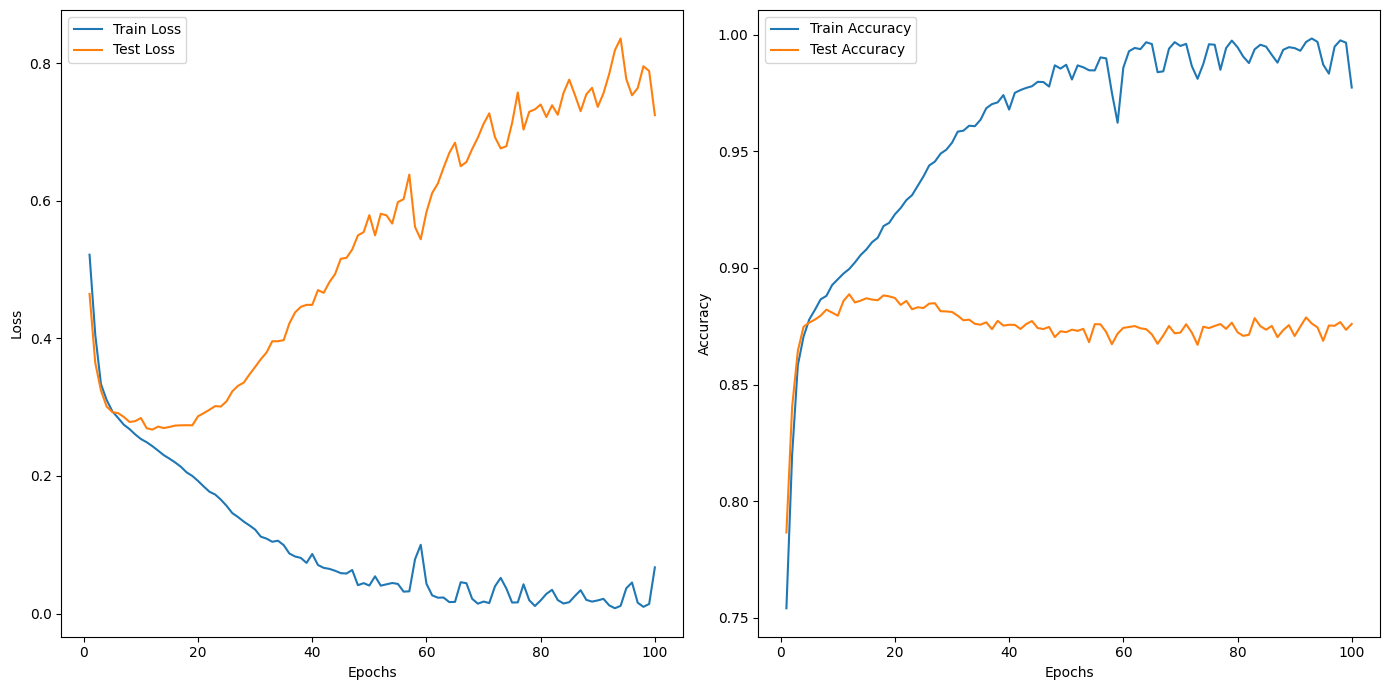

Starting final evaluation on test set...
Final Test Accuracy: 0.5978
Classification Report:
              precision    recall  f1-score   support

          CD       0.75      0.74      0.74      1019
         HYP       0.65      0.50      0.57       519
          MI       0.74      0.72      0.73      1102
        NORM       0.84      0.88      0.86      1906
        STTC       0.71      0.68      0.69      1055

   micro avg       0.76      0.75      0.76      5601
   macro avg       0.74      0.70      0.72      5601
weighted avg       0.76      0.75      0.75      5601
 samples avg       0.76      0.76      0.74      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


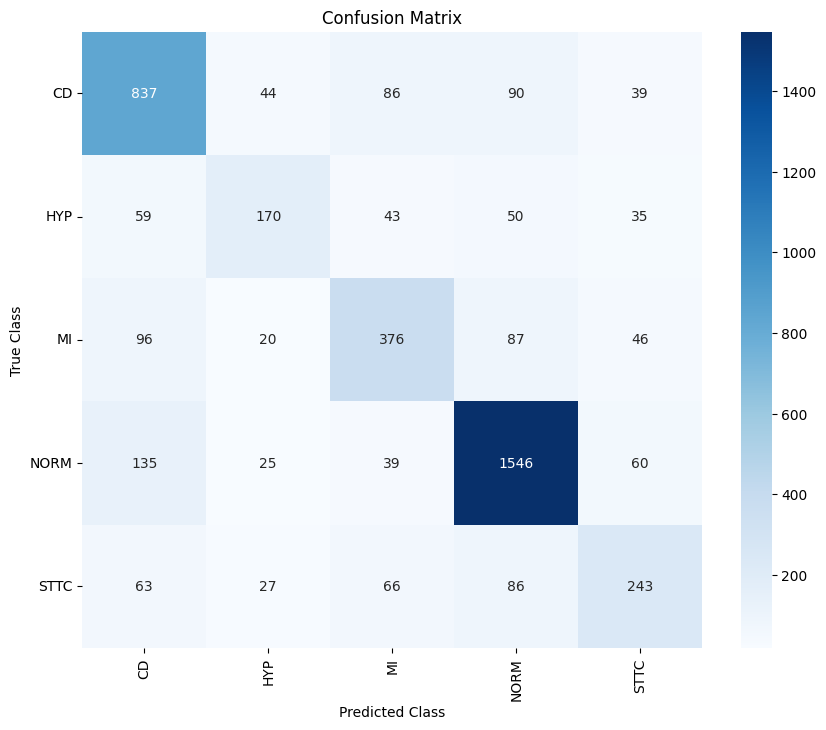

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/gru_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm
from torchsummary import summary  # For model summary

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.fc(gru_out[:, -1, :])
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes (Exact Values)
print("Exact training set size:", X_train.shape)
print("Exact test set size:", X_test.shape)

# Calculate and print exact standard deviations
train_std = np.std(X_train)
test_std = np.std(X_test)

# Print the exact standard deviations
print("Train data standard deviation (exact):", train_std)
print("Test data standard deviation (exact):", test_std)

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the GRU model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 128  # Hidden state size of the GRU
output_dim = y_train.shape[1]  # Number of output classes

model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Print the model summary
print("\nModel Architecture Summary:")
summary(model, input_size=(n_timesteps, input_dim))

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/gru_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


GRU Hypraparameter tunning

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from optuna.trial import TrialState
from tqdm import tqdm

# Custom Dataset Class
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# GRU-based Model definition
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_dim, dropout_rate):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True, dropout=dropout_rate)
        self.fc = nn.Linear(hidden_size, output_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        # Take only the output from the last time step
        gru_out = gru_out[:, -1, :]
        out = self.fc(self.dropout(gru_out))
        return out

# Function to create and train the GRU model
def train_model(trial, X_train, y_train, X_val, y_val, n_leads, output_dim):
    # Hyperparameters from Optuna
    hidden_size = trial.suggest_int("hidden_size", 32, 256)
    num_layers = trial.suggest_int("num_layers", 1, 3)
    dropout_rate = trial.suggest_float("dropout_rate", 0.2, 0.5)
    lr = trial.suggest_float("lr", 1e-5, 1e-2)

    # Initialize the GRU model
    model = GRUModel(input_size=n_leads, hidden_size=hidden_size, num_layers=num_layers, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # DataLoader
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Early stopping parameters
    patience = 10
    best_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss, val_accuracy


# Cross-validation function with Optuna
def cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5):
    skf = StratifiedKFold(n_splits=n_splits)
    study = optuna.create_study(direction="minimize")

    def objective(trial):
        val_losses = []
        val_accuracies = []
        for train_idx, val_idx in skf.split(X, y.argmax(axis=1)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            val_loss, val_accuracy = train_model(trial, X_train, y_train, X_val, y_val, n_leads=n_leads, output_dim=output_dim)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        average_accuracy = np.mean(val_accuracies)
        print(f"Average validation accuracy for this trial: {average_accuracy:.4f}")
        return np.mean(val_losses)

    study.optimize(objective, n_trials=20, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print(f"Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(pruned_trials)}")
    print(f"  Number of complete trials: {len(complete_trials)}")

    best_trial = study.best_trial
    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return best_trial


# Sample dataset preparation function (use real data in practice)
def prepare_sample_data():
    # Placeholder function: Replace this with actual dataset preparation code
    n_samples = 1000
    n_leads = 12
    n_timesteps = 500
    X = np.random.randn(n_samples, n_timesteps, n_leads)
    y = np.random.randint(0, 2, size=(n_samples, 5))
    return X, y


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script execution
if __name__ == "__main__":
    # Prepare sample data (replace with actual ECG dataset loading and preprocessing)
    X, y = prepare_sample_data()

    # Perform cross-validation and hyperparameter optimization using Optuna
    best_trial = cross_validate_and_optimize(X, y, n_splits=5, n_leads=12, output_dim=5)

    print("Finished cross-validation and optimization.")


[I 2024-08-28 16:35:46,495] A new study created in memory with name: no-name-2d90abcc-bdea-4b3d-a8d1-e8293df87ba1
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 12
Early stopping at epoch 11


[I 2024-08-28 16:35:53,556] Trial 0 finished with value: 0.7360361914634705 and parameters: {'hidden_size': 50, 'num_layers': 2, 'dropout_rate': 0.4976870809636611, 'lr': 0.00911048187942988}. Best is trial 0 with value: 0.7360361914634705.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4982


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 12
Early stopping at epoch 11


[I 2024-08-28 16:36:07,531] Trial 1 finished with value: 1.0320207300186157 and parameters: {'hidden_size': 116, 'num_layers': 2, 'dropout_rate': 0.3195335988827767, 'lr': 0.009116175211300603}. Best is trial 0 with value: 0.7360361914634705.


Early stopping at epoch 12
Average validation accuracy for this trial: 0.5040


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.4199541468995599 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 16:36:14,443] Trial 2 finished with value: 0.7375346336364746 and parameters: {'hidden_size': 100, 'num_layers': 1, 'dropout_rate': 0.4199541468995599, 'lr': 0.004854593825213025}. Best is trial 0 with value: 0.7360361914634705.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4960


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 13


[I 2024-08-28 16:37:05,567] Trial 3 finished with value: 1.243115845680237 and parameters: {'hidden_size': 250, 'num_layers': 2, 'dropout_rate': 0.31626735821076246, 'lr': 0.007785813388378857}. Best is trial 0 with value: 0.7360361914634705.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5064


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 12
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
[I 2024-08-28 16:37:11,918] Trial 4 finished with value: 0.7462834000587464 and parameters: {'hidden_size': 38, 'num_layers': 2, 'dropout_rate': 0.32990362824436925, 'lr': 0.0084426949990306}. Best is trial 0 with value: 0.7360361914634705.
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.234567678345313 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12
Average validation accuracy for this trial: 0.5054
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 13
Early stopping at epoch 12


[I 2024-08-28 16:38:08,223] Trial 5 finished with value: 0.6953571553230286 and parameters: {'hidden_size': 190, 'num_layers': 1, 'dropout_rate': 0.234567678345313, 'lr': 0.0005100999512380772}. Best is trial 5 with value: 0.6953571553230286.


Early stopping at epoch 12
Average validation accuracy for this trial: 0.5074


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.28001224213431386 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:38:08,678] Trial 6 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:38:09,484] Trial 7 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserW

Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12
Early stopping at epoch 11
Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 10 is already reported.
  warnings.warn(
[I 2024-08-28 16:39:03,324] Trial 10 finished with value: 0.6946660614013671 and parameters: {'hidden_size': 181, 'num_layers': 1, 'dropout_rate': 0.2043442604805581, 'lr': 0.0003952434743256836}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.5002


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20358281459965902 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 13
Early stopping at epoch 11


[I 2024-08-28 16:39:59,695] Trial 11 finished with value: 0.6948481006622315 and parameters: {'hidden_size': 187, 'num_layers': 1, 'dropout_rate': 0.20358281459965902, 'lr': 0.00035320514801648025}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.5110


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.20704093629449258 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(


Early stopping at epoch 13
Early stopping at epoch 11


[I 2024-08-28 16:40:52,466] Trial 12 finished with value: 0.6949486827850342 and parameters: {'hidden_size': 178, 'num_layers': 1, 'dropout_rate': 0.20704093629449258, 'lr': 0.0004462915813199999}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5086


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25921291594271106 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 16:41:14,185] Trial 13 finished with value: 0.7381535830497742 and parameters: {'hidden_size': 209, 'num_layers': 1, 'dropout_rate': 0.25921291594271106, 'lr': 0.002331924498900457}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4938


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.22262509924545693 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 11


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 16:41:35,142] Trial 14 finished with value: 0.7287817692756653 and parameters: {'hidden_size': 157, 'num_layers': 1, 'dropout_rate': 0.22262509924545693, 'lr': 0.002413776203809168}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.4900


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2809070707386011 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 11
Early stopping at epoch 11
Early stopping at epoch 11


[I 2024-08-28 16:41:41,949] Trial 15 finished with value: 0.7022148871421814 and parameters: {'hidden_size': 87, 'num_layers': 1, 'dropout_rate': 0.2809070707386011, 'lr': 0.0017626722979107265}. Best is trial 10 with value: 0.6946660614013671.


Early stopping at epoch 11
Average validation accuracy for this trial: 0.5004


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:41:42,703] Trial 16 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:83: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.25144243513761466 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
[I 2024-08-28 16:41:43,066] Trial 17 pruned. 
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: Use

Study statistics: 
  Number of finished trials: 20
  Number of pruned trials: 8
  Number of complete trials: 12
Best trial:
  Value: 0.6946660614013671
  Params: 
    hidden_size: 181
    num_layers: 1
    dropout_rate: 0.2043442604805581
    lr: 0.0003952434743256836
Finished cross-validation and optimization.


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:34<00:00, 229.91it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Exact training set size: (17469, 500, 12)
Exact test set size: (4368, 500, 12)
Train data standard deviation (exact): 0.23364261164281808
Test data standard deviation (exact): 0.2317493984831071

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 500, 128], [-1, 2, 128]]               0
           Dropout-2                  [-1, 128]               0
            Linear-3                    [-1, 5]             645
Total params: 645
Trai

Training Epoch 1/100: 100%|██████████| 273/273 [00:04<00:00, 57.61it/s]


End of Epoch 1: Train Loss: 0.5495, Train Accuracy: 0.7416
End of Epoch 1: Test Loss: 0.5418, Test Accuracy: 0.7433

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:04<00:00, 57.51it/s]


End of Epoch 2: Train Loss: 0.5241, Train Accuracy: 0.7505
End of Epoch 2: Test Loss: 0.4959, Test Accuracy: 0.7685

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:04<00:00, 56.72it/s]


End of Epoch 3: Train Loss: 0.4889, Train Accuracy: 0.7724
End of Epoch 3: Test Loss: 0.4728, Test Accuracy: 0.7840

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:04<00:00, 56.26it/s]


End of Epoch 4: Train Loss: 0.4467, Train Accuracy: 0.7985
End of Epoch 4: Test Loss: 0.4337, Test Accuracy: 0.8058

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:04<00:00, 55.88it/s]


End of Epoch 5: Train Loss: 0.3983, Train Accuracy: 0.8236
End of Epoch 5: Test Loss: 0.3766, Test Accuracy: 0.8353

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:04<00:00, 55.67it/s]


End of Epoch 6: Train Loss: 0.3701, Train Accuracy: 0.8385
End of Epoch 6: Test Loss: 0.3544, Test Accuracy: 0.8462

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:04<00:00, 56.45it/s]


End of Epoch 7: Train Loss: 0.3517, Train Accuracy: 0.8461
End of Epoch 7: Test Loss: 0.3424, Test Accuracy: 0.8525

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:04<00:00, 57.16it/s]


End of Epoch 8: Train Loss: 0.3393, Train Accuracy: 0.8533
End of Epoch 8: Test Loss: 0.3372, Test Accuracy: 0.8540

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:04<00:00, 57.59it/s]


End of Epoch 9: Train Loss: 0.3287, Train Accuracy: 0.8590
End of Epoch 9: Test Loss: 0.3315, Test Accuracy: 0.8609

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:04<00:00, 57.51it/s]


End of Epoch 10: Train Loss: 0.3194, Train Accuracy: 0.8654
End of Epoch 10: Test Loss: 0.3144, Test Accuracy: 0.8679

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:04<00:00, 57.41it/s]


End of Epoch 11: Train Loss: 0.3148, Train Accuracy: 0.8674
End of Epoch 11: Test Loss: 0.3141, Test Accuracy: 0.8661

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:04<00:00, 57.39it/s]


End of Epoch 12: Train Loss: 0.3056, Train Accuracy: 0.8723
End of Epoch 12: Test Loss: 0.3154, Test Accuracy: 0.8667

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:04<00:00, 57.26it/s]


End of Epoch 13: Train Loss: 0.3008, Train Accuracy: 0.8736
End of Epoch 13: Test Loss: 0.3015, Test Accuracy: 0.8737

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:04<00:00, 57.29it/s]


End of Epoch 14: Train Loss: 0.2959, Train Accuracy: 0.8769
End of Epoch 14: Test Loss: 0.2993, Test Accuracy: 0.8755

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:04<00:00, 57.31it/s]


End of Epoch 15: Train Loss: 0.2907, Train Accuracy: 0.8797
End of Epoch 15: Test Loss: 0.2980, Test Accuracy: 0.8752

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:04<00:00, 57.05it/s]


End of Epoch 16: Train Loss: 0.2865, Train Accuracy: 0.8824
End of Epoch 16: Test Loss: 0.2993, Test Accuracy: 0.8738

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:04<00:00, 57.07it/s]


End of Epoch 17: Train Loss: 0.2828, Train Accuracy: 0.8828
End of Epoch 17: Test Loss: 0.2934, Test Accuracy: 0.8781

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:04<00:00, 56.94it/s]


End of Epoch 18: Train Loss: 0.2802, Train Accuracy: 0.8855
End of Epoch 18: Test Loss: 0.2925, Test Accuracy: 0.8783

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:04<00:00, 57.06it/s]


End of Epoch 19: Train Loss: 0.2770, Train Accuracy: 0.8866
End of Epoch 19: Test Loss: 0.2881, Test Accuracy: 0.8798

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:04<00:00, 56.45it/s]


End of Epoch 20: Train Loss: 0.2740, Train Accuracy: 0.8880
End of Epoch 20: Test Loss: 0.2872, Test Accuracy: 0.8801

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:04<00:00, 56.91it/s]


End of Epoch 21: Train Loss: 0.2698, Train Accuracy: 0.8903
End of Epoch 21: Test Loss: 0.2852, Test Accuracy: 0.8794

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:04<00:00, 56.46it/s]


End of Epoch 22: Train Loss: 0.2684, Train Accuracy: 0.8906
End of Epoch 22: Test Loss: 0.2851, Test Accuracy: 0.8783

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:04<00:00, 56.94it/s]


End of Epoch 23: Train Loss: 0.2663, Train Accuracy: 0.8909
End of Epoch 23: Test Loss: 0.2835, Test Accuracy: 0.8819

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:04<00:00, 56.88it/s]


End of Epoch 24: Train Loss: 0.2630, Train Accuracy: 0.8933
End of Epoch 24: Test Loss: 0.2819, Test Accuracy: 0.8819

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:04<00:00, 57.28it/s]


End of Epoch 25: Train Loss: 0.2592, Train Accuracy: 0.8935
End of Epoch 25: Test Loss: 0.2788, Test Accuracy: 0.8848

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:04<00:00, 57.63it/s]


End of Epoch 26: Train Loss: 0.2568, Train Accuracy: 0.8955
End of Epoch 26: Test Loss: 0.2789, Test Accuracy: 0.8826

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:04<00:00, 57.40it/s]


End of Epoch 27: Train Loss: 0.2546, Train Accuracy: 0.8962
End of Epoch 27: Test Loss: 0.2748, Test Accuracy: 0.8856

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:04<00:00, 57.54it/s]


End of Epoch 28: Train Loss: 0.2538, Train Accuracy: 0.8964
End of Epoch 28: Test Loss: 0.2746, Test Accuracy: 0.8860

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:04<00:00, 57.07it/s]


End of Epoch 29: Train Loss: 0.2507, Train Accuracy: 0.8984
End of Epoch 29: Test Loss: 0.2818, Test Accuracy: 0.8842

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:04<00:00, 57.49it/s]


End of Epoch 30: Train Loss: 0.2495, Train Accuracy: 0.8979
End of Epoch 30: Test Loss: 0.2725, Test Accuracy: 0.8852

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:04<00:00, 57.24it/s]


End of Epoch 31: Train Loss: 0.2452, Train Accuracy: 0.9002
End of Epoch 31: Test Loss: 0.2742, Test Accuracy: 0.8866

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:04<00:00, 57.37it/s]


End of Epoch 32: Train Loss: 0.2431, Train Accuracy: 0.9016
End of Epoch 32: Test Loss: 0.2736, Test Accuracy: 0.8853

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:04<00:00, 57.44it/s]


End of Epoch 33: Train Loss: 0.2410, Train Accuracy: 0.9025
End of Epoch 33: Test Loss: 0.2737, Test Accuracy: 0.8870

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:04<00:00, 57.28it/s]


End of Epoch 34: Train Loss: 0.2392, Train Accuracy: 0.9025
End of Epoch 34: Test Loss: 0.2772, Test Accuracy: 0.8821

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:04<00:00, 57.50it/s]


End of Epoch 35: Train Loss: 0.2372, Train Accuracy: 0.9035
End of Epoch 35: Test Loss: 0.2775, Test Accuracy: 0.8840

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:04<00:00, 57.33it/s]


End of Epoch 36: Train Loss: 0.2351, Train Accuracy: 0.9038
End of Epoch 36: Test Loss: 0.2732, Test Accuracy: 0.8867

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:04<00:00, 57.53it/s]


End of Epoch 37: Train Loss: 0.2314, Train Accuracy: 0.9070
End of Epoch 37: Test Loss: 0.2820, Test Accuracy: 0.8825

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:04<00:00, 57.32it/s]


End of Epoch 38: Train Loss: 0.2297, Train Accuracy: 0.9062
End of Epoch 38: Test Loss: 0.2709, Test Accuracy: 0.8888

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:04<00:00, 57.51it/s]


End of Epoch 39: Train Loss: 0.2277, Train Accuracy: 0.9081
End of Epoch 39: Test Loss: 0.2804, Test Accuracy: 0.8841

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:04<00:00, 57.10it/s]


End of Epoch 40: Train Loss: 0.2260, Train Accuracy: 0.9089
End of Epoch 40: Test Loss: 0.2768, Test Accuracy: 0.8830

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:04<00:00, 57.34it/s]


End of Epoch 41: Train Loss: 0.2230, Train Accuracy: 0.9097
End of Epoch 41: Test Loss: 0.2733, Test Accuracy: 0.8878

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:04<00:00, 57.70it/s]


End of Epoch 42: Train Loss: 0.2207, Train Accuracy: 0.9110
End of Epoch 42: Test Loss: 0.2785, Test Accuracy: 0.8845

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:04<00:00, 57.05it/s]


End of Epoch 43: Train Loss: 0.2192, Train Accuracy: 0.9120
End of Epoch 43: Test Loss: 0.2759, Test Accuracy: 0.8860

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:04<00:00, 57.42it/s]


End of Epoch 44: Train Loss: 0.2157, Train Accuracy: 0.9132
End of Epoch 44: Test Loss: 0.2783, Test Accuracy: 0.8848

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:04<00:00, 57.09it/s]


End of Epoch 45: Train Loss: 0.2139, Train Accuracy: 0.9132
End of Epoch 45: Test Loss: 0.2805, Test Accuracy: 0.8853

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:04<00:00, 57.48it/s]


End of Epoch 46: Train Loss: 0.2120, Train Accuracy: 0.9150
End of Epoch 46: Test Loss: 0.2819, Test Accuracy: 0.8852

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:04<00:00, 57.36it/s]


End of Epoch 47: Train Loss: 0.2090, Train Accuracy: 0.9173
End of Epoch 47: Test Loss: 0.2872, Test Accuracy: 0.8847

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:04<00:00, 57.26it/s]


End of Epoch 48: Train Loss: 0.2091, Train Accuracy: 0.9163
End of Epoch 48: Test Loss: 0.2820, Test Accuracy: 0.8873

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:04<00:00, 57.30it/s]


End of Epoch 49: Train Loss: 0.2046, Train Accuracy: 0.9182
End of Epoch 49: Test Loss: 0.2822, Test Accuracy: 0.8854

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:04<00:00, 56.74it/s]


End of Epoch 50: Train Loss: 0.2018, Train Accuracy: 0.9195
End of Epoch 50: Test Loss: 0.2865, Test Accuracy: 0.8862

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:04<00:00, 57.27it/s]


End of Epoch 51: Train Loss: 0.2003, Train Accuracy: 0.9201
End of Epoch 51: Test Loss: 0.2849, Test Accuracy: 0.8873

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:04<00:00, 57.18it/s]


End of Epoch 52: Train Loss: 0.1992, Train Accuracy: 0.9211
End of Epoch 52: Test Loss: 0.2928, Test Accuracy: 0.8840

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:04<00:00, 57.16it/s]


End of Epoch 53: Train Loss: 0.1967, Train Accuracy: 0.9220
End of Epoch 53: Test Loss: 0.2853, Test Accuracy: 0.8859

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:04<00:00, 56.99it/s]


End of Epoch 54: Train Loss: 0.1939, Train Accuracy: 0.9231
End of Epoch 54: Test Loss: 0.2917, Test Accuracy: 0.8847

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:04<00:00, 57.02it/s]


End of Epoch 55: Train Loss: 0.1907, Train Accuracy: 0.9249
End of Epoch 55: Test Loss: 0.2942, Test Accuracy: 0.8831

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:04<00:00, 57.32it/s]


End of Epoch 56: Train Loss: 0.1900, Train Accuracy: 0.9259
End of Epoch 56: Test Loss: 0.2930, Test Accuracy: 0.8835

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:04<00:00, 56.87it/s]


End of Epoch 57: Train Loss: 0.1857, Train Accuracy: 0.9265
End of Epoch 57: Test Loss: 0.2958, Test Accuracy: 0.8827

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:04<00:00, 57.03it/s]


End of Epoch 58: Train Loss: 0.1845, Train Accuracy: 0.9271
End of Epoch 58: Test Loss: 0.3058, Test Accuracy: 0.8830

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:04<00:00, 57.01it/s]


End of Epoch 59: Train Loss: 0.1818, Train Accuracy: 0.9288
End of Epoch 59: Test Loss: 0.3029, Test Accuracy: 0.8802

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:04<00:00, 57.27it/s]


End of Epoch 60: Train Loss: 0.1821, Train Accuracy: 0.9291
End of Epoch 60: Test Loss: 0.2976, Test Accuracy: 0.8864

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:04<00:00, 56.85it/s]


End of Epoch 61: Train Loss: 0.1773, Train Accuracy: 0.9300
End of Epoch 61: Test Loss: 0.3094, Test Accuracy: 0.8841

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:04<00:00, 57.21it/s]


End of Epoch 62: Train Loss: 0.1779, Train Accuracy: 0.9297
End of Epoch 62: Test Loss: 0.3024, Test Accuracy: 0.8836

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:04<00:00, 57.14it/s]


End of Epoch 63: Train Loss: 0.1736, Train Accuracy: 0.9322
End of Epoch 63: Test Loss: 0.3000, Test Accuracy: 0.8832

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:04<00:00, 57.20it/s]


End of Epoch 64: Train Loss: 0.1706, Train Accuracy: 0.9333
End of Epoch 64: Test Loss: 0.3047, Test Accuracy: 0.8843

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:04<00:00, 57.07it/s]


End of Epoch 65: Train Loss: 0.1707, Train Accuracy: 0.9342
End of Epoch 65: Test Loss: 0.3111, Test Accuracy: 0.8818

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:04<00:00, 56.92it/s]


End of Epoch 66: Train Loss: 0.1672, Train Accuracy: 0.9347
End of Epoch 66: Test Loss: 0.3126, Test Accuracy: 0.8802

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:04<00:00, 57.38it/s]


End of Epoch 67: Train Loss: 0.1643, Train Accuracy: 0.9371
End of Epoch 67: Test Loss: 0.3189, Test Accuracy: 0.8807

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:04<00:00, 57.21it/s]


End of Epoch 68: Train Loss: 0.1621, Train Accuracy: 0.9378
End of Epoch 68: Test Loss: 0.3232, Test Accuracy: 0.8825

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:04<00:00, 57.36it/s]


End of Epoch 69: Train Loss: 0.1629, Train Accuracy: 0.9371
End of Epoch 69: Test Loss: 0.3264, Test Accuracy: 0.8783

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:04<00:00, 57.26it/s]


End of Epoch 70: Train Loss: 0.1589, Train Accuracy: 0.9386
End of Epoch 70: Test Loss: 0.3209, Test Accuracy: 0.8818

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:04<00:00, 57.38it/s]


End of Epoch 71: Train Loss: 0.1549, Train Accuracy: 0.9411
End of Epoch 71: Test Loss: 0.3219, Test Accuracy: 0.8820

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:04<00:00, 57.57it/s]


End of Epoch 72: Train Loss: 0.1556, Train Accuracy: 0.9409
End of Epoch 72: Test Loss: 0.3254, Test Accuracy: 0.8816

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:04<00:00, 57.32it/s]


End of Epoch 73: Train Loss: 0.1516, Train Accuracy: 0.9412
End of Epoch 73: Test Loss: 0.3419, Test Accuracy: 0.8792

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:04<00:00, 57.38it/s]


End of Epoch 74: Train Loss: 0.1519, Train Accuracy: 0.9420
End of Epoch 74: Test Loss: 0.3364, Test Accuracy: 0.8787

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:04<00:00, 57.29it/s]


End of Epoch 75: Train Loss: 0.1487, Train Accuracy: 0.9432
End of Epoch 75: Test Loss: 0.3448, Test Accuracy: 0.8811

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:04<00:00, 57.35it/s]


End of Epoch 76: Train Loss: 0.1471, Train Accuracy: 0.9442
End of Epoch 76: Test Loss: 0.3372, Test Accuracy: 0.8799

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:04<00:00, 57.12it/s]


End of Epoch 77: Train Loss: 0.1458, Train Accuracy: 0.9444
End of Epoch 77: Test Loss: 0.3400, Test Accuracy: 0.8805

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:04<00:00, 57.31it/s]


End of Epoch 78: Train Loss: 0.1462, Train Accuracy: 0.9437
End of Epoch 78: Test Loss: 0.3407, Test Accuracy: 0.8795

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:04<00:00, 57.33it/s]


End of Epoch 79: Train Loss: 0.1425, Train Accuracy: 0.9463
End of Epoch 79: Test Loss: 0.3558, Test Accuracy: 0.8772

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:04<00:00, 56.97it/s]


End of Epoch 80: Train Loss: 0.1489, Train Accuracy: 0.9429
End of Epoch 80: Test Loss: 0.3499, Test Accuracy: 0.8782

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:04<00:00, 57.39it/s]


End of Epoch 81: Train Loss: 0.1374, Train Accuracy: 0.9478
End of Epoch 81: Test Loss: 0.3472, Test Accuracy: 0.8799

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:04<00:00, 57.28it/s]


End of Epoch 82: Train Loss: 0.1344, Train Accuracy: 0.9497
End of Epoch 82: Test Loss: 0.3616, Test Accuracy: 0.8809

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:04<00:00, 57.46it/s]


End of Epoch 83: Train Loss: 0.1349, Train Accuracy: 0.9493
End of Epoch 83: Test Loss: 0.3565, Test Accuracy: 0.8783

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:04<00:00, 57.06it/s]


End of Epoch 84: Train Loss: 0.1307, Train Accuracy: 0.9512
End of Epoch 84: Test Loss: 0.3586, Test Accuracy: 0.8774

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:04<00:00, 57.28it/s]


End of Epoch 85: Train Loss: 0.1313, Train Accuracy: 0.9510
End of Epoch 85: Test Loss: 0.3744, Test Accuracy: 0.8793

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:04<00:00, 57.24it/s]


End of Epoch 86: Train Loss: 0.1313, Train Accuracy: 0.9504
End of Epoch 86: Test Loss: 0.3647, Test Accuracy: 0.8749

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:04<00:00, 57.05it/s]


End of Epoch 87: Train Loss: 0.1296, Train Accuracy: 0.9515
End of Epoch 87: Test Loss: 0.3746, Test Accuracy: 0.8787

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:04<00:00, 57.40it/s]


End of Epoch 88: Train Loss: 0.1287, Train Accuracy: 0.9515
End of Epoch 88: Test Loss: 0.3742, Test Accuracy: 0.8799

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:04<00:00, 57.11it/s]


End of Epoch 89: Train Loss: 0.1233, Train Accuracy: 0.9539
End of Epoch 89: Test Loss: 0.3748, Test Accuracy: 0.8783

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:04<00:00, 57.18it/s]


End of Epoch 90: Train Loss: 0.1258, Train Accuracy: 0.9524
End of Epoch 90: Test Loss: 0.3731, Test Accuracy: 0.8775

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:04<00:00, 57.07it/s]


End of Epoch 91: Train Loss: 0.1225, Train Accuracy: 0.9542
End of Epoch 91: Test Loss: 0.3783, Test Accuracy: 0.8775

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:04<00:00, 56.62it/s]


End of Epoch 92: Train Loss: 0.1180, Train Accuracy: 0.9559
End of Epoch 92: Test Loss: 0.3888, Test Accuracy: 0.8774

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:04<00:00, 56.45it/s]


End of Epoch 93: Train Loss: 0.1169, Train Accuracy: 0.9568
End of Epoch 93: Test Loss: 0.3840, Test Accuracy: 0.8793

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:04<00:00, 56.27it/s]


End of Epoch 94: Train Loss: 0.1169, Train Accuracy: 0.9568
End of Epoch 94: Test Loss: 0.3959, Test Accuracy: 0.8776

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:04<00:00, 56.35it/s]


End of Epoch 95: Train Loss: 0.1162, Train Accuracy: 0.9566
End of Epoch 95: Test Loss: 0.3853, Test Accuracy: 0.8772

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:04<00:00, 56.41it/s]


End of Epoch 96: Train Loss: 0.1186, Train Accuracy: 0.9558
End of Epoch 96: Test Loss: 0.3920, Test Accuracy: 0.8782

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:04<00:00, 56.73it/s]


End of Epoch 97: Train Loss: 0.1159, Train Accuracy: 0.9566
End of Epoch 97: Test Loss: 0.3929, Test Accuracy: 0.8779

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:04<00:00, 56.43it/s]


End of Epoch 98: Train Loss: 0.1159, Train Accuracy: 0.9570
End of Epoch 98: Test Loss: 0.3941, Test Accuracy: 0.8739

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:04<00:00, 56.72it/s]


End of Epoch 99: Train Loss: 0.1141, Train Accuracy: 0.9575
End of Epoch 99: Test Loss: 0.3929, Test Accuracy: 0.8776

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:04<00:00, 56.39it/s]


End of Epoch 100: Train Loss: 0.1097, Train Accuracy: 0.9596
End of Epoch 100: Test Loss: 0.4087, Test Accuracy: 0.8728
Training complete. Plotting loss and accuracy curves...


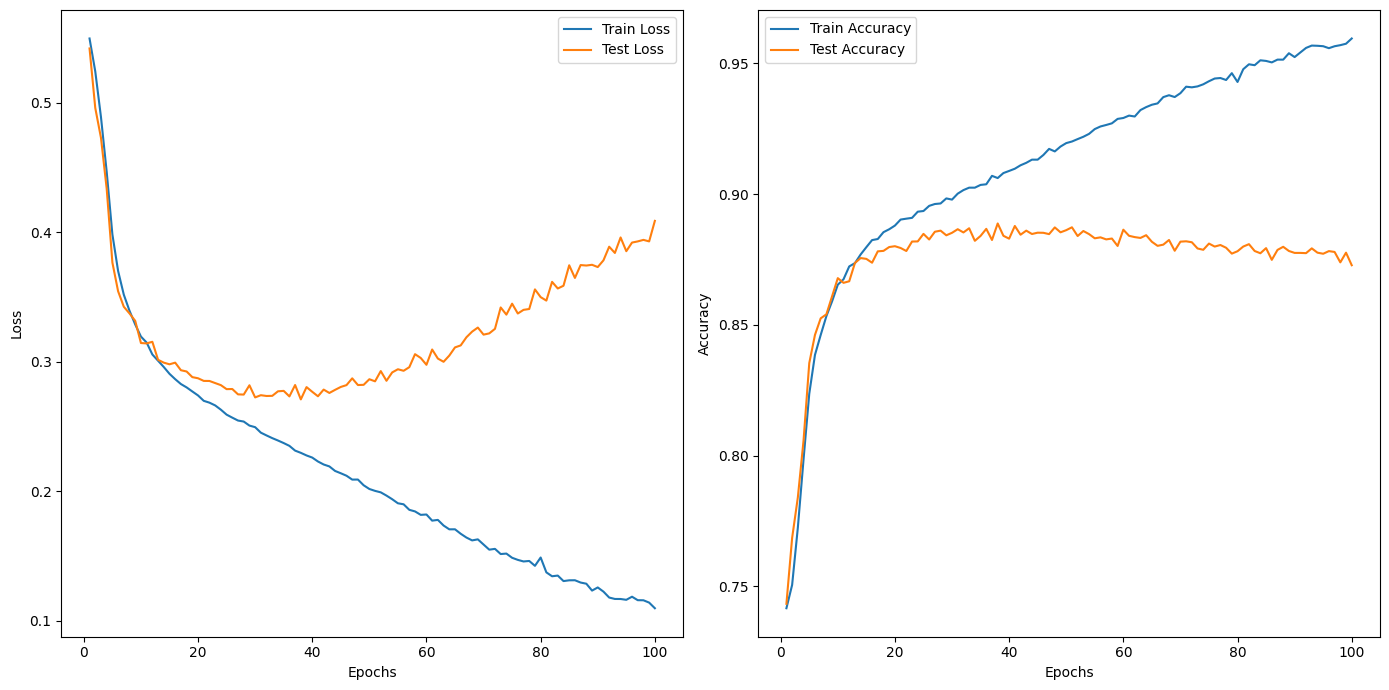

Starting final evaluation on test set...
Final Test Accuracy: 0.5932
Classification Report:
              precision    recall  f1-score   support

          CD       0.71      0.78      0.75      1019
         HYP       0.60      0.54      0.57       519
          MI       0.72      0.73      0.72      1102
        NORM       0.86      0.82      0.84      1906
        STTC       0.72      0.69      0.71      1055

   micro avg       0.75      0.75      0.75      5601
   macro avg       0.72      0.71      0.72      5601
weighted avg       0.76      0.75      0.75      5601
 samples avg       0.75      0.75      0.74      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


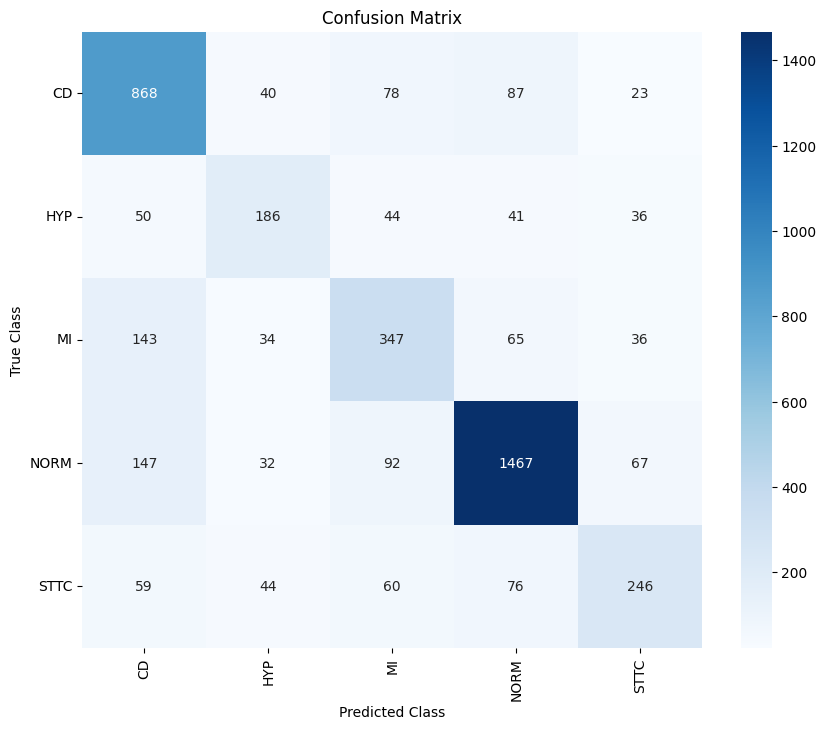

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/gru_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm
from torchsummary import summary  # For model summary

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the GRU model
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=2, dropout_rate=0.2043442604805581):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Add Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Apply Dropout after the GRU layer
        out = self.fc(out)
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes (Exact Values)
print("Exact training set size:", X_train.shape)
print("Exact test set size:", X_test.shape)

# Calculate and print exact standard deviations
train_std = np.std(X_train)
test_std = np.std(X_test)

# Print the exact standard deviations
print("Train data standard deviation (exact):", train_std)
print("Test data standard deviation (exact):", test_std)

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the GRU model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 128  # Hidden state size of the GRU
output_dim = y_train.shape[1]  # Number of output classes

# Apply the dropout rate and learning rate modifications
dropout_rate = 0.2043442604805581
learning_rate = 0.0003952434743256836

model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the model summary
print("\nModel Architecture Summary:")
summary(model, input_size=(n_timesteps, input_dim))

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/gru_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


Increse one layer of GRU

Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:26<00:00, 251.72it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Exact training set size: (17469, 500, 12)
Exact test set size: (4368, 500, 12)
Train data standard deviation (exact): 0.23364261164281808
Test data standard deviation (exact): 0.2317493984831071

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 500, 128], [-1, 2, 128]]               0
           Dropout-2                  [-1, 128]               0
            Linear-3                    [-1, 5]             645
Total params: 645
Trai

Training Epoch 1/100: 100%|██████████| 273/273 [00:06<00:00, 39.66it/s]


End of Epoch 1: Train Loss: 0.5478, Train Accuracy: 0.7449
End of Epoch 1: Test Loss: 0.5402, Test Accuracy: 0.7426

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:07<00:00, 38.23it/s]


End of Epoch 2: Train Loss: 0.5065, Train Accuracy: 0.7573
End of Epoch 2: Test Loss: 0.4766, Test Accuracy: 0.7775

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:07<00:00, 37.71it/s]


End of Epoch 3: Train Loss: 0.4584, Train Accuracy: 0.7878
End of Epoch 3: Test Loss: 0.4301, Test Accuracy: 0.8015

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:07<00:00, 37.96it/s]


End of Epoch 4: Train Loss: 0.4000, Train Accuracy: 0.8193
End of Epoch 4: Test Loss: 0.3808, Test Accuracy: 0.8326

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:07<00:00, 38.34it/s]


End of Epoch 5: Train Loss: 0.3645, Train Accuracy: 0.8403
End of Epoch 5: Test Loss: 0.3509, Test Accuracy: 0.8494

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:07<00:00, 38.53it/s]


End of Epoch 6: Train Loss: 0.3461, Train Accuracy: 0.8513
End of Epoch 6: Test Loss: 0.3371, Test Accuracy: 0.8535

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:07<00:00, 38.94it/s]


End of Epoch 7: Train Loss: 0.3311, Train Accuracy: 0.8589
End of Epoch 7: Test Loss: 0.3244, Test Accuracy: 0.8628

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:07<00:00, 38.83it/s]


End of Epoch 8: Train Loss: 0.3181, Train Accuracy: 0.8658
End of Epoch 8: Test Loss: 0.3140, Test Accuracy: 0.8665

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:07<00:00, 38.84it/s]


End of Epoch 9: Train Loss: 0.3085, Train Accuracy: 0.8693
End of Epoch 9: Test Loss: 0.3084, Test Accuracy: 0.8678

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:07<00:00, 38.92it/s]


End of Epoch 10: Train Loss: 0.3022, Train Accuracy: 0.8728
End of Epoch 10: Test Loss: 0.3041, Test Accuracy: 0.8719

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:07<00:00, 38.45it/s]


End of Epoch 11: Train Loss: 0.2965, Train Accuracy: 0.8755
End of Epoch 11: Test Loss: 0.3029, Test Accuracy: 0.8730

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:07<00:00, 38.20it/s]


End of Epoch 12: Train Loss: 0.2921, Train Accuracy: 0.8781
End of Epoch 12: Test Loss: 0.2950, Test Accuracy: 0.8750

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:07<00:00, 38.51it/s]


End of Epoch 13: Train Loss: 0.2867, Train Accuracy: 0.8801
End of Epoch 13: Test Loss: 0.2888, Test Accuracy: 0.8771

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:07<00:00, 38.35it/s]


End of Epoch 14: Train Loss: 0.2814, Train Accuracy: 0.8831
End of Epoch 14: Test Loss: 0.2863, Test Accuracy: 0.8784

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:07<00:00, 38.38it/s]


End of Epoch 15: Train Loss: 0.2789, Train Accuracy: 0.8841
End of Epoch 15: Test Loss: 0.2846, Test Accuracy: 0.8810

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 16: Train Loss: 0.2755, Train Accuracy: 0.8859
End of Epoch 16: Test Loss: 0.2819, Test Accuracy: 0.8811

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:07<00:00, 38.48it/s]


End of Epoch 17: Train Loss: 0.2738, Train Accuracy: 0.8866
End of Epoch 17: Test Loss: 0.2817, Test Accuracy: 0.8829

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:07<00:00, 38.61it/s]


End of Epoch 18: Train Loss: 0.2700, Train Accuracy: 0.8875
End of Epoch 18: Test Loss: 0.2822, Test Accuracy: 0.8824

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:07<00:00, 38.57it/s]


End of Epoch 19: Train Loss: 0.2667, Train Accuracy: 0.8886
End of Epoch 19: Test Loss: 0.2766, Test Accuracy: 0.8838

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:07<00:00, 38.51it/s]


End of Epoch 20: Train Loss: 0.2650, Train Accuracy: 0.8898
End of Epoch 20: Test Loss: 0.2798, Test Accuracy: 0.8827

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:07<00:00, 38.74it/s]


End of Epoch 21: Train Loss: 0.2613, Train Accuracy: 0.8913
End of Epoch 21: Test Loss: 0.2742, Test Accuracy: 0.8857

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:07<00:00, 38.69it/s]


End of Epoch 22: Train Loss: 0.2584, Train Accuracy: 0.8928
End of Epoch 22: Test Loss: 0.2742, Test Accuracy: 0.8864

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 23: Train Loss: 0.2571, Train Accuracy: 0.8942
End of Epoch 23: Test Loss: 0.2758, Test Accuracy: 0.8850

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:07<00:00, 38.91it/s]


End of Epoch 24: Train Loss: 0.2537, Train Accuracy: 0.8946
End of Epoch 24: Test Loss: 0.2768, Test Accuracy: 0.8838

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:07<00:00, 38.61it/s]


End of Epoch 25: Train Loss: 0.2516, Train Accuracy: 0.8963
End of Epoch 25: Test Loss: 0.2738, Test Accuracy: 0.8855

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:07<00:00, 38.68it/s]


End of Epoch 26: Train Loss: 0.2482, Train Accuracy: 0.8981
End of Epoch 26: Test Loss: 0.2749, Test Accuracy: 0.8837

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:07<00:00, 38.76it/s]


End of Epoch 27: Train Loss: 0.2468, Train Accuracy: 0.8975
End of Epoch 27: Test Loss: 0.2728, Test Accuracy: 0.8855

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:07<00:00, 38.63it/s]


End of Epoch 28: Train Loss: 0.2439, Train Accuracy: 0.8998
End of Epoch 28: Test Loss: 0.2766, Test Accuracy: 0.8841

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:07<00:00, 38.65it/s]


End of Epoch 29: Train Loss: 0.2409, Train Accuracy: 0.9011
End of Epoch 29: Test Loss: 0.2807, Test Accuracy: 0.8850

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:07<00:00, 38.67it/s]


End of Epoch 30: Train Loss: 0.2384, Train Accuracy: 0.9020
End of Epoch 30: Test Loss: 0.2736, Test Accuracy: 0.8843

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:07<00:00, 38.52it/s]


End of Epoch 31: Train Loss: 0.2356, Train Accuracy: 0.9035
End of Epoch 31: Test Loss: 0.2737, Test Accuracy: 0.8843

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:07<00:00, 38.70it/s]


End of Epoch 32: Train Loss: 0.2346, Train Accuracy: 0.9038
End of Epoch 32: Test Loss: 0.2731, Test Accuracy: 0.8865

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:07<00:00, 38.67it/s]


End of Epoch 33: Train Loss: 0.2304, Train Accuracy: 0.9056
End of Epoch 33: Test Loss: 0.2740, Test Accuracy: 0.8858

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:07<00:00, 38.46it/s]


End of Epoch 34: Train Loss: 0.2273, Train Accuracy: 0.9082
End of Epoch 34: Test Loss: 0.2750, Test Accuracy: 0.8847

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:07<00:00, 38.70it/s]


End of Epoch 35: Train Loss: 0.2258, Train Accuracy: 0.9082
End of Epoch 35: Test Loss: 0.2740, Test Accuracy: 0.8889

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:07<00:00, 38.57it/s]


End of Epoch 36: Train Loss: 0.2229, Train Accuracy: 0.9099
End of Epoch 36: Test Loss: 0.2757, Test Accuracy: 0.8863

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 37: Train Loss: 0.2194, Train Accuracy: 0.9108
End of Epoch 37: Test Loss: 0.2782, Test Accuracy: 0.8834

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:07<00:00, 38.69it/s]


End of Epoch 38: Train Loss: 0.2169, Train Accuracy: 0.9120
End of Epoch 38: Test Loss: 0.2753, Test Accuracy: 0.8852

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 39: Train Loss: 0.2137, Train Accuracy: 0.9141
End of Epoch 39: Test Loss: 0.2752, Test Accuracy: 0.8872

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:07<00:00, 38.51it/s]


End of Epoch 40: Train Loss: 0.2116, Train Accuracy: 0.9137
End of Epoch 40: Test Loss: 0.2787, Test Accuracy: 0.8860

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:07<00:00, 38.63it/s]


End of Epoch 41: Train Loss: 0.2084, Train Accuracy: 0.9157
End of Epoch 41: Test Loss: 0.2809, Test Accuracy: 0.8870

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 42: Train Loss: 0.2046, Train Accuracy: 0.9164
End of Epoch 42: Test Loss: 0.2812, Test Accuracy: 0.8857

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:07<00:00, 38.58it/s]


End of Epoch 43: Train Loss: 0.2026, Train Accuracy: 0.9190
End of Epoch 43: Test Loss: 0.2805, Test Accuracy: 0.8869

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:07<00:00, 38.56it/s]


End of Epoch 44: Train Loss: 0.2004, Train Accuracy: 0.9194
End of Epoch 44: Test Loss: 0.2831, Test Accuracy: 0.8869

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:07<00:00, 38.42it/s]


End of Epoch 45: Train Loss: 0.1963, Train Accuracy: 0.9215
End of Epoch 45: Test Loss: 0.2821, Test Accuracy: 0.8847

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:07<00:00, 38.63it/s]


End of Epoch 46: Train Loss: 0.1945, Train Accuracy: 0.9216
End of Epoch 46: Test Loss: 0.2839, Test Accuracy: 0.8868

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:07<00:00, 38.66it/s]


End of Epoch 47: Train Loss: 0.1904, Train Accuracy: 0.9239
End of Epoch 47: Test Loss: 0.2874, Test Accuracy: 0.8862

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:07<00:00, 38.48it/s]


End of Epoch 48: Train Loss: 0.1876, Train Accuracy: 0.9252
End of Epoch 48: Test Loss: 0.2968, Test Accuracy: 0.8853

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:07<00:00, 38.59it/s]


End of Epoch 49: Train Loss: 0.1842, Train Accuracy: 0.9265
End of Epoch 49: Test Loss: 0.2993, Test Accuracy: 0.8837

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 50: Train Loss: 0.1798, Train Accuracy: 0.9292
End of Epoch 50: Test Loss: 0.2964, Test Accuracy: 0.8854

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:07<00:00, 38.45it/s]


End of Epoch 51: Train Loss: 0.1778, Train Accuracy: 0.9297
End of Epoch 51: Test Loss: 0.3022, Test Accuracy: 0.8842

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:07<00:00, 38.66it/s]


End of Epoch 52: Train Loss: 0.1742, Train Accuracy: 0.9310
End of Epoch 52: Test Loss: 0.3027, Test Accuracy: 0.8833

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:07<00:00, 38.53it/s]


End of Epoch 53: Train Loss: 0.1719, Train Accuracy: 0.9322
End of Epoch 53: Test Loss: 0.3051, Test Accuracy: 0.8835

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 54: Train Loss: 0.1694, Train Accuracy: 0.9340
End of Epoch 54: Test Loss: 0.3069, Test Accuracy: 0.8836

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 55: Train Loss: 0.1650, Train Accuracy: 0.9353
End of Epoch 55: Test Loss: 0.3151, Test Accuracy: 0.8811

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:07<00:00, 38.52it/s]


End of Epoch 56: Train Loss: 0.1623, Train Accuracy: 0.9366
End of Epoch 56: Test Loss: 0.3182, Test Accuracy: 0.8825

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:07<00:00, 38.59it/s]


End of Epoch 57: Train Loss: 0.1578, Train Accuracy: 0.9389
End of Epoch 57: Test Loss: 0.3148, Test Accuracy: 0.8827

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:07<00:00, 38.53it/s]


End of Epoch 58: Train Loss: 0.1564, Train Accuracy: 0.9394
End of Epoch 58: Test Loss: 0.3278, Test Accuracy: 0.8804

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:07<00:00, 38.49it/s]


End of Epoch 59: Train Loss: 0.1557, Train Accuracy: 0.9393
End of Epoch 59: Test Loss: 0.3267, Test Accuracy: 0.8804

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:07<00:00, 38.59it/s]


End of Epoch 60: Train Loss: 0.1501, Train Accuracy: 0.9418
End of Epoch 60: Test Loss: 0.3215, Test Accuracy: 0.8820

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:07<00:00, 38.57it/s]


End of Epoch 61: Train Loss: 0.1466, Train Accuracy: 0.9442
End of Epoch 61: Test Loss: 0.3381, Test Accuracy: 0.8807

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:07<00:00, 38.49it/s]


End of Epoch 62: Train Loss: 0.1449, Train Accuracy: 0.9447
End of Epoch 62: Test Loss: 0.3501, Test Accuracy: 0.8781

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:07<00:00, 38.52it/s]


End of Epoch 63: Train Loss: 0.1424, Train Accuracy: 0.9453
End of Epoch 63: Test Loss: 0.3375, Test Accuracy: 0.8802

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:07<00:00, 38.49it/s]


End of Epoch 64: Train Loss: 0.1392, Train Accuracy: 0.9477
End of Epoch 64: Test Loss: 0.3492, Test Accuracy: 0.8756

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 65: Train Loss: 0.1334, Train Accuracy: 0.9496
End of Epoch 65: Test Loss: 0.3579, Test Accuracy: 0.8794

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:07<00:00, 38.59it/s]


End of Epoch 66: Train Loss: 0.1364, Train Accuracy: 0.9483
End of Epoch 66: Test Loss: 0.3540, Test Accuracy: 0.8775

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:07<00:00, 38.54it/s]


End of Epoch 67: Train Loss: 0.1298, Train Accuracy: 0.9509
End of Epoch 67: Test Loss: 0.3594, Test Accuracy: 0.8750

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:07<00:00, 38.67it/s]


End of Epoch 68: Train Loss: 0.1268, Train Accuracy: 0.9518
End of Epoch 68: Test Loss: 0.3563, Test Accuracy: 0.8756

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:07<00:00, 38.62it/s]


End of Epoch 69: Train Loss: 0.1244, Train Accuracy: 0.9537
End of Epoch 69: Test Loss: 0.3660, Test Accuracy: 0.8765

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:07<00:00, 38.44it/s]


End of Epoch 70: Train Loss: 0.1288, Train Accuracy: 0.9505
End of Epoch 70: Test Loss: 0.3656, Test Accuracy: 0.8787

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:07<00:00, 38.63it/s]


End of Epoch 71: Train Loss: 0.1195, Train Accuracy: 0.9555
End of Epoch 71: Test Loss: 0.3758, Test Accuracy: 0.8775

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:07<00:00, 38.65it/s]


End of Epoch 72: Train Loss: 0.1164, Train Accuracy: 0.9564
End of Epoch 72: Test Loss: 0.3752, Test Accuracy: 0.8745

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:07<00:00, 38.45it/s]


End of Epoch 73: Train Loss: 0.1152, Train Accuracy: 0.9573
End of Epoch 73: Test Loss: 0.3845, Test Accuracy: 0.8757

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:07<00:00, 38.64it/s]


End of Epoch 74: Train Loss: 0.1156, Train Accuracy: 0.9570
End of Epoch 74: Test Loss: 0.3879, Test Accuracy: 0.8764

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:07<00:00, 38.61it/s]


End of Epoch 75: Train Loss: 0.1131, Train Accuracy: 0.9572
End of Epoch 75: Test Loss: 0.3929, Test Accuracy: 0.8751

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:07<00:00, 38.52it/s]


End of Epoch 76: Train Loss: 0.1091, Train Accuracy: 0.9595
End of Epoch 76: Test Loss: 0.3954, Test Accuracy: 0.8769

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:07<00:00, 38.57it/s]


End of Epoch 77: Train Loss: 0.1043, Train Accuracy: 0.9617
End of Epoch 77: Test Loss: 0.4132, Test Accuracy: 0.8688

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 78: Train Loss: 0.1028, Train Accuracy: 0.9619
End of Epoch 78: Test Loss: 0.4171, Test Accuracy: 0.8722

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 79: Train Loss: 0.1059, Train Accuracy: 0.9603
End of Epoch 79: Test Loss: 0.4079, Test Accuracy: 0.8747

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:07<00:00, 38.62it/s]


End of Epoch 80: Train Loss: 0.1002, Train Accuracy: 0.9631
End of Epoch 80: Test Loss: 0.4169, Test Accuracy: 0.8726

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:07<00:00, 38.50it/s]


End of Epoch 81: Train Loss: 0.0981, Train Accuracy: 0.9646
End of Epoch 81: Test Loss: 0.4241, Test Accuracy: 0.8714

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 82: Train Loss: 0.0993, Train Accuracy: 0.9631
End of Epoch 82: Test Loss: 0.4308, Test Accuracy: 0.8740

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:07<00:00, 38.52it/s]


End of Epoch 83: Train Loss: 0.1068, Train Accuracy: 0.9599
End of Epoch 83: Test Loss: 0.4251, Test Accuracy: 0.8713

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 84: Train Loss: 0.0937, Train Accuracy: 0.9661
End of Epoch 84: Test Loss: 0.4303, Test Accuracy: 0.8761

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:07<00:00, 38.54it/s]


End of Epoch 85: Train Loss: 0.0915, Train Accuracy: 0.9668
End of Epoch 85: Test Loss: 0.4309, Test Accuracy: 0.8737

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 86: Train Loss: 0.0914, Train Accuracy: 0.9668
End of Epoch 86: Test Loss: 0.4383, Test Accuracy: 0.8753

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:07<00:00, 38.46it/s]


End of Epoch 87: Train Loss: 0.0869, Train Accuracy: 0.9687
End of Epoch 87: Test Loss: 0.4556, Test Accuracy: 0.8704

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:07<00:00, 38.54it/s]


End of Epoch 88: Train Loss: 0.0845, Train Accuracy: 0.9693
End of Epoch 88: Test Loss: 0.4475, Test Accuracy: 0.8705

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:07<00:00, 38.42it/s]


End of Epoch 89: Train Loss: 0.0863, Train Accuracy: 0.9683
End of Epoch 89: Test Loss: 0.4541, Test Accuracy: 0.8704

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:07<00:00, 38.50it/s]


End of Epoch 90: Train Loss: 0.0871, Train Accuracy: 0.9687
End of Epoch 90: Test Loss: 0.4468, Test Accuracy: 0.8737

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 91: Train Loss: 0.0844, Train Accuracy: 0.9688
End of Epoch 91: Test Loss: 0.4613, Test Accuracy: 0.8709

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:07<00:00, 38.51it/s]


End of Epoch 92: Train Loss: 0.0831, Train Accuracy: 0.9694
End of Epoch 92: Test Loss: 0.4567, Test Accuracy: 0.8730

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 93: Train Loss: 0.0780, Train Accuracy: 0.9719
End of Epoch 93: Test Loss: 0.4732, Test Accuracy: 0.8679

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:07<00:00, 38.55it/s]


End of Epoch 94: Train Loss: 0.0807, Train Accuracy: 0.9710
End of Epoch 94: Test Loss: 0.4840, Test Accuracy: 0.8745

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 95: Train Loss: 0.0733, Train Accuracy: 0.9735
End of Epoch 95: Test Loss: 0.4774, Test Accuracy: 0.8741

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:07<00:00, 38.60it/s]


End of Epoch 96: Train Loss: 0.0760, Train Accuracy: 0.9726
End of Epoch 96: Test Loss: 0.4986, Test Accuracy: 0.8711

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:07<00:00, 38.54it/s]


End of Epoch 97: Train Loss: 0.0793, Train Accuracy: 0.9721
End of Epoch 97: Test Loss: 0.4836, Test Accuracy: 0.8721

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:07<00:00, 38.43it/s]


End of Epoch 98: Train Loss: 0.0760, Train Accuracy: 0.9734
End of Epoch 98: Test Loss: 0.4860, Test Accuracy: 0.8710

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:07<00:00, 38.47it/s]


End of Epoch 99: Train Loss: 0.0716, Train Accuracy: 0.9745
End of Epoch 99: Test Loss: 0.4912, Test Accuracy: 0.8699

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:07<00:00, 38.48it/s]


End of Epoch 100: Train Loss: 0.0723, Train Accuracy: 0.9743
End of Epoch 100: Test Loss: 0.4964, Test Accuracy: 0.8656
Training complete. Plotting loss and accuracy curves...


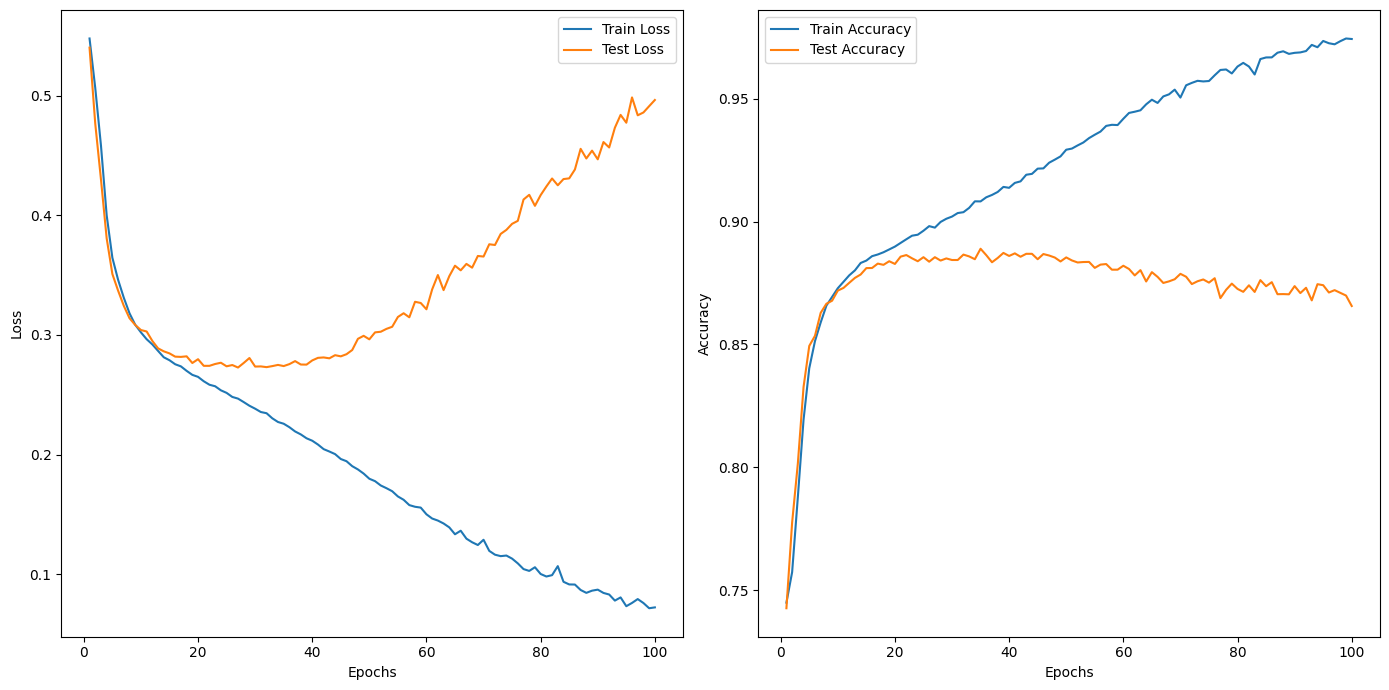

Starting final evaluation on test set...
Final Test Accuracy: 0.5776
Classification Report:
              precision    recall  f1-score   support

          CD       0.74      0.73      0.74      1019
         HYP       0.59      0.57      0.58       519
          MI       0.69      0.73      0.71      1102
        NORM       0.85      0.79      0.82      1906
        STTC       0.70      0.67      0.69      1055

   micro avg       0.74      0.72      0.73      5601
   macro avg       0.71      0.70      0.71      5601
weighted avg       0.75      0.72      0.74      5601
 samples avg       0.73      0.73      0.72      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


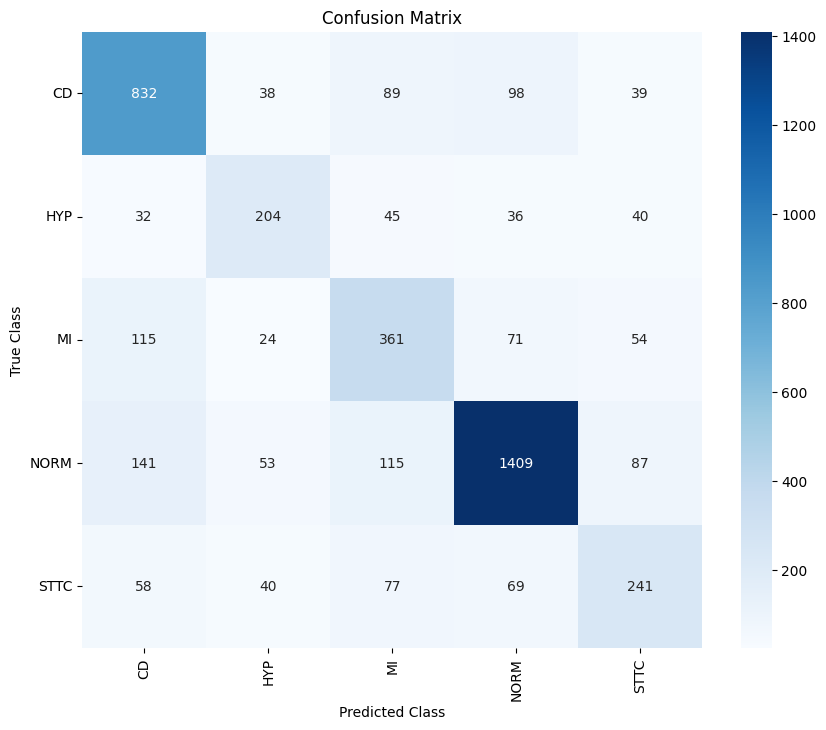

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/gru_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm
from torchsummary import summary  # For model summary

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the GRU model with an additional GRU layer (total 3 layers)
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, dropout_rate=0.2043442604805581):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Add Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Apply Dropout after the GRU layer
        out = self.fc(out)
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes (Exact Values)
print("Exact training set size:", X_train.shape)
print("Exact test set size:", X_test.shape)

# Calculate and print exact standard deviations
train_std = np.std(X_train)
test_std = np.std(X_test)

# Print the exact standard deviations
print("Train data standard deviation (exact):", train_std)
print("Test data standard deviation (exact):", test_std)

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the GRU model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 128  # Hidden state size of the GRU
output_dim = y_train.shape[1]  # Number of output classes

# Apply the dropout rate and learning rate modifications
dropout_rate = 0.2043442604805581
learning_rate = 0.0003952434743256836

model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the model summary
print("\nModel Architecture Summary:")
summary(model, input_size=(n_timesteps, input_dim))

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/gru_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


Loading annotation data...
Annotation data loaded.
Loading raw ECG signal data with 100 Hz sampling rate using parallelism...


100%|██████████| 21837/21837 [01:26<00:00, 253.06it/s]


Finished loading raw ECG signal data with 100 Hz sampling rate.
Loading diagnostic aggregation data...
Diagnostic aggregation data loaded and filtered.
Aggregating diagnostic superclasses...
Finished aggregating diagnostic superclasses.
Downsampling ECG signals...
Shape after downsampling: 21837 samples, 500 timesteps, 12 leads
Encoding labels...
Encoded labels shape: (21837, 5)
Splitting data into training and test sets...
Exact training set size: (17469, 500, 12)
Exact test set size: (4368, 500, 12)
Train data standard deviation (exact): 0.23364261164281808
Test data standard deviation (exact): 0.2317493984831071

Model Architecture Summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
               GRU-1  [[-1, 500, 128], [-1, 2, 128]]               0
           Dropout-2                  [-1, 128]               0
            Linear-3                    [-1, 5]             645
Total params: 645
Trai

Training Epoch 1/100: 100%|██████████| 273/273 [00:09<00:00, 29.38it/s]


End of Epoch 1: Train Loss: 0.5485, Train Accuracy: 0.7406
End of Epoch 1: Test Loss: 0.5379, Test Accuracy: 0.7426

Starting Epoch 2/100


Training Epoch 2/100: 100%|██████████| 273/273 [00:09<00:00, 28.22it/s]


End of Epoch 2: Train Loss: 0.5050, Train Accuracy: 0.7611
End of Epoch 2: Test Loss: 0.4773, Test Accuracy: 0.7761

Starting Epoch 3/100


Training Epoch 3/100: 100%|██████████| 273/273 [00:09<00:00, 28.09it/s]


End of Epoch 3: Train Loss: 0.4504, Train Accuracy: 0.7910
End of Epoch 3: Test Loss: 0.4136, Test Accuracy: 0.8139

Starting Epoch 4/100


Training Epoch 4/100: 100%|██████████| 273/273 [00:09<00:00, 28.60it/s]


End of Epoch 4: Train Loss: 0.3881, Train Accuracy: 0.8289
End of Epoch 4: Test Loss: 0.3688, Test Accuracy: 0.8409

Starting Epoch 5/100


Training Epoch 5/100: 100%|██████████| 273/273 [00:09<00:00, 28.96it/s]


End of Epoch 5: Train Loss: 0.3603, Train Accuracy: 0.8430
End of Epoch 5: Test Loss: 0.3496, Test Accuracy: 0.8506

Starting Epoch 6/100


Training Epoch 6/100: 100%|██████████| 273/273 [00:09<00:00, 29.16it/s]


End of Epoch 6: Train Loss: 0.3445, Train Accuracy: 0.8515
End of Epoch 6: Test Loss: 0.3368, Test Accuracy: 0.8571

Starting Epoch 7/100


Training Epoch 7/100: 100%|██████████| 273/273 [00:09<00:00, 29.09it/s]


End of Epoch 7: Train Loss: 0.3316, Train Accuracy: 0.8576
End of Epoch 7: Test Loss: 0.3265, Test Accuracy: 0.8598

Starting Epoch 8/100


Training Epoch 8/100: 100%|██████████| 273/273 [00:09<00:00, 29.09it/s]


End of Epoch 8: Train Loss: 0.3220, Train Accuracy: 0.8630
End of Epoch 8: Test Loss: 0.3231, Test Accuracy: 0.8603

Starting Epoch 9/100


Training Epoch 9/100: 100%|██████████| 273/273 [00:09<00:00, 28.97it/s]


End of Epoch 9: Train Loss: 0.3143, Train Accuracy: 0.8679
End of Epoch 9: Test Loss: 0.3156, Test Accuracy: 0.8660

Starting Epoch 10/100


Training Epoch 10/100: 100%|██████████| 273/273 [00:09<00:00, 28.82it/s]


End of Epoch 10: Train Loss: 0.3033, Train Accuracy: 0.8732
End of Epoch 10: Test Loss: 0.3071, Test Accuracy: 0.8714

Starting Epoch 11/100


Training Epoch 11/100: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s]


End of Epoch 11: Train Loss: 0.2972, Train Accuracy: 0.8755
End of Epoch 11: Test Loss: 0.3054, Test Accuracy: 0.8704

Starting Epoch 12/100


Training Epoch 12/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 12: Train Loss: 0.2936, Train Accuracy: 0.8781
End of Epoch 12: Test Loss: 0.2908, Test Accuracy: 0.8776

Starting Epoch 13/100


Training Epoch 13/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 13: Train Loss: 0.2882, Train Accuracy: 0.8801
End of Epoch 13: Test Loss: 0.2955, Test Accuracy: 0.8772

Starting Epoch 14/100


Training Epoch 14/100: 100%|██████████| 273/273 [00:09<00:00, 28.79it/s]


End of Epoch 14: Train Loss: 0.2845, Train Accuracy: 0.8814
End of Epoch 14: Test Loss: 0.2871, Test Accuracy: 0.8803

Starting Epoch 15/100


Training Epoch 15/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 15: Train Loss: 0.2796, Train Accuracy: 0.8832
End of Epoch 15: Test Loss: 0.2929, Test Accuracy: 0.8769

Starting Epoch 16/100


Training Epoch 16/100: 100%|██████████| 273/273 [00:09<00:00, 28.95it/s]


End of Epoch 16: Train Loss: 0.2771, Train Accuracy: 0.8856
End of Epoch 16: Test Loss: 0.2793, Test Accuracy: 0.8821

Starting Epoch 17/100


Training Epoch 17/100: 100%|██████████| 273/273 [00:09<00:00, 28.91it/s]


End of Epoch 17: Train Loss: 0.2747, Train Accuracy: 0.8859
End of Epoch 17: Test Loss: 0.2793, Test Accuracy: 0.8808

Starting Epoch 18/100


Training Epoch 18/100: 100%|██████████| 273/273 [00:09<00:00, 28.87it/s]


End of Epoch 18: Train Loss: 0.2700, Train Accuracy: 0.8879
End of Epoch 18: Test Loss: 0.2825, Test Accuracy: 0.8811

Starting Epoch 19/100


Training Epoch 19/100: 100%|██████████| 273/273 [00:09<00:00, 28.81it/s]


End of Epoch 19: Train Loss: 0.2679, Train Accuracy: 0.8896
End of Epoch 19: Test Loss: 0.2718, Test Accuracy: 0.8846

Starting Epoch 20/100


Training Epoch 20/100: 100%|██████████| 273/273 [00:09<00:00, 28.90it/s]


End of Epoch 20: Train Loss: 0.2646, Train Accuracy: 0.8904
End of Epoch 20: Test Loss: 0.2734, Test Accuracy: 0.8846

Starting Epoch 21/100


Training Epoch 21/100: 100%|██████████| 273/273 [00:09<00:00, 28.89it/s]


End of Epoch 21: Train Loss: 0.2624, Train Accuracy: 0.8909
End of Epoch 21: Test Loss: 0.2757, Test Accuracy: 0.8834

Starting Epoch 22/100


Training Epoch 22/100: 100%|██████████| 273/273 [00:09<00:00, 28.88it/s]


End of Epoch 22: Train Loss: 0.2594, Train Accuracy: 0.8932
End of Epoch 22: Test Loss: 0.2725, Test Accuracy: 0.8855

Starting Epoch 23/100


Training Epoch 23/100: 100%|██████████| 273/273 [00:09<00:00, 28.88it/s]


End of Epoch 23: Train Loss: 0.2556, Train Accuracy: 0.8947
End of Epoch 23: Test Loss: 0.2738, Test Accuracy: 0.8854

Starting Epoch 24/100


Training Epoch 24/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 24: Train Loss: 0.2555, Train Accuracy: 0.8947
End of Epoch 24: Test Loss: 0.2720, Test Accuracy: 0.8850

Starting Epoch 25/100


Training Epoch 25/100: 100%|██████████| 273/273 [00:09<00:00, 28.81it/s]


End of Epoch 25: Train Loss: 0.2521, Train Accuracy: 0.8961
End of Epoch 25: Test Loss: 0.2723, Test Accuracy: 0.8855

Starting Epoch 26/100


Training Epoch 26/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 26: Train Loss: 0.2493, Train Accuracy: 0.8965
End of Epoch 26: Test Loss: 0.2717, Test Accuracy: 0.8854

Starting Epoch 27/100


Training Epoch 27/100: 100%|██████████| 273/273 [00:09<00:00, 28.85it/s]


End of Epoch 27: Train Loss: 0.2467, Train Accuracy: 0.8987
End of Epoch 27: Test Loss: 0.2688, Test Accuracy: 0.8864

Starting Epoch 28/100


Training Epoch 28/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 28: Train Loss: 0.2429, Train Accuracy: 0.8999
End of Epoch 28: Test Loss: 0.2697, Test Accuracy: 0.8867

Starting Epoch 29/100


Training Epoch 29/100: 100%|██████████| 273/273 [00:09<00:00, 28.91it/s]


End of Epoch 29: Train Loss: 0.2423, Train Accuracy: 0.9006
End of Epoch 29: Test Loss: 0.2727, Test Accuracy: 0.8874

Starting Epoch 30/100


Training Epoch 30/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 30: Train Loss: 0.2389, Train Accuracy: 0.9022
End of Epoch 30: Test Loss: 0.2668, Test Accuracy: 0.8890

Starting Epoch 31/100


Training Epoch 31/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 31: Train Loss: 0.2350, Train Accuracy: 0.9030
End of Epoch 31: Test Loss: 0.2688, Test Accuracy: 0.8878

Starting Epoch 32/100


Training Epoch 32/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 32: Train Loss: 0.2317, Train Accuracy: 0.9054
End of Epoch 32: Test Loss: 0.2692, Test Accuracy: 0.8885

Starting Epoch 33/100


Training Epoch 33/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 33: Train Loss: 0.2282, Train Accuracy: 0.9067
End of Epoch 33: Test Loss: 0.2721, Test Accuracy: 0.8880

Starting Epoch 34/100


Training Epoch 34/100: 100%|██████████| 273/273 [00:09<00:00, 28.88it/s]


End of Epoch 34: Train Loss: 0.2277, Train Accuracy: 0.9065
End of Epoch 34: Test Loss: 0.2700, Test Accuracy: 0.8902

Starting Epoch 35/100


Training Epoch 35/100: 100%|██████████| 273/273 [00:09<00:00, 28.88it/s]


End of Epoch 35: Train Loss: 0.2236, Train Accuracy: 0.9088
End of Epoch 35: Test Loss: 0.2708, Test Accuracy: 0.8903

Starting Epoch 36/100


Training Epoch 36/100: 100%|██████████| 273/273 [00:09<00:00, 28.90it/s]


End of Epoch 36: Train Loss: 0.2204, Train Accuracy: 0.9105
End of Epoch 36: Test Loss: 0.2684, Test Accuracy: 0.8877

Starting Epoch 37/100


Training Epoch 37/100: 100%|██████████| 273/273 [00:09<00:00, 28.89it/s]


End of Epoch 37: Train Loss: 0.2174, Train Accuracy: 0.9121
End of Epoch 37: Test Loss: 0.2741, Test Accuracy: 0.8891

Starting Epoch 38/100


Training Epoch 38/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 38: Train Loss: 0.2155, Train Accuracy: 0.9133
End of Epoch 38: Test Loss: 0.2808, Test Accuracy: 0.8870

Starting Epoch 39/100


Training Epoch 39/100: 100%|██████████| 273/273 [00:09<00:00, 28.90it/s]


End of Epoch 39: Train Loss: 0.2123, Train Accuracy: 0.9152
End of Epoch 39: Test Loss: 0.2817, Test Accuracy: 0.8843

Starting Epoch 40/100


Training Epoch 40/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 40: Train Loss: 0.2080, Train Accuracy: 0.9157
End of Epoch 40: Test Loss: 0.2725, Test Accuracy: 0.8881

Starting Epoch 41/100


Training Epoch 41/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 41: Train Loss: 0.2050, Train Accuracy: 0.9181
End of Epoch 41: Test Loss: 0.2809, Test Accuracy: 0.8870

Starting Epoch 42/100


Training Epoch 42/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 42: Train Loss: 0.2009, Train Accuracy: 0.9197
End of Epoch 42: Test Loss: 0.2763, Test Accuracy: 0.8881

Starting Epoch 43/100


Training Epoch 43/100: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s]


End of Epoch 43: Train Loss: 0.1979, Train Accuracy: 0.9209
End of Epoch 43: Test Loss: 0.2797, Test Accuracy: 0.8885

Starting Epoch 44/100


Training Epoch 44/100: 100%|██████████| 273/273 [00:09<00:00, 28.58it/s]


End of Epoch 44: Train Loss: 0.1946, Train Accuracy: 0.9219
End of Epoch 44: Test Loss: 0.2847, Test Accuracy: 0.8876

Starting Epoch 45/100


Training Epoch 45/100: 100%|██████████| 273/273 [00:09<00:00, 28.69it/s]


End of Epoch 45: Train Loss: 0.1907, Train Accuracy: 0.9243
End of Epoch 45: Test Loss: 0.2894, Test Accuracy: 0.8835

Starting Epoch 46/100


Training Epoch 46/100: 100%|██████████| 273/273 [00:09<00:00, 28.75it/s]


End of Epoch 46: Train Loss: 0.1877, Train Accuracy: 0.9247
End of Epoch 46: Test Loss: 0.2900, Test Accuracy: 0.8849

Starting Epoch 47/100


Training Epoch 47/100: 100%|██████████| 273/273 [00:09<00:00, 28.59it/s]


End of Epoch 47: Train Loss: 0.1845, Train Accuracy: 0.9269
End of Epoch 47: Test Loss: 0.2939, Test Accuracy: 0.8844

Starting Epoch 48/100


Training Epoch 48/100: 100%|██████████| 273/273 [00:09<00:00, 28.65it/s]


End of Epoch 48: Train Loss: 0.1803, Train Accuracy: 0.9289
End of Epoch 48: Test Loss: 0.2913, Test Accuracy: 0.8852

Starting Epoch 49/100


Training Epoch 49/100: 100%|██████████| 273/273 [00:09<00:00, 28.71it/s]


End of Epoch 49: Train Loss: 0.1752, Train Accuracy: 0.9308
End of Epoch 49: Test Loss: 0.2923, Test Accuracy: 0.8852

Starting Epoch 50/100


Training Epoch 50/100: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s]


End of Epoch 50: Train Loss: 0.1729, Train Accuracy: 0.9326
End of Epoch 50: Test Loss: 0.2980, Test Accuracy: 0.8844

Starting Epoch 51/100


Training Epoch 51/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 51: Train Loss: 0.1683, Train Accuracy: 0.9335
End of Epoch 51: Test Loss: 0.3063, Test Accuracy: 0.8817

Starting Epoch 52/100


Training Epoch 52/100: 100%|██████████| 273/273 [00:09<00:00, 28.75it/s]


End of Epoch 52: Train Loss: 0.1659, Train Accuracy: 0.9350
End of Epoch 52: Test Loss: 0.3125, Test Accuracy: 0.8810

Starting Epoch 53/100


Training Epoch 53/100: 100%|██████████| 273/273 [00:09<00:00, 28.79it/s]


End of Epoch 53: Train Loss: 0.1630, Train Accuracy: 0.9364
End of Epoch 53: Test Loss: 0.3199, Test Accuracy: 0.8780

Starting Epoch 54/100


Training Epoch 54/100: 100%|██████████| 273/273 [00:09<00:00, 28.80it/s]


End of Epoch 54: Train Loss: 0.1582, Train Accuracy: 0.9382
End of Epoch 54: Test Loss: 0.3245, Test Accuracy: 0.8818

Starting Epoch 55/100


Training Epoch 55/100: 100%|██████████| 273/273 [00:09<00:00, 28.85it/s]


End of Epoch 55: Train Loss: 0.1536, Train Accuracy: 0.9414
End of Epoch 55: Test Loss: 0.3386, Test Accuracy: 0.8815

Starting Epoch 56/100


Training Epoch 56/100: 100%|██████████| 273/273 [00:09<00:00, 28.87it/s]


End of Epoch 56: Train Loss: 0.1486, Train Accuracy: 0.9426
End of Epoch 56: Test Loss: 0.3364, Test Accuracy: 0.8788

Starting Epoch 57/100


Training Epoch 57/100: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s]


End of Epoch 57: Train Loss: 0.1475, Train Accuracy: 0.9425
End of Epoch 57: Test Loss: 0.3411, Test Accuracy: 0.8796

Starting Epoch 58/100


Training Epoch 58/100: 100%|██████████| 273/273 [00:09<00:00, 28.55it/s]


End of Epoch 58: Train Loss: 0.1436, Train Accuracy: 0.9450
End of Epoch 58: Test Loss: 0.3326, Test Accuracy: 0.8810

Starting Epoch 59/100


Training Epoch 59/100: 100%|██████████| 273/273 [00:09<00:00, 28.75it/s]


End of Epoch 59: Train Loss: 0.1379, Train Accuracy: 0.9480
End of Epoch 59: Test Loss: 0.3474, Test Accuracy: 0.8764

Starting Epoch 60/100


Training Epoch 60/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 60: Train Loss: 0.1368, Train Accuracy: 0.9477
End of Epoch 60: Test Loss: 0.3493, Test Accuracy: 0.8810

Starting Epoch 61/100


Training Epoch 61/100: 100%|██████████| 273/273 [00:09<00:00, 28.73it/s]


End of Epoch 61: Train Loss: 0.1320, Train Accuracy: 0.9496
End of Epoch 61: Test Loss: 0.3605, Test Accuracy: 0.8707

Starting Epoch 62/100


Training Epoch 62/100: 100%|██████████| 273/273 [00:09<00:00, 28.75it/s]


End of Epoch 62: Train Loss: 0.1303, Train Accuracy: 0.9514
End of Epoch 62: Test Loss: 0.3578, Test Accuracy: 0.8774

Starting Epoch 63/100


Training Epoch 63/100: 100%|██████████| 273/273 [00:09<00:00, 28.71it/s]


End of Epoch 63: Train Loss: 0.1275, Train Accuracy: 0.9521
End of Epoch 63: Test Loss: 0.3641, Test Accuracy: 0.8765

Starting Epoch 64/100


Training Epoch 64/100: 100%|██████████| 273/273 [00:09<00:00, 28.50it/s]


End of Epoch 64: Train Loss: 0.1220, Train Accuracy: 0.9549
End of Epoch 64: Test Loss: 0.3766, Test Accuracy: 0.8769

Starting Epoch 65/100


Training Epoch 65/100: 100%|██████████| 273/273 [00:09<00:00, 28.44it/s]


End of Epoch 65: Train Loss: 0.1184, Train Accuracy: 0.9562
End of Epoch 65: Test Loss: 0.3808, Test Accuracy: 0.8731

Starting Epoch 66/100


Training Epoch 66/100: 100%|██████████| 273/273 [00:09<00:00, 28.70it/s]


End of Epoch 66: Train Loss: 0.1170, Train Accuracy: 0.9561
End of Epoch 66: Test Loss: 0.3864, Test Accuracy: 0.8739

Starting Epoch 67/100


Training Epoch 67/100: 100%|██████████| 273/273 [00:09<00:00, 28.61it/s]


End of Epoch 67: Train Loss: 0.1152, Train Accuracy: 0.9566
End of Epoch 67: Test Loss: 0.3872, Test Accuracy: 0.8745

Starting Epoch 68/100


Training Epoch 68/100: 100%|██████████| 273/273 [00:09<00:00, 28.62it/s]


End of Epoch 68: Train Loss: 0.1103, Train Accuracy: 0.9593
End of Epoch 68: Test Loss: 0.3960, Test Accuracy: 0.8740

Starting Epoch 69/100


Training Epoch 69/100: 100%|██████████| 273/273 [00:09<00:00, 28.67it/s]


End of Epoch 69: Train Loss: 0.1082, Train Accuracy: 0.9607
End of Epoch 69: Test Loss: 0.3989, Test Accuracy: 0.8757

Starting Epoch 70/100


Training Epoch 70/100: 100%|██████████| 273/273 [00:09<00:00, 28.72it/s]


End of Epoch 70: Train Loss: 0.1043, Train Accuracy: 0.9623
End of Epoch 70: Test Loss: 0.4115, Test Accuracy: 0.8722

Starting Epoch 71/100


Training Epoch 71/100: 100%|██████████| 273/273 [00:09<00:00, 28.50it/s]


End of Epoch 71: Train Loss: 0.1062, Train Accuracy: 0.9611
End of Epoch 71: Test Loss: 0.4043, Test Accuracy: 0.8715

Starting Epoch 72/100


Training Epoch 72/100: 100%|██████████| 273/273 [00:09<00:00, 28.66it/s]


End of Epoch 72: Train Loss: 0.1047, Train Accuracy: 0.9611
End of Epoch 72: Test Loss: 0.4103, Test Accuracy: 0.8720

Starting Epoch 73/100


Training Epoch 73/100: 100%|██████████| 273/273 [00:09<00:00, 28.77it/s]


End of Epoch 73: Train Loss: 0.0997, Train Accuracy: 0.9641
End of Epoch 73: Test Loss: 0.4240, Test Accuracy: 0.8729

Starting Epoch 74/100


Training Epoch 74/100: 100%|██████████| 273/273 [00:09<00:00, 28.79it/s]


End of Epoch 74: Train Loss: 0.0942, Train Accuracy: 0.9663
End of Epoch 74: Test Loss: 0.4310, Test Accuracy: 0.8704

Starting Epoch 75/100


Training Epoch 75/100: 100%|██████████| 273/273 [00:09<00:00, 28.72it/s]


End of Epoch 75: Train Loss: 0.0948, Train Accuracy: 0.9656
End of Epoch 75: Test Loss: 0.4473, Test Accuracy: 0.8732

Starting Epoch 76/100


Training Epoch 76/100: 100%|██████████| 273/273 [00:09<00:00, 28.74it/s]


End of Epoch 76: Train Loss: 0.0895, Train Accuracy: 0.9682
End of Epoch 76: Test Loss: 0.4541, Test Accuracy: 0.8687

Starting Epoch 77/100


Training Epoch 77/100: 100%|██████████| 273/273 [00:09<00:00, 28.79it/s]


End of Epoch 77: Train Loss: 0.0982, Train Accuracy: 0.9645
End of Epoch 77: Test Loss: 0.4240, Test Accuracy: 0.8732

Starting Epoch 78/100


Training Epoch 78/100: 100%|██████████| 273/273 [00:09<00:00, 28.80it/s]


End of Epoch 78: Train Loss: 0.0886, Train Accuracy: 0.9684
End of Epoch 78: Test Loss: 0.4426, Test Accuracy: 0.8743

Starting Epoch 79/100


Training Epoch 79/100: 100%|██████████| 273/273 [00:09<00:00, 28.82it/s]


End of Epoch 79: Train Loss: 0.0837, Train Accuracy: 0.9703
End of Epoch 79: Test Loss: 0.4597, Test Accuracy: 0.8740

Starting Epoch 80/100


Training Epoch 80/100: 100%|██████████| 273/273 [00:09<00:00, 28.80it/s]


End of Epoch 80: Train Loss: 0.0837, Train Accuracy: 0.9703
End of Epoch 80: Test Loss: 0.4725, Test Accuracy: 0.8705

Starting Epoch 81/100


Training Epoch 81/100: 100%|██████████| 273/273 [00:09<00:00, 28.72it/s]


End of Epoch 81: Train Loss: 0.0813, Train Accuracy: 0.9713
End of Epoch 81: Test Loss: 0.4646, Test Accuracy: 0.8748

Starting Epoch 82/100


Training Epoch 82/100: 100%|██████████| 273/273 [00:09<00:00, 28.75it/s]


End of Epoch 82: Train Loss: 0.0802, Train Accuracy: 0.9719
End of Epoch 82: Test Loss: 0.4736, Test Accuracy: 0.8697

Starting Epoch 83/100


Training Epoch 83/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 83: Train Loss: 0.0797, Train Accuracy: 0.9717
End of Epoch 83: Test Loss: 0.4774, Test Accuracy: 0.8705

Starting Epoch 84/100


Training Epoch 84/100: 100%|██████████| 273/273 [00:09<00:00, 28.87it/s]


End of Epoch 84: Train Loss: 0.0780, Train Accuracy: 0.9726
End of Epoch 84: Test Loss: 0.4770, Test Accuracy: 0.8717

Starting Epoch 85/100


Training Epoch 85/100: 100%|██████████| 273/273 [00:09<00:00, 28.85it/s]


End of Epoch 85: Train Loss: 0.0755, Train Accuracy: 0.9738
End of Epoch 85: Test Loss: 0.4839, Test Accuracy: 0.8702

Starting Epoch 86/100


Training Epoch 86/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 86: Train Loss: 0.0718, Train Accuracy: 0.9746
End of Epoch 86: Test Loss: 0.5018, Test Accuracy: 0.8676

Starting Epoch 87/100


Training Epoch 87/100: 100%|██████████| 273/273 [00:09<00:00, 28.76it/s]


End of Epoch 87: Train Loss: 0.0723, Train Accuracy: 0.9745
End of Epoch 87: Test Loss: 0.4918, Test Accuracy: 0.8740

Starting Epoch 88/100


Training Epoch 88/100: 100%|██████████| 273/273 [00:09<00:00, 28.73it/s]


End of Epoch 88: Train Loss: 0.0712, Train Accuracy: 0.9750
End of Epoch 88: Test Loss: 0.5136, Test Accuracy: 0.8707

Starting Epoch 89/100


Training Epoch 89/100: 100%|██████████| 273/273 [00:09<00:00, 28.82it/s]


End of Epoch 89: Train Loss: 0.0695, Train Accuracy: 0.9755
End of Epoch 89: Test Loss: 0.5066, Test Accuracy: 0.8707

Starting Epoch 90/100


Training Epoch 90/100: 100%|██████████| 273/273 [00:09<00:00, 28.86it/s]


End of Epoch 90: Train Loss: 0.0644, Train Accuracy: 0.9784
End of Epoch 90: Test Loss: 0.5281, Test Accuracy: 0.8683

Starting Epoch 91/100


Training Epoch 91/100: 100%|██████████| 273/273 [00:09<00:00, 28.82it/s]


End of Epoch 91: Train Loss: 0.0655, Train Accuracy: 0.9774
End of Epoch 91: Test Loss: 0.5238, Test Accuracy: 0.8712

Starting Epoch 92/100


Training Epoch 92/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 92: Train Loss: 0.0632, Train Accuracy: 0.9782
End of Epoch 92: Test Loss: 0.5342, Test Accuracy: 0.8746

Starting Epoch 93/100


Training Epoch 93/100: 100%|██████████| 273/273 [00:09<00:00, 28.84it/s]


End of Epoch 93: Train Loss: 0.0685, Train Accuracy: 0.9758
End of Epoch 93: Test Loss: 0.5185, Test Accuracy: 0.8688

Starting Epoch 94/100


Training Epoch 94/100: 100%|██████████| 273/273 [00:09<00:00, 28.78it/s]


End of Epoch 94: Train Loss: 0.0615, Train Accuracy: 0.9788
End of Epoch 94: Test Loss: 0.5313, Test Accuracy: 0.8706

Starting Epoch 95/100


Training Epoch 95/100: 100%|██████████| 273/273 [00:09<00:00, 28.81it/s]


End of Epoch 95: Train Loss: 0.0628, Train Accuracy: 0.9781
End of Epoch 95: Test Loss: 0.5209, Test Accuracy: 0.8746

Starting Epoch 96/100


Training Epoch 96/100: 100%|██████████| 273/273 [00:09<00:00, 28.81it/s]


End of Epoch 96: Train Loss: 0.0578, Train Accuracy: 0.9797
End of Epoch 96: Test Loss: 0.5485, Test Accuracy: 0.8666

Starting Epoch 97/100


Training Epoch 97/100: 100%|██████████| 273/273 [00:09<00:00, 28.79it/s]


End of Epoch 97: Train Loss: 0.0595, Train Accuracy: 0.9796
End of Epoch 97: Test Loss: 0.5409, Test Accuracy: 0.8688

Starting Epoch 98/100


Training Epoch 98/100: 100%|██████████| 273/273 [00:09<00:00, 28.72it/s]


End of Epoch 98: Train Loss: 0.0571, Train Accuracy: 0.9805
End of Epoch 98: Test Loss: 0.5456, Test Accuracy: 0.8670

Starting Epoch 99/100


Training Epoch 99/100: 100%|██████████| 273/273 [00:09<00:00, 28.67it/s]


End of Epoch 99: Train Loss: 0.0515, Train Accuracy: 0.9822
End of Epoch 99: Test Loss: 0.5617, Test Accuracy: 0.8711

Starting Epoch 100/100


Training Epoch 100/100: 100%|██████████| 273/273 [00:09<00:00, 28.67it/s]


End of Epoch 100: Train Loss: 0.0558, Train Accuracy: 0.9808
End of Epoch 100: Test Loss: 0.5633, Test Accuracy: 0.8707
Training complete. Plotting loss and accuracy curves...


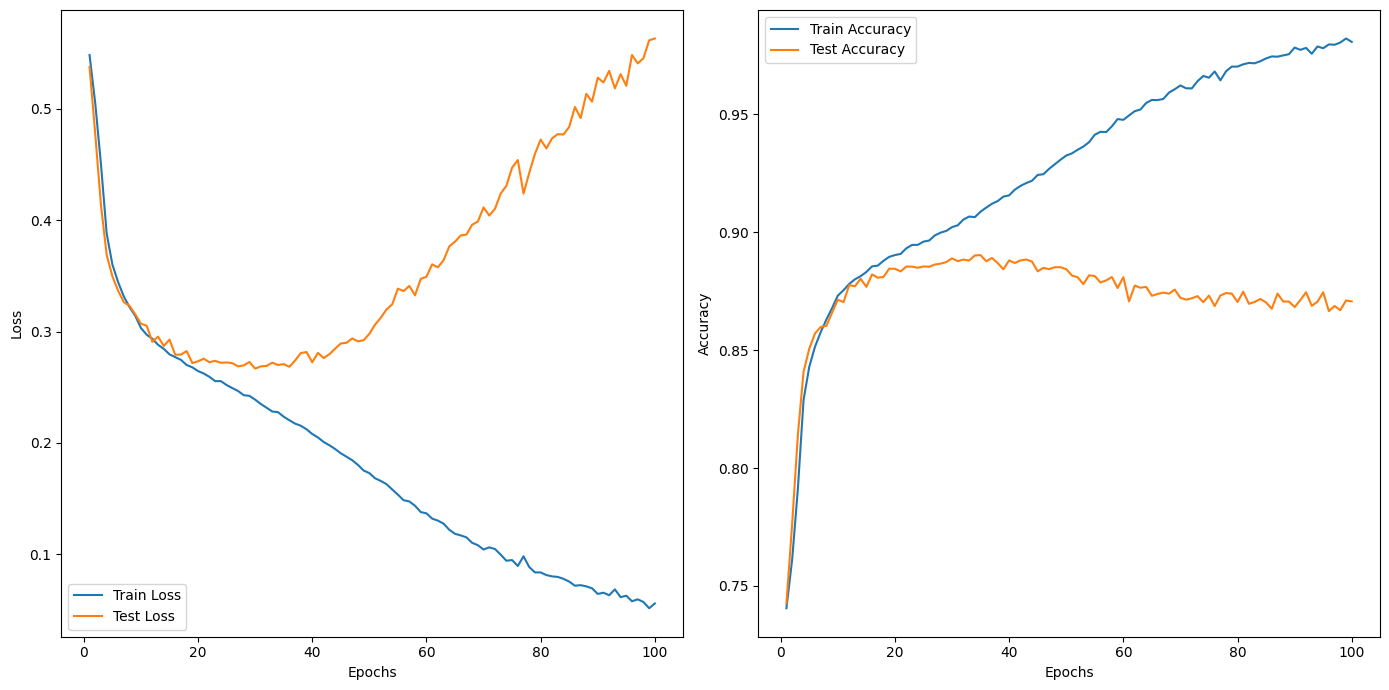

Starting final evaluation on test set...
Final Test Accuracy: 0.5939
Classification Report:
              precision    recall  f1-score   support

          CD       0.72      0.74      0.73      1019
         HYP       0.66      0.50      0.57       519
          MI       0.73      0.68      0.71      1102
        NORM       0.82      0.85      0.84      1906
        STTC       0.74      0.64      0.68      1055

   micro avg       0.76      0.73      0.74      5601
   macro avg       0.74      0.68      0.71      5601
weighted avg       0.76      0.73      0.74      5601
 samples avg       0.75      0.73      0.72      5601

Plotting confusion matrix...


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


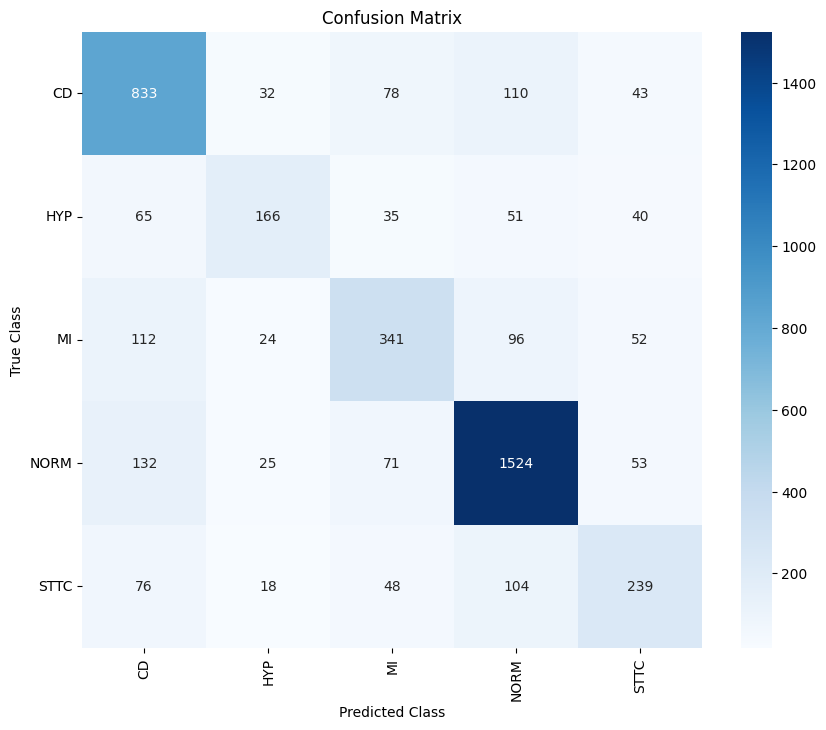

Saving the model...
Model saved to /content/drive/MyDrive/DATAS/results/gru_ecg_model.pth
Data processing, training, and evaluation completed.


In [ ]:
import numpy as np
import pandas as pd
import wfdb
import ast
import os
from concurrent.futures import ThreadPoolExecutor
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from scipy.signal import resample
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns  # For confusion matrix heatmap
from tqdm import tqdm
from torchsummary import summary  # For model summary

# Function to load raw ECG signal data in parallel at 100 Hz sampling rate with tqdm progress bar
def load_raw_data_100hz_parallel(df, base_path, num_workers=8):
    print("Loading raw ECG signal data with 100 Hz sampling rate using parallelism...")
    filenames = df.filename_lr

    def load_single_ecg_file(f):
        full_path = os.path.join(base_path, f)
        try:
            signal, _ = wfdb.rdsamp(full_path)
            return signal
        except FileNotFoundError:
            print(f"File not found: {full_path}, skipping...")
            return None

    data = []
    with ThreadPoolExecutor(max_workers=num_workers) as executor:
        for result in tqdm(executor.map(load_single_ecg_file, filenames), total=len(filenames)):
            if result is not None:
                data.append(result)

    print("Finished loading raw ECG signal data with 100 Hz sampling rate.")
    return np.array(data)

# Define the custom dataset class for PyTorch
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# Define the GRU model with an additional GRU layer (total 4 layers)
class GRUModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=4, dropout_rate=0.2043442604805581):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout_rate)
        self.dropout = nn.Dropout(dropout_rate)  # Add Dropout layer
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        gru_out, _ = self.gru(x)
        out = self.dropout(gru_out[:, -1, :])  # Apply Dropout after the GRU layer
        out = self.fc(out)
        return out

# Set the base path to the records100 folder for 100 Hz data
BASE_PATH_100HZ = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/'

# Load and process annotation data
print("Loading annotation data...")
Y = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'ptbxl_database.csv'), index_col='ecg_id')
Y['scp_codes'] = Y['scp_codes'].apply(ast.literal_eval)
print("Annotation data loaded.")

# Load raw ECG signal data for 100 Hz using parallel loading
X_100Hz = load_raw_data_100hz_parallel(Y, BASE_PATH_100HZ)

# Load and filter scp_statements.csv for diagnostic aggregation
print("Loading diagnostic aggregation data...")
agg_df = pd.read_csv(os.path.join(BASE_PATH_100HZ, 'scp_statements.csv'), index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]
print("Diagnostic aggregation data loaded and filtered.")

# Function to aggregate diagnostics into superclasses
def aggregate_diagnostic(scp_codes_dict):
    diagnostic_classes = [agg_df.loc[code].diagnostic_class
                          for code in scp_codes_dict.keys()
                          if code in agg_df.index]
    return list(set(diagnostic_classes))

# Apply diagnostic superclass aggregation to annotation data
print("Aggregating diagnostic superclasses...")
Y['diagnostic_superclass'] = Y['scp_codes'].apply(aggregate_diagnostic)
print("Finished aggregating diagnostic superclasses.")

# Downsample ECG signals for dimensionality reduction
print("Downsampling ECG signals...")
X_downsampled = np.array([resample(x, 500) for x in X_100Hz])
n_samples, n_timesteps, n_leads = X_downsampled.shape
print(f"Shape after downsampling: {n_samples} samples, {n_timesteps} timesteps, {n_leads} leads")

# Encode diagnostic labels into binary format (for multi-label classification)
print("Encoding labels...")
mlb = MultiLabelBinarizer()
y_encoded = mlb.fit_transform(Y['diagnostic_superclass'])
print(f"Encoded labels shape: {y_encoded.shape}")

# Split the data into training and test sets (80-20 split)
print("Splitting data into training and test sets...")
X_train, X_test, y_train, y_test = train_test_split(X_downsampled, y_encoded, test_size=0.2, random_state=42)

# Print dataset sizes and input shapes (Exact Values)
print("Exact training set size:", X_train.shape)
print("Exact test set size:", X_test.shape)

# Calculate and print exact standard deviations
train_std = np.std(X_train)
test_std = np.std(X_test)

# Print the exact standard deviations
print("Train data standard deviation (exact):", train_std)
print("Test data standard deviation (exact):", test_std)

# Prepare the datasets and dataloaders
batch_size = 64

train_dataset = ECGDataset(X_train, y_train)
test_dataset = ECGDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the GRU model, loss function, and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = n_leads  # Number of input leads
hidden_dim = 128  # Hidden state size of the GRU
output_dim = y_train.shape[1]  # Number of output classes

# Apply the dropout rate and learning rate modifications
dropout_rate = 0.2043442604805581
learning_rate = 0.0003952434743256836

model = GRUModel(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, dropout_rate=dropout_rate).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Print the model summary
print("\nModel Architecture Summary:")
summary(model, input_size=(n_timesteps, input_dim))

# Training loop with tqdm progress bar, and tracking accuracy/loss history
epochs = 100  # Number of epochs can be adjusted
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

for epoch in range(epochs):
    print(f"\nStarting Epoch {epoch+1}/{epochs}")

    # Training phase
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    with tqdm(total=len(train_loader), desc=f"Training Epoch {epoch+1}/{epochs}") as pbar:
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            pbar.update(1)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    train_loss = running_loss / len(train_loader.dataset)
    train_accuracy = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_accuracy)

    print(f"End of Epoch {epoch+1}: Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Validation phase
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item() * inputs.size(0)

            preds = torch.sigmoid(outputs).data > 0.5
            correct += (preds == labels).sum().item()
            total += labels.numel()

    test_loss /= len(test_loader.dataset)
    test_accuracy = correct / total
    test_losses.append(test_loss)
    test_accuracies.append(test_accuracy)

    print(f"End of Epoch {epoch+1}: Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

# Plotting loss and accuracy curves
print("Training complete. Plotting loss and accuracy curves...")
epochs_range = range(1, epochs + 1)
plt.figure(figsize=(14, 7))

# Plot losses
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, test_losses, label="Test Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# Plot accuracies
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accuracies, label="Train Accuracy")
plt.plot(epochs_range, test_accuracies, label="Test Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

# Evaluation
print("Starting final evaluation on test set...")
model.eval()
y_pred = []
y_true = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        outputs = model(inputs)
        y_pred.append(torch.sigmoid(outputs).cpu().numpy())
        y_true.append(labels.cpu().numpy())

y_pred = np.vstack(y_pred) > 0.5
y_true = np.vstack(y_true)

test_accuracy = accuracy_score(y_true, y_pred)
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Print detailed classification report
print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=mlb.classes_))

# Plotting the confusion matrix
print("Plotting confusion matrix...")
conf_matrix = confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1))
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=mlb.classes_, yticklabels=mlb.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.show()

# Saving the model after training
print("Saving the model...")
model_save_path = '/content/drive/MyDrive/DATAS/results/gru_ecg_model.pth'
torch.save(model.state_dict(), model_save_path)
print(f"Model saved to {model_save_path}")

print("Data processing, training, and evaluation completed.")


#Wavelength transform (Scalograms)

In [ ]:
import pandas as pd

# Function to print the names of the files along with their disease class
def print_file_names_and_classes(csv_path):
    # Load the CSV file
    csv_data = pd.read_csv(csv_path)

    # Filter the rows to include only the specified disease classes
    disease_classes = ['NORM', 'STTC', 'CD', 'MI', 'HYP']
    filtered_data = csv_data[csv_data['disease_class'].apply(lambda x: any(cls in x for cls in disease_classes))]

    # Print the file paths and corresponding disease class
    for _, row in filtered_data.iterrows():
        print(f"Disease Class: {row['disease_class']}")
        print(f"File Path (100Hz): {row['file_path_100Hz']}")
        print(f"File Path (500Hz): {row['file_path_500Hz']}")
        print("-" * 50)  # Separator for readability

if __name__ == "__main__":
    # Set the path
    csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_disease_file_info.csv'

    # Print the file names and corresponding disease classes
    print_file_names_and_classes(csv_path)


Streaming output truncated to the last 5000 lines.
Disease Class: ['CD']
File Path (100Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records100/20000/20545_lr
File Path (500Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/20000/20545_hr
--------------------------------------------------
Disease Class: ['NORM']
File Path (100Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records100/20000/20546_lr
File Path (500Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/20000/20546_hr
--------------------------------------------------
Disease Class: ['MI']
File Path (100Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records100/20000/20547_lr
File Path (500Hz): /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/records500/20000/20547_hr
--------------------------------------------------
Disease Class:

Filter CSV file

In [ ]:
import pandas as pd

# Function to load the CSV and delete rows with paired classes, saving to a new file
def remove_paired_classes(csv_path, output_csv_path):
    # Load the original CSV file
    csv_data = pd.read_csv(csv_path)

    # Filter out rows with paired classes (i.e., more than one class)
    filtered_data = csv_data[csv_data['disease_class'].apply(lambda x: len(eval(x)) == 1)]

    # Save the filtered data to a new CSV file
    filtered_data.to_csv(output_csv_path, index=False)

    print(f"Filtered data saved to {output_csv_path}")

if __name__ == "__main__":
    # Set the paths
    csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_disease_file_info.csv'  # Path to your original CSV file
    output_csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_filtered_disease_file_info.csv'  # Path to save the filtered CSV file

    # Remove rows with paired classes and save the result as a new CSV file
    remove_paired_classes(csv_path, output_csv_path)


Filtered data saved to /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_filtered_disease_file_info.csv


Wavelength Transform


In [ ]:
import pandas as pd
import numpy as np
import wfdb
import pywt
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
import torch
import multiprocessing as mp

# Function to generate and save scalograms using GPU acceleration
def generate_scalogram(signal, sampling_rate, save_path):
    try:
        # Convert the signal to a PyTorch tensor and move it to the GPU, use float16 to save memory
        signal_tensor = torch.tensor(signal, dtype=torch.float16).cuda()

        # Define the scales for the CWT
        widths = np.arange(1, 31)

        # Perform the CWT using PyWavelets
        cwt_matrix, _ = pywt.cwt(signal_tensor.cpu().numpy(), widths, 'morl', sampling_period=1.0/sampling_rate)

        # Move the CWT matrix to GPU, use float16 to save memory
        cwt_matrix_tensor = torch.tensor(cwt_matrix, dtype=torch.float16).cuda()

        # Move the CWT matrix back to the CPU and convert it to a numpy array for plotting
        cwt_matrix = cwt_matrix_tensor.cpu().numpy()

        # Plot the scalogram
        plt.figure(figsize=(10, 5))
        plt.imshow(np.abs(cwt_matrix), extent=[0, len(signal)/sampling_rate, 1, 31], cmap='jet', aspect='auto',
                   vmax=np.percentile(np.abs(cwt_matrix), 99))
        plt.colorbar(label='Magnitude')
        plt.title('Scalogram (CWT)')
        plt.xlabel('Time (s)')
        plt.ylabel('Scale (a.u.)')

        # Save the figure
        plt.savefig(save_path)
        plt.close()

        # Clear memory
        del signal_tensor, cwt_matrix_tensor, cwt_matrix
        torch.cuda.empty_cache()

        print(f"Scalogram saved at: {save_path}")
    except Exception as e:
        print(f"Error generating scalogram: {e}")

# Function to process each row
def process_row(row, output_dir):
    try:
        # Load ECG data from the .dat file (using 100 Hz)
        signal, _ = wfdb.rdsamp(row['file_path_100Hz'])
        signal = signal.flatten()  # Flatten the signal if needed

        # Get the disease class
        disease_class = eval(row['disease_class'])[0]  # Extract the class as string

        # Ensure the disease class is valid and create a directory for it
        class_dir = os.path.join(output_dir, disease_class)
        os.makedirs(class_dir, exist_ok=True)

        # Define the save path for the scalogram
        save_path = os.path.join(class_dir, f"{os.path.basename(row['dat_file_100Hz']).replace('.dat', '.png')}")

        # Generate and save the scalogram
        generate_scalogram(signal, sampling_rate=100, save_path=save_path)

    except Exception as e:
        print(f"Error processing file {row['dat_file_100Hz']}: {e}")

# Main function to run everything in parallel with batching
def main(csv_path, output_dir, batch_size=100):
    # Load the filtered CSV file
    csv_data = pd.read_csv(csv_path)

    # Ensure the scalogram output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Process in batches
    num_batches = int(np.ceil(len(csv_data) / batch_size))
    for i in tqdm(range(num_batches)):
        batch_data = csv_data[i * batch_size:(i + 1) * batch_size]
        rows = [row for _, row in batch_data.iterrows()]

        # Use multiprocessing to process rows in parallel within a batch
        with mp.Pool(mp.cpu_count()) as pool:
            list(pool.imap_unordered(process_row_with_params, [(row, output_dir) for row in rows]))

        # Clear GPU memory after each batch
        torch.cuda.empty_cache()

# Wrapper function to pass multiple arguments to the process_row function
def process_row_with_params(params):
    row, output_dir = params
    process_row(row, output_dir)

if __name__ == "__main__":
    # Set the paths
    csv_path = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/ptbxl_filtered_disease_file_info.csv'  # Path to your filtered CSV file
    output_dir = '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms'  # Output directory

    # Run the main function with batching
    main(csv_path, output_dir, batch_size=100)


  0%|          | 0/163 [00:00<?, ?it/s]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/00008_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00002_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00006_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00009_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00001_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00007_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00003_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00004_lr.png
Scalogram saved at

  1%|          | 1/163 [01:29<4:00:21, 89.02s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00115_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00117_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00121_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00118_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00120_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00116_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00114_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00119_lr.png
Scalogram saved 

  1%|          | 2/163 [02:25<3:08:10, 70.13s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00233_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/00240_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00239_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00241_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00237_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/00238_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00232_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00242_lr.png
Scalogram saved at: 

  2%|▏         | 3/163 [03:22<2:51:06, 64.16s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00363_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00361_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00367_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00365_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00368_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00364_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00369_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00366_lr.png
Scalogram saved 

  2%|▏         | 4/163 [04:19<2:41:33, 60.97s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00488_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00481_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00485_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00490_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/00486_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00484_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00480_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00487_lr.png
Scalogram saved at

  3%|▎         | 5/163 [05:16<2:36:46, 59.54s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00630_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00629_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00632_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/00640_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00631_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00638_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00639_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/00633_lr.png
Scalogram saved at:

  4%|▎         | 6/163 [06:12<2:32:51, 58.42s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00776_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00772_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00773_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00775_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00777_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00771_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00774_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00778_lr.png
Scalogram saved 

  4%|▍         | 7/163 [07:08<2:30:12, 57.78s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00900_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00899_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/00898_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00897_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00901_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00896_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/00903_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/00902_lr.png
Scalogram saved at

  5%|▍         | 8/163 [08:05<2:28:01, 57.30s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/01024_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01031_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01026_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01028_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/01032_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01030_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01029_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01027_lr.png
Scalogram saved at:

  6%|▌         | 9/163 [09:01<2:26:17, 57.00s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01161_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01159_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/01162_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01164_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01163_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01165_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01166_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/01160_lr.png
Scalogram saved at: /

  6%|▌         | 10/163 [09:57<2:24:24, 56.63s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01287_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01289_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01291_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01285_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01290_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01288_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01292_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01286_lr.png
Scalogram saved 

  7%|▋         | 11/163 [10:51<2:21:38, 55.91s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01415_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01414_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01412_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/01416_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01413_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01410_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01418_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01409_lr.png

Scalogram saved at: 

  7%|▋         | 12/163 [11:47<2:20:41, 55.90s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01554_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01548_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01544_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01553_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01555_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01552_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01545_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01546_lr.png
Scalogram saved at

  8%|▊         | 13/163 [12:43<2:20:07, 56.05s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01677_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01672_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01678_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01673_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01681_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/01676_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01682_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01685_lr.png
Scalogram saved at: 

  9%|▊         | 14/163 [13:40<2:19:25, 56.14s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01812_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01807_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/01806_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01814_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/01811_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01808_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01818_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01804_lr.png
Scalogram saved at:

  9%|▉         | 15/163 [14:36<2:18:46, 56.26s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01949_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01938_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01952_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01943_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01950_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01946_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/01948_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/01945_lr.png
Scalogram saved at: /c

 10%|▉         | 16/163 [15:32<2:17:37, 56.17s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/02070_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02072_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02071_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/02076_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02073_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/02074_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02069_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02075_lr.png
Scalogram saved at:

 10%|█         | 17/163 [16:28<2:16:46, 56.21s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02188_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/02197_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02190_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02194_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02195_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02192_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02189_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02193_lr.png
Scalogram saved at:

 11%|█         | 18/163 [17:24<2:15:37, 56.12s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02327_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02321_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02320_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02329_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02328_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02326_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02325_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02319_lr.png
Scalogram saved 

 12%|█▏        | 19/163 [18:20<2:14:04, 55.86s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02437_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02446_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02439_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02444_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/02443_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02441_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02438_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02440_lr.png
Scalogram saved at

 12%|█▏        | 20/163 [19:16<2:13:17, 55.92s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02573_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02570_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/02571_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02577_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02579_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02575_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02574_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02578_lr.png
Scalogram saved at

 13%|█▎        | 21/163 [20:12<2:12:23, 55.94s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/02706_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02711_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/02704_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02712_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02713_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02707_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02708_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02710_lr.png
Scalogram saved at:

 13%|█▎        | 22/163 [21:08<2:12:02, 56.19s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02841_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02842_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02839_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02837_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02844_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02846_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02838_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02845_lr.png
Scalogram saved at: 

 14%|█▍        | 23/163 [22:04<2:10:56, 56.12s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/02970_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02963_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02968_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02969_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/02960_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02961_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02965_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/02966_lr.png
Scalogram saved at

 15%|█▍        | 24/163 [23:01<2:10:15, 56.23s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03094_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03093_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03098_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03096_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03095_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03097_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03100_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03099_lr.png
Scalogram saved at: /c

 15%|█▌        | 25/163 [23:56<2:08:55, 56.05s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03220_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03224_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/03218_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03227_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03226_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03221_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03219_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03225_lr.png
Scalogram saved at:

 16%|█▌        | 26/163 [24:52<2:07:31, 55.85s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03360_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03359_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03363_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03364_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03361_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03365_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03362_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03366_lr.png

Scalogram saved at

 17%|█▋        | 27/163 [25:48<2:06:32, 55.83s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03482_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03479_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03481_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/03483_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03487_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03480_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03485_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03488_lr.png
Scalogram saved at: /co

 17%|█▋        | 28/163 [26:44<2:06:04, 56.03s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03617_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03612_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03616_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03614_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03615_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03618_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03619_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03620_lr.png
Scalogram saved at

 18%|█▊        | 29/163 [27:41<2:05:33, 56.22s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03737_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03738_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03733_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03739_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03734_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03735_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03742_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03736_lr.png
Scalogram saved at

 18%|█▊        | 30/163 [28:35<2:02:59, 55.48s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03873_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03866_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03865_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03868_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03871_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03874_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03870_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/03875_lr.png
Scalogram saved at: /c

 19%|█▉        | 31/163 [29:31<2:02:54, 55.87s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04005_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/03998_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04003_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/03999_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04000_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/03997_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04006_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04004_lr.png
Scalogram saved at: 

 20%|█▉        | 32/163 [30:28<2:02:46, 56.23s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04139_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04136_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04132_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04137_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04138_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04134_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04141_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04133_lr.png
Scalogram saved at: /c

 20%|██        | 33/163 [31:26<2:02:35, 56.58s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04255_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04258_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04257_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04256_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04253_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04252_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04254_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04250_lr.png

Scalogram saved at: /conte

 21%|██        | 34/163 [32:24<2:02:42, 57.08s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04381_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04387_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04379_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04388_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04385_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04380_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04386_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04383_lr.png
Scalogram saved at: /c

 21%|██▏       | 35/163 [33:21<2:01:44, 57.06s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04510_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/04511_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04515_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04508_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04516_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04514_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04512_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04517_lr.png
Scalogram saved a

 22%|██▏       | 36/163 [34:18<2:00:31, 56.94s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/04645_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04649_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04648_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04647_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04643_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04650_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04644_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04652_lr.png
Scalogram saved at: /

 23%|██▎       | 37/163 [35:13<1:58:44, 56.55s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04785_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04790_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04789_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04788_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04784_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04786_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04787_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04783_lr.png
Scalogram saved at: 

 23%|██▎       | 38/163 [36:09<1:57:12, 56.26s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04913_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/04920_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04921_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/04918_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/04919_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04914_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/04912_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/04915_lr.png
Scalogram saved at: /co

 24%|██▍       | 39/163 [37:05<1:56:17, 56.27s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05063_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05066_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05071_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05067_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05064_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/05074_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05057_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05060_lr.png
Scalogram saved at: /c

 25%|██▍       | 40/163 [38:01<1:54:57, 56.08s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05202_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05199_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05205_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05200_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05204_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05206_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05207_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05203_lr.png
Scalogram saved at: 

 25%|██▌       | 41/163 [38:56<1:53:26, 55.79s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05327_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05325_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05326_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05324_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05333_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05332_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05331_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05328_lr.png

Scalogram saved at: 

 26%|██▌       | 42/163 [39:52<1:52:51, 55.96s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05465_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05467_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05460_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05459_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05466_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05464_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05462_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05463_lr.png
Scalogram saved at

 26%|██▋       | 43/163 [40:47<1:51:19, 55.66s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05600_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05602_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05599_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05596_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05603_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05592_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05595_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05597_lr.png
Scalogram saved at: 

 27%|██▋       | 44/163 [41:40<1:48:50, 54.88s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05732_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05727_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05728_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05733_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05735_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05737_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05739_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05731_lr.png
Scalogram saved 

 28%|██▊       | 45/163 [42:35<1:47:57, 54.89s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/05865_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05867_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/05871_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/05873_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05869_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05874_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/05866_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05870_lr.png

Scalogram saved at: /con

 28%|██▊       | 46/163 [43:32<1:48:05, 55.43s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05987_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/05985_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05984_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05983_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05989_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05988_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/05990_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/05986_lr.png
Scalogram saved at: /c

 29%|██▉       | 47/163 [44:27<1:46:54, 55.29s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06127_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06130_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06128_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06131_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06132_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06133_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06124_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06125_lr.png
Scalogram saved 

 29%|██▉       | 48/163 [45:23<1:46:10, 55.40s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06258_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06255_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06256_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06265_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06260_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06262_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06261_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06264_lr.png
Scalogram saved at

 30%|███       | 49/163 [46:20<1:46:22, 55.98s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06401_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/06396_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06394_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06398_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06399_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06397_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06402_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/06395_lr.png
Scalogram saved at: /c

 31%|███       | 50/163 [47:16<1:45:33, 56.05s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06528_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06535_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06534_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06531_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06529_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06536_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06541_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06539_lr.png

Scalogram saved at

 31%|███▏      | 51/163 [48:11<1:44:14, 55.85s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06660_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06668_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/06665_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06670_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06664_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/06661_lr.png



Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06671_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06667_lr.png
Scalogram saved at: /

 32%|███▏      | 52/163 [49:07<1:42:59, 55.67s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06802_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06801_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06798_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06799_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06804_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/06805_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06807_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06797_lr.png
Scalogram saved at: 

 33%|███▎      | 53/163 [50:01<1:41:06, 55.15s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/06929_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/06932_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06928_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/06927_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06924_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06930_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/06931_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/06926_lr.png
Scalogram saved at: /

 33%|███▎      | 54/163 [50:57<1:40:35, 55.37s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07068_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/07066_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07064_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07067_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07061_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07065_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07069_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07070_lr.png
Scalogram saved at: /c

 34%|███▎      | 55/163 [51:53<1:40:07, 55.63s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07205_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07203_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07207_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/07198_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07202_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/07206_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07201_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07208_lr.png
Scalogram saved at: /

 34%|███▍      | 56/163 [52:48<1:39:04, 55.55s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07355_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07351_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07352_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07357_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07348_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/07354_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07353_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07347_lr.png
Scalogram saved a

 35%|███▍      | 57/163 [53:44<1:38:07, 55.55s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07477_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07487_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07483_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07480_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07479_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07486_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07481_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07478_lr.png
Scalogram saved at: /c

 36%|███▌      | 58/163 [54:39<1:37:14, 55.57s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07614_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07616_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07620_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07609_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07611_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/07618_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07608_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07615_lr.png
Scalogram saved at: 

 36%|███▌      | 59/163 [55:34<1:36:04, 55.43s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07748_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07750_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07743_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07746_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07740_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07744_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07749_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07747_lr.png
Scalogram saved at: /c

 37%|███▋      | 60/163 [56:31<1:35:31, 55.65s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07883_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07878_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07887_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07886_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/07885_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07879_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/07880_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/07888_lr.png
Scalogram saved at: 

 37%|███▋      | 61/163 [57:26<1:34:31, 55.60s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/08017_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08012_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08011_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08015_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/08022_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08021_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08018_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08010_lr.png
Scalogram saved at: /conte

 38%|███▊      | 62/163 [58:21<1:33:03, 55.28s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08145_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08141_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08143_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08144_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08140_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08146_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08142_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08147_lr.png
Scalogram saved 

 39%|███▊      | 63/163 [59:16<1:32:03, 55.23s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08269_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08282_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08274_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08280_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08268_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08277_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08283_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08276_lr.png

Scalogram saved at

 39%|███▉      | 64/163 [1:00:12<1:31:39, 55.55s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08409_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08410_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08407_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08414_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08412_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08408_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08405_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08413_lr.png
Scalogram saved at: 

 40%|███▉      | 65/163 [1:01:07<1:30:22, 55.33s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08552_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08547_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08548_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08550_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08545_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08549_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08546_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08542_lr.png
Scalogram saved at: /c

 40%|████      | 66/163 [1:02:01<1:28:49, 54.94s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08673_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08681_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08677_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08671_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08676_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08679_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08678_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08674_lr.png
Scalogram saved at: /con

 41%|████      | 67/163 [1:02:57<1:28:34, 55.36s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08817_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08822_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08819_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08821_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08824_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08816_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08823_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08818_lr.png
Scalogram saved at: /con

 42%|████▏     | 68/163 [1:03:52<1:27:18, 55.14s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08953_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/08958_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08952_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08960_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08955_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/08954_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/08957_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/08951_lr.png
Scalogram saved at: /c

 42%|████▏     | 69/163 [1:04:48<1:26:38, 55.30s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09097_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09093_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09099_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09092_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09100_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09096_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09090_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09091_lr.png
Scalogram saved at: 

 43%|████▎     | 70/163 [1:05:42<1:25:17, 55.03s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09225_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09234_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09229_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09228_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09227_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09231_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09230_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09232_lr.png
Scalogram saved at: 

 44%|████▎     | 71/163 [1:06:37<1:24:13, 54.93s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09362_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09368_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/09364_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09367_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09363_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09365_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09369_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09370_lr.png
Scalogram saved at: /con

 44%|████▍     | 72/163 [1:07:33<1:23:48, 55.26s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09499_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09497_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09495_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09498_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09490_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09492_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09491_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09493_lr.png
Scalogram saved at: 

 45%|████▍     | 73/163 [1:08:27<1:22:39, 55.11s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09626_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09627_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09634_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09630_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09633_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09625_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09631_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09624_lr.png
Scalogram saved at: /c

 45%|████▌     | 74/163 [1:09:20<1:20:38, 54.36s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09757_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09759_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09754_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09760_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09763_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09762_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09764_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09761_lr.png
Scalogram saved at

 46%|████▌     | 75/163 [1:10:15<1:19:48, 54.41s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09879_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/09870_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/09873_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09877_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09878_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09874_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/09871_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/09880_lr.png
Scalogram saved at: /c

 47%|████▋     | 76/163 [1:11:10<1:19:15, 54.67s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10015_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/10010_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10007_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10014_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10013_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10008_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10011_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10005_lr.png
Scalogram saved at

 47%|████▋     | 77/163 [1:12:05<1:18:28, 54.75s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10139_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10143_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10135_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10141_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/10134_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10142_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10137_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10145_lr.png
Scalogram saved at:

 48%|████▊     | 78/163 [1:13:00<1:17:54, 55.00s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10265_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10261_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10262_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10264_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10263_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/10266_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10267_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10259_lr.png
Scalogram saved at: 

 48%|████▊     | 79/163 [1:13:55<1:16:46, 54.84s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10391_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10393_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10390_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10389_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10387_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/10388_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10394_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10392_lr.png
Scalogram saved at:

 49%|████▉     | 80/163 [1:14:52<1:16:56, 55.62s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10531_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10530_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10523_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10527_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10528_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10525_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10522_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10524_lr.png
Scalogram saved at

 50%|████▉     | 81/163 [1:15:49<1:16:26, 55.94s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10664_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10658_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10667_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10659_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10666_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10656_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10665_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10663_lr.png
Scalogram saved 

 50%|█████     | 82/163 [1:16:45<1:15:24, 55.85s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10803_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10799_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10804_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10806_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10798_lr.png



Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10805_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10808_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/10800_lr.png
Scalogram saved at

 51%|█████     | 83/163 [1:17:41<1:14:34, 55.93s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10942_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10940_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10939_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/10941_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10947_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10945_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/10948_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/10951_lr.png
Scalogram saved at: /c

 52%|█████▏    | 84/163 [1:18:33<1:12:24, 54.99s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11105_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11103_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11098_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11102_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11099_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11095_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11100_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11112_lr.png
Scalogram saved at: /c

 52%|█████▏    | 85/163 [1:19:28<1:11:16, 54.82s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11234_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11233_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11238_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11239_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11240_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11232_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11237_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11230_lr.png
Scalogram saved at: /c

 53%|█████▎    | 86/163 [1:20:23<1:10:31, 54.96s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11361_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11356_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11357_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11355_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11358_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11354_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11362_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11359_lr.png
Scalogram saved at: /c

 53%|█████▎    | 87/163 [1:21:20<1:10:07, 55.37s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11489_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11492_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11480_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11482_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11484_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11490_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11486_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11493_lr.png
Scalogram saved 

 54%|█████▍    | 88/163 [1:22:13<1:08:21, 54.68s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11622_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11627_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11628_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11618_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11625_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11624_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11619_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11623_lr.png
Scalogram saved at

 55%|█████▍    | 89/163 [1:23:05<1:06:46, 54.14s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11771_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11766_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11767_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11773_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11768_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/11772_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11765_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11769_lr.png
Scalogram saved at: /c

 55%|█████▌    | 90/163 [1:23:59<1:05:32, 53.87s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11905_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/11906_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11907_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/11908_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11904_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11910_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/11902_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/11909_lr.png
Scalogram saved at: /cont

 56%|█████▌    | 91/163 [1:24:53<1:04:37, 53.85s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12045_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/12044_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12043_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12040_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12041_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12039_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12038_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12042_lr.png
Scalogram saved a

 56%|█████▋    | 92/163 [1:25:47<1:03:46, 53.89s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12161_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12164_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12159_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12166_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12163_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/12165_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12160_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/12168_lr.png
Scalogram saved at: 

 57%|█████▋    | 93/163 [1:26:36<1:01:25, 52.65s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12298_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12303_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12300_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12296_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/12301_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/12302_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12304_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12295_lr.png

Scalogram saved at: /

 58%|█████▊    | 94/163 [1:27:30<1:00:54, 52.97s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12448_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12445_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12451_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/12443_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12452_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12446_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12453_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12442_lr.png

Scalogram saved at: /c

 58%|█████▊    | 95/163 [1:28:24<1:00:28, 53.35s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12589_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12591_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12596_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/12597_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12595_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12594_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12598_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12592_lr.png
Scalogram saved at: /c

 59%|█████▉    | 96/163 [1:29:17<59:31, 53.30s/it]  

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12734_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12738_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12737_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/12736_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/12731_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12732_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12733_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12735_lr.png
Scalogram saved at: 

 60%|█████▉    | 97/163 [1:30:12<59:04, 53.70s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/12866_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12870_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12865_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12864_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12872_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/12863_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/12861_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/12873_lr.png
Scalogram saved at: /

 60%|██████    | 98/163 [1:31:03<57:22, 52.96s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13007_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13009_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13005_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13011_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13008_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13010_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13006_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13014_lr.png
Scalogram saved 

 61%|██████    | 99/163 [1:31:56<56:16, 52.75s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13142_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13149_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13146_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13150_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13144_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13145_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13143_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13147_lr.png
Scalogram saved at: /c

 61%|██████▏   | 100/163 [1:32:49<55:29, 52.85s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13298_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13294_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13291_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13289_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13300_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13295_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13297_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13299_lr.png
Scalogram saved at: /con

 62%|██████▏   | 101/163 [1:33:40<54:06, 52.37s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13422_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13417_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13413_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13418_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/13415_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/13416_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/13421_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13414_lr.png
Scalogram saved at: /co

 63%|██████▎   | 102/163 [1:34:33<53:29, 52.61s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13555_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13549_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13547_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13554_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13551_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13550_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13558_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13557_lr.png
Scalogram saved at: 

 63%|██████▎   | 103/163 [1:35:26<52:47, 52.80s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13692_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13691_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13690_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13697_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13699_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/13693_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13696_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13688_lr.png
Scalogram saved at

 64%|██████▍   | 104/163 [1:36:18<51:36, 52.49s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13816_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13811_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13814_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13818_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/13813_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13819_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13817_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13815_lr.png
Scalogram saved at: /c

 64%|██████▍   | 105/163 [1:37:10<50:27, 52.20s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13949_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/13943_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13950_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/13941_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13944_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13945_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13947_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/13942_lr.png
Scalogram saved at

 65%|██████▌   | 106/163 [1:38:04<50:14, 52.89s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14072_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14073_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14077_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14071_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14079_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14078_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14076_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14075_lr.png
Scalogram saved at

 66%|██████▌   | 107/163 [1:38:56<49:04, 52.58s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14203_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14202_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14205_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14204_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14199_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14207_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14208_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14206_lr.png
Scalogram saved at: 

 66%|██████▋   | 108/163 [1:39:49<48:16, 52.66s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14324_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14328_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14326_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/14335_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14327_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14325_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14329_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14332_lr.png
Scalogram saved at: /cont

 67%|██████▋   | 109/163 [1:40:42<47:30, 52.79s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/14470_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14466_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14472_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14469_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14464_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14471_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14465_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14473_lr.png
Scalogram saved a

 67%|██████▋   | 110/163 [1:41:34<46:33, 52.71s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14606_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14607_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14601_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14608_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14604_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14605_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14603_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14602_lr.png
Scalogram saved at: /c

 68%|██████▊   | 111/163 [1:42:25<45:12, 52.16s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14732_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14728_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14735_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/14727_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14726_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/14733_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14737_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14738_lr.png
Scalogram saved at: /co

 69%|██████▊   | 112/163 [1:43:14<43:28, 51.15s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14877_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14881_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/14870_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14874_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/14872_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14878_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14880_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/14873_lr.png
Scalogram saved at: /c

 69%|██████▉   | 113/163 [1:44:08<43:19, 51.99s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15019_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15028_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15022_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15029_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15023_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15025_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15020_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15021_lr.png
Scalogram saved at: /conte

 70%|██████▉   | 114/163 [1:45:01<42:44, 52.33s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15157_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15147_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15154_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15155_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15150_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15156_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15151_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15153_lr.png
Scalogram saved at: /con

 71%|███████   | 115/163 [1:45:52<41:32, 51.94s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15301_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15293_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15302_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15295_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15298_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15299_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15296_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15292_lr.png
Scalogram saved at: 

 71%|███████   | 116/163 [1:46:45<40:53, 52.20s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15416_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15419_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15426_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15423_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15415_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15414_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/15420_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15417_lr.png
Scalogram saved a

 72%|███████▏  | 117/163 [1:47:35<39:37, 51.68s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15558_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15557_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15556_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15563_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15561_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15559_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15562_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15560_lr.png
Scalogram saved at: /c

 72%|███████▏  | 118/163 [1:48:28<38:59, 51.99s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15688_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15681_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15683_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15684_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15686_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15687_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15682_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15685_lr.png
Scalogram saved at: /c

 73%|███████▎  | 119/163 [1:49:22<38:26, 52.41s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15819_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15821_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15812_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15815_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15813_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15820_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15817_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/15818_lr.png
Scalogram saved at: /c

 74%|███████▎  | 120/163 [1:49:44<31:07, 43.44s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15949_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/15951_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15946_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15948_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15947_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/15952_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15953_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/15950_lr.png
Scalogram saved at: 

 74%|███████▍  | 121/163 [1:50:04<25:24, 36.31s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16084_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16083_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16082_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16085_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16087_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16086_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16079_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16081_lr.png
Scalogram saved at: 

 75%|███████▍  | 122/163 [1:50:23<21:17, 31.15s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16208_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16215_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16213_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16207_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16211_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16210_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16216_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16206_lr.png
Scalogram saved at: /con

 75%|███████▌  | 123/163 [1:50:42<18:24, 27.62s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16347_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16353_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16350_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16348_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16349_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16346_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16354_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/16351_lr.png

Scalogram saved at: /conten

 76%|███████▌  | 124/163 [1:51:02<16:20, 25.15s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16498_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16496_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16497_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16499_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16500_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/16502_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16495_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16501_lr.png
Scalogram saved at: /conte

 77%|███████▋  | 125/163 [1:51:21<14:51, 23.45s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16627_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16631_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16633_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16629_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16635_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/16634_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16626_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16630_lr.png
Scalogram saved at: /

 77%|███████▋  | 126/163 [1:51:40<13:40, 22.17s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16762_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16759_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16753_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16755_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16754_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16756_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16763_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16752_lr.png
Scalogram saved at

 78%|███████▊  | 127/163 [1:51:59<12:44, 21.25s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16919_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16914_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16912_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/16911_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16917_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16908_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/16907_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/16915_lr.png
Scalogram saved at: 

 79%|███████▊  | 128/163 [1:52:19<12:05, 20.74s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17057_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17063_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17058_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17061_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17059_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17056_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17060_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17062_lr.png
Scalogram saved at: 

 79%|███████▉  | 129/163 [1:52:38<11:27, 20.21s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17198_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17200_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17196_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17199_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17197_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17203_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17202_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17201_lr.png
Scalogram saved at: 

 80%|███████▉  | 130/163 [1:52:57<10:55, 19.87s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17333_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17330_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17334_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17335_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17331_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17338_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17340_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17332_lr.png
Scalogram saved at: 

 80%|████████  | 131/163 [1:53:16<10:30, 19.69s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17475_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17467_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17473_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17471_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17468_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17474_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17469_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17472_lr.png
Scalogram saved at

 81%|████████  | 132/163 [1:53:35<10:02, 19.43s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17604_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17608_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17609_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17606_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17605_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17611_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17602_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17607_lr.png

Scalogram saved at: 

 82%|████████▏ | 133/163 [1:53:54<09:38, 19.29s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17746_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17742_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/17745_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17747_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17740_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17741_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17744_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17748_lr.png
Scalogram saved at: /

 82%|████████▏ | 134/163 [1:54:13<09:19, 19.30s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17872_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17871_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17873_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17876_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/17881_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17878_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17880_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17874_lr.png

Scalogram saved at: 

 83%|████████▎ | 135/163 [1:54:33<08:59, 19.28s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18000_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/17999_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/17993_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18002_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17996_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17997_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18003_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/17994_lr.png
Scalogram saved at: /c

 83%|████████▎ | 136/163 [1:54:52<08:41, 19.30s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18130_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18133_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18129_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18132_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18125_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18126_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18128_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18127_lr.png
Scalogram saved at

 84%|████████▍ | 137/163 [1:55:11<08:21, 19.29s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18252_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18253_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18248_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18259_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18258_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18245_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18255_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/18257_lr.png
Scalogram saved at:

 85%|████████▍ | 138/163 [1:55:30<07:59, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18396_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18392_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18395_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18399_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18391_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18393_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18389_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18394_lr.png
Scalogram saved at

 85%|████████▌ | 139/163 [1:55:49<07:39, 19.14s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/18531_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18527_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18530_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18533_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18536_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18537_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18540_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18529_lr.png
Scalogram saved at: /co

 86%|████████▌ | 140/163 [1:56:08<07:19, 19.09s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18677_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18685_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/18679_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18682_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18683_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18680_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18684_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18686_lr.png
Scalogram saved at: /conten

 87%|████████▋ | 141/163 [1:56:27<07:00, 19.10s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18827_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18828_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18830_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/18829_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18825_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18826_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18821_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/18824_lr.png
Scalogram saved at: /c

 87%|████████▋ | 142/163 [1:56:46<06:39, 19.04s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18959_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18958_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18968_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18964_lr.png


Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18961_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18967_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/18965_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/18962_lr.png
Scalogram saved at: 

 88%|████████▊ | 143/163 [1:57:06<06:24, 19.25s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19104_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19110_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19106_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19105_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/19100_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19107_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19101_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19109_lr.png
Scalogram saved at: /cont

 88%|████████▊ | 144/163 [1:57:25<06:04, 19.16s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19225_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19230_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19228_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19227_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19233_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19226_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19229_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19231_lr.png
Scalogram saved at

 89%|████████▉ | 145/163 [1:57:44<05:45, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19343_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/19345_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19342_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19347_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19344_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19346_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19350_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/19348_lr.png
Scalogram saved at: /con

 90%|████████▉ | 146/163 [1:58:03<05:25, 19.13s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19485_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19480_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/19477_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19484_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19476_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19486_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19483_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19478_lr.png
Scalogram saved at: /c

 90%|█████████ | 147/163 [1:58:23<05:07, 19.23s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19616_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19622_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19617_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19623_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19618_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19621_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/19611_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19610_lr.png
Scalogram saved at: /con

 91%|█████████ | 148/163 [1:58:42<04:47, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19758_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19760_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19759_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19757_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19763_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/19761_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19764_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19765_lr.png
Scalogram saved at: /c

 91%|█████████▏| 149/163 [1:59:01<04:28, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/19897_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19899_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19895_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19893_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19890_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/19894_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/19892_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/19898_lr.png
Scalogram saved at:

 92%|█████████▏| 150/163 [1:59:20<04:08, 19.10s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20027_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20029_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20034_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20033_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20035_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20030_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20032_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20026_lr.png
Scalogram saved at: 

 93%|█████████▎| 151/163 [1:59:39<03:49, 19.13s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20162_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20168_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20166_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20164_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20167_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20163_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20165_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20160_lr.png
Scalogram saved at: 

 93%|█████████▎| 152/163 [1:59:58<03:30, 19.11s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20297_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20306_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20310_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20294_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20305_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20298_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20302_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20293_lr.png
Scalogram saved at: 

 94%|█████████▍| 153/163 [2:00:17<03:11, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20437_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20435_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20443_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20434_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20432_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20436_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20442_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20441_lr.png
Scalogram saved at: /c

 94%|█████████▍| 154/163 [2:00:36<02:52, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20573_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20567_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20574_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20571_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20568_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20572_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20566_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20570_lr.png
Scalogram saved at: 

 95%|█████████▌| 155/163 [2:00:56<02:33, 19.20s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20717_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20714_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20716_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20711_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20718_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20710_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20707_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20712_lr.png
Scalogram saved at: /c

 96%|█████████▌| 156/163 [2:01:14<02:13, 19.00s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20854_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20848_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20856_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20857_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/20853_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20858_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20852_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20849_lr.png
Scalogram saved at: /c

 96%|█████████▋| 157/163 [2:01:33<01:54, 19.06s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20995_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20991_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/20992_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20996_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20994_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/20998_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20993_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/20999_lr.png
Scalogram saved at: /c

 97%|█████████▋| 158/163 [2:01:52<01:35, 19.05s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21136_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/21137_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/21134_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21135_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21139_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/21143_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21141_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21144_lr.png
Scalogram saved at: /cont

 98%|█████████▊| 159/163 [2:02:12<01:16, 19.11s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21291_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21289_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21287_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21286_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/21285_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21284_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21292_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21290_lr.png
Scalogram saved at: /co

 98%|█████████▊| 160/163 [2:02:31<00:57, 19.14s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21444_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21441_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21442_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21436_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/21437_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21438_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21443_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21440_lr.png
Scalogram saved at

 99%|█████████▉| 161/163 [2:02:50<00:38, 19.18s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21593_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21605_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21603_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21597_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21596_lr.png

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP/21598_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21599_lr.pngScalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/21600_lr.png

Scalogram saved at: /co

 99%|█████████▉| 162/163 [2:03:09<00:19, 19.15s/it]

Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21747_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21741_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21749_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21744_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC/21743_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD/21745_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM/21746_lr.png
Scalogram saved at: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI/21750_lr.png
Scalogram saved at: /c

100%|██████████| 163/163 [2:03:23<00:00, 45.42s/it]


Scalograms output data investigation

In [ ]:
import os
import glob

# List of directory paths
directories = [
    '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD',
    '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP',
    '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI',
    '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM',
    '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC'
]

# Iterate through each directory
for directory in directories:
    # Check if the directory exists
    if os.path.exists(directory):
        print(f"Processing directory: {directory}")

        # Search for all .png files in the directory
        png_files = glob.glob(os.path.join(directory, '*.png'))

        # Check if any png files were found
        if png_files:
            # Iterate through each file and print its name
            for file_path in png_files:
                file_name = os.path.basename(file_path)
                print(f"Found .png file: {file_name}")
        else:
            print(f"No .png files found in {directory}")
    else:
        print(f"Directory does not exist: {directory}")


Streaming output truncated to the last 5000 lines.
Found .png file: 00936_lr.png
Found .png file: 00937_lr.png
Found .png file: 00944_lr.png
Found .png file: 00945_lr.png
Found .png file: 00949_lr.png
Found .png file: 00952_lr.png
Found .png file: 00951_lr.png
Found .png file: 00954_lr.png
Found .png file: 00956_lr.png
Found .png file: 00958_lr.png
Found .png file: 00960_lr.png
Found .png file: 00961_lr.png
Found .png file: 00966_lr.png
Found .png file: 00967_lr.png
Found .png file: 00969_lr.png
Found .png file: 00971_lr.png
Found .png file: 00972_lr.png
Found .png file: 00976_lr.png
Found .png file: 00979_lr.png
Found .png file: 00981_lr.png
Found .png file: 00983_lr.png
Found .png file: 00985_lr.png
Found .png file: 00988_lr.png
Found .png file: 00989_lr.png
Found .png file: 00992_lr.png
Found .png file: 00995_lr.png
Found .png file: 00999_lr.png
Found .png file: 01000_lr.png
Found .png file: 01001_lr.png
Found .png file: 01003_lr.png
Found .png file: 01002_lr.png
Found .png file: 01

# Resnet 50 wavelength XECG Activation

In [ ]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # Progress bar
from torch.cuda.amp import GradScaler, autocast  # For mixed precision
from torchsummary import summary  # For model summary

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# List of directory paths for different classes
directories = {
    'CD': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD',
    'HYP': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP',
    'MI': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI',
    'NORM': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM',
    'STTC': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC'
}

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128  # Increased batch size
EPOCHS = 100  # Increased epochs
LEARNING_RATE = 1e-4

# Custom dataset to load images from paths
class ECGDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        # Load the image
        image = Image.open(img_path)

        # Ensure the image has 3 channels (convert RGBA or L to RGB)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Image transformations (use transformations with PIL images)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Ensure it's RGB
])

# Load all of the data (using 100% of the dataset)
data = []
labels = []

for label, directory in directories.items():
    if os.path.exists(directory):
        print(f"Processing directory: {directory}")

        # Get all .png files
        png_files = glob.glob(os.path.join(directory, '*.png'))

        for file_path in png_files:
            data.append(file_path)
            labels.append(list(directories.keys()).index(label))
    else:
        print(f"Directory does not exist: {directory}")

# Convert to NumPy arrays for further processing
data = np.array(data)
labels = np.array(labels)

# Print the input shape of one of the samples (ensure all are of the same shape)
sample_image = Image.open(data[0])
if sample_image.mode != 'RGB':
    sample_image = sample_image.convert('RGB')
sample_image = transform(sample_image)  # Apply transformation
print(f"Input image shape after transformation: {sample_image.shape}")

# Train-test split (80-20)
train_files, test_files, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42)

# Print the sizes of the train and test sets
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")

# Create datasets and dataloaders
train_dataset = ECGDataset(train_files, train_labels, transform=transform)
test_dataset = ECGDataset(test_files, test_labels, transform=transform)

# Using more workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# Load the ResNet50 model with pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the classifier to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(directories))

# Move the model to the GPU if available
model = model.to(device)

# Print model summary
print("\nModel Summary:\n")
summary(model, (3, IMG_SIZE, IMG_SIZE))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Mixed precision scaler
scaler = GradScaler()

# Train the model
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # To track the best validation accuracy

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scaler handles backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # Validation loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():  # Mixed precision inference
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description
            test_loader_tqdm.set_postfix(loss=loss.item())

    val_loss /= len(test_loader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f'resnet50_epoch_{epoch+1}.pth')
    print(f"Model saved for epoch {epoch + 1}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DATAS/results/best_resnet50_ecg_model.pth')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}")

# Plot training & validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=directories.keys(), yticklabels=directories.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Calculate and print standard deviation for losses and accuracies
train_loss_std = np.std(train_loss_history)
train_acc_std = np.std(train_acc_history)
val_loss_std = np.std(val_loss_history)
val_acc_std = np.std(val_acc_history)

print(f"Training Loss Std Dev: {train_loss_std:.4f}")
print(f"Training Accuracy Std Dev: {train_acc_std:.4f}")
print(f"Validation Loss Std Dev: {val_loss_std:.4f}")
print(f"Validation Accuracy Std Dev: {val_acc_std:.4f}")


Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC
Input image shape after transformation: torch.Size([3, 224, 224])
Training set size: 13017
Test set size: 3255


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 81.5MB/s]



Model Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14  

Training Loss: 1.0235, Training Accuracy: 0.6348


Validation Loss: 0.8837, Validation Accuracy: 0.6879
Model saved for epoch 1
Best model saved at epoch 1 with validation accuracy: 0.6879
Epoch 2/100


Training Loss: 0.7939, Training Accuracy: 0.7154


Validation Loss: 0.8597, Validation Accuracy: 0.6820
Model saved for epoch 2
Epoch 3/100


Training Loss: 0.6303, Training Accuracy: 0.7723


Validation Loss: 0.8968, Validation Accuracy: 0.6817
Model saved for epoch 3
Epoch 4/100


Training Loss: 0.4440, Training Accuracy: 0.8355


Validation Loss: 1.0275, Validation Accuracy: 0.6335
Model saved for epoch 4
Epoch 5/100


Training Loss: 0.2571, Training Accuracy: 0.9117


Validation Loss: 1.3043, Validation Accuracy: 0.6762
Model saved for epoch 5
Epoch 6/100


Training Loss: 0.1508, Training Accuracy: 0.9498


Validation Loss: 1.4274, Validation Accuracy: 0.6252
Model saved for epoch 6
Epoch 7/100


Training Loss: 0.1068, Training Accuracy: 0.9645


Validation Loss: 1.5601, Validation Accuracy: 0.6479
Model saved for epoch 7
Epoch 8/100


Training Loss: 0.0712, Training Accuracy: 0.9773


Validation Loss: 1.7196, Validation Accuracy: 0.6516
Model saved for epoch 8
Epoch 9/100


Training Loss: 0.0632, Training Accuracy: 0.9790


Validation Loss: 1.5002, Validation Accuracy: 0.6750
Model saved for epoch 9
Epoch 10/100


Training Loss: 0.0566, Training Accuracy: 0.9814


Validation Loss: 1.9273, Validation Accuracy: 0.6058
Model saved for epoch 10
Epoch 11/100


Training Loss: 0.0538, Training Accuracy: 0.9816


Validation Loss: 1.6107, Validation Accuracy: 0.6406
Model saved for epoch 11
Epoch 12/100


Training Loss: 0.0505, Training Accuracy: 0.9823


Validation Loss: 1.6718, Validation Accuracy: 0.6630
Model saved for epoch 12
Epoch 13/100


Training Loss: 0.0351, Training Accuracy: 0.9889


Validation Loss: 1.8421, Validation Accuracy: 0.6808
Model saved for epoch 13
Epoch 14/100


Training Loss: 0.0306, Training Accuracy: 0.9906


Validation Loss: 1.8527, Validation Accuracy: 0.6750
Model saved for epoch 14
Epoch 15/100


Training Loss: 0.0318, Training Accuracy: 0.9902


Validation Loss: 1.8269, Validation Accuracy: 0.6845
Model saved for epoch 15
Epoch 16/100


Training Loss: 0.0301, Training Accuracy: 0.9909


Validation Loss: 1.8989, Validation Accuracy: 0.6276
Model saved for epoch 16
Epoch 17/100


Training Loss: 0.0302, Training Accuracy: 0.9903


Validation Loss: 1.8837, Validation Accuracy: 0.6716
Model saved for epoch 17
Epoch 18/100


Training Loss: 0.0373, Training Accuracy: 0.9882


Validation Loss: 1.7912, Validation Accuracy: 0.6682
Model saved for epoch 18
Epoch 19/100


Training:  16%|█▌        | 16/102 [00:13<00:43,  1.96it/s, loss=0.0358]

Resnet50 hyparameter fine tuning

In [ ]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
import optuna
from optuna.trial import TrialState
from tqdm import tqdm
import torchvision.models as models

# Custom Dataset Class
class ECGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.float32)

# ResNet-based Model definition
class ResNet50Model(nn.Module):
    def __init__(self, output_dim):
        super(ResNet50Model, self).__init__()
        # Load the pre-trained ResNet50 model
        self.resnet = models.resnet50(pretrained=True)

        # Modify the fully connected layer to match the output dimensions
        # ResNet50 has 2048 output features before the final fully connected layer
        self.resnet.fc = nn.Linear(2048, output_dim)

    def forward(self, x):
        x = self.resnet(x)
        return x

# Function to create and train the ResNet50 model
def train_model(trial, X_train, y_train, X_val, y_val, output_dim):
    # Hyperparameters from Optuna
    lr = trial.suggest_float("lr", 1e-5, 1e-2)

    # Initialize the ResNet50 model
    model = ResNet50Model(output_dim=output_dim).to(device)

    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Learning rate scheduler
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

    # DataLoader
    train_dataset = ECGDataset(X_train, y_train)
    val_dataset = ECGDataset(X_val, y_val)
    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)

    # Early stopping parameters
    patience = 10
    best_loss = np.inf
    epochs_no_improve = 0

    # Training loop
    for epoch in range(50):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)

                preds = torch.sigmoid(outputs).data > 0.5
                val_correct += (preds == labels).sum().item()
                val_total += labels.numel()

        val_loss /= len(val_loader.dataset)
        val_accuracy = val_correct / val_total

        # Scheduler step
        scheduler.step(val_loss)

        # Early stopping check
        if val_loss < best_loss:
            best_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print(f"Early stopping at epoch {epoch + 1}")
                break

        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    return val_loss, val_accuracy

# Cross-validation function with Optuna
def cross_validate_and_optimize(X, y, n_splits=5, output_dim=5):
    skf = StratifiedKFold(n_splits=n_splits)
    study = optuna.create_study(direction="minimize")

    def objective(trial):
        val_losses = []
        val_accuracies = []
        for train_idx, val_idx in skf.split(X, y.argmax(axis=1)):
            X_train, X_val = X[train_idx], X[val_idx]
            y_train, y_val = y[train_idx], y[val_idx]
            val_loss, val_accuracy = train_model(trial, X_train, y_train, X_val, y_val, output_dim=output_dim)
            val_losses.append(val_loss)
            val_accuracies.append(val_accuracy)
        average_accuracy = np.mean(val_accuracies)
        print(f"Average validation accuracy for this trial: {average_accuracy:.4f}")
        return np.mean(val_losses)

    study.optimize(objective, n_trials=20, timeout=3600)

    pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
    complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

    print(f"Study statistics: ")
    print(f"  Number of finished trials: {len(study.trials)}")
    print(f"  Number of pruned trials: {len(pruned_trials)}")
    print(f"  Number of complete trials: {len(complete_trials)}")

    best_trial = study.best_trial
    print("Best trial:")
    print(f"  Value: {best_trial.value}")
    print("  Params: ")
    for key, value in best_trial.params.items():
        print(f"    {key}: {value}")

    return best_trial

# Ensure input tensors are properly shaped for ResNet50 (batch_size, channels, height, width)
def prepare_sample_data():
    # Placeholder function: Replace this with actual dataset preparation code
    n_samples = 1000
    n_channels = 3  # ResNet typically expects 3 input channels (e.g., RGB images)
    height, width = 224, 224  # ResNet50 typically expects 224x224 input images

    # Generating random sample data
    X = np.random.randn(n_samples, n_channels, height, width)
    y = np.random.randint(0, 2, size=(n_samples, 5))  # Assuming a 5-class binary classification problem
    return X, y

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Main script execution
if __name__ == "__main__":
    # Prepare sample data (replace with actual ECG dataset loading and preprocessing)
    X, y = prepare_sample_data()

    # Perform cross-validation and hyperparameter optimization using Optuna
    best_trial = cross_validate_and_optimize(X, y, n_splits=5, output_dim=5)

    print("Finished cross-validation and optimization.")


[I 2024-09-01 08:27:53,184] A new study created in memory with name: no-name-d467db1d-dc6a-4398-86ce-cd8059a9af8a
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 145MB/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWa

Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 16
Early stopping at epoch 16
Early stopping at epoch 16


[I 2024-09-01 08:39:50,248] Trial 0 finished with value: 0.7387033605575561 and parameters: {'lr': 0.005136618944189864}. Best is trial 0 with value: 0.7387033605575561.


Early stopping at epoch 22
Average validation accuracy for this trial: 0.5026


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 20


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 16 is already reported.
  warnings.warn(


Early stopping at epoch 18
Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 17 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 18 is already reported.
  warnings.warn(
[I 2024-09-01 08:52:18,674] Trial 1 finished with value: 0.7324150786399841 and parameters: {'lr': 0.004937798345800423}. Best is trial 1 with value: 0.7324150786399841.


Early stopping at epoch 26
Average validation accuracy for this trial: 0.5072


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 13


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
[I 2024-09-01 09:02:41,786] Trial 2 finished with value: 0.8466839790344238 and parameters: {'lr': 0.001476081423198809}. Best is trial 1 with value: 0.7324150786399841.


Early stopping at epoch 16
Average validation accuracy for this trial: 0.4798


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 14


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 16


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(


Early stopping at epoch 15
Early stopping at epoch 13


[I 2024-09-01 09:12:39,660] Trial 3 finished with value: 0.879066643714905 and parameters: {'lr': 0.0014417950629243648}. Best is trial 1 with value: 0.7324150786399841.


Early stopping at epoch 13
Average validation accuracy for this trial: 0.4946


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 20


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 15


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


Early stopping at epoch 17
Early stopping at epoch 15


[I 2024-09-01 09:24:07,141] Trial 4 finished with value: 0.739457392692566 and parameters: {'lr': 0.007613335502932065}. Best is trial 1 with value: 0.7324150786399841.


Early stopping at epoch 16
Average validation accuracy for this trial: 0.5056


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Early stopping at epoch 17


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 0 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 1 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 2 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 3 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 4 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 5 is already r

Early stopping at epoch 12


/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 11 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 12 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 13 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 14 is already reported.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/optuna/trial/_trial.py:493: UserWarning: The reported value is ignored because this `step` 15 is already reported.
  warnings.warn(


Early stopping at epoch 17
Early stopping at epoch 18


[I 2024-09-01 09:34:58,967] Trial 5 finished with value: 0.7792657241821289 and parameters: {'lr': 0.005234756955308091}. Best is trial 1 with value: 0.7324150786399841.


Early stopping at epoch 14
Average validation accuracy for this trial: 0.4882
Study statistics: 
  Number of finished trials: 6
  Number of pruned trials: 0
  Number of complete trials: 6
Best trial:
  Value: 0.7324150786399841
  Params: 
    lr: 0.004937798345800423
Finished cross-validation and optimization.


Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC
Input image shape after transformation: torch.Size([3, 224, 224])
Training set size: 13017
Test set size: 3255

Model Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]             

Training Loss: 1.1080, Training Accuracy: 0.6004


Validation Loss: 1.7615, Validation Accuracy: 0.5361
Model saved for epoch 1
Best model saved at epoch 1 with validation accuracy: 0.5361
Epoch 2/100


Training Loss: 0.9557, Training Accuracy: 0.6592


Validation Loss: 1.2637, Validation Accuracy: 0.5598
Model saved for epoch 2
Best model saved at epoch 2 with validation accuracy: 0.5598
Epoch 3/100


Training Loss: 0.9113, Training Accuracy: 0.6717


Validation Loss: 1.0725, Validation Accuracy: 0.6313
Model saved for epoch 3
Best model saved at epoch 3 with validation accuracy: 0.6313
Epoch 4/100


Training Loss: 0.8771, Training Accuracy: 0.6843


Validation Loss: 1.1308, Validation Accuracy: 0.6129
Model saved for epoch 4
Epoch 5/100


Training Loss: 0.8601, Training Accuracy: 0.6946


Validation Loss: 0.9394, Validation Accuracy: 0.6618
Model saved for epoch 5
Best model saved at epoch 5 with validation accuracy: 0.6618
Epoch 6/100


Training Loss: 0.8322, Training Accuracy: 0.7029


Validation Loss: 0.9150, Validation Accuracy: 0.6639
Model saved for epoch 6
Best model saved at epoch 6 with validation accuracy: 0.6639
Epoch 7/100


Training Loss: 0.8165, Training Accuracy: 0.7075


Validation Loss: 0.8994, Validation Accuracy: 0.6753
Model saved for epoch 7
Best model saved at epoch 7 with validation accuracy: 0.6753
Epoch 8/100


Training Loss: 0.8051, Training Accuracy: 0.7112


Validation Loss: 1.0866, Validation Accuracy: 0.6430
Model saved for epoch 8
Epoch 9/100


Training Loss: 0.7868, Training Accuracy: 0.7194


Validation Loss: 0.9498, Validation Accuracy: 0.6676
Model saved for epoch 9
Epoch 10/100


Training Loss: 0.7807, Training Accuracy: 0.7216


Validation Loss: 0.8837, Validation Accuracy: 0.6971
Model saved for epoch 10
Best model saved at epoch 10 with validation accuracy: 0.6971
Epoch 11/100


Training Loss: 0.7591, Training Accuracy: 0.7264


Validation Loss: 1.1174, Validation Accuracy: 0.6347
Model saved for epoch 11
Epoch 12/100


Training Loss: 0.7402, Training Accuracy: 0.7364


Validation Loss: 0.9020, Validation Accuracy: 0.7020
Model saved for epoch 12
Best model saved at epoch 12 with validation accuracy: 0.7020
Epoch 13/100


Training Loss: 0.7296, Training Accuracy: 0.7382


Validation Loss: 0.8484, Validation Accuracy: 0.7026
Model saved for epoch 13
Best model saved at epoch 13 with validation accuracy: 0.7026
Epoch 14/100


Training Loss: 0.7051, Training Accuracy: 0.7479


Validation Loss: 1.1898, Validation Accuracy: 0.6731
Model saved for epoch 14
Epoch 15/100


Training Loss: 0.6809, Training Accuracy: 0.7548


Validation Loss: 0.9822, Validation Accuracy: 0.6255
Model saved for epoch 15
Epoch 16/100


Training Loss: 0.6557, Training Accuracy: 0.7688


Validation Loss: 1.0652, Validation Accuracy: 0.5905
Model saved for epoch 16
Epoch 17/100


Training Loss: 0.6298, Training Accuracy: 0.7750


Validation Loss: 0.9478, Validation Accuracy: 0.6937
Model saved for epoch 17
Epoch 18/100


Training Loss: 0.5991, Training Accuracy: 0.7864


Validation Loss: 1.1273, Validation Accuracy: 0.6061
Model saved for epoch 18
Epoch 19/100


Training Loss: 0.5752, Training Accuracy: 0.7965


Validation Loss: 0.9394, Validation Accuracy: 0.6839
Model saved for epoch 19
Epoch 20/100


Training Loss: 0.5246, Training Accuracy: 0.8105


Validation Loss: 1.0170, Validation Accuracy: 0.6430
Model saved for epoch 20
Epoch 21/100


Training Loss: 0.4855, Training Accuracy: 0.8237


Validation Loss: 1.1274, Validation Accuracy: 0.6519
Model saved for epoch 21
Epoch 22/100


Training Loss: 0.4213, Training Accuracy: 0.8493


Validation Loss: 1.9325, Validation Accuracy: 0.6415
Model saved for epoch 22
Epoch 23/100


Training Loss: 0.3590, Training Accuracy: 0.8745


Validation Loss: 1.5403, Validation Accuracy: 0.5929
Model saved for epoch 23
Epoch 24/100


Training Loss: 0.3362, Training Accuracy: 0.8785


Validation Loss: 1.3105, Validation Accuracy: 0.6670
Model saved for epoch 24
Epoch 25/100


Training Loss: 0.2602, Training Accuracy: 0.9087


Validation Loss: 1.5317, Validation Accuracy: 0.6786
Model saved for epoch 25
Epoch 26/100


Training Loss: 0.2206, Training Accuracy: 0.9201


Validation Loss: 1.3357, Validation Accuracy: 0.6332
Model saved for epoch 26
Epoch 27/100


Training Loss: 0.1984, Training Accuracy: 0.9272


Validation Loss: 1.8876, Validation Accuracy: 0.6347
Model saved for epoch 27
Epoch 28/100


Training Loss: 0.1545, Training Accuracy: 0.9451


Validation Loss: 2.0432, Validation Accuracy: 0.6747
Model saved for epoch 28
Epoch 29/100


Training Loss: 0.1467, Training Accuracy: 0.9476


Validation Loss: 1.8572, Validation Accuracy: 0.6470
Model saved for epoch 29
Epoch 30/100


Training Loss: 0.1138, Training Accuracy: 0.9591


Validation Loss: 2.0069, Validation Accuracy: 0.6531
Model saved for epoch 30
Epoch 31/100


Training Loss: 0.0803, Training Accuracy: 0.9717


Validation Loss: 2.6563, Validation Accuracy: 0.6590
Model saved for epoch 31
Epoch 32/100


Training Loss: 0.0920, Training Accuracy: 0.9681


Validation Loss: 2.2681, Validation Accuracy: 0.6375
Model saved for epoch 32
Epoch 33/100


Training Loss: 0.0898, Training Accuracy: 0.9687


Validation Loss: 2.1233, Validation Accuracy: 0.6095
Model saved for epoch 33
Epoch 34/100


Training Loss: 0.0728, Training Accuracy: 0.9746


Validation Loss: 2.2421, Validation Accuracy: 0.6547
Model saved for epoch 34
Epoch 35/100


Training Loss: 0.0389, Training Accuracy: 0.9872


Validation Loss: 2.3000, Validation Accuracy: 0.6679
Model saved for epoch 35
Epoch 36/100


Training Loss: 0.0332, Training Accuracy: 0.9894


Validation Loss: 2.2025, Validation Accuracy: 0.6166
Model saved for epoch 36
Epoch 37/100


Training Loss: 0.0529, Training Accuracy: 0.9813


Validation Loss: 2.4477, Validation Accuracy: 0.6387
Model saved for epoch 37
Epoch 38/100


Training Loss: 0.1040, Training Accuracy: 0.9601


Validation Loss: 2.8823, Validation Accuracy: 0.6077
Model saved for epoch 38
Epoch 39/100


Training Loss: 0.0491, Training Accuracy: 0.9829


Validation Loss: 2.4678, Validation Accuracy: 0.6648
Model saved for epoch 39
Epoch 40/100


Training Loss: 0.0496, Training Accuracy: 0.9826


Validation Loss: 2.5893, Validation Accuracy: 0.6531
Model saved for epoch 40
Epoch 41/100


Training Loss: 0.0494, Training Accuracy: 0.9833


Validation Loss: 2.3764, Validation Accuracy: 0.6138
Model saved for epoch 41
Epoch 42/100


Training Loss: 0.0371, Training Accuracy: 0.9881


Validation Loss: 2.5608, Validation Accuracy: 0.6525
Model saved for epoch 42
Epoch 43/100


Training Loss: 0.0442, Training Accuracy: 0.9843


Validation Loss: 2.6987, Validation Accuracy: 0.6080
Model saved for epoch 43
Epoch 44/100


Training Loss: 0.0583, Training Accuracy: 0.9797


Validation Loss: 2.5872, Validation Accuracy: 0.6458
Model saved for epoch 44
Epoch 45/100


Training Loss: 0.0376, Training Accuracy: 0.9872


Validation Loss: 3.0954, Validation Accuracy: 0.6740
Model saved for epoch 45
Epoch 46/100


Training Loss: 0.0250, Training Accuracy: 0.9916


Validation Loss: 2.6969, Validation Accuracy: 0.6676
Model saved for epoch 46
Epoch 47/100


Training Loss: 0.0320, Training Accuracy: 0.9891


Validation Loss: 2.5000, Validation Accuracy: 0.6114
Model saved for epoch 47
Epoch 48/100


Training Loss: 0.0477, Training Accuracy: 0.9835


Validation Loss: 2.7864, Validation Accuracy: 0.6811
Model saved for epoch 48
Epoch 49/100


Training Loss: 0.0359, Training Accuracy: 0.9880


Validation Loss: 2.6732, Validation Accuracy: 0.6049
Model saved for epoch 49
Epoch 50/100


Training Loss: 0.0405, Training Accuracy: 0.9866


Validation Loss: 2.9002, Validation Accuracy: 0.6667
Model saved for epoch 50
Epoch 51/100


Training Loss: 0.0313, Training Accuracy: 0.9893


Validation Loss: 2.5262, Validation Accuracy: 0.6012
Model saved for epoch 51
Epoch 52/100


Training Loss: 0.0221, Training Accuracy: 0.9932


Validation Loss: 2.5861, Validation Accuracy: 0.6114
Model saved for epoch 52
Epoch 53/100


Training Loss: 0.0267, Training Accuracy: 0.9909


Validation Loss: 2.7220, Validation Accuracy: 0.6645
Model saved for epoch 53
Epoch 54/100


Training Loss: 0.0421, Training Accuracy: 0.9851


Validation Loss: 2.8984, Validation Accuracy: 0.6301
Model saved for epoch 54
Epoch 55/100


Training Loss: 0.0630, Training Accuracy: 0.9776


Validation Loss: 2.5162, Validation Accuracy: 0.6654
Model saved for epoch 55
Epoch 56/100


Training Loss: 0.0398, Training Accuracy: 0.9867


Validation Loss: 2.3936, Validation Accuracy: 0.6412
Model saved for epoch 56
Epoch 57/100


Training Loss: 0.0140, Training Accuracy: 0.9953


Validation Loss: 2.4484, Validation Accuracy: 0.6519
Model saved for epoch 57
Epoch 58/100


Training Loss: 0.0149, Training Accuracy: 0.9951


Validation Loss: 2.6509, Validation Accuracy: 0.6326
Model saved for epoch 58
Epoch 59/100


Training Loss: 0.0102, Training Accuracy: 0.9967


Validation Loss: 2.7499, Validation Accuracy: 0.6608
Model saved for epoch 59
Epoch 60/100


Training Loss: 0.0132, Training Accuracy: 0.9958


Validation Loss: 3.3530, Validation Accuracy: 0.6504
Model saved for epoch 60
Epoch 61/100


Training Loss: 0.0718, Training Accuracy: 0.9753


Validation Loss: 2.5111, Validation Accuracy: 0.6476
Model saved for epoch 61
Epoch 62/100


Training Loss: 0.0728, Training Accuracy: 0.9744


Validation Loss: 2.4614, Validation Accuracy: 0.6224
Model saved for epoch 62
Epoch 63/100


Training Loss: 0.0357, Training Accuracy: 0.9873


Validation Loss: 2.5351, Validation Accuracy: 0.6485
Model saved for epoch 63
Epoch 64/100


Training Loss: 0.0182, Training Accuracy: 0.9942


Validation Loss: 2.6342, Validation Accuracy: 0.6369
Model saved for epoch 64
Epoch 65/100


Training Loss: 0.0182, Training Accuracy: 0.9935


Validation Loss: 2.6579, Validation Accuracy: 0.6667
Model saved for epoch 65
Epoch 66/100


Training Loss: 0.0239, Training Accuracy: 0.9931


Validation Loss: 2.5454, Validation Accuracy: 0.6562
Model saved for epoch 66
Epoch 67/100


Training Loss: 0.0199, Training Accuracy: 0.9939


Validation Loss: 2.8297, Validation Accuracy: 0.6704
Model saved for epoch 67
Epoch 68/100


Training Loss: 0.0179, Training Accuracy: 0.9949


Validation Loss: 3.1574, Validation Accuracy: 0.6633
Model saved for epoch 68
Epoch 69/100


Training Loss: 0.0229, Training Accuracy: 0.9917


Validation Loss: 3.0065, Validation Accuracy: 0.6747
Model saved for epoch 69
Epoch 70/100


Training Loss: 0.0445, Training Accuracy: 0.9852


Validation Loss: 2.7270, Validation Accuracy: 0.6421
Model saved for epoch 70
Epoch 71/100


Training Loss: 0.0597, Training Accuracy: 0.9791


Validation Loss: 2.3411, Validation Accuracy: 0.6488
Model saved for epoch 71
Epoch 72/100


Training Loss: 0.0340, Training Accuracy: 0.9878


Validation Loss: 2.5901, Validation Accuracy: 0.6568
Model saved for epoch 72
Epoch 73/100


Training Loss: 0.0200, Training Accuracy: 0.9935


Validation Loss: 2.6008, Validation Accuracy: 0.6627
Model saved for epoch 73
Epoch 74/100


Training Loss: 0.0114, Training Accuracy: 0.9964


Validation Loss: 2.6992, Validation Accuracy: 0.6661
Model saved for epoch 74
Epoch 75/100


Training Loss: 0.0085, Training Accuracy: 0.9973


Validation Loss: 3.3902, Validation Accuracy: 0.6780
Model saved for epoch 75
Epoch 76/100


Training Loss: 0.0045, Training Accuracy: 0.9988


Validation Loss: 2.9537, Validation Accuracy: 0.6639
Model saved for epoch 76
Epoch 77/100


Training Loss: 0.0038, Training Accuracy: 0.9987


Validation Loss: 2.9303, Validation Accuracy: 0.6593
Model saved for epoch 77
Epoch 78/100


Training Loss: 0.0020, Training Accuracy: 0.9995


Validation Loss: 3.2115, Validation Accuracy: 0.6826
Model saved for epoch 78
Epoch 79/100


Training Loss: 0.0007, Training Accuracy: 0.9998


Validation Loss: 3.3137, Validation Accuracy: 0.6839
Model saved for epoch 79
Epoch 80/100


Training Loss: 0.0008, Training Accuracy: 0.9998


Validation Loss: 3.1842, Validation Accuracy: 0.6762
Model saved for epoch 80
Epoch 81/100


Training Loss: 0.0007, Training Accuracy: 0.9998


Validation Loss: 3.2095, Validation Accuracy: 0.6796
Model saved for epoch 81
Epoch 82/100


Training Loss: 0.0008, Training Accuracy: 0.9997


Validation Loss: 3.1772, Validation Accuracy: 0.6786
Model saved for epoch 82
Epoch 83/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.2545, Validation Accuracy: 0.6808
Model saved for epoch 83
Epoch 84/100


Training Loss: 0.0006, Training Accuracy: 0.9997


Validation Loss: 3.2147, Validation Accuracy: 0.6826
Model saved for epoch 84
Epoch 85/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.2463, Validation Accuracy: 0.6823
Model saved for epoch 85
Epoch 86/100


Training Loss: 0.0005, Training Accuracy: 0.9997


Validation Loss: 3.2076, Validation Accuracy: 0.6817
Model saved for epoch 86
Epoch 87/100


Training Loss: 0.0005, Training Accuracy: 0.9997


Validation Loss: 3.2386, Validation Accuracy: 0.6823
Model saved for epoch 87
Epoch 88/100


Training Loss: 0.0006, Training Accuracy: 0.9997


Validation Loss: 3.2492, Validation Accuracy: 0.6826
Model saved for epoch 88
Epoch 89/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.3080, Validation Accuracy: 0.6848
Model saved for epoch 89
Epoch 90/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.2869, Validation Accuracy: 0.6826
Model saved for epoch 90
Epoch 91/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.3154, Validation Accuracy: 0.6817
Model saved for epoch 91
Epoch 92/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.2543, Validation Accuracy: 0.6826
Model saved for epoch 92
Epoch 93/100


Training Loss: 0.0005, Training Accuracy: 0.9998


Validation Loss: 3.3029, Validation Accuracy: 0.6851
Model saved for epoch 93
Epoch 94/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.3928, Validation Accuracy: 0.6863
Model saved for epoch 94
Epoch 95/100


Training Loss: 0.0003, Training Accuracy: 0.9998


Validation Loss: 3.4092, Validation Accuracy: 0.6863
Model saved for epoch 95
Epoch 96/100


Training Loss: 0.0005, Training Accuracy: 0.9997


Validation Loss: 3.3669, Validation Accuracy: 0.6882
Model saved for epoch 96
Epoch 97/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.3350, Validation Accuracy: 0.6873
Model saved for epoch 97
Epoch 98/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.3582, Validation Accuracy: 0.6860
Model saved for epoch 98
Epoch 99/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.4954, Validation Accuracy: 0.6869
Model saved for epoch 99
Epoch 100/100


Training Loss: 0.0004, Training Accuracy: 0.9998


Validation Loss: 3.4243, Validation Accuracy: 0.6848
Model saved for epoch 100


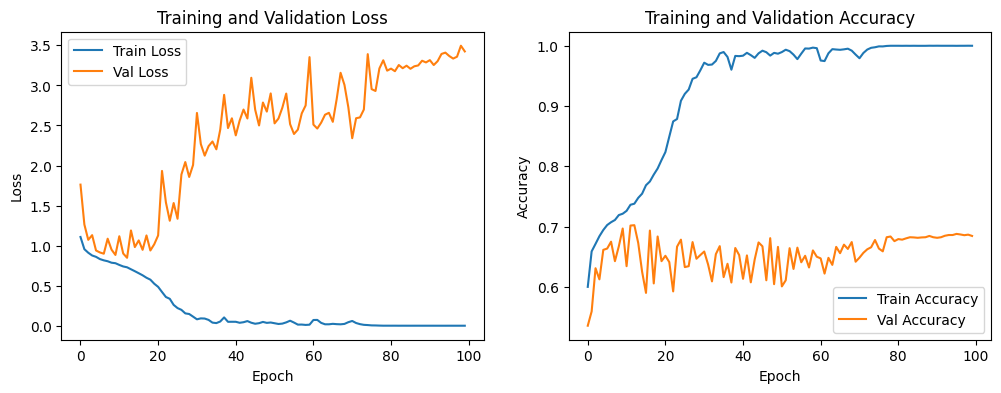

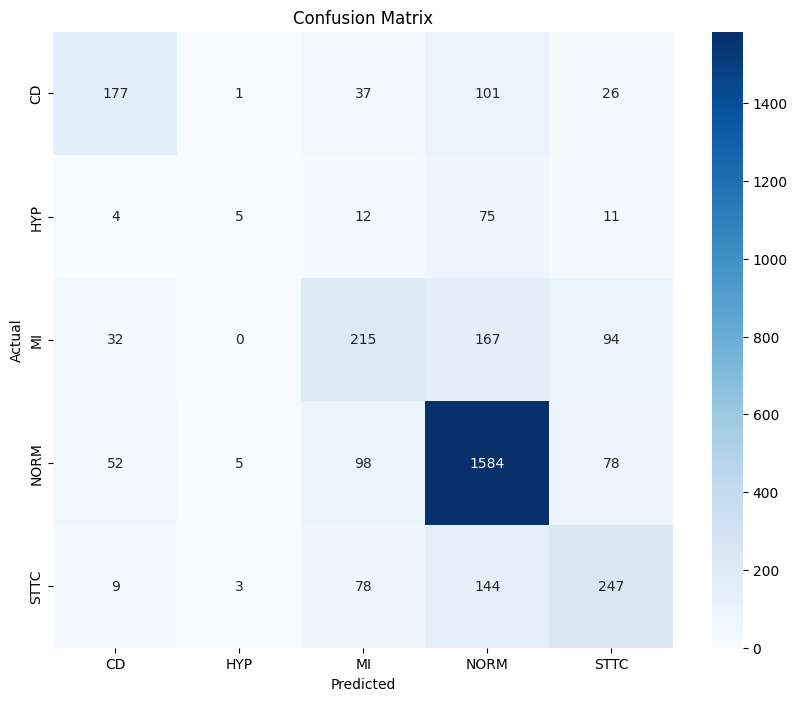


Classification Report:

              precision    recall  f1-score   support

          CD       0.65      0.52      0.57       342
         HYP       0.36      0.05      0.08       107
          MI       0.49      0.42      0.45       508
        NORM       0.76      0.87      0.81      1817
        STTC       0.54      0.51      0.53       481

    accuracy                           0.68      3255
   macro avg       0.56      0.47      0.49      3255
weighted avg       0.66      0.68      0.67      3255

F1 Score (Weighted): 0.6666
Accuracy: 0.6845
Training Loss Std Dev: 0.3024
Training Accuracy Std Dev: 0.1084
Validation Loss Std Dev: 0.8274
Validation Accuracy Std Dev: 0.0307


In [ ]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # Progress bar
from torch.cuda.amp import GradScaler, autocast  # For mixed precision
from torchsummary import summary  # For model summary

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# List of directory paths for different classes
directories = {
    'CD': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD',
    'HYP': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP',
    'MI': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI',
    'NORM': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM',
    'STTC': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC'
}

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128  # Increased batch size
EPOCHS = 100  # Increased epochs
LEARNING_RATE = 0.004937798345800423  # Optimized learning rate from the best trial

# Custom dataset to load images from paths
class ECGDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        # Load the image
        image = Image.open(img_path)

        # Ensure the image has 3 channels (convert RGBA or L to RGB)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Image transformations (use transformations with PIL images)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Ensure it's RGB
])

# Load all of the data (using 100% of the dataset)
data = []
labels = []

for label, directory in directories.items():
    if os.path.exists(directory):
        print(f"Processing directory: {directory}")

        # Get all .png files
        png_files = glob.glob(os.path.join(directory, '*.png'))

        for file_path in png_files:
            data.append(file_path)
            labels.append(list(directories.keys()).index(label))
    else:
        print(f"Directory does not exist: {directory}")

# Convert to NumPy arrays for further processing
data = np.array(data)
labels = np.array(labels)

# Print the input shape of one of the samples (ensure all are of the same shape)
sample_image = Image.open(data[0])
if sample_image.mode != 'RGB':
    sample_image = sample_image.convert('RGB')
sample_image = transform(sample_image)  # Apply transformation
print(f"Input image shape after transformation: {sample_image.shape}")

# Train-test split (80-20)
train_files, test_files, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42)

# Print the sizes of the train and test sets
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")

# Create datasets and dataloaders
train_dataset = ECGDataset(train_files, train_labels, transform=transform)
test_dataset = ECGDataset(test_files, test_labels, transform=transform)

# Using more workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# Load the ResNet50 model with pretrained weights
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Modify the classifier to match the number of classes
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(directories))

# Move the model to the GPU if available
model = model.to(device)

# Print model summary
print("\nModel Summary:\n")
summary(model, (3, IMG_SIZE, IMG_SIZE))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Mixed precision scaler
scaler = GradScaler()

# Train the model
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # To track the best validation accuracy

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scaler handles backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # Validation loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():  # Mixed precision inference
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description
            test_loader_tqdm.set_postfix(loss=loss.item())

    val_loss /= len(test_loader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f'resnet50_epoch_{epoch+1}.pth')
    print(f"Model saved for epoch {epoch + 1}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DATAS/results/best_resnet50_ecg_model.pth')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}")

# Plot training & validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix and F1 Score
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=directories.keys(), yticklabels=directories.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report to get F1 score, precision, recall, and accuracy
class_report = classification_report(y_true, y_pred, target_names=directories.keys())
print("\nClassification Report:\n")
print(class_report)

# Calculate accuracy and F1 score manually for better clarity
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 Score (Weighted): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print standard deviation for losses and accuracies
train_loss_std = np.std(train_loss_history)
train_acc_std = np.std(train_acc_history)
val_loss_std = np.std(val_loss_history)
val_acc_std = np.std(val_acc_history)

print(f"Training Loss Std Dev: {train_loss_std:.4f}")
print(f"Training Accuracy Std Dev: {train_acc_std:.4f}")
print(f"Validation Loss Std Dev: {val_loss_std:.4f}")
print(f"Validation Accuracy Std Dev: {val_acc_std:.4f}")


Increase ResNet50 Layer

Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM
Processing directory: /content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC
Input image shape after transformation: torch.Size([3, 224, 224])
Training set size: 13017
Test set size: 3255


Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 137MB/s]



Model Summary:

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14  

Training Loss: 1.0946, Training Accuracy: 0.6119


Validation Loss: 1.0350, Validation Accuracy: 0.6350
Model saved for epoch 1
Best model saved at epoch 1 with validation accuracy: 0.6350
Epoch 2/100


Training Loss: 0.9724, Training Accuracy: 0.6558


Validation Loss: 0.9684, Validation Accuracy: 0.6581
Model saved for epoch 2
Best model saved at epoch 2 with validation accuracy: 0.6581
Epoch 3/100


Training Loss: 0.9274, Training Accuracy: 0.6669


Validation Loss: 0.9412, Validation Accuracy: 0.6731
Model saved for epoch 3
Best model saved at epoch 3 with validation accuracy: 0.6731
Epoch 4/100


Training Loss: 0.9061, Training Accuracy: 0.6745


Validation Loss: 0.9307, Validation Accuracy: 0.6673
Model saved for epoch 4
Epoch 5/100


Training Loss: 0.8833, Training Accuracy: 0.6866


Validation Loss: 1.2995, Validation Accuracy: 0.5158
Model saved for epoch 5
Epoch 6/100


Training Loss: 0.8698, Training Accuracy: 0.6885


Validation Loss: 0.9838, Validation Accuracy: 0.6762
Model saved for epoch 6
Best model saved at epoch 6 with validation accuracy: 0.6762
Epoch 7/100


Training Loss: 0.8385, Training Accuracy: 0.7017


Validation Loss: 1.0755, Validation Accuracy: 0.6575
Model saved for epoch 7
Epoch 8/100


Training Loss: 0.8268, Training Accuracy: 0.7021


Validation Loss: 0.8965, Validation Accuracy: 0.6771
Model saved for epoch 8
Best model saved at epoch 8 with validation accuracy: 0.6771
Epoch 9/100


Training Loss: 0.8221, Training Accuracy: 0.7098


Validation Loss: 1.4747, Validation Accuracy: 0.4172
Model saved for epoch 9
Epoch 10/100


Training Loss: 0.8159, Training Accuracy: 0.7119


Validation Loss: 0.9299, Validation Accuracy: 0.6608
Model saved for epoch 10
Epoch 11/100


Training Loss: 0.7914, Training Accuracy: 0.7214


Validation Loss: 0.9674, Validation Accuracy: 0.6482
Model saved for epoch 11
Epoch 12/100


Training Loss: 0.7769, Training Accuracy: 0.7243


Validation Loss: 1.0070, Validation Accuracy: 0.6335
Model saved for epoch 12
Epoch 13/100


Training Loss: 0.7652, Training Accuracy: 0.7287


Validation Loss: 0.8925, Validation Accuracy: 0.6922
Model saved for epoch 13
Best model saved at epoch 13 with validation accuracy: 0.6922
Epoch 14/100


Training Loss: 0.7428, Training Accuracy: 0.7376


Validation Loss: 0.8967, Validation Accuracy: 0.6919
Model saved for epoch 14
Epoch 15/100


Training Loss: 0.7306, Training Accuracy: 0.7414


Validation Loss: 1.6299, Validation Accuracy: 0.4418
Model saved for epoch 15
Epoch 16/100


Training Loss: 0.7171, Training Accuracy: 0.7461


Validation Loss: 0.9703, Validation Accuracy: 0.6611
Model saved for epoch 16
Epoch 17/100


Training Loss: 0.6769, Training Accuracy: 0.7601


Validation Loss: 1.0236, Validation Accuracy: 0.6725
Model saved for epoch 17
Epoch 18/100


Training Loss: 0.6695, Training Accuracy: 0.7609


Validation Loss: 0.8824, Validation Accuracy: 0.6968
Model saved for epoch 18
Best model saved at epoch 18 with validation accuracy: 0.6968
Epoch 19/100


Training Loss: 0.6454, Training Accuracy: 0.7716


Validation Loss: 0.9301, Validation Accuracy: 0.7060
Model saved for epoch 19
Best model saved at epoch 19 with validation accuracy: 0.7060
Epoch 20/100


Training Loss: 0.6232, Training Accuracy: 0.7814


Validation Loss: 1.0637, Validation Accuracy: 0.6479
Model saved for epoch 20
Epoch 21/100


Training Loss: 0.5982, Training Accuracy: 0.7888


Validation Loss: 1.2519, Validation Accuracy: 0.6694
Model saved for epoch 21
Epoch 22/100


Training Loss: 0.5568, Training Accuracy: 0.8030


Validation Loss: 1.0376, Validation Accuracy: 0.6716
Model saved for epoch 22
Epoch 23/100


Training Loss: 0.5277, Training Accuracy: 0.8213


Validation Loss: 1.1216, Validation Accuracy: 0.6753
Model saved for epoch 23
Epoch 24/100


Training Loss: 0.4929, Training Accuracy: 0.8281


Validation Loss: 1.3417, Validation Accuracy: 0.6212
Model saved for epoch 24
Epoch 25/100


Training Loss: 0.4422, Training Accuracy: 0.8474


Validation Loss: 1.1738, Validation Accuracy: 0.6636
Model saved for epoch 25
Epoch 26/100


Training Loss: 0.4107, Training Accuracy: 0.8566


Validation Loss: 1.3071, Validation Accuracy: 0.6077
Model saved for epoch 26
Epoch 27/100


Training Loss: 0.3602, Training Accuracy: 0.8762


Validation Loss: 1.3062, Validation Accuracy: 0.6900
Model saved for epoch 27
Epoch 28/100


Training Loss: 0.3271, Training Accuracy: 0.8880


Validation Loss: 1.5407, Validation Accuracy: 0.6664
Model saved for epoch 28
Epoch 29/100


Training Loss: 0.2732, Training Accuracy: 0.9070


Validation Loss: 2.1139, Validation Accuracy: 0.4934
Model saved for epoch 29
Epoch 30/100


Training Loss: 0.2597, Training Accuracy: 0.9092


Validation Loss: 1.6546, Validation Accuracy: 0.6280
Model saved for epoch 30
Epoch 31/100


Training Loss: 0.2360, Training Accuracy: 0.9186


Validation Loss: 1.9641, Validation Accuracy: 0.5505
Model saved for epoch 31
Epoch 32/100


Training Loss: 0.2030, Training Accuracy: 0.9307


Validation Loss: 1.5647, Validation Accuracy: 0.6387
Model saved for epoch 32
Epoch 33/100


Training Loss: 0.1620, Training Accuracy: 0.9451


Validation Loss: 2.0464, Validation Accuracy: 0.6811
Model saved for epoch 33
Epoch 34/100


Training Loss: 0.1589, Training Accuracy: 0.9432


Validation Loss: 2.4187, Validation Accuracy: 0.6713
Model saved for epoch 34
Epoch 35/100


Training Loss: 0.1411, Training Accuracy: 0.9533


Validation Loss: 1.8395, Validation Accuracy: 0.6160
Model saved for epoch 35
Epoch 36/100


Training Loss: 0.1232, Training Accuracy: 0.9585


Validation Loss: 2.0834, Validation Accuracy: 0.6427
Model saved for epoch 36
Epoch 37/100


Training Loss: 0.1054, Training Accuracy: 0.9654


Validation Loss: 2.3678, Validation Accuracy: 0.6704
Model saved for epoch 37
Epoch 38/100


Training Loss: 0.1086, Training Accuracy: 0.9616


Validation Loss: 1.8728, Validation Accuracy: 0.6602
Model saved for epoch 38
Epoch 39/100


Training Loss: 0.0890, Training Accuracy: 0.9706


Validation Loss: 2.1034, Validation Accuracy: 0.6562
Model saved for epoch 39
Epoch 40/100


Training Loss: 0.0906, Training Accuracy: 0.9704


Validation Loss: 1.9623, Validation Accuracy: 0.6562
Model saved for epoch 40
Epoch 41/100


Training Loss: 0.0686, Training Accuracy: 0.9762


Validation Loss: 2.3642, Validation Accuracy: 0.6212
Model saved for epoch 41
Epoch 42/100


Training Loss: 0.0699, Training Accuracy: 0.9754


Validation Loss: 2.1250, Validation Accuracy: 0.6363
Model saved for epoch 42
Epoch 43/100


Training Loss: 0.0677, Training Accuracy: 0.9768


Validation Loss: 2.5574, Validation Accuracy: 0.6636
Model saved for epoch 43
Epoch 44/100


Training Loss: 0.0686, Training Accuracy: 0.9771


Validation Loss: 2.4078, Validation Accuracy: 0.6556
Model saved for epoch 44
Epoch 45/100


Training Loss: 0.0716, Training Accuracy: 0.9768


Validation Loss: 2.4475, Validation Accuracy: 0.6479
Model saved for epoch 45
Epoch 46/100


Training Loss: 0.0668, Training Accuracy: 0.9773


Validation Loss: 2.4458, Validation Accuracy: 0.6581
Model saved for epoch 46
Epoch 47/100


Training Loss: 0.0571, Training Accuracy: 0.9809


Validation Loss: 2.4148, Validation Accuracy: 0.6783
Model saved for epoch 47
Epoch 48/100


Training Loss: 0.0579, Training Accuracy: 0.9804


Validation Loss: 2.9763, Validation Accuracy: 0.6848
Model saved for epoch 48
Epoch 49/100


Training Loss: 0.0587, Training Accuracy: 0.9797


Validation Loss: 2.4911, Validation Accuracy: 0.6550
Model saved for epoch 49
Epoch 50/100


Training Loss: 0.0541, Training Accuracy: 0.9811


Validation Loss: 2.2862, Validation Accuracy: 0.6452
Model saved for epoch 50
Epoch 51/100


Training Loss: 0.0615, Training Accuracy: 0.9781


Validation Loss: 2.2889, Validation Accuracy: 0.6657
Model saved for epoch 51
Epoch 52/100


Training Loss: 0.0513, Training Accuracy: 0.9822


Validation Loss: 2.3539, Validation Accuracy: 0.6578
Model saved for epoch 52
Epoch 53/100


Training Loss: 0.0579, Training Accuracy: 0.9819


Validation Loss: 2.5204, Validation Accuracy: 0.6255
Model saved for epoch 53
Epoch 54/100


Training Loss: 0.0520, Training Accuracy: 0.9839


Validation Loss: 2.4400, Validation Accuracy: 0.6295
Model saved for epoch 54
Epoch 55/100


Training Loss: 0.0547, Training Accuracy: 0.9829


Validation Loss: 2.5474, Validation Accuracy: 0.6286
Model saved for epoch 55
Epoch 56/100


Training Loss: 0.0486, Training Accuracy: 0.9848


Validation Loss: 2.2538, Validation Accuracy: 0.6602
Model saved for epoch 56
Epoch 57/100


Training Loss: 0.0425, Training Accuracy: 0.9870


Validation Loss: 2.4502, Validation Accuracy: 0.6332
Model saved for epoch 57
Epoch 58/100


Training Loss: 0.0441, Training Accuracy: 0.9863


Validation Loss: 2.7241, Validation Accuracy: 0.6525
Model saved for epoch 58
Epoch 59/100


Training Loss: 0.0428, Training Accuracy: 0.9854


Validation Loss: 2.7995, Validation Accuracy: 0.6495
Model saved for epoch 59
Epoch 60/100


Training Loss: 0.0391, Training Accuracy: 0.9871


Validation Loss: 2.4875, Validation Accuracy: 0.6664
Model saved for epoch 60
Epoch 61/100


Training Loss: 0.0358, Training Accuracy: 0.9868


Validation Loss: 2.7217, Validation Accuracy: 0.6464
Model saved for epoch 61
Epoch 62/100


Training Loss: 0.0512, Training Accuracy: 0.9844


Validation Loss: 2.7294, Validation Accuracy: 0.6676
Model saved for epoch 62
Epoch 63/100


Training Loss: 0.0416, Training Accuracy: 0.9852


Validation Loss: 2.7610, Validation Accuracy: 0.6624
Model saved for epoch 63
Epoch 64/100


Training Loss: 0.0502, Training Accuracy: 0.9829


Validation Loss: 2.8189, Validation Accuracy: 0.6504
Model saved for epoch 64
Epoch 65/100


Training Loss: 0.0360, Training Accuracy: 0.9889


Validation Loss: 2.7149, Validation Accuracy: 0.6636
Model saved for epoch 65
Epoch 66/100


Training Loss: 0.0464, Training Accuracy: 0.9852


Validation Loss: 2.3962, Validation Accuracy: 0.6688
Model saved for epoch 66
Epoch 67/100


Training Loss: 0.0301, Training Accuracy: 0.9887


Validation Loss: 2.8323, Validation Accuracy: 0.6651
Model saved for epoch 67
Epoch 68/100


Training Loss: 0.0332, Training Accuracy: 0.9886


Validation Loss: 2.9925, Validation Accuracy: 0.5957
Model saved for epoch 68
Epoch 69/100


Training Loss: 0.0488, Training Accuracy: 0.9829


Validation Loss: 2.6737, Validation Accuracy: 0.6697
Model saved for epoch 69
Epoch 70/100


Training Loss: 0.0319, Training Accuracy: 0.9891


Validation Loss: 2.8221, Validation Accuracy: 0.6710
Model saved for epoch 70
Epoch 71/100


Training Loss: 0.0388, Training Accuracy: 0.9872


Validation Loss: 2.6580, Validation Accuracy: 0.6436
Model saved for epoch 71
Epoch 72/100


Training Loss: 0.0466, Training Accuracy: 0.9856


Validation Loss: 2.8523, Validation Accuracy: 0.5797
Model saved for epoch 72
Epoch 73/100


Training Loss: 0.0518, Training Accuracy: 0.9825


Validation Loss: 2.6776, Validation Accuracy: 0.6743
Model saved for epoch 73
Epoch 74/100


Training Loss: 0.0389, Training Accuracy: 0.9872


Validation Loss: 2.8127, Validation Accuracy: 0.6750
Model saved for epoch 74
Epoch 75/100


Training Loss: 0.0348, Training Accuracy: 0.9889


Validation Loss: 3.3079, Validation Accuracy: 0.6378
Model saved for epoch 75
Epoch 76/100


Training Loss: 0.0386, Training Accuracy: 0.9868


Validation Loss: 3.0410, Validation Accuracy: 0.6667
Model saved for epoch 76
Epoch 77/100


Training Loss: 0.0355, Training Accuracy: 0.9875


Validation Loss: 2.7440, Validation Accuracy: 0.6651
Model saved for epoch 77
Epoch 78/100


Training Loss: 0.0431, Training Accuracy: 0.9856


Validation Loss: 2.5388, Validation Accuracy: 0.6359
Model saved for epoch 78
Epoch 79/100


Training Loss: 0.0434, Training Accuracy: 0.9858


Validation Loss: 2.7376, Validation Accuracy: 0.6774
Model saved for epoch 79
Epoch 80/100


Training Loss: 0.0238, Training Accuracy: 0.9916


Validation Loss: 3.3064, Validation Accuracy: 0.6777
Model saved for epoch 80
Epoch 81/100


Training Loss: 0.0469, Training Accuracy: 0.9849


Validation Loss: 2.8970, Validation Accuracy: 0.6783
Model saved for epoch 81
Epoch 82/100


Training Loss: 0.0293, Training Accuracy: 0.9903


Validation Loss: 3.1059, Validation Accuracy: 0.6713
Model saved for epoch 82
Epoch 83/100


Training Loss: 0.0287, Training Accuracy: 0.9897


Validation Loss: 2.8292, Validation Accuracy: 0.6531
Model saved for epoch 83
Epoch 84/100


Training Loss: 0.0332, Training Accuracy: 0.9889


Validation Loss: 2.8167, Validation Accuracy: 0.6602
Model saved for epoch 84
Epoch 85/100


Training Loss: 0.0319, Training Accuracy: 0.9894


Validation Loss: 2.8270, Validation Accuracy: 0.6387
Model saved for epoch 85
Epoch 86/100


Training Loss: 0.0361, Training Accuracy: 0.9875


Validation Loss: 3.0353, Validation Accuracy: 0.6602
Model saved for epoch 86
Epoch 87/100


Training Loss: 0.0315, Training Accuracy: 0.9902


Validation Loss: 2.8835, Validation Accuracy: 0.6707
Model saved for epoch 87
Epoch 88/100


Training Loss: 0.0206, Training Accuracy: 0.9934


Validation Loss: 3.2037, Validation Accuracy: 0.6578
Model saved for epoch 88
Epoch 89/100


Training Loss: 0.0279, Training Accuracy: 0.9909


Validation Loss: 3.0474, Validation Accuracy: 0.6808
Model saved for epoch 89
Epoch 90/100


Training Loss: 0.0238, Training Accuracy: 0.9917


Validation Loss: 3.1335, Validation Accuracy: 0.6710
Model saved for epoch 90
Epoch 91/100


Training Loss: 0.0551, Training Accuracy: 0.9816


Validation Loss: 3.5651, Validation Accuracy: 0.6627
Model saved for epoch 91
Epoch 92/100


Training Loss: 0.0392, Training Accuracy: 0.9873


Validation Loss: 2.7297, Validation Accuracy: 0.6077
Model saved for epoch 92
Epoch 93/100


Training Loss: 0.0299, Training Accuracy: 0.9889


Validation Loss: 2.5481, Validation Accuracy: 0.6516
Model saved for epoch 93
Epoch 94/100


Training Loss: 0.0253, Training Accuracy: 0.9919


Validation Loss: 2.9920, Validation Accuracy: 0.6627
Model saved for epoch 94
Epoch 95/100


Training Loss: 0.0321, Training Accuracy: 0.9896


Validation Loss: 3.1350, Validation Accuracy: 0.6553
Model saved for epoch 95
Epoch 96/100


Training Loss: 0.0349, Training Accuracy: 0.9889


Validation Loss: 2.6933, Validation Accuracy: 0.6255
Model saved for epoch 96
Epoch 97/100


Training Loss: 0.0294, Training Accuracy: 0.9896


Validation Loss: 3.3228, Validation Accuracy: 0.6510
Model saved for epoch 97
Epoch 98/100


Training Loss: 0.0252, Training Accuracy: 0.9922


Validation Loss: 2.8233, Validation Accuracy: 0.6581
Model saved for epoch 98
Epoch 99/100


Training Loss: 0.0198, Training Accuracy: 0.9926


Validation Loss: 3.6231, Validation Accuracy: 0.6925
Model saved for epoch 99
Epoch 100/100


Training Loss: 0.0397, Training Accuracy: 0.9877


Validation Loss: 2.7932, Validation Accuracy: 0.6688
Model saved for epoch 100


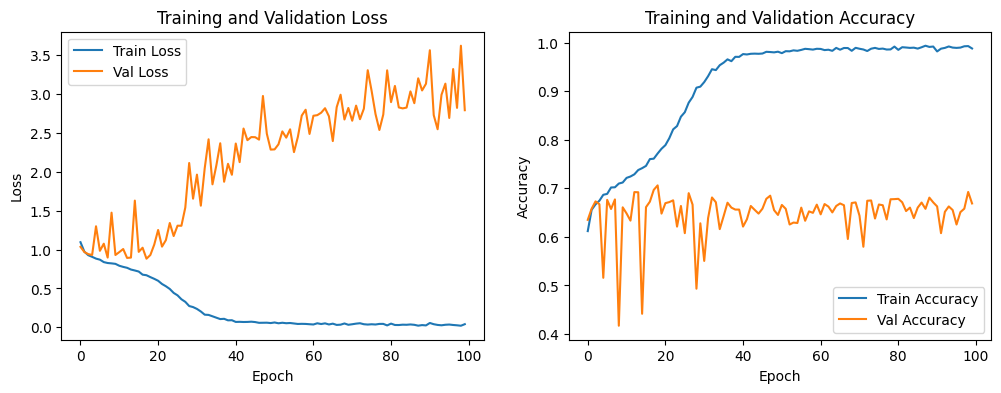

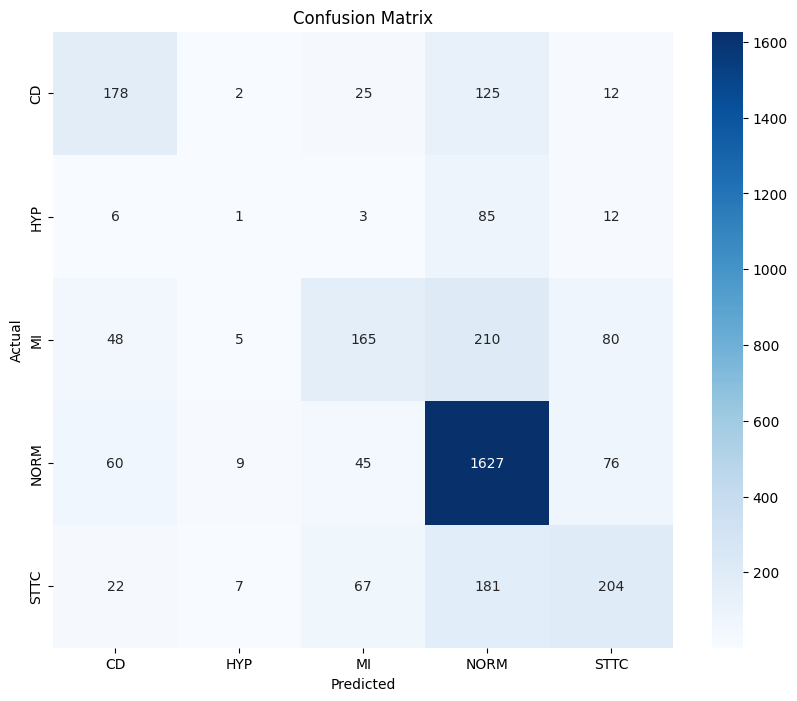


Classification Report:

              precision    recall  f1-score   support

          CD       0.57      0.52      0.54       342
         HYP       0.04      0.01      0.02       107
          MI       0.54      0.32      0.41       508
        NORM       0.73      0.90      0.80      1817
        STTC       0.53      0.42      0.47       481

    accuracy                           0.67      3255
   macro avg       0.48      0.43      0.45      3255
weighted avg       0.63      0.67      0.64      3255

F1 Score (Weighted): 0.6396
Accuracy: 0.6682
Training Loss Std Dev: 0.3093
Training Accuracy Std Dev: 0.1101
Validation Loss Std Dev: 0.7798
Validation Accuracy Std Dev: 0.0447


In [ ]:
import os
import glob
import random
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, f1_score, accuracy_score
import seaborn as sns
from PIL import Image
from tqdm import tqdm  # Progress bar
from torch.cuda.amp import GradScaler, autocast  # For mixed precision
from torchsummary import summary  # For model summary

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# List of directory paths for different classes
directories = {
    'CD': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/CD',
    'HYP': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/HYP',
    'MI': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/MI',
    'NORM': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/NORM',
    'STTC': '/content/drive/MyDrive/DATAS/Data/PTB-XL/physionet.org/files/ptb-xl/1.0.1/scalograms/STTC'
}

# Parameters
IMG_SIZE = 224
BATCH_SIZE = 128  # Increased batch size
EPOCHS = 100  # Increased epochs
LEARNING_RATE = 0.004937798345800423  # Optimized learning rate from the best trial

# Custom dataset to load images from paths
class ECGDataset(Dataset):
    def __init__(self, file_paths, labels, transform=None):
        self.file_paths = file_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.file_paths)

    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        # Load the image
        image = Image.open(img_path)

        # Ensure the image has 3 channels (convert RGBA or L to RGB)
        if image.mode != 'RGB':
            image = image.convert('RGB')

        if self.transform:
            image = self.transform(image)

        label = self.labels[idx]
        return image, label

# Image transformations (use transformations with PIL images)
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Ensure it's RGB
])

# Load all of the data (using 100% of the dataset)
data = []
labels = []

for label, directory in directories.items():
    if os.path.exists(directory):
        print(f"Processing directory: {directory}")

        # Get all .png files
        png_files = glob.glob(os.path.join(directory, '*.png'))

        for file_path in png_files:
            data.append(file_path)
            labels.append(list(directories.keys()).index(label))
    else:
        print(f"Directory does not exist: {directory}")

# Convert to NumPy arrays for further processing
data = np.array(data)
labels = np.array(labels)

# Print the input shape of one of the samples (ensure all are of the same shape)
sample_image = Image.open(data[0])
if sample_image.mode != 'RGB':
    sample_image = sample_image.convert('RGB')
sample_image = transform(sample_image)  # Apply transformation
print(f"Input image shape after transformation: {sample_image.shape}")

# Train-test split (80-20)
train_files, test_files, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, stratify=labels, random_state=42)

# Print the sizes of the train and test sets
print(f"Training set size: {len(train_files)}")
print(f"Test set size: {len(test_files)}")

# Create datasets and dataloaders
train_dataset = ECGDataset(train_files, train_labels, transform=transform)
test_dataset = ECGDataset(test_files, test_labels, transform=transform)

# Using more workers for faster data loading
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=8, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=8, pin_memory=True)

# Define a modified ResNet50 model with an additional fully connected layer
class ModifiedResNet50(nn.Module):
    def __init__(self, num_classes):
        super(ModifiedResNet50, self).__init__()
        self.resnet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        num_ftrs = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Linear(num_ftrs, 512),  # Add intermediate FC layer
            nn.ReLU(),                 # Activation function
            nn.Dropout(0.5),           # Dropout for regularization
            nn.Linear(512, num_classes) # Final output layer
        )

    def forward(self, x):
        return self.resnet(x)

# Instantiate the modified model
model = ModifiedResNet50(num_classes=len(directories))

# Move the model to the GPU if available
model = model.to(device)

# Print model summary
print("\nModel Summary:\n")
summary(model, (3, IMG_SIZE, IMG_SIZE))

# Loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Mixed precision scaler
scaler = GradScaler()

# Train the model
train_loss_history = []
train_acc_history = []
val_loss_history = []
val_acc_history = []

best_val_acc = 0.0  # To track the best validation accuracy

for epoch in range(EPOCHS):
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop with progress bar
    train_loader_tqdm = tqdm(train_loader, desc="Training", leave=False)
    for inputs, labels in train_loader_tqdm:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()

        # Mixed precision forward pass
        with autocast():
            outputs = model(inputs)
            loss = criterion(outputs, labels)

        # Scaler handles backward pass
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        # Update tqdm description
        train_loader_tqdm.set_postfix(loss=loss.item())

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_loss_history.append(train_loss)
    train_acc_history.append(train_acc)

    print(f"Training Loss: {train_loss:.4f}, Training Accuracy: {train_acc:.4f}")

    # Validate the model
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    # Validation loop with progress bar
    test_loader_tqdm = tqdm(test_loader, desc="Validation", leave=False)
    with torch.no_grad():
        for inputs, labels in test_loader_tqdm:
            inputs, labels = inputs.to(device), labels.to(device)

            with autocast():  # Mixed precision inference
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Update tqdm description
            test_loader_tqdm.set_postfix(loss=loss.item())

    val_loss /= len(test_loader)
    val_acc = correct / total
    val_loss_history.append(val_loss)
    val_acc_history.append(val_acc)

    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

    # Save the model at the end of each epoch
    torch.save(model.state_dict(), f'resnet50_epoch_{epoch+1}.pth')
    print(f"Model saved for epoch {epoch + 1}")

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), '/content/drive/MyDrive/DATAS/results/best_resnet50_ecg_model.pth')
        print(f"Best model saved at epoch {epoch+1} with validation accuracy: {val_acc:.4f}")

# Plot training & validation loss/accuracy
plt.figure(figsize=(12, 4))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Val Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(train_acc_history, label='Train Accuracy')
plt.plot(val_acc_history, label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Confusion Matrix and F1 Score
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap='Blues', xticklabels=directories.keys(), yticklabels=directories.keys())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Classification report to get F1 score, precision, recall, and accuracy
class_report = classification_report(y_true, y_pred, target_names=directories.keys())
print("\nClassification Report:\n")
print(class_report)

# Calculate accuracy and F1 score manually for better clarity
f1 = f1_score(y_true, y_pred, average='weighted')
accuracy = accuracy_score(y_true, y_pred)

print(f"F1 Score (Weighted): {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Calculate and print standard deviation for losses and accuracies
train_loss_std = np.std(train_loss_history)
train_acc_std = np.std(train_acc_history)
val_loss_std = np.std(val_loss_history)
val_acc_std = np.std(val_acc_history)

print(f"Training Loss Std Dev: {train_loss_std:.4f}")
print(f"Training Accuracy Std Dev: {train_acc_std:.4f}")
print(f"Validation Loss Std Dev: {val_loss_std:.4f}")
print(f"Validation Accuracy Std Dev: {val_acc_std:.4f}")
